In [1]:
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap
from jax import random
from functools import partial

from numba import vectorize, float64, guvectorize, njit

import time
import math
from tqdm import tqdm
import sklearn.mixture
import pandas as pd
import matplotlib.pyplot as plt

from jax.scipy.stats import multivariate_normal
from scipy.stats import multivariate_normal as ss_multivariate_normal
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import scipy

In [2]:
import jax
jax.devices()

[CpuDevice(id=0)]

In [3]:
key = random.PRNGKey(68)
key1 = random.PRNGKey(6898)
key2 = random.PRNGKey(681998)
subkeys = random.split(key, 5000)
subkeys1 = random.split(key1, 5000)

In [4]:
# Generate data from normal distribution
@partial(jit, static_argnames=['dataset_size','num_datasets'])
def normal_data(theta, dataset_size, num_datasets):
    N = jnp.sqrt(sigma) * ((jnp.array(np.random.gamma(alpha, (1/beta), (num_datasets, dataset_size)))) - (alpha/beta)) / jnp.sqrt(alpha/(beta**2))
    data = N + theta
    return data

In [5]:
true_theta = jnp.array([0])
mu = 0
sigma = 4
alpha = 1
beta = 0.01

In [6]:
actual_data = normal_data(true_theta, 30, 1)
actual_data

Array([[ 0.51059186, -1.848373  , -1.2771664 ,  4.050851  , -1.2634336 ,
         0.68000364, -0.2860083 ,  0.11958832, -1.7276157 ,  2.7587967 ,
        -1.2592475 , -0.10306259, -0.8267217 ,  4.1632442 , -0.13562804,
        -1.387645  ,  4.9232063 ,  1.3213671 , -1.8774823 , -1.7050524 ,
        -0.75905174,  4.6873446 , -1.2805289 , -1.0342855 , -1.7593741 ,
         0.04360138, -0.03695847, -0.8004213 , -1.9241765 , -1.2170458 ]],      dtype=float32)

In [7]:
# CALCULATE SUMMARY STATS
@jit
def normal_data_ss(data):
  mean_normal_data = jnp.mean(data)
  std_normal_data = jnp.var(data)
  return jnp.array([mean_normal_data, std_normal_data])

In [8]:
actual_summary_statistics = normal_data_ss(actual_data)
actual_summary_statistics

Array([0.0249772, 4.0867243], dtype=float32)

In [9]:
num_coeffs = 1
num_latent = 2
len_ss = np.shape(actual_summary_statistics)[0]
n_samples = 30
num_datasets = 200
lambda_dim = num_coeffs + int((num_coeffs * (num_coeffs + 1)) / 2)

sigma_theta = 10
sigma_latent = 1

In [10]:
def my_inv(x):
    return jnp.linalg.inv(x + (jnp.eye(x.shape[0]) * 1e-7))

## Training Wasserstein Gaussianing

In [11]:
wass_num_datasets = 5000
wass_n_samples = 30
maxG = 4

In [12]:
# Generating data to train the transform
wass_datasets = normal_data(true_theta, wass_n_samples, wass_num_datasets)
wass_n_summary_statistics = jnp.array([normal_data_ss(wass_datasets[i,:]) for i in range(wass_num_datasets)])

In [13]:
# Divide the synthetic data to train, test, val
wass_train_summary_statistics = wass_n_summary_statistics[:int(wass_num_datasets/3),:]
wass_val_summary_statistics = wass_n_summary_statistics[int(wass_num_datasets/3):int(wass_num_datasets * 2/3),:]
wass_test_summary_statistics = wass_n_summary_statistics[int(wass_num_datasets * 2/3):wass_num_datasets,:]

original_train_summary_statistics = wass_train_summary_statistics
original_test_summary_statistics = wass_test_summary_statistics

In [14]:
def mixture_model_fit(data, maxG):
    bic_values = []
    for g in range(1, maxG+1):
        mixture_obj = sklearn.mixture.GaussianMixture(n_components = g, reg_covar = 1e-5).fit(data)
        bic_values.append(mixture_obj.bic(data))
    bestG = int(jnp.argmin(jnp.array(bic_values)) + 1)
    best_mixture_obj = sklearn.mixture.GaussianMixture(n_components = bestG, reg_covar = 1e-5).fit(data)
    mean_mixture_obj = best_mixture_obj.means_
    sigma_mixture_obj = best_mixture_obj.covariances_
    weights_mixture_obj = best_mixture_obj.weights_
    return best_mixture_obj, bestG, jnp.array(mean_mixture_obj), jnp.array(sigma_mixture_obj), jnp.array(weights_mixture_obj)

In [15]:
@jit
def grad_log_density_mixture(data, mean_mixture_obj, sigma_mixture_obj, weights_mixture_obj):
    bestG = len(weights_mixture_obj)

    loglh_all_mixture = []
    grad_loglh_all_mixture = []
    for k in range(bestG):
        mean_kth_mixture = mean_mixture_obj[k,:] #1 x g
        sigma_kth_mixture = sigma_mixture_obj[k,:] # g x g
        weight_kth_mixture = weights_mixture_obj[k]
        diff_mean_kth_mixture = data - mean_kth_mixture #99 x g aux
        loglh_all_mixture.append(jnp.log(weight_kth_mixture) - num_coeffs/2 * jnp.log(2 * jnp.pi)-1/2 * jnp.linalg.slogdet(sigma_kth_mixture)[1] - 1/2 * jnp.diag(diff_mean_kth_mixture @ jnp.linalg.solve(sigma_kth_mixture, diff_mean_kth_mixture.T))) # 99x99 -> diag:1x99->gx99 lw
        grad_loglh_all_mixture.append(-diff_mean_kth_mixture @ jnp.linalg.solve(sigma_kth_mixture, jnp.eye(sigma_kth_mixture.shape[0]))) #M =99 x dim of ss =4

    max_llh_all_data = jnp.max(jnp.array(loglh_all_mixture), axis = 0) # 99 x 1
    aux_llh_all_data = jnp.array(loglh_all_mixture) - max_llh_all_data #g x 99
    w_all_data = jnp.exp(aux_llh_all_data) / jnp.sum(jnp.exp(aux_llh_all_data), axis = 0) #g x 99
    log_f = jnp.log(jnp.sum(jnp.exp(aux_llh_all_data), axis = 0)) + max_llh_all_data #99 x 1

    grad_log_f = 0
    for k in range(bestG):
        grad_log_f = grad_log_f + jnp.tile(jnp.reshape(w_all_data[k,:], (len(data),1)),(1,num_coeffs)) * grad_loglh_all_mixture[k] #data x num_coeff
    return log_f, grad_log_f

In [16]:
# Start training

# Hyperparams
patience_max = 5
patience = 0
stop = 5000
eps = 0.01
t_w = 10

# Initialize empty chain
mixture_obj_seq = []
bestG_seq = []
lb = []
LB_Smoothed = []

# At current particles, fit mixture normal
mixture_model = mixture_model_fit(original_train_summary_statistics, maxG)
mixture_obj_seq.append(mixture_model[0])
bestG_seq.append(mixture_model[1])

In [17]:
for t in range(stop):
    stepsize = eps

    train_grad_log_f = grad_log_density_mixture(wass_train_summary_statistics, mixture_model[2], mixture_model[3], mixture_model[4])[1]
    v = -wass_train_summary_statistics-train_grad_log_f
    wass_train_summary_statistics = wass_train_summary_statistics + stepsize * v

    val_grad_log_f = grad_log_density_mixture(wass_val_summary_statistics, mixture_model[2], mixture_model[3], mixture_model[4])[1]
    val_log_f = grad_log_density_mixture(wass_val_summary_statistics, mixture_model[2], mixture_model[3], mixture_model[4])[0]
    v = -wass_val_summary_statistics-val_grad_log_f
    wass_val_summary_statistics = wass_val_summary_statistics + stepsize * v
    h_vector = -1/2 * jnp.diag(wass_val_summary_statistics @ wass_val_summary_statistics.T) - val_log_f

    test_grad_log_f = grad_log_density_mixture(wass_test_summary_statistics, mixture_model[2], mixture_model[3], mixture_model[4])[1]
    v = -wass_test_summary_statistics-test_grad_log_f
    wass_test_summary_statistics = wass_test_summary_statistics + stepsize * v

    # Update new mixture model
    mixture_model = mixture_model_fit(wass_train_summary_statistics, maxG)
    mixture_obj = mixture_model[0]
    bestG = mixture_model[1]

    if min(mixture_obj.weights_) < 0.005:
        mixture_obj = mixture_model_fit(wass_train_summary_statistics, bestG - 1)[0]

    mixture_obj_seq.append(mixture_obj)
    bestG_seq.append(bestG)

    lb.append(jnp.mean(h_vector))

    if t < t_w:
        print('LB', jnp.mean(h_vector))

    if t >= t_w:
        LB_smoothed = jnp.mean(jnp.array(lb[t - t_w + 1 : t]))
        print('LB Smoothed', LB_smoothed)
        LB_Smoothed.append(LB_smoothed)
        if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
            patience = 0
        else:
            patience += 1
            if patience > patience_max:
                print("Stop at", t)
                break
        if t > t_w and abs(LB_Smoothed[t - t_w] - LB_Smoothed[t - t_w - 1]) < 10e-3:
            print("Threshold stops at", t)
            break

LB -7.9422636
LB -7.620761
LB -7.3513246
LB -7.111078
LB -6.8905625
LB -6.6843705
LB -6.4900174
LB -6.3051467
LB -6.128217
LB -5.958568
LB Smoothed -6.7266717
LB Smoothed -6.5238857
LB Smoothed -6.333519
LB Smoothed -6.152837
LB Smoothed -5.9803233
LB Smoothed -5.8147025
LB Smoothed -5.6568623
LB Smoothed -5.502947
LB Smoothed -5.35396
LB Smoothed -5.211209
LB Smoothed -5.0711427
LB Smoothed -4.9350457
LB Smoothed -4.802875
LB Smoothed -4.674011
LB Smoothed -4.5488095
LB Smoothed -4.4268174
LB Smoothed -4.307845
LB Smoothed -4.1922193
LB Smoothed -4.077684
LB Smoothed -3.9674792
LB Smoothed -3.859994
LB Smoothed -3.7550244
LB Smoothed -3.6529033
LB Smoothed -3.5529072
LB Smoothed -3.4536555
LB Smoothed -3.3584776
LB Smoothed -3.265243
LB Smoothed -3.1743271
LB Smoothed -3.0855231
LB Smoothed -2.9987192
LB Smoothed -2.915574
LB Smoothed -2.8325264
LB Smoothed -2.7515292
LB Smoothed -2.672315
LB Smoothed -2.5947587
LB Smoothed -2.5189831
LB Smoothed -2.444895
LB Smoothed -2.3724148
LB Sm

<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

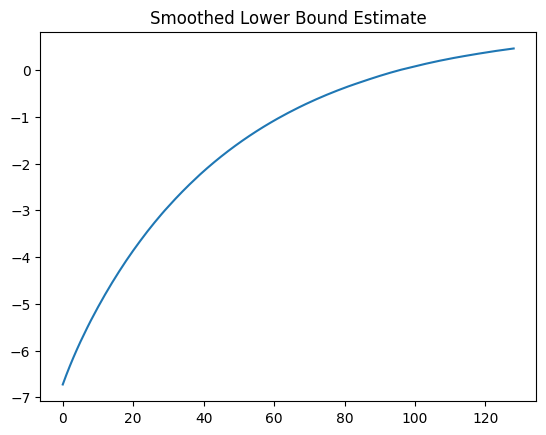

In [18]:
wass_smoothed_lb_df = pd.DataFrame(np.array(LB_Smoothed))
plt.figure()
wass_smoothed_lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

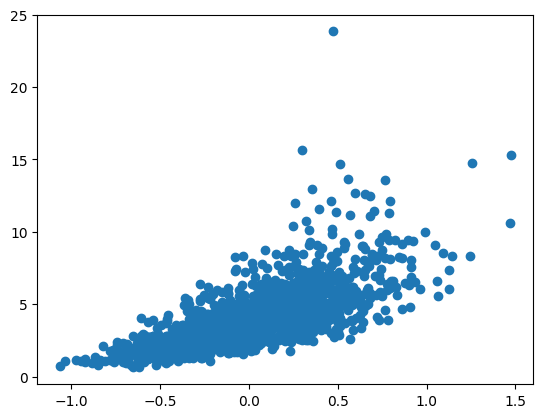

In [19]:
plt.scatter(original_train_summary_statistics[:,0], original_train_summary_statistics[:,1])

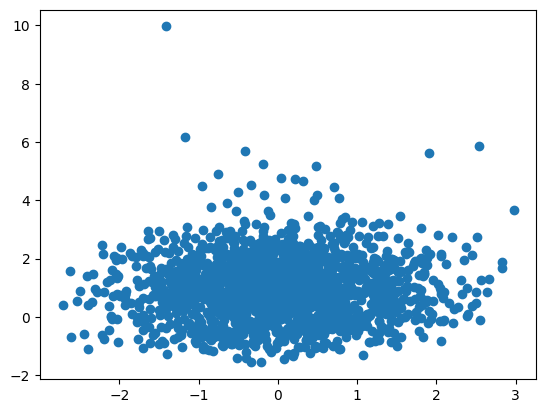

In [20]:
plt.scatter(wass_train_summary_statistics[:,0], wass_train_summary_statistics[:,1])

(array([168., 476., 417., 287., 159.,  71.,  40.,  22.,   7.,   8.,   4.,
          2.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.62632799,  1.78721726,  2.94810653,  4.10899591,  5.26988506,
         6.43077469,  7.59166384,  8.75255299,  9.91344261, 11.07433224,
        12.23522091, 13.39611053, 14.55700016, 15.71788883, 16.87877846,
        18.03966713, 19.20055771, 20.36144638, 21.52233505, 22.68322563,
        23.8441143 ]),
 <BarContainer object of 20 artists>)

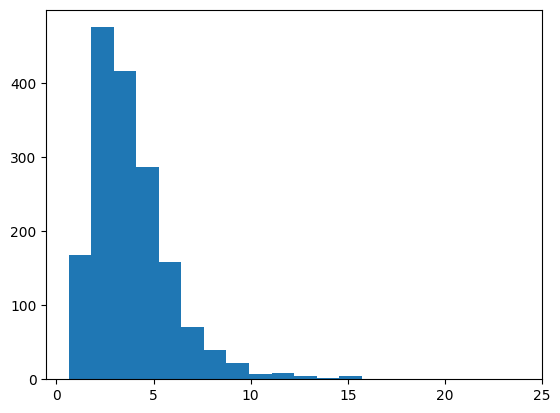

In [21]:
plt.hist(original_train_summary_statistics[:,1], bins = 20)

(array([ 38., 132., 219., 319., 361., 291., 186.,  72.,  25.,   8.,   7.,
          3.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-1.56900477, -0.99225831, -0.41551188,  0.16123459,  0.73798102,
         1.31472754,  1.89147389,  2.46822047,  3.04496694,  3.6217134 ,
         4.19845963,  4.77520609,  5.35195255,  5.92869902,  6.50544548,
         7.08219194,  7.65893841,  8.23568535,  8.81243134,  9.38917828,
         9.96592426]),
 <BarContainer object of 20 artists>)

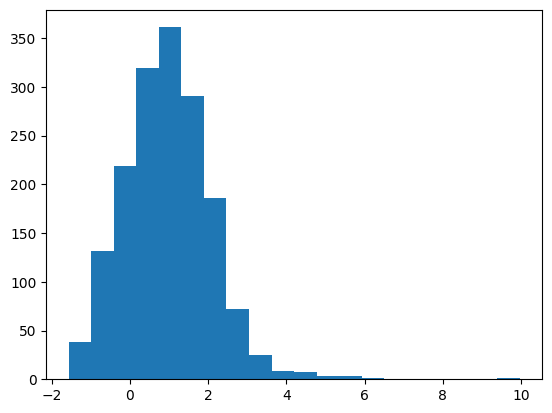

In [22]:
plt.hist(wass_train_summary_statistics[:,1], bins = 20)

In [23]:
mixture_obj_seq

[GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=4, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=3, reg_covar=1e-05),
 GaussianMixture(n_components=4, reg_covar=1e-05),
 GaussianMixture(n_components=3

In [24]:
def wasserstein_transform(mixture_obj_seq, n_summary_statistics):
    for i in range(len(mixture_obj_seq)):
        stepsize = eps
        mixture_obj = mixture_obj_seq[i]
        mean_mixture_obj = mixture_obj.means_
        sigma_mixture_obj = mixture_obj.covariances_
        weights_mixture_obj = mixture_obj.weights_
        grad_log_f = grad_log_density_mixture(n_summary_statistics, mean_mixture_obj, sigma_mixture_obj, weights_mixture_obj)[1]
        v = -n_summary_statistics-grad_log_f
        n_summary_statistics = n_summary_statistics + stepsize * v
    return n_summary_statistics

In [25]:
## Transform actual data
transformed_actual_summary_statistics = wasserstein_transform(mixture_obj_seq, jnp.reshape(actual_summary_statistics, (1, len(actual_summary_statistics))))
transformed_actual_summary_statistics

Array([[-0.19290778,  1.3018029 ]], dtype=float32)

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [26]:
def summary_statistics(theta, n_samples, n_datasets):
    datasets = normal_data(theta, n_samples, n_datasets)
    n_summary_statistics = jnp.array([normal_data_ss(datasets[i,:]) for i in range(n_datasets)])

    # Wasserstein transform
    transformed_summary_statistics = wasserstein_transform(mixture_obj_seq, n_summary_statistics)

    sample_mean = jnp.mean(transformed_summary_statistics, axis = 0)
    cov = jnp.cov(transformed_summary_statistics.T)
    sample_variance = cov + (jnp.eye(cov.shape[0]) * 5 * 1e-7)
    # print(sample_variance)

    return sample_mean, sample_variance

In [27]:
def mean_adjustment_summary_statistics(adjusted_theta, n_samples, n_datasets):
    theta = adjusted_theta[0:num_coeffs]
    Gamma = adjusted_theta[-num_latent:]
    sample_mean, sample_variance = summary_statistics(theta, n_samples, n_datasets)

    adjusted_sample_mean = sample_mean + jnp.diag(jnp.sqrt(sample_variance)) * Gamma
    return adjusted_sample_mean, sample_variance

In [28]:
@partial(jit, static_argnames=['sigma_theta','num_coeffs'])
def prior(theta, sigma_theta, num_coeffs):
    log_prior = multivariate_normal.logpdf(theta, mean = jnp.array([0] * num_coeffs), cov= sigma_theta * jnp.identity(num_coeffs))
    return log_prior

In [29]:
def mean_adjustment_unbiased_log_likelihood(gs_adjusted_theta, actual_summary_statistics, n_samples, num_datasets):
    mean_adjust_ss = mean_adjustment_summary_statistics(gs_adjusted_theta, n_samples, num_datasets)
    adjusted_sample_mean = mean_adjust_ss[0]
    sample_variance = mean_adjust_ss[1]
    u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = adjusted_sample_mean, cov= sample_variance)

    # diff_mean_s = actual_summary_statistics - adjusted_sample_mean
    # part1 = diff_mean_s.T @ jnp.linalg.solve(sample_variance, diff_mean_s)
    # u_est_log_likelihood = -1/2 * jnp.linalg.slogdet(sample_variance)[1] -1/2 * part1
    return u_est_log_likelihood

In [30]:
@jit
def nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance):
    nuissance_mean_u_est_log_likelihood = multivariate_normal.logpdf(Gamma, mean = mean_nuissance, cov= variance_nuissance)
    return nuissance_mean_u_est_log_likelihood

In [31]:
@jit
def fun_log_q(theta, mu, l):
    log_q = multivariate_normal.logpdf(theta, mean = mu, cov= jnp.linalg.solve((l @ l.T), jnp.eye((l @ l.T).shape[0])))
    # log_q = scipy.stats.multivariate_normal.logpdf(np.array(theta), mean = np.array(mu), cov= np.array(jnp.linalg.solve((l @ l.T), jnp.eye((l @ l.T).shape[0]))), allow_singular = True)

    return log_q

In [32]:
@partial(jit, static_argnames=['num_coeffs'])
def gradient_log_q(theta, mu, l, num_coeffs): #indep theta
    gradient_log_q_mu = l @ l.T @ (theta - mu)
    # gradient_log_q_l = (np.diag(np.linalg.inv(l)) - np.matmul(((np.reshape(theta - mu, (num_coeffs,1))) * theta - mu), l)).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar
    diag_inv_l = jnp.zeros_like(l, shape=(num_coeffs,num_coeffs)).at[jnp.diag_indices_from(l)].set(jnp.diag(l))
    gradient_log_q_l = (diag_inv_l - jnp.reshape(theta - mu, (num_coeffs,1)) @ jnp.reshape(theta - mu, (1,num_coeffs)) @ l).T[jnp.triu_indices(num_coeffs)] #use * because matmul gives scalar
    return gradient_log_q_mu, gradient_log_q_l

In [33]:
@jit
def control_variates(Flat_grad_log_q, Flat_grad_lb):
    c = []
    stacked_gradient_lb = jnp.stack(Flat_grad_lb)
    stacked_gradient_log_q = jnp.stack(Flat_grad_log_q)
    for i in range(lambda_dim):
        sample_cov = jnp.cov(stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i])
        c_i = sample_cov[0, 1] / sample_cov[1, 1]
        c.append(c_i)
    c_mu = jnp.array(c[0:num_coeffs])
    c_vech_l = jnp.array(c[num_coeffs:])
    return c_mu, c_vech_l

In [ ]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_coeffs = len(true_theta) # number of coeffs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_gradient_lb(self, theta_q, mu_q, l_q, c_mu, c_l, t):

        ss_q = summary_statistics(theta_q, n_samples, num_datasets)
        sample_mean_q = ss_q[0]
        sample_variance_q = ss_q[1]
        # Nuissance mean and variance
        mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(jnp.sqrt(sample_variance_q)).T @ jnp.linalg.solve(sample_variance_q, jnp.diag(jnp.sqrt(sample_variance_q)))
        mean_nuissance_p1_non_inv_unreg = mean_nuissance_p1_non_inv + (jnp.eye(mean_nuissance_p1_non_inv.shape[0]) * 5 * 1e-7)
        mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv_unreg, jnp.eye(mean_nuissance_p1_non_inv_unreg.shape[0]))
        # mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))

        diag_var = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_variance_q)].set(jnp.diag(jnp.sqrt(sample_variance_q)))
        diff_mean = self.actual_summary_statistics - sample_mean_q
        mean_nuissance_p2 = diag_var @ jnp.linalg.solve(sample_variance_q, diff_mean)
        mean_nuissance_q = mean_nuissance_p1 @ mean_nuissance_p2

        variance_nuissance_q = mean_nuissance_p1 + (jnp.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)
        # print(variance_nuissance_q)

        # Generate Gamma

        Gamma = random.multivariate_normal(subkeys1[t], mean = mean_nuissance_q, cov = variance_nuissance_q)
        adjusted_theta_q = jnp.concatenate((theta_q, Gamma))

        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(theta_q, self.actual_summary_statistics, n_samples, num_datasets)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_q, variance_nuissance_q)

        # print(llh)
        # print(llh_gamma)
        # print(prior(Gamma, sigma_latent, num_latent))

        h_lambda = prior(theta_q, sigma_theta, num_coeffs) + prior(Gamma, sigma_latent, num_latent) + llh - fun_log_q(theta_q, mu_q, l_q) - llh_gamma

        # Find gradient of LB
        grad_log_q_mu, grad_log_q_l = gradient_log_q(theta_q, mu_q, l_q, num_coeffs)
        gradient_lb_mu = grad_log_q_mu * (h_lambda - c_mu)
        gradient_lb_l = grad_log_q_l * (h_lambda - c_l)
        # Calculate control variates
        flattened_gradient_log_q = jnp.concatenate((grad_log_q_mu, grad_log_q_l), axis = None)
        flattened_gradient_lb = jnp.concatenate((gradient_lb_mu, gradient_lb_l), axis = None)

        return gradient_lb_mu, gradient_lb_l, h_lambda, flattened_gradient_log_q, flattened_gradient_lb

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = jnp.array([0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = jnp.tril(jnp.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = jnp.linalg.solve(Sigma_0_inv, jnp.eye(Sigma_0_inv.shape[0]))
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[jnp.triu_indices(self.num_coeffs)]

        # Initilize best lambda
        lambda_best_mu = mu_0
        lambda_best_l = vech_l0
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []

        func_auto = vmap(self.fun_gradient_lb, in_axes=[0, None, None, None, None, None])

        for t in tqdm(range(stop)):
            if t == 0:
                # Draw samples of theta from  variational q
                # List of gradients
                theta_0_samples = random.multivariate_normal(subkeys[t], mean = mu_0, cov = Sigma_0, shape = (self.samples,))
                gradient_lb_mu_0, gradient_lb_l_0, lb_0, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_0_samples, mu_0, l_0, 0, 0, t)
                # Calculate control variates using all samples
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_mu_init = jnp.mean(gradient_lb_mu_0, axis = 0)
                self.g_vech_l_init = jnp.mean(gradient_lb_l_0, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None)) > self.l_threshold:
                    self.g_mu_init = self.l_threshold * self.g_mu_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                    self.g_vech_l_init = self.l_threshold * self.g_vech_l_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                self.v_mu_init = self.g_mu_init ** 2
                self.v_vech_l_init = self.g_vech_l_init ** 2
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_0))
                print('LB', (jnp.mean(lb_0)))
                lambda_q_mu = mu_0
                lambda_q_l = vech_l0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q_mu

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q_l)
                l_q = jnp.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q = l_q.at[i:self.num_coeffs,i].set(vech_lq[:self.num_coeffs - i])
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  jnp.linalg.solve(Sigma_q_inv, jnp.eye(Sigma_q_inv.shape[0]))
                l_q_inv =  jnp.linalg.solve(l_q, jnp.eye(l_q.shape[0]))
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = random.multivariate_normal(subkeys[t], mean = mu_q, cov = Sigma_q, shape = (self.samples,))
                gradient_lb_mu, gradient_lb_l, lb_t, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_q_samples, mu_q, l_q, c_mu, c_vech_l, t)

                # Update control variates
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                g_mu_t = jnp.mean(gradient_lb_mu, axis = 0)
                g_vech_l_t = jnp.mean(gradient_lb_l, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None)) > self.l_threshold:
                    g_mu_t = self.l_threshold * g_mu_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                    g_vech_l_t = self.l_threshold * g_vech_l_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                v_mu_t = g_mu_t ** 2
                v_vech_l_t = g_vech_l_t ** 2
                #---- Update lambda
                self.g_mu_init = self.adaptive_lr_1 * self.g_mu_init + (1 - self.adaptive_lr_1) * g_mu_t
                self.g_vech_l_init = self.adaptive_lr_1 * self.g_vech_l_init + (1 - self.adaptive_lr_1) * g_vech_l_t

                self.v_mu_init = self.adaptive_lr_2 * self.v_mu_init + (1 - self.adaptive_lr_2) * v_mu_t
                self.v_vech_l_init = self.adaptive_lr_2 * self.v_vech_l_init + (1 - self.adaptive_lr_2) * v_vech_l_t

                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q_mu = lambda_q_mu + update_t * self.g_mu_init / (self.v_mu_init ** 0.5)
                lambda_q_l = lambda_q_l + update_t * self.g_vech_l_init / (self.v_vech_l_init ** 0.5)
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_t))

                if t < self.t_w:
                    print('LB', jnp.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = jnp.mean(jnp.array(LB_all[t - self.t_w + 1 : t]))
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
                        patience = 0
                        lambda_best_mu = lambda_q_mu
                        lambda_best_l = lambda_q_l
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best_mu, lambda_best_l

In [ ]:
# Set hyperparameters
stop = 4000

In [ ]:
ss = summary_statistics(0, 200,200)
sample_mean_q = ss[0]
sample_variance_q = ss[1]
sample_mean_q

Array([-0.11449257,  1.2132254 ], dtype=float32)

In [ ]:
jnp.diag(sample_variance_q)

Array([0.14466108, 0.16972859], dtype=float32)

In [ ]:
diag_var = jnp.zeros((np.shape(sample_variance_q)[0], np.shape(sample_variance_q)[0])).at[jnp.diag_indices_from(sample_variance_q)].set(jnp.diag(sample_variance_q))
diff_mean = actual_summary_statistics - sample_mean_q
mean_nuissance_p2 = diag_var @ jnp.linalg.solve(sample_variance_q, diff_mean)
mean_nuissance_p2

Array([ 2.2697225, 10.04348  ], dtype=float32)

In [ ]:
# diag_var = jnp.zeros((np.shape(sample_variance_q)[0], np.shape(sample_variance_q)[0])).at[jnp.diag_indices_from(sample_variance_q)].set(jnp.diag(sample_variance_q))
diff_mean = actual_summary_statistics - sample_mean_q
mean_nuissance_p2 = jnp.diag(sample_variance_q) @ jnp.linalg.solve(sample_variance_q, diff_mean)
mean_nuissance_p2

Array(12.313203, dtype=float32)

In [ ]:
mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(sample_variance_q).T @ jnp.linalg.solve(sample_variance_q, jnp.diag(sample_variance_q))
mean_nuissance_p1_non_inv_unreg = mean_nuissance_p1_non_inv + (jnp.eye(mean_nuissance_p1_non_inv.shape[0]) * 5 * 1e-7)
mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv_unreg, jnp.eye(mean_nuissance_p1_non_inv_unreg.shape[0]))
mean_nuissance_p1 #THIS??

Array([[0.7331643]], dtype=float32)

In [ ]:
mean_nuissance_p1_non_inv = jnp.identity(len_ss) / sigma_latent + diag_var.T @ jnp.linalg.solve(sample_variance_q, diag_var)
mean_nuissance_p1_non_inv_unreg = mean_nuissance_p1_non_inv + (jnp.eye(mean_nuissance_p1_non_inv.shape[0]) * 5 * 1e-7)
mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv_unreg, jnp.eye(mean_nuissance_p1_non_inv_unreg.shape[0]))
mean_nuissance_p1 #OR THISSS?

Array([[ 0.87183714, -0.01620033],
       [-0.01620033,  0.85285103]], dtype=float32)

In [ ]:
variance_nuissance_q = mean_nuissance_p1
variance_nuissance_q

Array([[ 0.87183714, -0.01620033],
       [-0.01620033,  0.85285103]], dtype=float32)

In [ ]:
mean_nuissance_q = mean_nuissance_p1 * mean_nuissance_p2
mean_nuissance_q

Array([[10.735107  , -0.19947791],
       [-0.19947796, 10.5013275 ]], dtype=float32)

In [ ]:
mu_0 = jnp.array([0])
#mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
# mu_0 = np.array([0] * self.num_coeffs)
l_0 = jnp.tril(jnp.identity(num_coeffs) * 10)
Sigma_0_inv = l_0 @ l_0.T
Sigma_0 = jnp.linalg.solve(Sigma_0_inv, jnp.eye(Sigma_0_inv.shape[0]))
theta_q = random.multivariate_normal(subkeys[t], mean = mu_0, cov = Sigma_0)
theta_q

Array([0.06153281], dtype=float32)

In [ ]:
Gamma = random.multivariate_normal(subkeys1[t], mean = mean_nuissance_q, cov = variance_nuissance_q)
Gamma[0]

Array([10.878193  ,  0.58957523], dtype=float32)

In [ ]:
jnp.concatenate((theta_q, Gamma[0]))

Array([ 0.06153281, 10.878193  ,  0.58957523], dtype=float32)

In [ ]:
vb = GVB(200, transformed_actual_summary_statistics[0], 0.001, 2500, 100, 0.9, 0.9, 150, 50)
LB_estimate, smoothed_LB_estimate, best_lambda_mu, best_lambda_l = vb.vb_posterior(stop)

  0%|          | 1/4000 [00:25<28:15:23, 25.44s/it]

LB -5.9793234


  0%|          | 2/4000 [00:44<23:47:32, 21.42s/it]

LB -6.047739


  0%|          | 3/4000 [01:03<22:39:56, 20.41s/it]

LB -4.804639


  0%|          | 4/4000 [01:22<22:09:54, 19.97s/it]

LB -6.928836


  0%|          | 5/4000 [01:45<23:18:24, 21.00s/it]

LB -4.9310527


  0%|          | 6/4000 [02:07<23:47:57, 21.45s/it]

LB -7.294776


  0%|          | 7/4000 [02:26<22:50:27, 20.59s/it]

LB -4.937969


  0%|          | 8/4000 [02:46<22:38:44, 20.42s/it]

LB -7.6011605


  0%|          | 9/4000 [03:05<22:16:42, 20.10s/it]

LB -4.7461314


  0%|          | 10/4000 [03:25<21:58:24, 19.83s/it]

LB -6.600403


  0%|          | 11/4000 [03:44<21:40:54, 19.57s/it]

LB -7.599232


  0%|          | 12/4000 [04:02<21:20:27, 19.26s/it]

LB -7.7946715


  0%|          | 13/4000 [04:21<21:18:57, 19.25s/it]

LB -6.581123


  0%|          | 14/4000 [04:40<20:55:15, 18.89s/it]

LB -6.467581


  0%|          | 15/4000 [04:59<21:01:35, 19.00s/it]

LB -7.5877056


  0%|          | 16/4000 [05:18<21:05:44, 19.06s/it]

LB -8.526752


  0%|          | 17/4000 [05:37<21:06:23, 19.08s/it]

LB -8.362951


  0%|          | 18/4000 [05:56<21:08:03, 19.11s/it]

LB -4.896131


  0%|          | 19/4000 [06:15<20:50:37, 18.85s/it]

LB -6.6846433


  0%|          | 20/4000 [06:34<20:53:23, 18.90s/it]

LB -5.4165955


  1%|          | 21/4000 [06:51<20:33:28, 18.60s/it]

LB -7.5548453


  1%|          | 22/4000 [07:11<20:43:09, 18.75s/it]

LB -4.935764


  1%|          | 23/4000 [07:29<20:34:13, 18.62s/it]

LB -7.037603


  1%|          | 24/4000 [07:48<20:46:17, 18.81s/it]

LB -6.1861033


  1%|          | 25/4000 [08:08<21:11:48, 19.20s/it]

LB -6.6050353


  1%|          | 26/4000 [08:26<20:51:17, 18.89s/it]

LB -7.4344006


  1%|          | 27/4000 [08:45<20:54:35, 18.95s/it]

LB -7.014446


  1%|          | 28/4000 [09:04<20:37:25, 18.69s/it]

LB -4.953051


  1%|          | 29/4000 [09:23<20:43:26, 18.79s/it]

LB -5.101448


  1%|          | 30/4000 [09:41<20:32:41, 18.63s/it]

LB -9.36279


  1%|          | 31/4000 [10:00<20:43:34, 18.80s/it]

LB -6.49967


  1%|          | 32/4000 [10:18<20:30:04, 18.60s/it]

LB -7.227792


  1%|          | 33/4000 [10:37<20:34:26, 18.67s/it]

LB -5.178745


  1%|          | 34/4000 [10:57<21:00:39, 19.07s/it]

LB -7.383138


  1%|          | 35/4000 [11:15<20:41:27, 18.79s/it]

LB -6.808393


  1%|          | 36/4000 [11:34<20:47:29, 18.88s/it]

LB -5.644911


  1%|          | 37/4000 [11:52<20:27:40, 18.59s/it]

LB -6.9337425


  1%|          | 38/4000 [12:11<20:36:54, 18.73s/it]

LB -6.8320885


  1%|          | 39/4000 [12:29<20:25:16, 18.56s/it]

LB -6.002133


  1%|          | 40/4000 [12:48<20:35:41, 18.72s/it]

LB -5.1333356


  1%|          | 41/4000 [13:07<20:41:19, 18.81s/it]

LB -5.0735273


  1%|          | 42/4000 [13:26<20:33:58, 18.71s/it]

LB -6.525655


  1%|          | 43/4000 [13:45<20:49:56, 18.95s/it]

LB -6.141666


  1%|          | 44/4000 [14:03<20:30:32, 18.66s/it]

LB -5.6212516


  1%|          | 45/4000 [14:22<20:37:00, 18.77s/it]

LB -7.8664184


  1%|          | 46/4000 [14:40<20:22:19, 18.55s/it]

LB -8.703661


  1%|          | 47/4000 [15:00<20:31:54, 18.70s/it]

LB -6.832695


  1%|          | 48/4000 [15:18<20:31:48, 18.70s/it]

LB -6.8927507


  1%|          | 49/4000 [15:37<20:25:38, 18.61s/it]

LB -5.2731466


  1%|▏         | 50/4000 [15:56<20:33:38, 18.74s/it]

LB -7.3073874


  1%|▏         | 51/4000 [16:15<20:41:20, 18.86s/it]

LB -7.2959986


  1%|▏         | 52/4000 [16:34<20:45:43, 18.93s/it]

LB -6.9880457


  1%|▏         | 53/4000 [16:52<20:29:10, 18.69s/it]

LB -6.422733


  1%|▏         | 54/4000 [17:11<20:37:40, 18.82s/it]

LB -6.488076


  1%|▏         | 55/4000 [17:30<20:43:52, 18.92s/it]

LB -5.9369736


  1%|▏         | 56/4000 [17:49<20:32:38, 18.75s/it]

LB -6.693174


  1%|▏         | 57/4000 [18:08<20:39:16, 18.86s/it]

LB -7.1693344


  1%|▏         | 58/4000 [18:26<20:19:39, 18.56s/it]

LB -5.5286827


  1%|▏         | 59/4000 [18:45<20:31:06, 18.74s/it]

LB -7.94217


  2%|▏         | 60/4000 [19:04<20:37:06, 18.84s/it]

LB -6.7271886


  2%|▏         | 61/4000 [19:23<20:37:57, 18.86s/it]

LB -6.2075047


  2%|▏         | 62/4000 [19:42<20:42:33, 18.93s/it]

LB -5.720593


  2%|▏         | 63/4000 [20:00<20:28:00, 18.71s/it]

LB -6.087174


  2%|▏         | 64/4000 [20:19<20:33:23, 18.80s/it]

LB -6.7834735


  2%|▏         | 65/4000 [20:37<20:17:07, 18.56s/it]

LB -7.142953


  2%|▏         | 66/4000 [20:56<20:25:29, 18.69s/it]

LB -6.5711913


  2%|▏         | 67/4000 [21:14<20:14:35, 18.53s/it]

LB -4.891961


  2%|▏         | 68/4000 [21:33<20:25:11, 18.70s/it]

LB -7.661683


  2%|▏         | 69/4000 [21:53<20:48:31, 19.06s/it]

LB -6.244782


  2%|▏         | 70/4000 [22:12<20:33:01, 18.82s/it]

LB -5.8717976


  2%|▏         | 71/4000 [22:30<20:34:05, 18.85s/it]

LB -5.0124803


  2%|▏         | 72/4000 [22:48<20:15:40, 18.57s/it]

LB -7.7955003


  2%|▏         | 73/4000 [23:07<20:26:24, 18.74s/it]

LB -7.649094


  2%|▏         | 74/4000 [23:25<20:11:04, 18.51s/it]

LB -6.367402


  2%|▏         | 75/4000 [23:45<20:24:28, 18.72s/it]

LB -5.6906285


  2%|▏         | 76/4000 [24:03<20:12:51, 18.55s/it]

LB -6.666575


  2%|▏         | 77/4000 [24:22<20:19:48, 18.66s/it]

LB -6.4509435


  2%|▏         | 78/4000 [24:42<20:44:19, 19.04s/it]

LB -5.898456


  2%|▏         | 79/4000 [25:00<20:27:42, 18.79s/it]

LB -7.455257


  2%|▏         | 80/4000 [25:19<20:32:53, 18.87s/it]

LB -6.0280237


  2%|▏         | 81/4000 [25:37<20:20:10, 18.68s/it]

LB -5.6233463


  2%|▏         | 82/4000 [25:56<20:31:07, 18.85s/it]

LB -6.1594787


  2%|▏         | 83/4000 [26:15<20:20:05, 18.69s/it]

LB -5.354964


  2%|▏         | 84/4000 [26:33<20:20:31, 18.70s/it]

LB -6.058302


  2%|▏         | 85/4000 [26:52<20:27:25, 18.81s/it]

LB -6.331055


  2%|▏         | 86/4000 [27:11<20:14:35, 18.62s/it]

LB -5.2413635


  2%|▏         | 87/4000 [27:31<20:43:43, 19.07s/it]

LB -6.571801


  2%|▏         | 88/4000 [27:49<20:27:20, 18.82s/it]

LB -7.1761093


  2%|▏         | 89/4000 [28:08<20:33:00, 18.92s/it]

LB -4.692311


  2%|▏         | 90/4000 [28:27<20:33:59, 18.94s/it]

LB -5.8246226


  2%|▏         | 91/4000 [28:46<20:22:13, 18.76s/it]

LB -5.340904


  2%|▏         | 92/4000 [29:05<20:29:52, 18.88s/it]

LB -7.5637717


  2%|▏         | 93/4000 [29:23<20:12:11, 18.62s/it]

LB -5.3015375


  2%|▏         | 94/4000 [29:42<20:21:08, 18.76s/it]

LB -5.393851


  2%|▏         | 95/4000 [30:00<20:11:19, 18.61s/it]

LB -4.977052


  2%|▏         | 96/4000 [30:20<20:39:03, 19.04s/it]

LB -5.0480375


  2%|▏         | 97/4000 [30:39<20:39:41, 19.06s/it]

LB -8.058609


  2%|▏         | 98/4000 [30:57<20:21:46, 18.79s/it]

LB -5.0009317


  2%|▏         | 99/4000 [31:16<20:27:28, 18.88s/it]

LB -5.3373833


  2%|▎         | 100/4000 [31:35<20:12:03, 18.65s/it]

LB -6.300289


  3%|▎         | 101/4000 [31:54<20:23:14, 18.82s/it]

LB -6.549775


  3%|▎         | 102/4000 [32:12<20:09:43, 18.62s/it]

LB -5.571701


  3%|▎         | 103/4000 [32:31<20:18:57, 18.77s/it]

LB -5.7855625


  3%|▎         | 104/4000 [32:50<20:23:56, 18.85s/it]

LB -7.5038743


  3%|▎         | 105/4000 [33:09<20:28:42, 18.93s/it]

LB -5.7499475


  3%|▎         | 106/4000 [33:28<20:31:06, 18.97s/it]

LB -7.1414385


  3%|▎         | 107/4000 [33:46<20:13:03, 18.70s/it]

LB -5.3190665


  3%|▎         | 108/4000 [34:05<20:20:28, 18.82s/it]

LB -5.6729636


  3%|▎         | 109/4000 [34:24<20:08:30, 18.64s/it]

LB -6.0599594


  3%|▎         | 110/4000 [34:43<20:14:59, 18.74s/it]

LB -5.058344


  3%|▎         | 111/4000 [35:02<20:18:57, 18.81s/it]

LB -6.4995933


  3%|▎         | 112/4000 [35:20<20:07:02, 18.63s/it]

LB -7.421498


  3%|▎         | 113/4000 [35:39<20:17:00, 18.79s/it]

LB -6.914806


  3%|▎         | 114/4000 [35:58<20:24:26, 18.91s/it]

LB -7.427539


  3%|▎         | 115/4000 [36:17<20:26:15, 18.94s/it]

LB -7.2220545


  3%|▎         | 116/4000 [36:35<20:11:55, 18.72s/it]

LB -7.6840568


  3%|▎         | 117/4000 [36:54<20:11:12, 18.72s/it]

LB -5.35927


  3%|▎         | 118/4000 [37:13<20:16:39, 18.80s/it]

LB -6.9052405


  3%|▎         | 119/4000 [37:31<20:04:53, 18.63s/it]

LB -5.4844117


  3%|▎         | 120/4000 [37:50<20:14:15, 18.78s/it]

LB -6.1399755


  3%|▎         | 121/4000 [38:08<19:58:44, 18.54s/it]

LB -5.5919223


  3%|▎         | 122/4000 [38:27<20:08:32, 18.70s/it]

LB -5.251546


  3%|▎         | 123/4000 [38:47<20:24:38, 18.95s/it]

LB -5.585656


  3%|▎         | 124/4000 [39:05<20:14:01, 18.79s/it]

LB -5.675257


  3%|▎         | 125/4000 [39:24<20:19:20, 18.88s/it]

LB -6.9851694


  3%|▎         | 126/4000 [39:43<20:05:35, 18.67s/it]

LB -7.3143835


  3%|▎         | 127/4000 [40:02<20:15:25, 18.83s/it]

LB -5.716412


  3%|▎         | 128/4000 [40:20<20:00:52, 18.61s/it]

LB -6.7871237


  3%|▎         | 129/4000 [40:39<20:10:29, 18.76s/it]

LB -5.7642345


  3%|▎         | 130/4000 [40:57<20:00:53, 18.62s/it]

LB -6.0002484


  3%|▎         | 131/4000 [41:16<20:06:45, 18.71s/it]

LB -5.3557477


  3%|▎         | 132/4000 [41:36<20:30:19, 19.08s/it]

LB -6.2510095


  3%|▎         | 133/4000 [41:54<20:10:07, 18.78s/it]

LB -7.423004


  3%|▎         | 134/4000 [42:13<20:17:17, 18.89s/it]

LB -5.096405


  3%|▎         | 135/4000 [42:32<20:04:35, 18.70s/it]

LB -5.8988914


  3%|▎         | 136/4000 [42:51<20:09:30, 18.78s/it]

LB -7.8780704


  3%|▎         | 137/4000 [43:09<19:58:43, 18.62s/it]

LB -4.9429636


  3%|▎         | 138/4000 [43:28<20:04:41, 18.72s/it]

LB -7.3101506


  3%|▎         | 139/4000 [43:47<20:10:06, 18.81s/it]

LB -6.493697


  4%|▎         | 140/4000 [44:05<19:58:30, 18.63s/it]

LB -5.705136


  4%|▎         | 141/4000 [44:25<20:22:34, 19.01s/it]

LB -7.376029


  4%|▎         | 142/4000 [44:43<20:09:28, 18.81s/it]

LB -7.173173


  4%|▎         | 143/4000 [45:02<20:14:31, 18.89s/it]

LB -6.6095157


  4%|▎         | 144/4000 [45:20<19:58:08, 18.64s/it]

LB -4.564087


  4%|▎         | 145/4000 [45:40<20:05:07, 18.76s/it]

LB -5.9799414


  4%|▎         | 146/4000 [45:59<20:12:22, 18.87s/it]

LB -5.1138597


  4%|▎         | 147/4000 [46:17<20:00:25, 18.69s/it]

LB -6.7550817


  4%|▎         | 148/4000 [46:36<20:07:02, 18.80s/it]

LB -5.4606233


  4%|▎         | 149/4000 [46:54<19:50:37, 18.55s/it]

LB -7.4326468


  4%|▍         | 150/4000 [47:14<20:16:07, 18.95s/it]

LB -5.8193736


  4%|▍         | 151/4000 [47:32<20:03:19, 18.76s/it]

LB Smoothed -6.3450046


  4%|▍         | 152/4000 [47:51<20:05:28, 18.80s/it]

LB Smoothed -6.346919


  4%|▍         | 153/4000 [48:10<20:14:41, 18.95s/it]

LB Smoothed -6.3495936


  4%|▍         | 154/4000 [48:29<20:05:15, 18.80s/it]

LB Smoothed -6.339102


  4%|▍         | 155/4000 [48:48<20:10:25, 18.89s/it]

LB Smoothed -6.351746


  4%|▍         | 156/4000 [49:06<20:01:10, 18.75s/it]

LB Smoothed -6.3347683


  4%|▍         | 157/4000 [49:26<20:11:53, 18.92s/it]

LB Smoothed -6.3422


  4%|▍         | 158/4000 [49:44<20:05:17, 18.82s/it]

LB Smoothed -6.3311057


  4%|▍         | 159/4000 [50:04<20:18:59, 19.04s/it]

LB Smoothed -6.3439317


  4%|▍         | 160/4000 [50:23<20:23:15, 19.11s/it]

LB Smoothed -6.355124


  4%|▍         | 161/4000 [50:41<20:05:50, 18.85s/it]

LB Smoothed -6.345481


  4%|▍         | 162/4000 [51:00<20:10:01, 18.92s/it]

LB Smoothed -6.338869


  4%|▍         | 163/4000 [51:18<19:52:00, 18.64s/it]

LB Smoothed -6.339065


  4%|▍         | 164/4000 [51:38<20:03:11, 18.82s/it]

LB Smoothed -6.321201


  4%|▍         | 165/4000 [51:56<19:50:56, 18.63s/it]

LB Smoothed -6.3014326


  4%|▍         | 166/4000 [52:15<20:01:32, 18.80s/it]

LB Smoothed -6.2877474


  4%|▍         | 167/4000 [52:34<20:08:55, 18.92s/it]

LB Smoothed -6.275609


  4%|▍         | 168/4000 [52:53<20:12:06, 18.98s/it]

LB Smoothed -6.283923


  4%|▍         | 169/4000 [53:12<20:14:15, 19.02s/it]

LB Smoothed -6.2804494


  4%|▍         | 170/4000 [53:31<19:57:40, 18.76s/it]

LB Smoothed -6.2891426


  4%|▍         | 171/4000 [53:50<20:03:46, 18.86s/it]

LB Smoothed -6.2825108


  4%|▍         | 172/4000 [54:08<19:51:03, 18.67s/it]

LB Smoothed -6.283411


  4%|▍         | 173/4000 [54:27<19:56:31, 18.76s/it]

LB Smoothed -6.264594


  4%|▍         | 174/4000 [54:46<20:03:30, 18.87s/it]

LB Smoothed -6.2726254


  4%|▍         | 175/4000 [55:04<19:50:30, 18.67s/it]

LB Smoothed -6.255777


  4%|▍         | 176/4000 [55:23<20:00:37, 18.84s/it]

LB Smoothed -6.250796


  4%|▍         | 177/4000 [55:43<20:05:30, 18.92s/it]

LB Smoothed -6.241664


  4%|▍         | 178/4000 [56:02<20:10:38, 19.01s/it]

LB Smoothed -6.2621126


  4%|▍         | 179/4000 [56:20<20:01:24, 18.87s/it]

LB Smoothed -6.2546415


  4%|▍         | 180/4000 [56:39<19:53:32, 18.75s/it]

LB Smoothed -6.2450113


  5%|▍         | 181/4000 [56:58<20:00:26, 18.86s/it]

LB Smoothed -6.2444243


  5%|▍         | 182/4000 [57:16<19:47:34, 18.66s/it]

LB Smoothed -6.2369432


  5%|▍         | 183/4000 [57:35<19:57:13, 18.82s/it]

LB Smoothed -6.2490816


  5%|▍         | 184/4000 [57:54<19:47:08, 18.67s/it]

LB Smoothed -6.2457104


  5%|▍         | 185/4000 [58:13<19:56:25, 18.82s/it]

LB Smoothed -6.2434387


  5%|▍         | 186/4000 [58:32<20:01:59, 18.91s/it]

LB Smoothed -6.2468433


  5%|▍         | 187/4000 [58:51<20:03:58, 18.95s/it]

LB Smoothed -6.242598


  5%|▍         | 188/4000 [59:10<20:05:27, 18.97s/it]

LB Smoothed -6.231563


  5%|▍         | 189/4000 [59:28<19:49:02, 18.72s/it]

LB Smoothed -6.2282395


  5%|▍         | 190/4000 [59:47<19:56:46, 18.85s/it]

LB Smoothed -6.2357044


  5%|▍         | 191/4000 [1:00:05<19:39:14, 18.58s/it]

LB Smoothed -6.2437263


  5%|▍         | 192/4000 [1:00:24<19:47:34, 18.71s/it]

LB Smoothed -6.2236977


  5%|▍         | 193/4000 [1:00:42<19:38:57, 18.58s/it]

LB Smoothed -6.217339


  5%|▍         | 194/4000 [1:01:02<19:49:21, 18.75s/it]

LB Smoothed -6.207565


  5%|▍         | 195/4000 [1:01:21<20:10:31, 19.09s/it]

LB Smoothed -6.191428


  5%|▍         | 196/4000 [1:01:40<19:54:35, 18.84s/it]

LB Smoothed -6.1751175


  5%|▍         | 197/4000 [1:01:59<20:00:48, 18.95s/it]

LB Smoothed -6.1664367


  5%|▍         | 198/4000 [1:02:17<19:45:30, 18.71s/it]

LB Smoothed -6.1673427


  5%|▍         | 199/4000 [1:02:36<19:52:52, 18.83s/it]

LB Smoothed -6.169153


  5%|▌         | 200/4000 [1:02:54<19:39:34, 18.62s/it]

LB Smoothed -6.161173


  5%|▌         | 201/4000 [1:03:13<19:42:54, 18.68s/it]

LB Smoothed -6.1551294


  5%|▌         | 202/4000 [1:03:32<19:50:42, 18.81s/it]

LB Smoothed -6.141165


  5%|▌         | 203/4000 [1:03:51<19:40:57, 18.66s/it]

LB Smoothed -6.1290283


  5%|▌         | 204/4000 [1:04:11<20:08:22, 19.10s/it]

LB Smoothed -6.126406


  5%|▌         | 205/4000 [1:04:29<19:51:27, 18.84s/it]

LB Smoothed -6.13301


  5%|▌         | 206/4000 [1:04:48<19:54:28, 18.89s/it]

LB Smoothed -6.131297


  5%|▌         | 207/4000 [1:05:07<19:54:38, 18.90s/it]

LB Smoothed -6.12302


  5%|▌         | 208/4000 [1:05:25<19:43:39, 18.73s/it]

LB Smoothed -6.1124315


  5%|▌         | 209/4000 [1:05:44<19:50:31, 18.84s/it]

LB Smoothed -6.094056


  5%|▌         | 210/4000 [1:06:03<19:37:55, 18.65s/it]

LB Smoothed -6.06056


  5%|▌         | 211/4000 [1:06:22<19:47:25, 18.80s/it]

LB Smoothed -6.0563207


  5%|▌         | 212/4000 [1:06:40<19:35:51, 18.62s/it]

LB Smoothed -6.060598


  5%|▌         | 213/4000 [1:07:00<20:02:15, 19.05s/it]

LB Smoothed -6.0608516


  5%|▌         | 214/4000 [1:07:19<20:03:03, 19.07s/it]

LB Smoothed -6.057991


  5%|▌         | 215/4000 [1:07:37<19:48:45, 18.84s/it]

LB Smoothed -6.0501432


  5%|▌         | 216/4000 [1:07:56<19:51:55, 18.90s/it]

LB Smoothed -6.0471525


  5%|▌         | 217/4000 [1:08:14<19:33:48, 18.62s/it]

LB Smoothed -6.0502424


  5%|▌         | 218/4000 [1:08:34<19:44:29, 18.79s/it]

LB Smoothed -6.0319285


  5%|▌         | 219/4000 [1:08:52<19:36:44, 18.67s/it]

LB Smoothed -6.0281157


  6%|▌         | 220/4000 [1:09:11<19:44:51, 18.81s/it]

LB Smoothed -6.0247083


  6%|▌         | 221/4000 [1:09:30<19:40:29, 18.74s/it]

LB Smoothed -6.025011


  6%|▌         | 222/4000 [1:09:48<19:33:39, 18.64s/it]

LB Smoothed -5.9923434


  6%|▌         | 223/4000 [1:10:08<20:01:46, 19.09s/it]

LB Smoothed -5.9804587


  6%|▌         | 224/4000 [1:10:26<19:38:37, 18.73s/it]

LB Smoothed -5.975038


  6%|▌         | 225/4000 [1:10:45<19:46:26, 18.86s/it]

LB Smoothed -5.9776015


  6%|▌         | 226/4000 [1:11:03<19:34:48, 18.68s/it]

LB Smoothed -5.974744


  6%|▌         | 227/4000 [1:11:23<19:43:33, 18.82s/it]

LB Smoothed -5.973207


  6%|▌         | 228/4000 [1:11:42<19:51:28, 18.95s/it]

LB Smoothed -5.9655895


  6%|▌         | 229/4000 [1:12:00<19:39:51, 18.77s/it]

LB Smoothed -5.9566607


  6%|▌         | 230/4000 [1:12:19<19:43:49, 18.84s/it]

LB Smoothed -5.9531894


  6%|▌         | 231/4000 [1:12:37<19:28:08, 18.60s/it]

LB Smoothed -5.951629


  6%|▌         | 232/4000 [1:12:57<19:53:07, 19.00s/it]

LB Smoothed -5.9577103


  6%|▌         | 233/4000 [1:13:15<19:38:36, 18.77s/it]

LB Smoothed -5.9594927


  6%|▌         | 234/4000 [1:13:34<19:42:50, 18.85s/it]

LB Smoothed -5.9402013


  6%|▌         | 235/4000 [1:13:54<19:48:14, 18.94s/it]

LB Smoothed -5.941494


  6%|▌         | 236/4000 [1:14:12<19:36:00, 18.75s/it]

LB Smoothed -5.937501


  6%|▌         | 237/4000 [1:14:31<19:40:57, 18.83s/it]

LB Smoothed -5.925026


  6%|▌         | 238/4000 [1:14:49<19:27:17, 18.62s/it]

LB Smoothed -5.909287


  6%|▌         | 239/4000 [1:15:08<19:34:15, 18.73s/it]

LB Smoothed -5.9226813


  6%|▌         | 240/4000 [1:15:26<19:25:14, 18.59s/it]

LB Smoothed -5.929242


  6%|▌         | 241/4000 [1:15:46<19:49:14, 18.98s/it]

LB Smoothed -5.9370055


  6%|▌         | 242/4000 [1:16:05<19:54:05, 19.06s/it]

LB Smoothed -5.926317


  6%|▌         | 243/4000 [1:16:24<19:37:13, 18.80s/it]

LB Smoothed -5.921772


  6%|▌         | 244/4000 [1:16:43<19:42:28, 18.89s/it]

LB Smoothed -5.928761


  6%|▌         | 245/4000 [1:17:01<19:31:02, 18.71s/it]

LB Smoothed -5.937885


  6%|▌         | 246/4000 [1:17:20<19:38:00, 18.83s/it]

LB Smoothed -5.949428


  6%|▌         | 247/4000 [1:17:39<19:28:29, 18.68s/it]

LB Smoothed -5.937116


  6%|▌         | 248/4000 [1:17:57<19:32:39, 18.75s/it]

LB Smoothed -5.9508524


  6%|▌         | 249/4000 [1:18:17<19:39:00, 18.86s/it]

LB Smoothed -5.952269


  6%|▋         | 250/4000 [1:18:36<19:43:50, 18.94s/it]

LB Smoothed -5.9494596


  6%|▋         | 251/4000 [1:18:55<19:48:24, 19.02s/it]

LB Smoothed -5.9401846


  6%|▋         | 252/4000 [1:19:13<19:32:29, 18.77s/it]

LB Smoothed -5.943124


  6%|▋         | 253/4000 [1:19:32<19:38:52, 18.88s/it]

LB Smoothed -5.9459934


  6%|▋         | 254/4000 [1:19:51<19:45:37, 18.99s/it]

LB Smoothed -5.9347434


  6%|▋         | 255/4000 [1:20:10<19:33:06, 18.79s/it]

LB Smoothed -5.9262156


  6%|▋         | 256/4000 [1:20:29<19:39:57, 18.91s/it]

LB Smoothed -5.910162


  6%|▋         | 257/4000 [1:20:47<19:23:22, 18.65s/it]

LB Smoothed -5.9126515


  6%|▋         | 258/4000 [1:21:06<19:32:41, 18.80s/it]

LB Smoothed -5.9186373


  6%|▋         | 259/4000 [1:21:26<19:44:12, 18.99s/it]

LB Smoothed -5.9139557


  6%|▋         | 260/4000 [1:21:44<19:39:28, 18.92s/it]

LB Smoothed -5.9127164


  7%|▋         | 261/4000 [1:22:04<19:46:27, 19.04s/it]

LB Smoothed -5.898309


  7%|▋         | 262/4000 [1:22:22<19:33:25, 18.84s/it]

LB Smoothed -5.892528


  7%|▋         | 263/4000 [1:22:41<19:41:41, 18.97s/it]

LB Smoothed -5.885799


  7%|▋         | 264/4000 [1:23:00<19:31:31, 18.81s/it]

LB Smoothed -5.870993


  7%|▋         | 265/4000 [1:23:19<19:39:55, 18.95s/it]

LB Smoothed -5.859352


  7%|▋         | 266/4000 [1:23:38<19:47:12, 19.08s/it]

LB Smoothed -5.855354


  7%|▋         | 267/4000 [1:23:57<19:34:33, 18.88s/it]

LB Smoothed -5.848029


  7%|▋         | 268/4000 [1:24:17<19:57:58, 19.26s/it]

LB Smoothed -5.8426704


  7%|▋         | 269/4000 [1:24:35<19:41:54, 19.01s/it]

LB Smoothed -5.8447065


  7%|▋         | 270/4000 [1:24:55<19:46:29, 19.09s/it]

LB Smoothed -5.841246


  7%|▋         | 271/4000 [1:25:14<19:44:37, 19.06s/it]

LB Smoothed -5.8492737


  7%|▋         | 272/4000 [1:25:32<19:30:47, 18.84s/it]

LB Smoothed -5.8616176


  7%|▋         | 273/4000 [1:25:51<19:34:45, 18.91s/it]

LB Smoothed -5.8617373


  7%|▋         | 274/4000 [1:26:09<19:19:52, 18.68s/it]

LB Smoothed -5.8646536


  7%|▋         | 275/4000 [1:26:28<19:30:46, 18.86s/it]

LB Smoothed -5.86562


  7%|▋         | 276/4000 [1:26:47<19:19:04, 18.67s/it]

LB Smoothed -5.8583765


  7%|▋         | 277/4000 [1:27:06<19:27:03, 18.81s/it]

LB Smoothed -5.863759


  7%|▋         | 278/4000 [1:27:26<19:50:52, 19.20s/it]

LB Smoothed -5.851762


  7%|▋         | 279/4000 [1:27:44<19:33:47, 18.93s/it]

LB Smoothed -5.822858


  7%|▋         | 280/4000 [1:28:03<19:35:54, 18.97s/it]

LB Smoothed -5.8188233


  7%|▋         | 281/4000 [1:28:21<19:21:00, 18.73s/it]

LB Smoothed -5.821928


  7%|▋         | 282/4000 [1:28:41<19:29:44, 18.88s/it]

LB Smoothed -5.8197536


  7%|▋         | 283/4000 [1:28:59<19:19:02, 18.71s/it]

LB Smoothed -5.809267


  7%|▋         | 284/4000 [1:29:18<19:22:10, 18.76s/it]

LB Smoothed -5.8127446


  7%|▋         | 285/4000 [1:29:37<19:29:47, 18.89s/it]

LB Smoothed -5.80295


  7%|▋         | 286/4000 [1:29:55<19:18:35, 18.72s/it]

LB Smoothed -5.789567


  7%|▋         | 287/4000 [1:30:15<19:39:25, 19.06s/it]

LB Smoothed -5.7947564


  7%|▋         | 288/4000 [1:30:33<19:21:38, 18.78s/it]

LB Smoothed -5.778522


  7%|▋         | 289/4000 [1:30:53<19:29:15, 18.90s/it]

LB Smoothed -5.7624784


  7%|▋         | 290/4000 [1:31:11<19:16:38, 18.71s/it]

LB Smoothed -5.7617445


  7%|▋         | 291/4000 [1:31:30<19:23:27, 18.82s/it]

LB Smoothed -5.753087


  7%|▋         | 292/4000 [1:31:49<19:28:47, 18.91s/it]

LB Smoothed -5.74369


  7%|▋         | 293/4000 [1:32:07<19:15:53, 18.71s/it]

LB Smoothed -5.74266


  7%|▋         | 294/4000 [1:32:26<19:22:19, 18.82s/it]

LB Smoothed -5.7530694


  7%|▋         | 295/4000 [1:32:44<19:07:58, 18.59s/it]

LB Smoothed -5.7473516


  7%|▋         | 296/4000 [1:33:04<19:34:52, 19.03s/it]

LB Smoothed -5.7544556


  7%|▋         | 297/4000 [1:33:23<19:28:49, 18.94s/it]

LB Smoothed -5.744284


  7%|▋         | 298/4000 [1:33:42<19:21:32, 18.83s/it]

LB Smoothed -5.7508535


  7%|▋         | 299/4000 [1:34:01<19:27:27, 18.93s/it]

LB Smoothed -5.7411385


  8%|▊         | 300/4000 [1:34:19<19:14:59, 18.73s/it]

LB Smoothed -5.7419043


  8%|▊         | 301/4000 [1:34:38<19:20:44, 18.83s/it]

LB Smoothed -5.7367215


  8%|▊         | 302/4000 [1:34:56<19:07:54, 18.62s/it]

LB Smoothed -5.7359023


  8%|▊         | 303/4000 [1:35:16<19:17:41, 18.79s/it]

LB Smoothed -5.735045


  8%|▊         | 304/4000 [1:35:34<19:07:24, 18.63s/it]

LB Smoothed -5.7295413


  8%|▊         | 305/4000 [1:35:54<19:29:52, 19.00s/it]

LB Smoothed -5.726379


  8%|▊         | 306/4000 [1:36:13<19:32:15, 19.04s/it]

LB Smoothed -5.7181826


  8%|▊         | 307/4000 [1:36:31<19:13:51, 18.75s/it]

LB Smoothed -5.720621


  8%|▊         | 308/4000 [1:36:50<19:20:25, 18.86s/it]

LB Smoothed -5.6957097


  8%|▊         | 309/4000 [1:37:08<19:09:56, 18.69s/it]

LB Smoothed -5.6817465


  8%|▊         | 310/4000 [1:37:27<19:16:57, 18.81s/it]

LB Smoothed -5.6822014


  8%|▊         | 311/4000 [1:37:46<19:07:48, 18.67s/it]

LB Smoothed -5.671141


  8%|▊         | 312/4000 [1:38:05<19:10:05, 18.71s/it]

LB Smoothed -5.66614


  8%|▊         | 313/4000 [1:38:24<19:17:20, 18.83s/it]

LB Smoothed -5.6792393


  8%|▊         | 314/4000 [1:38:43<19:24:15, 18.95s/it]

LB Smoothed -5.6850624


  8%|▊         | 315/4000 [1:39:02<19:27:53, 19.02s/it]

LB Smoothed -5.6548605


  8%|▊         | 316/4000 [1:39:20<19:15:48, 18.82s/it]

LB Smoothed -5.6495996


  8%|▊         | 317/4000 [1:39:40<19:22:40, 18.94s/it]

LB Smoothed -5.6491594


  8%|▊         | 318/4000 [1:39:59<19:29:03, 19.05s/it]

LB Smoothed -5.6480436


  8%|▊         | 319/4000 [1:40:17<19:13:46, 18.81s/it]

LB Smoothed -5.645213


  8%|▊         | 320/4000 [1:40:36<19:18:56, 18.90s/it]

LB Smoothed -5.640464


  8%|▊         | 321/4000 [1:40:54<19:03:19, 18.65s/it]

LB Smoothed -5.64639


  8%|▊         | 322/4000 [1:41:14<19:13:23, 18.82s/it]

LB Smoothed -5.6497836


  8%|▊         | 323/4000 [1:41:32<19:03:32, 18.66s/it]

LB Smoothed -5.628551


  8%|▊         | 324/4000 [1:41:52<19:25:48, 19.03s/it]

LB Smoothed -5.6438103


  8%|▊         | 325/4000 [1:42:11<19:27:31, 19.06s/it]

LB Smoothed -5.63593


  8%|▊         | 326/4000 [1:42:29<19:12:59, 18.83s/it]

LB Smoothed -5.6297593


  8%|▊         | 327/4000 [1:42:48<19:17:06, 18.90s/it]

LB Smoothed -5.599502


  8%|▊         | 328/4000 [1:43:06<19:04:12, 18.70s/it]

LB Smoothed -5.6165004


  8%|▊         | 329/4000 [1:43:26<19:13:27, 18.85s/it]

LB Smoothed -5.611394


  8%|▊         | 330/4000 [1:43:44<19:03:37, 18.70s/it]

LB Smoothed -5.60748


  8%|▊         | 331/4000 [1:44:03<19:05:02, 18.72s/it]

LB Smoothed -5.6055865


  8%|▊         | 332/4000 [1:44:22<19:12:27, 18.85s/it]

LB Smoothed -5.6013513


  8%|▊         | 333/4000 [1:44:41<19:16:25, 18.92s/it]

LB Smoothed -5.5989137


  8%|▊         | 334/4000 [1:45:00<19:18:19, 18.96s/it]

LB Smoothed -5.5898967


  8%|▊         | 335/4000 [1:45:18<19:05:29, 18.75s/it]

LB Smoothed -5.576977


  8%|▊         | 336/4000 [1:45:38<19:14:27, 18.90s/it]

LB Smoothed -5.5660105


  8%|▊         | 337/4000 [1:45:57<19:20:01, 19.00s/it]

LB Smoothed -5.574894


  8%|▊         | 338/4000 [1:46:15<19:06:37, 18.79s/it]

LB Smoothed -5.5762906


  8%|▊         | 339/4000 [1:46:34<19:12:44, 18.89s/it]

LB Smoothed -5.576715


  8%|▊         | 340/4000 [1:46:52<18:56:23, 18.63s/it]

LB Smoothed -5.5732055


  9%|▊         | 341/4000 [1:47:11<19:06:12, 18.80s/it]

LB Smoothed -5.5878606


  9%|▊         | 342/4000 [1:47:31<19:13:21, 18.92s/it]

LB Smoothed -5.59219


  9%|▊         | 343/4000 [1:47:50<19:19:40, 19.03s/it]

LB Smoothed -5.599476


  9%|▊         | 344/4000 [1:48:09<19:20:17, 19.04s/it]

LB Smoothed -5.6052575


  9%|▊         | 345/4000 [1:48:27<19:05:51, 18.81s/it]

LB Smoothed -5.603281


  9%|▊         | 346/4000 [1:48:47<19:12:41, 18.93s/it]

LB Smoothed -5.6038995


  9%|▊         | 347/4000 [1:49:05<18:56:02, 18.66s/it]

LB Smoothed -5.5975657


  9%|▊         | 348/4000 [1:49:24<19:04:01, 18.80s/it]

LB Smoothed -5.597217


  9%|▊         | 349/4000 [1:49:42<18:53:15, 18.62s/it]

LB Smoothed -5.5964093


  9%|▉         | 350/4000 [1:50:01<19:04:36, 18.82s/it]

LB Smoothed -5.579129


  9%|▉         | 351/4000 [1:50:21<19:27:33, 19.20s/it]

LB Smoothed -5.58978


  9%|▉         | 352/4000 [1:50:40<19:11:08, 18.93s/it]

LB Smoothed -5.592349


  9%|▉         | 353/4000 [1:50:59<19:16:04, 19.02s/it]

LB Smoothed -5.583691


  9%|▉         | 354/4000 [1:51:17<19:03:52, 18.82s/it]

LB Smoothed -5.5643125


  9%|▉         | 355/4000 [1:51:36<19:09:52, 18.93s/it]

LB Smoothed -5.5607715


  9%|▉         | 356/4000 [1:51:55<19:11:57, 18.97s/it]

LB Smoothed -5.564469


  9%|▉         | 357/4000 [1:52:14<19:00:31, 18.78s/it]

LB Smoothed -5.580575


  9%|▉         | 358/4000 [1:52:33<19:06:08, 18.88s/it]

LB Smoothed -5.5665326


  9%|▉         | 359/4000 [1:52:51<18:51:16, 18.64s/it]

LB Smoothed -5.59612


  9%|▉         | 360/4000 [1:53:11<19:17:22, 19.08s/it]

LB Smoothed -5.599309


  9%|▉         | 361/4000 [1:53:29<19:04:32, 18.87s/it]

LB Smoothed -5.596388


  9%|▉         | 362/4000 [1:53:48<19:04:29, 18.88s/it]

LB Smoothed -5.593862


  9%|▉         | 363/4000 [1:54:07<19:10:05, 18.97s/it]

LB Smoothed -5.5896063


  9%|▉         | 364/4000 [1:54:26<18:56:35, 18.76s/it]

LB Smoothed -5.5880685


  9%|▉         | 365/4000 [1:54:45<19:04:23, 18.89s/it]

LB Smoothed -5.584959


  9%|▉         | 366/4000 [1:55:03<18:50:16, 18.66s/it]

LB Smoothed -5.5861316


  9%|▉         | 367/4000 [1:55:22<19:00:23, 18.83s/it]

LB Smoothed -5.5940785


  9%|▉         | 368/4000 [1:55:41<18:49:54, 18.67s/it]

LB Smoothed -5.5890646


  9%|▉         | 369/4000 [1:56:00<18:58:35, 18.81s/it]

LB Smoothed -5.583625


  9%|▉         | 370/4000 [1:56:20<19:17:23, 19.13s/it]

LB Smoothed -5.59389


  9%|▉         | 371/4000 [1:56:38<19:01:13, 18.87s/it]

LB Smoothed -5.61444


  9%|▉         | 372/4000 [1:56:57<19:06:35, 18.96s/it]

LB Smoothed -5.611198


  9%|▉         | 373/4000 [1:57:15<18:55:20, 18.78s/it]

LB Smoothed -5.6180835


  9%|▉         | 374/4000 [1:57:35<19:02:17, 18.90s/it]

LB Smoothed -5.6192656


  9%|▉         | 375/4000 [1:57:53<18:57:47, 18.83s/it]

LB Smoothed -5.61787


  9%|▉         | 376/4000 [1:58:12<18:54:39, 18.79s/it]

LB Smoothed -5.621451


  9%|▉         | 377/4000 [1:58:31<19:01:35, 18.91s/it]

LB Smoothed -5.6176023


  9%|▉         | 378/4000 [1:58:49<18:48:15, 18.69s/it]

LB Smoothed -5.617427


  9%|▉         | 379/4000 [1:59:09<19:11:47, 19.09s/it]

LB Smoothed -5.6172733


 10%|▉         | 380/4000 [1:59:27<18:53:25, 18.79s/it]

LB Smoothed -5.6239233


 10%|▉         | 381/4000 [1:59:47<19:01:26, 18.92s/it]

LB Smoothed -5.6164284


 10%|▉         | 382/4000 [2:00:05<18:49:21, 18.73s/it]

LB Smoothed -5.6208806


 10%|▉         | 383/4000 [2:00:24<18:57:25, 18.87s/it]

LB Smoothed -5.6268296


 10%|▉         | 384/4000 [2:00:43<19:01:14, 18.94s/it]

LB Smoothed -5.6232147


 10%|▉         | 385/4000 [2:01:02<18:49:40, 18.75s/it]

LB Smoothed -5.634686


 10%|▉         | 386/4000 [2:01:21<18:57:29, 18.88s/it]

LB Smoothed -5.6414466


 10%|▉         | 387/4000 [2:01:39<18:42:36, 18.64s/it]

LB Smoothed -5.646485


 10%|▉         | 388/4000 [2:01:59<19:08:41, 19.08s/it]

LB Smoothed -5.6444526


 10%|▉         | 389/4000 [2:02:18<19:04:57, 19.02s/it]

LB Smoothed -5.6348166


 10%|▉         | 390/4000 [2:02:36<18:55:58, 18.88s/it]

LB Smoothed -5.6271434


 10%|▉         | 391/4000 [2:02:56<19:00:44, 18.97s/it]

LB Smoothed -5.6229353


 10%|▉         | 392/4000 [2:03:14<18:44:46, 18.70s/it]

LB Smoothed -5.632618


 10%|▉         | 393/4000 [2:03:33<18:54:49, 18.88s/it]

LB Smoothed -5.625186


 10%|▉         | 394/4000 [2:03:51<18:44:55, 18.72s/it]

LB Smoothed -5.6225142


 10%|▉         | 395/4000 [2:04:10<18:53:42, 18.87s/it]

LB Smoothed -5.616259


 10%|▉         | 396/4000 [2:04:30<18:58:08, 18.95s/it]

LB Smoothed -5.61698


 10%|▉         | 397/4000 [2:04:49<19:04:52, 19.07s/it]

LB Smoothed -5.6056533


 10%|▉         | 398/4000 [2:05:08<19:06:42, 19.10s/it]

LB Smoothed -5.6025643


 10%|▉         | 399/4000 [2:05:26<18:48:03, 18.80s/it]

LB Smoothed -5.6035304


 10%|█         | 400/4000 [2:05:45<18:55:25, 18.92s/it]

LB Smoothed -5.608329


 10%|█         | 401/4000 [2:06:04<18:43:02, 18.72s/it]

LB Smoothed -5.6059675


 10%|█         | 402/4000 [2:06:23<18:49:22, 18.83s/it]

LB Smoothed -5.606841


 10%|█         | 403/4000 [2:06:42<18:55:25, 18.94s/it]

LB Smoothed -5.6062846


 10%|█         | 404/4000 [2:07:00<18:41:47, 18.72s/it]

LB Smoothed -5.61072


 10%|█         | 405/4000 [2:07:19<18:49:47, 18.86s/it]

LB Smoothed -5.61849


 10%|█         | 405/4000 [2:07:37<18:52:55, 18.91s/it]

LB Smoothed -5.61881
Stop at 405


<Axes: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

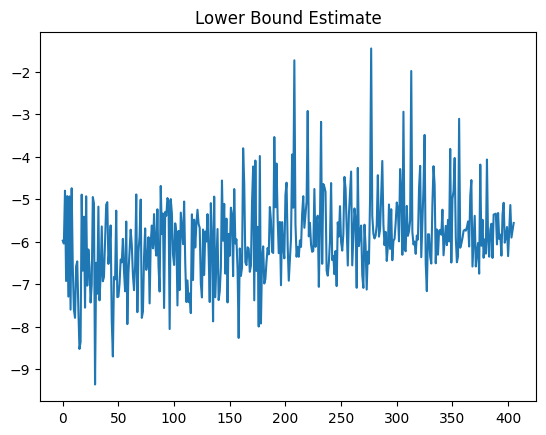

In [ ]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

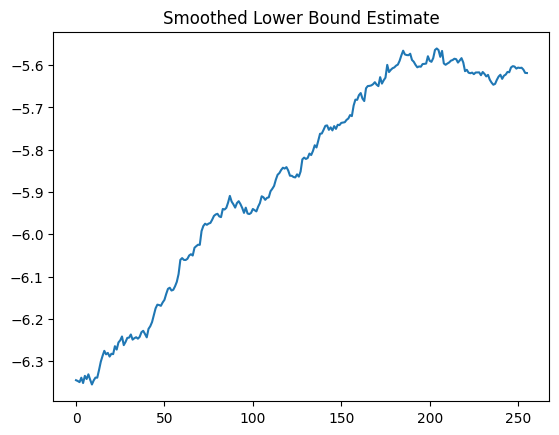

In [ ]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
best_lambda_mu

Array([0.18864714], dtype=float32)

In [ ]:
best_lambda_l

Array([10.016703], dtype=float32)

In [ ]:
best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  my_inv(best_Sigma_inv)

best_theta = random.multivariate_normal(key2, mean = best_mu, cov = best_Sigma, shape = (1000,))
posterior_mean_estimate = jnp.mean(best_theta)
posterior_mean_estimate

Array(0.18798974, dtype=float32)

Text(0.5, 1.0, 'Posterior density of theta')

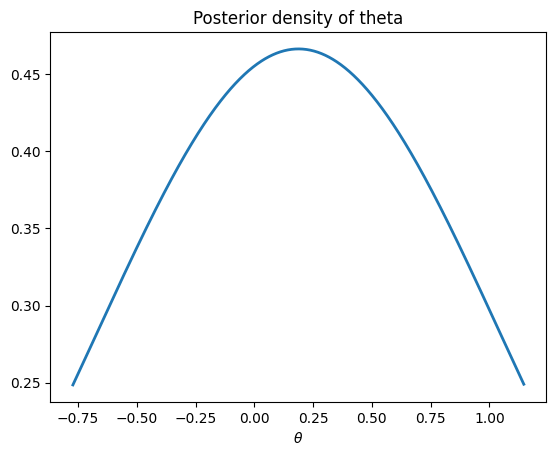

In [ ]:
from sklearn.neighbors import KernelDensity

plt.figure()
x_plot = jnp.arange((np.mean(best_theta)-10*np.std(best_theta)), (np.mean(best_theta)+10*np.std(best_theta)), 0.002)
kde = KernelDensity(bandwidth=0.85, kernel='gaussian')
kde.fit(best_theta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\theta$')
plt.title('Posterior density of theta')

In [ ]:
## FIND BEST COEFFS USING VB

In [ ]:
def unbiased_log_likelihood(theta, actual_summary_statistics, n_samples, num_datasets):
    sample_mean = summary_statistics(theta, n_samples, num_datasets)[0]
    sample_variance = summary_statistics(theta, n_samples, num_datasets)[1]
    u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = sample_mean, cov= sample_variance)

    # diff_mean_s = actual_summary_statistics - sample_mean
    # part1 = diff_mean_s.T @ jnp.linalg.solve(sample_variance, diff_mean_s)
    # u_est_log_likelihood = -1/2 * jnp.linalg.slogdet(sample_variance)[1] -1/2 * part1

    return u_est_log_likelihood

In [ ]:
class nn_GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_coeffs = np.shape(true_theta)[0] # number of coeffs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_gradient_lb(self, theta_q, mu_q, l_q, c_mu, c_l):

        # Find gradient of LB
        llh = unbiased_log_likelihood(theta_q, self.actual_summary_statistics, n_samples, num_datasets)
        h_lambda = prior(theta_q, sigma_theta, num_coeffs) + llh - fun_log_q(theta_q, mu_q, l_q)

        # Find gradient of LB
        grad_log_q_mu, grad_log_q_l = gradient_log_q(theta_q, mu_q, l_q, num_coeffs)
        gradient_lb_mu = grad_log_q_mu * (h_lambda - c_mu)
        gradient_lb_l = grad_log_q_l * (h_lambda - c_l)
        # Calculate control variates
        flattened_gradient_log_q = jnp.concatenate((grad_log_q_mu, grad_log_q_l), axis = None)
        flattened_gradient_lb = jnp.concatenate((gradient_lb_mu, gradient_lb_l), axis = None)

        return gradient_lb_mu, gradient_lb_l, h_lambda, flattened_gradient_log_q, flattened_gradient_lb

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = jnp.array([0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = jnp.tril(jnp.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = jnp.linalg.solve(Sigma_0_inv, jnp.eye(Sigma_0_inv.shape[0]))
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[jnp.triu_indices(self.num_coeffs)]

        # Initilize best lambda
        lambda_best_mu = mu_0
        lambda_best_l = vech_l0
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []

        func_auto = vmap(self.fun_gradient_lb, in_axes=[0, None, None, None, None])

        for t in tqdm(range(stop)):
            if t == 0:
                # Draw samples of theta from  variational q
                # List of gradients
                # theta_0_samples = jnp.array(scipy.stats.multivariate_normal.rvs(mu_0, Sigma_0, size = self.samples))
                theta_0_samples = random.multivariate_normal(subkeys[t], mean = mu_0, cov = Sigma_0, shape = (self.samples,))
                gradient_lb_mu_0, gradient_lb_l_0, lb_0, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_0_samples, mu_0, l_0, 0, 0)
                # Calculate control variates using all samples
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_mu_init = jnp.mean(gradient_lb_mu_0, axis = 0)
                self.g_vech_l_init = jnp.mean(gradient_lb_l_0, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None)) > self.l_threshold:
                    self.g_mu_init = self.l_threshold * self.g_mu_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                    self.g_vech_l_init = self.l_threshold * self.g_vech_l_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                self.v_mu_init = self.g_mu_init ** 2
                self.v_vech_l_init = self.g_vech_l_init ** 2
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_0))
                print('LB', (jnp.mean(lb_0)))
                lambda_q_mu = mu_0
                lambda_q_l = vech_l0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q_mu

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q_l)
                l_q = jnp.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q = l_q.at[i:self.num_coeffs,i].set(vech_lq[:self.num_coeffs - i])
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  jnp.linalg.solve(Sigma_q_inv, jnp.eye(Sigma_q_inv.shape[0]))
                l_q_inv =  jnp.linalg.solve(l_q, jnp.eye(l_q.shape[0]))
                # List of gradients
                Gradient_lb = []
                lb_t = []
                # theta_q_samples = jnp.array(scipy.stats.multivariate_normal.rvs(mu_q, Sigma_q, size = self.samples))
                theta_q_samples = random.multivariate_normal(subkeys[t], mean = mu_q, cov = Sigma_q, shape = (self.samples,))
                gradient_lb_mu, gradient_lb_l, lb_t, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_q_samples, mu_q, l_q, c_mu, c_vech_l)

                # Update control variates
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                g_mu_t = jnp.mean(gradient_lb_mu, axis = 0)
                g_vech_l_t = jnp.mean(gradient_lb_l, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None)) > self.l_threshold:
                    g_mu_t = self.l_threshold * g_mu_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                    g_vech_l_t = self.l_threshold * g_vech_l_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                v_mu_t = g_mu_t ** 2
                v_vech_l_t = g_vech_l_t ** 2
                #---- Update lambda
                self.g_mu_init = self.adaptive_lr_1 * self.g_mu_init + (1 - self.adaptive_lr_1) * g_mu_t
                self.g_vech_l_init = self.adaptive_lr_1 * self.g_vech_l_init + (1 - self.adaptive_lr_1) * g_vech_l_t

                self.v_mu_init = self.adaptive_lr_2 * self.v_mu_init + (1 - self.adaptive_lr_2) * v_mu_t
                self.v_vech_l_init = self.adaptive_lr_2 * self.v_vech_l_init + (1 - self.adaptive_lr_2) * v_vech_l_t

                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q_mu = lambda_q_mu + update_t * self.g_mu_init / (self.v_mu_init ** 0.5)
                lambda_q_l = lambda_q_l + update_t * self.g_vech_l_init / (self.v_vech_l_init ** 0.5)
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_t))

                if t < self.t_w:
                    print('LB', jnp.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = jnp.mean(jnp.array(LB_all[t - self.t_w + 1 : t]))
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
                        patience = 0
                        lambda_best_mu = lambda_q_mu
                        lambda_best_l = lambda_q_l
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best_mu, lambda_best_l

In [ ]:
nn_vb = nn_GVB(200, transformed_actual_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 150, 50)
nn_LB_estimate, nn_smoothed_LB_estimate, nn_best_lambda_mu, nn_best_lambda_l = nn_vb.vb_posterior(stop)

  0%|          | 1/4000 [00:19<21:09:58, 19.05s/it]

LB -5.4214344


  0%|          | 2/4000 [00:37<20:37:17, 18.57s/it]

LB -5.5479407


  0%|          | 3/4000 [00:57<21:16:42, 19.16s/it]

LB -5.405876


  0%|          | 4/4000 [01:16<21:14:52, 19.14s/it]

LB -5.361015


  0%|          | 5/4000 [01:34<20:51:47, 18.80s/it]

LB -5.425084


  0%|          | 6/4000 [01:53<20:58:00, 18.90s/it]

LB -5.413889


  0%|          | 7/4000 [02:11<20:38:07, 18.60s/it]

LB -5.3585753


  0%|          | 8/4000 [02:30<20:44:53, 18.71s/it]

LB -5.386963


  0%|          | 9/4000 [02:48<20:31:41, 18.52s/it]

LB -5.416159


  0%|          | 10/4000 [03:07<20:42:35, 18.69s/it]

LB -5.306272


  0%|          | 11/4000 [03:25<20:29:18, 18.49s/it]

LB -5.3248386


  0%|          | 12/4000 [03:44<20:36:51, 18.61s/it]

LB -5.3037376


  0%|          | 13/4000 [04:04<21:04:50, 19.03s/it]

LB -5.3020306


  0%|          | 14/4000 [04:22<20:44:11, 18.73s/it]

LB -5.251614


  0%|          | 15/4000 [04:41<20:51:30, 18.84s/it]

LB -5.242051


  0%|          | 16/4000 [04:59<20:36:42, 18.63s/it]

LB -5.273676


  0%|          | 17/4000 [05:18<20:46:35, 18.78s/it]

LB -5.2171392


  0%|          | 18/4000 [05:37<20:40:31, 18.69s/it]

LB -5.1494217


  0%|          | 19/4000 [05:56<20:38:57, 18.67s/it]

LB -5.1858263


  0%|          | 20/4000 [06:15<20:47:46, 18.81s/it]

LB -5.2275715


  1%|          | 21/4000 [06:33<20:34:01, 18.61s/it]

LB -5.206055


  1%|          | 22/4000 [06:53<21:01:57, 19.03s/it]

LB -5.1819434


  1%|          | 23/4000 [07:11<20:48:07, 18.83s/it]

LB -5.106723


  1%|          | 24/4000 [07:30<20:53:43, 18.92s/it]

LB -5.2296424


  1%|          | 25/4000 [07:49<20:54:07, 18.93s/it]

LB -5.2453246


  1%|          | 26/4000 [08:08<20:45:04, 18.80s/it]

LB -5.1925244


  1%|          | 27/4000 [08:27<20:52:50, 18.92s/it]

LB -5.168959


  1%|          | 28/4000 [08:45<20:37:19, 18.69s/it]

LB -5.1560154


  1%|          | 29/4000 [09:04<20:43:57, 18.80s/it]

LB -5.1764855


  1%|          | 30/4000 [09:22<20:32:14, 18.62s/it]

LB -5.1424828


  1%|          | 31/4000 [09:41<20:40:46, 18.76s/it]

LB -5.0928073


  1%|          | 32/4000 [10:01<20:48:48, 18.88s/it]

LB -5.1240845


  1%|          | 33/4000 [10:20<20:49:44, 18.90s/it]

LB -5.0642357


  1%|          | 34/4000 [10:39<20:55:33, 18.99s/it]

LB -5.05948


  1%|          | 35/4000 [10:57<20:40:10, 18.77s/it]

LB -5.0402884


  1%|          | 36/4000 [11:16<20:43:40, 18.82s/it]

LB -5.0640063


  1%|          | 37/4000 [11:34<20:26:51, 18.57s/it]

LB -5.1180134


  1%|          | 38/4000 [11:53<20:36:59, 18.73s/it]

LB -5.042681


  1%|          | 39/4000 [12:11<20:27:22, 18.59s/it]

LB -5.0163364


  1%|          | 40/4000 [12:30<20:36:22, 18.73s/it]

LB -5.0408845


  1%|          | 41/4000 [12:51<21:02:45, 19.14s/it]

LB -4.9413114


  1%|          | 42/4000 [13:09<20:43:24, 18.85s/it]

LB -5.002532


  1%|          | 43/4000 [13:28<20:45:10, 18.88s/it]

LB -5.013496


  1%|          | 44/4000 [13:46<20:27:30, 18.62s/it]

LB -5.0883822


  1%|          | 45/4000 [14:05<20:37:32, 18.77s/it]

LB -5.0781355


  1%|          | 46/4000 [14:23<20:27:33, 18.63s/it]

LB -5.0127106


  1%|          | 47/4000 [14:42<20:35:17, 18.75s/it]

LB -5.0573645


  1%|          | 48/4000 [15:00<20:24:14, 18.59s/it]

LB -4.990065


  1%|          | 49/4000 [15:19<20:26:17, 18.62s/it]

LB -4.966669


  1%|▏         | 50/4000 [15:38<20:34:33, 18.75s/it]

LB -5.0106874


  1%|▏         | 51/4000 [15:57<20:34:45, 18.76s/it]

LB -5.052283


  1%|▏         | 52/4000 [16:16<20:44:42, 18.92s/it]

LB -4.9552326


  1%|▏         | 53/4000 [16:34<20:29:33, 18.69s/it]

LB -4.9971223


  1%|▏         | 54/4000 [16:53<20:36:36, 18.80s/it]

LB -5.0318384


  1%|▏         | 55/4000 [17:12<20:31:23, 18.73s/it]

LB -4.9497986


  1%|▏         | 56/4000 [17:30<20:24:49, 18.63s/it]

LB -5.0361032


  1%|▏         | 57/4000 [17:49<20:33:50, 18.78s/it]

LB -4.9648576


  1%|▏         | 58/4000 [18:08<20:23:41, 18.63s/it]

LB -5.006699


  1%|▏         | 59/4000 [18:27<20:31:47, 18.75s/it]

LB -5.051863


  2%|▏         | 60/4000 [18:46<20:39:31, 18.88s/it]

LB -5.0136075


  2%|▏         | 61/4000 [19:05<20:43:23, 18.94s/it]

LB -4.9486027


  2%|▏         | 62/4000 [19:24<20:48:26, 19.02s/it]

LB -4.9744735


  2%|▏         | 63/4000 [19:42<20:32:02, 18.78s/it]

LB -4.983441


  2%|▏         | 64/4000 [20:01<20:36:48, 18.85s/it]

LB -5.0072083


  2%|▏         | 65/4000 [20:19<20:18:46, 18.58s/it]

LB -4.978782


  2%|▏         | 66/4000 [20:39<20:29:45, 18.76s/it]

LB -4.9636493


  2%|▏         | 67/4000 [20:57<20:18:19, 18.59s/it]

LB -4.9259634


  2%|▏         | 68/4000 [21:16<20:27:54, 18.74s/it]

LB -4.9302893


  2%|▏         | 69/4000 [21:35<20:39:11, 18.91s/it]

LB -4.9850955


  2%|▏         | 70/4000 [21:54<20:37:11, 18.89s/it]

LB -4.959056


  2%|▏         | 71/4000 [22:13<20:43:48, 18.99s/it]

LB -4.990422


  2%|▏         | 72/4000 [22:31<20:27:30, 18.75s/it]

LB -5.0378046


  2%|▏         | 73/4000 [22:50<20:32:13, 18.83s/it]

LB -4.96659


  2%|▏         | 74/4000 [23:08<20:14:21, 18.56s/it]

LB -4.971141


  2%|▏         | 75/4000 [23:28<20:25:33, 18.73s/it]

LB -4.9532886


  2%|▏         | 76/4000 [23:46<20:17:39, 18.62s/it]

LB -4.893609


  2%|▏         | 77/4000 [24:05<20:26:41, 18.76s/it]

LB -5.026356


  2%|▏         | 78/4000 [24:24<20:33:23, 18.87s/it]

LB -4.9333463


  2%|▏         | 79/4000 [24:43<20:39:29, 18.97s/it]

LB -4.9238286


  2%|▏         | 80/4000 [25:02<20:41:14, 19.00s/it]

LB -4.926093


  2%|▏         | 81/4000 [25:21<20:24:53, 18.75s/it]

LB -4.9737024


  2%|▏         | 82/4000 [25:40<20:33:28, 18.89s/it]

LB -4.9568


  2%|▏         | 83/4000 [25:58<20:22:05, 18.72s/it]

LB -4.9543524


  2%|▏         | 84/4000 [26:17<20:24:07, 18.76s/it]

LB -4.9783664


  2%|▏         | 85/4000 [26:36<20:29:51, 18.85s/it]

LB -4.95084


  2%|▏         | 86/4000 [26:54<20:15:37, 18.63s/it]

LB -4.9697294


  2%|▏         | 87/4000 [27:13<20:23:01, 18.75s/it]

LB -4.966712


  2%|▏         | 88/4000 [27:32<20:30:37, 18.87s/it]

LB -4.890048


  2%|▏         | 89/4000 [27:51<20:34:44, 18.94s/it]

LB -4.899473


  2%|▏         | 90/4000 [28:10<20:26:45, 18.82s/it]

LB -4.9743543


  2%|▏         | 91/4000 [28:28<20:20:51, 18.74s/it]

LB -4.937308


  2%|▏         | 92/4000 [28:48<20:30:24, 18.89s/it]

LB -4.961871


  2%|▏         | 93/4000 [29:06<20:16:20, 18.68s/it]

LB -4.9495006


  2%|▏         | 94/4000 [29:25<20:23:53, 18.80s/it]

LB -4.995548


  2%|▏         | 95/4000 [29:43<20:07:58, 18.56s/it]

LB -4.961939


  2%|▏         | 96/4000 [30:02<20:19:52, 18.75s/it]

LB -4.91151


  2%|▏         | 97/4000 [30:22<20:43:10, 19.11s/it]

LB -4.9697256


  2%|▏         | 98/4000 [30:40<20:26:17, 18.86s/it]

LB -5.006145


  2%|▏         | 99/4000 [30:59<20:29:02, 18.90s/it]

LB -4.9687686


  2%|▎         | 100/4000 [31:18<20:15:13, 18.70s/it]

LB -4.936371


  3%|▎         | 101/4000 [31:37<20:25:04, 18.85s/it]

LB -4.881974


  3%|▎         | 102/4000 [31:55<20:13:19, 18.68s/it]

LB -4.9570303


  3%|▎         | 103/4000 [32:14<20:20:42, 18.79s/it]

LB -4.9801426


  3%|▎         | 104/4000 [32:32<20:08:43, 18.61s/it]

LB -4.919257


  3%|▎         | 105/4000 [32:51<20:12:26, 18.68s/it]

LB -4.9911475


  3%|▎         | 106/4000 [33:11<20:40:40, 19.12s/it]

LB -4.9458766


  3%|▎         | 107/4000 [33:30<20:21:57, 18.83s/it]

LB -4.940035


  3%|▎         | 108/4000 [33:49<20:26:46, 18.91s/it]

LB -4.8928714


  3%|▎         | 109/4000 [34:07<20:13:18, 18.71s/it]

LB -4.8869777


  3%|▎         | 110/4000 [34:26<20:23:33, 18.87s/it]

LB -4.905814


  3%|▎         | 111/4000 [34:45<20:17:56, 18.79s/it]

LB -4.981948


  3%|▎         | 112/4000 [35:03<20:14:27, 18.74s/it]

LB -4.9894853


  3%|▎         | 113/4000 [35:23<20:25:06, 18.91s/it]

LB -4.9935136


  3%|▎         | 114/4000 [35:41<20:10:12, 18.69s/it]

LB -4.9623866


  3%|▎         | 115/4000 [36:00<20:18:31, 18.82s/it]

LB -4.8928514


  3%|▎         | 116/4000 [36:19<20:24:29, 18.92s/it]

LB -4.901101


  3%|▎         | 117/4000 [36:38<20:28:17, 18.98s/it]

LB -4.9277134


  3%|▎         | 118/4000 [36:57<20:31:00, 19.03s/it]

LB -4.8965893


  3%|▎         | 119/4000 [37:16<20:14:54, 18.78s/it]

LB -5.0489707


  3%|▎         | 120/4000 [37:35<20:21:15, 18.89s/it]

LB -4.961951


  3%|▎         | 121/4000 [37:53<20:04:07, 18.63s/it]

LB -4.906906


  3%|▎         | 122/4000 [38:12<20:12:43, 18.76s/it]

LB -4.9143786


  3%|▎         | 123/4000 [38:30<20:00:45, 18.58s/it]

LB -4.9977546


  3%|▎         | 124/4000 [38:49<20:10:21, 18.74s/it]

LB -5.02697


  3%|▎         | 125/4000 [39:09<20:37:37, 19.16s/it]

LB -4.981842


  3%|▎         | 126/4000 [39:27<20:19:23, 18.89s/it]

LB -4.982708


  3%|▎         | 127/4000 [39:46<20:22:15, 18.93s/it]

LB -4.9261985


  3%|▎         | 128/4000 [40:05<20:04:20, 18.66s/it]

LB -5.027076


  3%|▎         | 129/4000 [40:24<20:12:39, 18.80s/it]

LB -4.9934745


  3%|▎         | 130/4000 [40:42<20:01:13, 18.62s/it]

LB -4.9849014


  3%|▎         | 131/4000 [41:01<20:10:16, 18.77s/it]

LB -4.9046946


  3%|▎         | 132/4000 [41:20<20:10:25, 18.78s/it]

LB -5.0632377


  3%|▎         | 133/4000 [41:38<20:01:05, 18.64s/it]

LB -5.0145698


  3%|▎         | 134/4000 [41:58<20:24:02, 19.00s/it]

LB -4.944804


  3%|▎         | 135/4000 [42:16<20:08:59, 18.77s/it]

LB -4.994579


  3%|▎         | 136/4000 [42:35<20:15:06, 18.87s/it]

LB -4.972389


  3%|▎         | 137/4000 [42:54<20:03:33, 18.69s/it]

LB -4.987308


  3%|▎         | 138/4000 [43:13<20:11:55, 18.83s/it]

LB -4.9215155


  3%|▎         | 139/4000 [43:31<20:08:21, 18.78s/it]

LB -5.0170493


  4%|▎         | 140/4000 [43:50<20:00:53, 18.67s/it]

LB -4.9093385


  4%|▎         | 141/4000 [44:09<20:09:46, 18.81s/it]

LB -4.9897876


  4%|▎         | 142/4000 [44:27<19:58:25, 18.64s/it]

LB -4.927112


  4%|▎         | 143/4000 [44:46<20:06:52, 18.77s/it]

LB -4.952888


  4%|▎         | 144/4000 [45:05<20:09:08, 18.81s/it]

LB -4.8679333


  4%|▎         | 145/4000 [45:24<20:17:26, 18.95s/it]

LB -4.9456315


  4%|▎         | 146/4000 [45:43<20:17:02, 18.95s/it]

LB -4.968059


  4%|▎         | 147/4000 [46:02<20:04:23, 18.76s/it]

LB -4.9741325


  4%|▎         | 148/4000 [46:21<20:10:59, 18.86s/it]

LB -4.997557


  4%|▎         | 149/4000 [46:39<19:55:45, 18.63s/it]

LB -5.01743


  4%|▍         | 150/4000 [46:58<20:05:16, 18.78s/it]

LB -4.880077


  4%|▍         | 151/4000 [47:16<19:54:34, 18.62s/it]

LB Smoothed -5.033768


  4%|▍         | 152/4000 [47:35<20:02:36, 18.75s/it]

LB Smoothed -5.029557


  4%|▍         | 153/4000 [47:54<19:54:57, 18.64s/it]

LB Smoothed -5.026277


  4%|▍         | 154/4000 [48:13<20:15:47, 18.97s/it]

LB Smoothed -5.023195


  4%|▍         | 155/4000 [48:33<20:20:37, 19.05s/it]

LB Smoothed -5.0206137


  4%|▍         | 156/4000 [48:51<20:04:51, 18.81s/it]

LB Smoothed -5.017951


  4%|▍         | 157/4000 [49:10<20:11:03, 18.91s/it]

LB Smoothed -5.0151954


  4%|▍         | 158/4000 [49:28<19:58:34, 18.72s/it]

LB Smoothed -5.0124454


  4%|▍         | 159/4000 [49:47<20:08:06, 18.87s/it]

LB Smoothed -5.0096335


  4%|▍         | 160/4000 [50:06<19:56:24, 18.69s/it]

LB Smoothed -5.007424


  4%|▍         | 161/4000 [50:25<20:06:28, 18.86s/it]

LB Smoothed -5.004347


  4%|▍         | 162/4000 [50:44<20:10:00, 18.92s/it]

LB Smoothed -5.001464


  4%|▍         | 163/4000 [51:03<20:13:23, 18.97s/it]

LB Smoothed -4.9990716


  4%|▍         | 164/4000 [51:22<20:18:23, 19.06s/it]

LB Smoothed -4.9966054


  4%|▍         | 165/4000 [51:41<20:01:59, 18.81s/it]

LB Smoothed -4.99468


  4%|▍         | 166/4000 [52:00<20:08:37, 18.91s/it]

LB Smoothed -4.992411


  4%|▍         | 167/4000 [52:19<20:11:18, 18.96s/it]

LB Smoothed -4.990702


  4%|▍         | 168/4000 [52:37<19:57:40, 18.75s/it]

LB Smoothed -4.9894395


  4%|▍         | 169/4000 [52:56<20:02:59, 18.84s/it]

LB Smoothed -4.988164


  4%|▍         | 170/4000 [53:14<19:46:51, 18.59s/it]

LB Smoothed -4.986301


  4%|▍         | 171/4000 [53:33<19:55:26, 18.73s/it]

LB Smoothed -4.98435


  4%|▍         | 172/4000 [53:53<20:07:14, 18.92s/it]

LB Smoothed -4.9825253


  4%|▍         | 173/4000 [54:11<20:04:37, 18.89s/it]

LB Smoothed -4.9817867


  4%|▍         | 174/4000 [54:31<20:10:15, 18.98s/it]

LB Smoothed -4.9799905


  4%|▍         | 175/4000 [54:49<19:54:14, 18.73s/it]

LB Smoothed -4.9782906


  4%|▍         | 176/4000 [55:08<20:01:38, 18.85s/it]

LB Smoothed -4.9772696


  4%|▍         | 177/4000 [55:26<19:50:40, 18.69s/it]

LB Smoothed -4.9754148


  4%|▍         | 178/4000 [55:45<20:01:32, 18.86s/it]

LB Smoothed -4.9738946


  4%|▍         | 179/4000 [56:04<19:57:01, 18.80s/it]

LB Smoothed -4.9721174


  4%|▍         | 180/4000 [56:23<19:53:40, 18.75s/it]

LB Smoothed -4.971134


  5%|▍         | 181/4000 [56:42<19:59:24, 18.84s/it]

LB Smoothed -4.9706597


  5%|▍         | 182/4000 [57:01<20:04:49, 18.93s/it]

LB Smoothed -4.968836


  5%|▍         | 183/4000 [57:20<20:08:39, 19.00s/it]

LB Smoothed -4.968578


  5%|▍         | 184/4000 [57:38<19:54:57, 18.79s/it]

LB Smoothed -4.967811


  5%|▍         | 185/4000 [57:57<19:58:59, 18.86s/it]

LB Smoothed -4.9675627


  5%|▍         | 186/4000 [58:17<20:04:59, 18.96s/it]

LB Smoothed -4.966801


  5%|▍         | 187/4000 [58:35<19:50:11, 18.73s/it]

LB Smoothed -4.965144


  5%|▍         | 188/4000 [58:54<19:55:56, 18.82s/it]

LB Smoothed -4.964661


  5%|▍         | 189/4000 [59:12<19:39:44, 18.57s/it]

LB Smoothed -4.964651


  5%|▍         | 190/4000 [59:31<19:50:28, 18.75s/it]

LB Smoothed -4.964094


  5%|▍         | 191/4000 [59:50<19:59:22, 18.89s/it]

LB Smoothed -4.9635935


  5%|▍         | 192/4000 [1:00:09<20:01:08, 18.93s/it]

LB Smoothed -4.9638343


  5%|▍         | 193/4000 [1:00:29<20:10:31, 19.08s/it]

LB Smoothed -4.9629464


  5%|▍         | 194/4000 [1:00:47<19:54:00, 18.82s/it]

LB Smoothed -4.962201


  5%|▍         | 195/4000 [1:01:06<20:01:01, 18.94s/it]

LB Smoothed -4.961319


  5%|▍         | 196/4000 [1:01:24<19:48:33, 18.75s/it]

LB Smoothed -4.960782


  5%|▍         | 197/4000 [1:01:44<19:57:14, 18.89s/it]

LB Smoothed -4.960358


  5%|▍         | 198/4000 [1:02:02<19:44:44, 18.70s/it]

LB Smoothed -4.9607396


  5%|▍         | 199/4000 [1:02:21<19:49:46, 18.78s/it]

LB Smoothed -4.9605002


  5%|▌         | 200/4000 [1:02:40<19:56:58, 18.90s/it]

LB Smoothed -4.959967


  5%|▌         | 201/4000 [1:02:59<20:01:15, 18.97s/it]

LB Smoothed -4.959544


  5%|▌         | 202/4000 [1:03:18<20:04:03, 19.02s/it]

LB Smoothed -4.959645


  5%|▌         | 203/4000 [1:03:37<19:50:17, 18.81s/it]

LB Smoothed -4.9595547


  5%|▌         | 204/4000 [1:03:56<19:57:51, 18.93s/it]

LB Smoothed -4.959506


  5%|▌         | 205/4000 [1:04:15<19:54:49, 18.89s/it]

LB Smoothed -4.9593997


  5%|▌         | 206/4000 [1:04:33<19:45:40, 18.75s/it]

LB Smoothed -4.958493


  5%|▌         | 207/4000 [1:04:52<19:51:40, 18.85s/it]

LB Smoothed -4.958274


  5%|▌         | 208/4000 [1:05:10<19:39:45, 18.67s/it]

LB Smoothed -4.9581075


  5%|▌         | 209/4000 [1:05:30<19:48:48, 18.82s/it]

LB Smoothed -4.957588


  5%|▌         | 210/4000 [1:05:48<19:42:44, 18.72s/it]

LB Smoothed -4.9569345


  5%|▌         | 211/4000 [1:06:08<19:58:02, 18.97s/it]

LB Smoothed -4.9571157


  5%|▌         | 212/4000 [1:06:26<19:54:58, 18.93s/it]

LB Smoothed -4.9574704


  5%|▌         | 213/4000 [1:06:45<19:44:13, 18.76s/it]

LB Smoothed -4.9571395


  5%|▌         | 214/4000 [1:07:04<19:49:15, 18.85s/it]

LB Smoothed -4.957019


  5%|▌         | 215/4000 [1:07:22<19:36:41, 18.65s/it]

LB Smoothed -4.957176


  5%|▌         | 216/4000 [1:07:41<19:43:35, 18.77s/it]

LB Smoothed -4.9573417


  5%|▌         | 217/4000 [1:07:59<19:33:25, 18.61s/it]

LB Smoothed -4.9577565


  5%|▌         | 218/4000 [1:08:19<19:43:43, 18.78s/it]

LB Smoothed -4.958365


  5%|▌         | 219/4000 [1:08:37<19:46:50, 18.83s/it]

LB Smoothed -4.9584594


  6%|▌         | 220/4000 [1:08:57<19:56:30, 18.99s/it]

LB Smoothed -4.9588466


  6%|▌         | 221/4000 [1:09:16<19:59:51, 19.05s/it]

LB Smoothed -4.958475


  6%|▌         | 222/4000 [1:09:34<19:43:53, 18.80s/it]

LB Smoothed -4.958073


  6%|▌         | 223/4000 [1:09:53<19:48:41, 18.88s/it]

LB Smoothed -4.958284


  6%|▌         | 224/4000 [1:10:12<19:38:15, 18.72s/it]

LB Smoothed -4.9583364


  6%|▌         | 225/4000 [1:10:31<19:48:50, 18.90s/it]

LB Smoothed -4.958237


  6%|▌         | 226/4000 [1:10:50<19:48:34, 18.90s/it]

LB Smoothed -4.9589624


  6%|▌         | 227/4000 [1:11:08<19:37:38, 18.73s/it]

LB Smoothed -4.9588113


  6%|▌         | 228/4000 [1:11:27<19:46:44, 18.88s/it]

LB Smoothed -4.9590716


  6%|▌         | 229/4000 [1:11:46<19:33:15, 18.67s/it]

LB Smoothed -4.9593134


  6%|▌         | 230/4000 [1:12:06<20:02:20, 19.14s/it]

LB Smoothed -4.9598317


  6%|▌         | 231/4000 [1:12:24<19:44:49, 18.86s/it]

LB Smoothed -4.959955


  6%|▌         | 232/4000 [1:12:43<19:47:31, 18.91s/it]

LB Smoothed -4.9605803


  6%|▌         | 233/4000 [1:13:02<19:52:38, 19.00s/it]

LB Smoothed -4.960466


  6%|▌         | 234/4000 [1:13:21<19:40:08, 18.80s/it]

LB Smoothed -4.9600067


  6%|▌         | 235/4000 [1:13:40<19:44:55, 18.88s/it]

LB Smoothed -4.960086


  6%|▌         | 236/4000 [1:13:58<19:31:02, 18.67s/it]

LB Smoothed -4.959974


  6%|▌         | 237/4000 [1:14:17<19:41:51, 18.84s/it]

LB Smoothed -4.9604187


  6%|▌         | 238/4000 [1:14:35<19:30:45, 18.67s/it]

LB Smoothed -4.960973


  6%|▌         | 239/4000 [1:14:55<19:42:03, 18.86s/it]

LB Smoothed -4.9615264


  6%|▌         | 240/4000 [1:15:14<19:51:19, 19.01s/it]

LB Smoothed -4.961842


  6%|▌         | 241/4000 [1:15:32<19:35:56, 18.77s/it]

LB Smoothed -4.96234


  6%|▌         | 242/4000 [1:15:51<19:43:34, 18.90s/it]

LB Smoothed -4.962562


  6%|▌         | 243/4000 [1:16:10<19:32:34, 18.73s/it]

LB Smoothed -4.96299


  6%|▌         | 244/4000 [1:16:29<19:42:30, 18.89s/it]

LB Smoothed -4.962709


  6%|▌         | 245/4000 [1:16:48<19:41:12, 18.87s/it]

LB Smoothed -4.9630837


  6%|▌         | 246/4000 [1:17:06<19:32:35, 18.74s/it]

LB Smoothed -4.963366


  6%|▌         | 247/4000 [1:17:25<19:38:08, 18.84s/it]

LB Smoothed -4.9637613


  6%|▌         | 248/4000 [1:17:44<19:27:50, 18.68s/it]

LB Smoothed -4.9635477


  6%|▌         | 249/4000 [1:18:04<19:56:26, 19.14s/it]

LB Smoothed -4.9634976


  6%|▋         | 250/4000 [1:18:22<19:40:06, 18.88s/it]

LB Smoothed -4.96426


  6%|▋         | 251/4000 [1:18:41<19:45:58, 18.98s/it]

LB Smoothed -4.9647207


  6%|▋         | 252/4000 [1:19:01<19:48:27, 19.03s/it]

LB Smoothed -4.965406


  6%|▋         | 253/4000 [1:19:19<19:33:01, 18.78s/it]

LB Smoothed -4.9651594


  6%|▋         | 254/4000 [1:19:38<19:41:26, 18.92s/it]

LB Smoothed -4.965792


  6%|▋         | 255/4000 [1:19:56<19:24:20, 18.65s/it]

LB Smoothed -4.9652677


  6%|▋         | 256/4000 [1:20:15<19:34:13, 18.82s/it]

LB Smoothed -4.965966


  6%|▋         | 257/4000 [1:20:34<19:24:57, 18.67s/it]

LB Smoothed -4.966103


  6%|▋         | 258/4000 [1:20:53<19:34:43, 18.84s/it]

LB Smoothed -4.9665194


  6%|▋         | 259/4000 [1:21:12<19:51:09, 19.10s/it]

LB Smoothed -4.967536


  6%|▋         | 260/4000 [1:21:31<19:37:20, 18.89s/it]

LB Smoothed -4.968048


  6%|▋         | 260/4000 [1:21:50<19:37:16, 18.89s/it]

LB Smoothed -4.967841
Stop at 260


<Axes: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

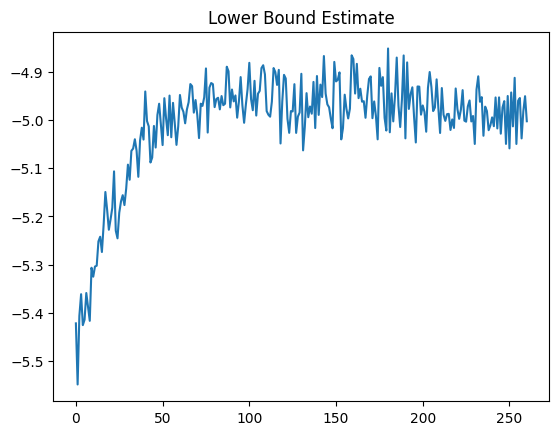

In [ ]:
lb_df = pd.DataFrame(np.array(nn_LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

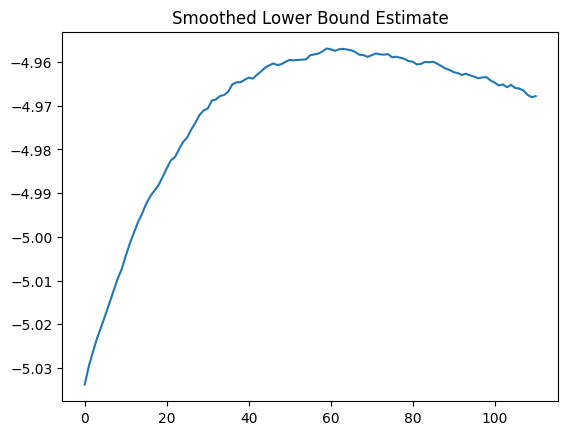

In [ ]:
lb_df = pd.DataFrame(np.array(nn_smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [ ]:
nn_best_lambda_mu

Array([0.26250294], dtype=float32)

In [ ]:
nn_best_lambda_l

Array([10.763905], dtype=float32)

## MCMC

In [34]:
num_samples = 15000
num_burnin = 0.2 * num_samples

In [36]:
def sampler(samples):

    # ------------------- initialize MCMC

    theta_size = num_coeffs  # num of weights and bias

    pos_theta = jnp.ones((samples, theta_size))  # posterior of all weights and bias over all samples

    theta = jnp.array([0])

    ss = summary_statistics(theta, n_samples, num_datasets)
    sample_mean = ss[0]
    sample_variance = ss[1]

    # Nuissance mean and variance
    mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(jnp.sqrt(sample_variance)).T @ jnp.linalg.solve(sample_variance, jnp.diag(jnp.sqrt(sample_variance)))
    # mean_nuissance_p1_non_inv_unreg = mean_nuissance_p1_non_inv + (jnp.eye(mean_nuissance_p1_non_inv.shape[0]) * 5 * 1e-7)
    mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))
    # mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))

    diag_var = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_variance)].set(jnp.diag(jnp.sqrt(sample_variance)))
    diff_mean = actual_summary_statistics - sample_mean
    mean_nuissance_p2 = diag_var @ jnp.linalg.solve(sample_variance, diff_mean)
    mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2
    variance_nuissance = mean_nuissance_p1

    # Generate Gamma

    Gamma = random.multivariate_normal(key2, mean = mean_nuissance, cov = variance_nuissance)
    adjusted_theta = jnp.concatenate((theta, Gamma))

    # Find gradient of LB
    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta, actual_summary_statistics, n_samples, num_datasets)
    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)

    # ---------------------

    prior_current = prior(theta, sigma_theta, num_coeffs)  # takes care of the gradients

    likelihood_current = llh

    naccept = 0

    for i in tqdm(range(samples - 1)):
        if i < 2000:
            theta_proposal = random.multivariate_normal(subkeys[i], mean = theta, cov = ((0.1**2/theta_size) * jnp.identity(theta_size)))
        else:
            if i % 500 == 0:
                Sign = jnp.cov(pos_theta[0:i, :].T)
                Sign = jnp.reshape(Sign, jnp.shape(jnp.identity(theta_size)))
            u_proposal = np.random.uniform(0, 1)
            if u_proposal < 0.05:
                theta_proposal = random.multivariate_normal(subkeys[i], mean = theta, cov = ((0.1**2/theta_size) * jnp.identity(theta_size)))
            else:
                theta_proposal = random.multivariate_normal(subkeys[i], mean = theta, cov = (2.38**2/theta_size) * Sign)

        ss = summary_statistics(theta_proposal, n_samples, num_datasets)
        sample_mean = ss[0]
        sample_variance = ss[1]

        # Nuissance mean and variance
        mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(jnp.sqrt(sample_variance)).T @ jnp.linalg.solve(sample_variance, jnp.diag(jnp.sqrt(sample_variance)))
        mean_nuissance_p1_non_inv_unreg = mean_nuissance_p1_non_inv + (jnp.eye(mean_nuissance_p1_non_inv.shape[0]) * 5 * 1e-7)
        mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv_unreg, jnp.eye(mean_nuissance_p1_non_inv_unreg.shape[0]))
        # mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))

        diag_var = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_variance)].set(jnp.diag(jnp.sqrt(sample_variance)))
        diff_mean = actual_summary_statistics - sample_mean
        mean_nuissance_p2 = diag_var @ jnp.linalg.solve(sample_variance, diff_mean)
        mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2
        # print(mean_nuissance_q)

        variance_nuissance = mean_nuissance_p1 + (jnp.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

        # Generate Gamma
        Gamma = random.multivariate_normal(key2, mean = mean_nuissance, cov = variance_nuissance)
        adjusted_theta_proposal = jnp.concatenate((theta_proposal, Gamma))

        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_proposal, actual_summary_statistics, n_samples, num_datasets)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)
        # ---------------------

        prior_proposal = prior(theta_proposal, sigma_theta, num_coeffs)  # takes care of the gradients
        likelihood_proposal = llh

        diff_prior = prior_proposal - prior_current

        diff_likelihood = likelihood_proposal - likelihood_current

        try:
            mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

        except OverflowError as e:
            mh_prob = 1


        u = np.random.uniform(0, 1)

        if u < mh_prob:
            # Update position
            naccept += 1
            likelihood_current = likelihood_proposal
            prior_current = prior_proposal
            theta = theta_proposal
            pos_theta = pos_theta.at[i + 1,].set(theta_proposal)
            print(i, pos_theta[i + 1,])

        else:
            pos_theta = pos_theta.at[i + 1,].set(pos_theta[i,])

    print(naccept, ' num accepted')
    print(naccept / (samples * 1.0) * 100, '% was accepted')
    accept_ratio = naccept / (samples * 1.0) * 100

    return (pos_theta, accept_ratio)

In [40]:
pos_w, accept_ratio = sampler(num_samples)

  0%|          | 1/14999 [00:00<3:01:47,  1.37it/s]

0 [-0.06461436]


  0%|          | 2/14999 [00:01<3:08:48,  1.32it/s]

1 [-0.2122933]


  0%|          | 3/14999 [00:02<3:03:01,  1.37it/s]

2 [-0.33817035]


  0%|          | 5/14999 [00:03<3:01:29,  1.38it/s]

4 [-0.4438652]


  0%|          | 6/14999 [00:04<3:33:46,  1.17it/s]

5 [-0.6844008]


  0%|          | 7/14999 [00:05<3:58:12,  1.05it/s]

6 [-0.78146875]


  0%|          | 8/14999 [00:06<3:54:13,  1.07it/s]

7 [-0.68137133]


  0%|          | 9/14999 [00:07<3:37:39,  1.15it/s]

8 [-0.7148043]


  0%|          | 10/14999 [00:08<3:23:35,  1.23it/s]

9 [-0.4360733]


  0%|          | 11/14999 [00:08<3:14:20,  1.29it/s]

10 [-0.39787638]


  0%|          | 12/14999 [00:09<3:10:10,  1.31it/s]

11 [-0.40576428]


  0%|          | 13/14999 [00:10<3:07:58,  1.33it/s]

12 [-0.3546758]


  0%|          | 14/14999 [00:11<3:06:59,  1.34it/s]

13 [-0.32736444]


  0%|          | 15/14999 [00:11<3:03:12,  1.36it/s]

14 [-0.32464045]


  0%|          | 16/14999 [00:12<2:59:12,  1.39it/s]

15 [-0.2449393]


  0%|          | 17/14999 [00:13<2:58:12,  1.40it/s]

16 [-0.1839433]


  0%|          | 19/14999 [00:14<2:55:48,  1.42it/s]

18 [-0.12993394]


  0%|          | 20/14999 [00:15<2:56:47,  1.41it/s]

19 [-0.11884827]


  0%|          | 21/14999 [00:15<2:55:22,  1.42it/s]

20 [-0.08487032]


  0%|          | 22/14999 [00:16<3:11:30,  1.30it/s]

21 [-0.03363155]


  0%|          | 23/14999 [00:18<3:35:53,  1.16it/s]

22 [-0.08343872]


  0%|          | 24/14999 [00:19<3:51:22,  1.08it/s]

23 [0.12318648]


  0%|          | 25/14999 [00:19<3:32:33,  1.17it/s]

24 [0.09131289]


  0%|          | 26/14999 [00:20<3:22:25,  1.23it/s]

25 [0.20833819]


  0%|          | 27/14999 [00:21<3:15:05,  1.28it/s]

26 [0.14393793]


  0%|          | 28/14999 [00:21<3:09:05,  1.32it/s]

27 [0.05139]


  0%|          | 29/14999 [00:22<3:06:58,  1.33it/s]

28 [0.11686819]


  0%|          | 32/14999 [00:24<3:03:49,  1.36it/s]

31 [0.13679783]


  0%|          | 33/14999 [00:25<3:05:12,  1.35it/s]

32 [0.11694676]


  0%|          | 34/14999 [00:26<3:07:04,  1.33it/s]

33 [-0.02985037]


  0%|          | 35/14999 [00:27<3:03:34,  1.36it/s]

34 [-0.0124834]


  0%|          | 36/14999 [00:27<3:01:28,  1.37it/s]

35 [0.23116341]


  0%|          | 37/14999 [00:28<3:00:07,  1.38it/s]

36 [0.30831277]


  0%|          | 38/14999 [00:29<3:02:37,  1.37it/s]

37 [0.2456135]


  0%|          | 39/14999 [00:30<3:29:32,  1.19it/s]

38 [0.15147775]


  0%|          | 40/14999 [00:31<3:51:23,  1.08it/s]

39 [0.0754808]


  0%|          | 41/14999 [00:32<3:47:05,  1.10it/s]

40 [-0.19661957]


  0%|          | 42/14999 [00:33<3:32:54,  1.17it/s]

41 [-0.2951307]


  0%|          | 43/14999 [00:33<3:22:27,  1.23it/s]

42 [-0.19880246]


  0%|          | 44/14999 [00:34<3:14:35,  1.28it/s]

43 [-0.21840361]


  0%|          | 45/14999 [00:35<3:09:02,  1.32it/s]

44 [-0.24691553]


  0%|          | 46/14999 [00:35<3:05:41,  1.34it/s]

45 [-0.10098032]


  0%|          | 47/14999 [00:36<3:03:16,  1.36it/s]

46 [-0.14524144]


  0%|          | 48/14999 [00:37<3:00:08,  1.38it/s]

47 [-0.01166825]


  0%|          | 49/14999 [00:37<2:59:17,  1.39it/s]

48 [0.03173986]


  0%|          | 50/14999 [00:38<3:00:53,  1.38it/s]

49 [0.09842549]


  0%|          | 51/14999 [00:39<2:58:37,  1.39it/s]

50 [0.05922299]


  0%|          | 52/14999 [00:40<2:58:35,  1.39it/s]

51 [0.1383363]


  0%|          | 53/14999 [00:40<2:57:37,  1.40it/s]

52 [0.45246214]


  0%|          | 54/14999 [00:41<2:55:45,  1.42it/s]

53 [0.48455057]


  0%|          | 55/14999 [00:42<3:12:13,  1.30it/s]

54 [0.5117635]


  0%|          | 56/14999 [00:43<3:35:00,  1.16it/s]

55 [0.34902638]


  0%|          | 58/14999 [00:45<3:33:11,  1.17it/s]

57 [0.33643702]


  0%|          | 59/14999 [00:46<3:22:56,  1.23it/s]

58 [0.34688407]


  0%|          | 60/14999 [00:46<3:14:35,  1.28it/s]

59 [0.280548]


  0%|          | 61/14999 [00:47<3:10:45,  1.31it/s]

60 [0.32470906]


  0%|          | 62/14999 [00:48<3:07:32,  1.33it/s]

61 [0.5571971]


  0%|          | 63/14999 [00:48<3:02:47,  1.36it/s]

62 [0.6436449]


  0%|          | 66/14999 [00:50<2:56:35,  1.41it/s]

65 [0.4480583]


  0%|          | 67/14999 [00:51<2:56:13,  1.41it/s]

66 [0.48088065]


  0%|          | 68/14999 [00:52<2:55:32,  1.42it/s]

67 [0.5878626]


  0%|          | 69/14999 [00:53<2:55:34,  1.42it/s]

68 [0.48908922]


  0%|          | 70/14999 [00:53<2:53:42,  1.43it/s]

69 [0.60676473]


  0%|          | 71/14999 [00:54<2:55:02,  1.42it/s]

70 [0.43914425]


  0%|          | 72/14999 [00:55<3:22:33,  1.23it/s]

71 [0.5247688]


  0%|          | 73/14999 [00:56<3:43:57,  1.11it/s]

72 [0.6283672]


  0%|          | 74/14999 [00:57<3:49:42,  1.08it/s]

73 [0.5510638]


  1%|          | 75/14999 [00:58<3:34:00,  1.16it/s]

74 [0.5280779]


  1%|          | 76/14999 [00:59<3:21:07,  1.24it/s]

75 [0.43848428]


  1%|          | 77/14999 [00:59<3:12:47,  1.29it/s]

76 [0.48559222]


  1%|          | 78/14999 [01:00<3:09:45,  1.31it/s]

77 [0.61432844]


  1%|          | 79/14999 [01:01<3:06:53,  1.33it/s]

78 [0.6299263]


  1%|          | 80/14999 [01:01<3:03:41,  1.35it/s]

79 [0.6731494]


  1%|          | 81/14999 [01:02<3:01:00,  1.37it/s]

80 [0.6682573]


  1%|          | 83/14999 [01:03<2:57:38,  1.40it/s]

82 [0.5861827]


  1%|          | 84/14999 [01:04<2:58:47,  1.39it/s]

83 [0.6241932]


  1%|          | 85/14999 [01:05<2:57:49,  1.40it/s]

84 [0.60236347]


  1%|          | 87/14999 [01:06<2:56:19,  1.41it/s]

86 [0.6081274]


  1%|          | 89/14999 [01:08<3:29:03,  1.19it/s]

88 [0.58695346]


  1%|          | 90/14999 [01:09<3:48:27,  1.09it/s]

89 [0.70511436]


  1%|          | 91/14999 [01:10<3:40:27,  1.13it/s]

90 [0.61884373]


  1%|          | 92/14999 [01:11<3:28:13,  1.19it/s]

91 [0.60994554]


  1%|          | 95/14999 [01:13<3:05:32,  1.34it/s]

94 [0.47722077]


  1%|          | 96/14999 [01:14<3:04:24,  1.35it/s]

95 [0.6100884]


  1%|          | 97/14999 [01:15<3:31:33,  1.17it/s]

96 [0.5308705]


  1%|          | 98/14999 [01:16<3:51:22,  1.07it/s]

97 [0.53978634]


  1%|          | 99/14999 [01:17<3:47:16,  1.09it/s]

98 [0.30639175]


  1%|          | 100/14999 [01:17<3:30:31,  1.18it/s]

99 [0.33644503]


  1%|          | 101/14999 [01:18<3:20:33,  1.24it/s]

100 [0.55914074]


  1%|          | 103/14999 [01:20<3:07:30,  1.32it/s]

102 [0.6818759]


  1%|          | 104/14999 [01:21<3:34:16,  1.16it/s]

103 [0.69288874]


  1%|          | 105/14999 [01:22<3:50:08,  1.08it/s]

104 [0.5057735]


  1%|          | 106/14999 [01:23<3:52:05,  1.07it/s]

105 [0.5483845]


  1%|          | 108/14999 [01:24<3:27:09,  1.20it/s]

107 [0.5650414]


  1%|          | 109/14999 [01:25<3:18:29,  1.25it/s]

108 [0.5992473]


  1%|          | 110/14999 [01:26<3:11:32,  1.30it/s]

109 [0.5393433]


  1%|          | 111/14999 [01:26<3:06:24,  1.33it/s]

110 [0.54307467]


  1%|          | 112/14999 [01:27<3:03:25,  1.35it/s]

111 [0.7116683]


  1%|          | 113/14999 [01:28<3:00:18,  1.38it/s]

112 [0.52964]


  1%|          | 115/14999 [01:29<2:57:53,  1.39it/s]

114 [0.27673522]


  1%|          | 116/14999 [01:30<2:58:02,  1.39it/s]

115 [0.28368127]


  1%|          | 117/14999 [01:31<2:58:08,  1.39it/s]

116 [0.3184983]


  1%|          | 118/14999 [01:31<2:57:31,  1.40it/s]

117 [0.2578374]


  1%|          | 119/14999 [01:32<2:56:42,  1.40it/s]

118 [0.27452606]


  1%|          | 120/14999 [01:33<3:13:40,  1.28it/s]

119 [0.29761833]


  1%|          | 121/14999 [01:34<3:40:14,  1.13it/s]

120 [0.3547518]


  1%|          | 122/14999 [01:35<3:58:56,  1.04it/s]

121 [0.17933436]


  1%|          | 123/14999 [01:36<3:40:47,  1.12it/s]

122 [0.31319803]


  1%|          | 124/14999 [01:37<3:27:49,  1.19it/s]

123 [0.18912703]


  1%|          | 125/14999 [01:37<3:18:09,  1.25it/s]

124 [0.22311512]


  1%|          | 126/14999 [01:38<3:09:08,  1.31it/s]

125 [0.28789946]


  1%|          | 127/14999 [01:39<3:05:14,  1.34it/s]

126 [0.33538076]


  1%|          | 129/14999 [01:40<2:59:58,  1.38it/s]

128 [0.14761847]


  1%|          | 130/14999 [01:41<2:58:42,  1.39it/s]

129 [0.16901043]


  1%|          | 131/14999 [01:42<2:57:21,  1.40it/s]

130 [0.1602852]


  1%|          | 132/14999 [01:42<2:57:07,  1.40it/s]

131 [0.17193078]


  1%|          | 133/14999 [01:43<2:59:01,  1.38it/s]

132 [0.22177075]


  1%|          | 134/14999 [01:44<2:57:30,  1.40it/s]

133 [0.3289501]


  1%|          | 135/14999 [01:44<2:57:07,  1.40it/s]

134 [0.21311262]


  1%|          | 136/14999 [01:45<2:58:20,  1.39it/s]

135 [0.26129678]


  1%|          | 137/14999 [01:46<3:28:13,  1.19it/s]

136 [0.27391717]


  1%|          | 138/14999 [01:47<3:48:05,  1.09it/s]

137 [0.2663016]


  1%|          | 140/14999 [01:49<3:31:46,  1.17it/s]

139 [0.21619114]


  1%|          | 141/14999 [01:50<3:23:39,  1.22it/s]

140 [0.08786695]


  1%|          | 142/14999 [01:51<3:14:42,  1.27it/s]

141 [0.10800603]


  1%|          | 143/14999 [01:51<3:08:58,  1.31it/s]

142 [0.16953884]


  1%|          | 144/14999 [01:52<3:05:09,  1.34it/s]

143 [0.2922242]


  1%|          | 145/14999 [01:53<3:01:35,  1.36it/s]

144 [0.341176]


  1%|          | 147/14999 [01:54<2:58:33,  1.39it/s]

146 [0.27544278]


  1%|          | 148/14999 [01:55<2:59:27,  1.38it/s]

147 [0.14329804]


  1%|          | 149/14999 [01:56<3:00:25,  1.37it/s]

148 [0.1603778]


  1%|          | 150/14999 [01:56<2:58:59,  1.38it/s]

149 [0.17128366]


  1%|          | 151/14999 [01:57<3:00:51,  1.37it/s]

150 [0.31160632]


  1%|          | 152/14999 [01:58<2:59:21,  1.38it/s]

151 [0.21922082]


  1%|          | 153/14999 [01:59<3:22:18,  1.22it/s]

152 [0.16403954]


  1%|          | 154/14999 [02:00<3:44:15,  1.10it/s]

153 [0.12438247]


  1%|          | 156/14999 [02:02<3:36:37,  1.14it/s]

155 [0.24234942]


  1%|          | 157/14999 [02:02<3:24:29,  1.21it/s]

156 [0.3351335]


  1%|          | 158/14999 [02:03<3:14:15,  1.27it/s]

157 [0.2233474]


  1%|          | 159/14999 [02:04<3:08:25,  1.31it/s]

158 [0.22005266]


  1%|          | 160/14999 [02:04<3:05:01,  1.34it/s]

159 [0.32920736]


  1%|          | 161/14999 [02:05<3:03:06,  1.35it/s]

160 [0.37421274]


  1%|          | 162/14999 [02:06<2:58:55,  1.38it/s]

161 [0.527192]


  1%|          | 163/14999 [02:07<2:59:41,  1.38it/s]

162 [0.54964834]


  1%|          | 164/14999 [02:07<2:58:54,  1.38it/s]

163 [0.5711032]


  1%|          | 166/14999 [02:09<3:01:04,  1.37it/s]

165 [0.40023533]


  1%|          | 167/14999 [02:10<3:02:33,  1.35it/s]

166 [0.45127633]


  1%|          | 168/14999 [02:10<3:04:53,  1.34it/s]

167 [0.3897341]


  1%|          | 169/14999 [02:11<3:17:45,  1.25it/s]

168 [0.28218716]


  1%|          | 170/14999 [02:12<3:42:18,  1.11it/s]

169 [0.24445452]


  1%|          | 171/14999 [02:13<3:58:39,  1.04it/s]

170 [0.31331736]


  1%|          | 172/14999 [02:14<3:38:05,  1.13it/s]

171 [0.33261308]


  1%|          | 173/14999 [02:15<3:27:06,  1.19it/s]

172 [0.4261472]


  1%|          | 174/14999 [02:16<3:19:34,  1.24it/s]

173 [0.49292046]


  1%|          | 175/14999 [02:16<3:11:13,  1.29it/s]

174 [0.49644548]


  1%|          | 176/14999 [02:17<3:07:07,  1.32it/s]

175 [0.6180705]


  1%|          | 178/14999 [02:18<3:01:33,  1.36it/s]

177 [0.6557864]


  1%|          | 179/14999 [02:19<3:00:59,  1.36it/s]

178 [0.7258487]


  1%|          | 180/14999 [02:20<3:00:54,  1.37it/s]

179 [0.7353236]


  1%|          | 181/14999 [02:21<3:01:39,  1.36it/s]

180 [0.73191535]


  1%|          | 182/14999 [02:21<2:58:23,  1.38it/s]

181 [0.5867748]


  1%|          | 183/14999 [02:22<2:59:39,  1.37it/s]

182 [0.5289644]


  1%|          | 184/14999 [02:23<3:00:48,  1.37it/s]

183 [0.42302185]


  1%|          | 185/14999 [02:24<3:03:28,  1.35it/s]

184 [0.4331518]


  1%|          | 186/14999 [02:25<3:32:38,  1.16it/s]

185 [0.3823686]


  1%|          | 187/14999 [02:26<3:50:41,  1.07it/s]

186 [0.21250787]


  1%|▏         | 189/14999 [02:27<3:29:12,  1.18it/s]

188 [0.23870935]


  1%|▏         | 190/14999 [02:28<3:19:28,  1.24it/s]

189 [0.27049053]


  1%|▏         | 191/14999 [02:29<3:12:08,  1.28it/s]

190 [0.32811213]


  1%|▏         | 192/14999 [02:30<3:09:06,  1.30it/s]

191 [0.33246928]


  1%|▏         | 193/14999 [02:30<3:05:03,  1.33it/s]

192 [0.46097076]


  1%|▏         | 194/14999 [02:31<3:05:42,  1.33it/s]

193 [0.45717126]


  1%|▏         | 195/14999 [02:32<3:02:02,  1.36it/s]

194 [0.39970395]


  1%|▏         | 196/14999 [02:32<3:00:28,  1.37it/s]

195 [0.5227354]


  1%|▏         | 198/14999 [02:34<2:56:18,  1.40it/s]

197 [0.47594792]


  1%|▏         | 199/14999 [02:35<2:58:46,  1.38it/s]

198 [0.4679224]


  1%|▏         | 200/14999 [02:35<3:02:53,  1.35it/s]

199 [0.4587437]


  1%|▏         | 201/14999 [02:36<3:02:38,  1.35it/s]

200 [0.5211294]


  1%|▏         | 202/14999 [02:37<3:23:24,  1.21it/s]

201 [0.58336174]


  1%|▏         | 204/14999 [02:39<3:54:34,  1.05it/s]

203 [0.46201217]


  1%|▏         | 205/14999 [02:40<3:38:06,  1.13it/s]

204 [0.62211585]


  1%|▏         | 206/14999 [02:41<3:24:58,  1.20it/s]

205 [0.59313095]


  1%|▏         | 207/14999 [02:41<3:16:12,  1.26it/s]

206 [0.60360676]


  1%|▏         | 209/14999 [02:43<3:05:25,  1.33it/s]

208 [0.6912292]


  1%|▏         | 210/14999 [02:44<3:01:50,  1.36it/s]

209 [0.5744427]


  1%|▏         | 211/14999 [02:44<2:58:40,  1.38it/s]

210 [0.55534565]


  1%|▏         | 213/14999 [02:46<2:57:26,  1.39it/s]

212 [0.5656373]


  1%|▏         | 214/14999 [02:46<2:56:37,  1.40it/s]

213 [0.45480472]


  1%|▏         | 215/14999 [02:47<2:55:50,  1.40it/s]

214 [0.35509926]


  1%|▏         | 216/14999 [02:48<2:54:41,  1.41it/s]

215 [0.4588996]


  1%|▏         | 217/14999 [02:49<2:54:18,  1.41it/s]

216 [0.34416267]


  1%|▏         | 218/14999 [02:49<3:03:37,  1.34it/s]

217 [0.23908082]


  1%|▏         | 219/14999 [02:50<3:30:58,  1.17it/s]

218 [0.35201755]


  1%|▏         | 220/14999 [02:52<3:49:41,  1.07it/s]

219 [0.386434]


  1%|▏         | 221/14999 [02:52<3:40:04,  1.12it/s]

220 [0.31739816]


  1%|▏         | 222/14999 [02:53<3:26:35,  1.19it/s]

221 [0.5453065]


  1%|▏         | 223/14999 [02:54<3:17:45,  1.25it/s]

222 [0.47479287]


  1%|▏         | 224/14999 [02:55<3:12:32,  1.28it/s]

223 [0.39008626]


  2%|▏         | 225/14999 [02:55<3:06:31,  1.32it/s]

224 [0.47842968]


  2%|▏         | 226/14999 [02:56<3:02:50,  1.35it/s]

225 [0.47440147]


  2%|▏         | 228/14999 [02:57<2:57:25,  1.39it/s]

227 [0.5792165]


  2%|▏         | 229/14999 [02:58<2:56:15,  1.40it/s]

228 [0.53299034]


  2%|▏         | 230/14999 [02:59<2:56:23,  1.40it/s]

229 [0.5624457]


  2%|▏         | 231/14999 [03:00<2:57:23,  1.39it/s]

230 [0.55949175]


  2%|▏         | 232/14999 [03:00<2:57:19,  1.39it/s]

231 [0.4450853]


  2%|▏         | 233/14999 [03:01<2:58:51,  1.38it/s]

232 [0.47750527]


  2%|▏         | 234/14999 [03:02<2:56:45,  1.39it/s]

233 [0.48402458]


  2%|▏         | 235/14999 [03:03<3:18:38,  1.24it/s]

234 [0.4227353]


  2%|▏         | 236/14999 [03:04<3:37:57,  1.13it/s]

235 [0.354634]


  2%|▏         | 237/14999 [03:05<3:50:40,  1.07it/s]

236 [0.39693102]


  2%|▏         | 238/14999 [03:06<3:33:44,  1.15it/s]

237 [0.51477826]


  2%|▏         | 239/14999 [03:06<3:21:30,  1.22it/s]

238 [0.48717272]


  2%|▏         | 241/14999 [03:08<3:06:55,  1.32it/s]

240 [0.42872214]


  2%|▏         | 243/14999 [03:09<3:01:16,  1.36it/s]

242 [0.37240767]


  2%|▏         | 244/14999 [03:10<2:59:45,  1.37it/s]

243 [0.42261764]


  2%|▏         | 245/14999 [03:11<2:59:57,  1.37it/s]

244 [0.48319313]


  2%|▏         | 246/14999 [03:11<2:58:18,  1.38it/s]

245 [0.4578156]


  2%|▏         | 247/14999 [03:12<2:58:58,  1.37it/s]

246 [0.516441]


  2%|▏         | 249/14999 [03:13<2:55:39,  1.40it/s]

248 [0.49216747]


  2%|▏         | 250/14999 [03:14<2:56:03,  1.40it/s]

249 [0.2890752]


  2%|▏         | 251/14999 [03:15<3:04:50,  1.33it/s]

250 [0.25185722]


  2%|▏         | 252/14999 [03:16<3:35:04,  1.14it/s]

251 [0.43595704]


  2%|▏         | 253/14999 [03:17<3:54:44,  1.05it/s]

252 [0.59048086]


  2%|▏         | 254/14999 [03:18<3:40:45,  1.11it/s]

253 [0.37907824]


  2%|▏         | 255/14999 [03:19<3:27:44,  1.18it/s]

254 [0.39569008]


  2%|▏         | 256/14999 [03:19<3:16:34,  1.25it/s]

255 [0.3539918]


  2%|▏         | 257/14999 [03:20<3:09:24,  1.30it/s]

256 [0.37946767]


  2%|▏         | 258/14999 [03:21<3:04:32,  1.33it/s]

257 [0.5107011]


  2%|▏         | 259/14999 [03:21<2:59:26,  1.37it/s]

258 [0.4186418]


  2%|▏         | 260/14999 [03:22<2:57:37,  1.38it/s]

259 [0.34540588]


  2%|▏         | 262/14999 [03:24<2:54:23,  1.41it/s]

261 [0.31638363]


  2%|▏         | 263/14999 [03:24<2:55:58,  1.40it/s]

262 [0.40730178]


  2%|▏         | 264/14999 [03:25<2:56:53,  1.39it/s]

263 [0.36967236]


  2%|▏         | 265/14999 [03:26<2:58:49,  1.37it/s]

264 [0.40114537]


  2%|▏         | 266/14999 [03:27<2:58:44,  1.37it/s]

265 [0.40793288]


  2%|▏         | 267/14999 [03:27<2:59:44,  1.37it/s]

266 [0.3223317]


  2%|▏         | 268/14999 [03:28<3:26:42,  1.19it/s]

267 [0.2752143]


  2%|▏         | 269/14999 [03:29<3:47:27,  1.08it/s]

268 [0.47895816]


  2%|▏         | 270/14999 [03:31<3:56:03,  1.04it/s]

269 [0.3125173]


  2%|▏         | 271/14999 [03:31<3:39:11,  1.12it/s]

270 [0.29531944]


  2%|▏         | 272/14999 [03:32<3:26:58,  1.19it/s]

271 [0.3069523]


  2%|▏         | 273/14999 [03:33<3:15:43,  1.25it/s]

272 [0.38488147]


  2%|▏         | 274/14999 [03:33<3:09:22,  1.30it/s]

273 [0.3415454]


  2%|▏         | 275/14999 [03:34<3:07:29,  1.31it/s]

274 [0.24274662]


  2%|▏         | 276/14999 [03:35<3:03:24,  1.34it/s]

275 [0.21449701]


  2%|▏         | 278/14999 [03:36<2:59:11,  1.37it/s]

277 [0.1885833]


  2%|▏         | 279/14999 [03:37<2:58:32,  1.37it/s]

278 [0.24316308]


  2%|▏         | 280/14999 [03:38<2:59:05,  1.37it/s]

279 [0.17823225]


  2%|▏         | 281/14999 [03:38<2:57:55,  1.38it/s]

280 [0.16451848]


  2%|▏         | 282/14999 [03:39<2:58:15,  1.38it/s]

281 [0.23824367]


  2%|▏         | 283/14999 [03:40<2:57:35,  1.38it/s]

282 [0.32401913]


  2%|▏         | 284/14999 [03:41<3:19:22,  1.23it/s]

283 [0.492961]


  2%|▏         | 285/14999 [03:42<3:40:19,  1.11it/s]

284 [0.5221319]


  2%|▏         | 286/14999 [03:43<3:52:35,  1.05it/s]

285 [0.4913758]


  2%|▏         | 287/14999 [03:44<3:35:36,  1.14it/s]

286 [0.48013496]


  2%|▏         | 288/14999 [03:45<3:25:03,  1.20it/s]

287 [0.7077897]


  2%|▏         | 291/14999 [03:47<3:13:35,  1.27it/s]

290 [0.6955038]


  2%|▏         | 292/14999 [03:48<3:11:52,  1.28it/s]

291 [0.6664206]


  2%|▏         | 293/14999 [03:48<3:07:55,  1.30it/s]

292 [0.61903584]


  2%|▏         | 294/14999 [03:49<3:05:08,  1.32it/s]

293 [0.68465006]


  2%|▏         | 295/14999 [03:50<3:05:51,  1.32it/s]

294 [0.6645814]


  2%|▏         | 298/14999 [03:52<3:02:08,  1.35it/s]

297 [0.675723]


  2%|▏         | 299/14999 [03:53<2:59:59,  1.36it/s]

298 [0.78029317]


  2%|▏         | 301/14999 [03:55<3:48:38,  1.07it/s]

300 [0.69439805]


  2%|▏         | 303/14999 [03:57<3:33:00,  1.15it/s]

302 [0.63761365]


  2%|▏         | 304/14999 [03:57<3:21:18,  1.22it/s]

303 [0.6944736]


  2%|▏         | 305/14999 [03:58<3:13:51,  1.26it/s]

304 [0.6413482]


  2%|▏         | 306/14999 [03:59<3:10:24,  1.29it/s]

305 [0.6482915]


  2%|▏         | 308/14999 [04:00<3:02:42,  1.34it/s]

307 [0.6309281]


  2%|▏         | 309/14999 [04:01<3:01:19,  1.35it/s]

308 [0.60464734]


  2%|▏         | 310/14999 [04:02<2:59:48,  1.36it/s]

309 [0.60774463]


  2%|▏         | 311/14999 [04:02<2:58:07,  1.37it/s]

310 [0.5387457]


  2%|▏         | 312/14999 [04:03<2:57:10,  1.38it/s]

311 [0.5195445]


  2%|▏         | 313/14999 [04:04<2:56:06,  1.39it/s]

312 [0.6134695]


  2%|▏         | 314/14999 [04:05<2:58:36,  1.37it/s]

313 [0.5894722]


  2%|▏         | 315/14999 [04:05<3:00:44,  1.35it/s]

314 [0.6221071]


  2%|▏         | 316/14999 [04:06<3:15:49,  1.25it/s]

315 [0.65644646]


  2%|▏         | 317/14999 [04:07<3:41:20,  1.11it/s]

316 [0.7112219]


  2%|▏         | 318/14999 [04:09<3:52:54,  1.05it/s]

317 [0.6483283]


  2%|▏         | 319/14999 [04:09<3:36:40,  1.13it/s]

318 [0.60002357]


  2%|▏         | 320/14999 [04:10<3:25:49,  1.19it/s]

319 [0.43148887]


  2%|▏         | 321/14999 [04:11<3:17:31,  1.24it/s]

320 [0.4414087]


  2%|▏         | 322/14999 [04:11<3:11:23,  1.28it/s]

321 [0.42667055]


  2%|▏         | 324/14999 [04:13<3:01:30,  1.35it/s]

323 [0.5132861]


  2%|▏         | 325/14999 [04:14<2:59:01,  1.37it/s]

324 [0.3668217]


  2%|▏         | 326/14999 [04:14<2:59:06,  1.37it/s]

325 [0.2558321]


  2%|▏         | 327/14999 [04:15<3:01:25,  1.35it/s]

326 [0.32458374]


  2%|▏         | 328/14999 [04:16<3:03:16,  1.33it/s]

327 [0.23032622]


  2%|▏         | 329/14999 [04:17<3:03:22,  1.33it/s]

328 [0.12563966]


  2%|▏         | 330/14999 [04:17<3:03:22,  1.33it/s]

329 [0.08180364]


  2%|▏         | 331/14999 [04:18<3:00:58,  1.35it/s]

330 [0.23099145]


  2%|▏         | 333/14999 [04:20<3:43:57,  1.09it/s]

332 [0.18002275]


  2%|▏         | 334/14999 [04:21<3:56:55,  1.03it/s]

333 [0.329146]


  2%|▏         | 335/14999 [04:22<3:39:48,  1.11it/s]

334 [0.4080619]


  2%|▏         | 336/14999 [04:23<3:25:39,  1.19it/s]

335 [0.52833736]


  2%|▏         | 337/14999 [04:23<3:16:56,  1.24it/s]

336 [0.5722282]


  2%|▏         | 338/14999 [04:24<3:12:38,  1.27it/s]

337 [0.5243375]


  2%|▏         | 339/14999 [04:25<3:09:26,  1.29it/s]

338 [0.5923051]


  2%|▏         | 340/14999 [04:26<3:03:47,  1.33it/s]

339 [0.5814539]


  2%|▏         | 342/14999 [04:27<2:59:43,  1.36it/s]

341 [0.59393865]


  2%|▏         | 344/14999 [04:29<2:56:03,  1.39it/s]

343 [0.64689714]


  2%|▏         | 345/14999 [04:29<2:56:06,  1.39it/s]

344 [0.6860457]


  2%|▏         | 347/14999 [04:31<2:55:35,  1.39it/s]

346 [0.7367724]


  2%|▏         | 349/14999 [04:33<3:31:48,  1.15it/s]

348 [0.6387157]


  2%|▏         | 350/14999 [04:34<3:54:57,  1.04it/s]

349 [0.60830325]


  2%|▏         | 351/14999 [04:35<3:39:46,  1.11it/s]

350 [0.53157663]


  2%|▏         | 352/14999 [04:35<3:27:47,  1.17it/s]

351 [0.5216699]


  2%|▏         | 353/14999 [04:36<3:20:15,  1.22it/s]

352 [0.4152971]


  2%|▏         | 354/14999 [04:37<3:13:00,  1.26it/s]

353 [0.49107248]


  2%|▏         | 355/14999 [04:38<3:07:58,  1.30it/s]

354 [0.5206372]


  2%|▏         | 356/14999 [04:38<3:03:44,  1.33it/s]

355 [0.42865488]


  2%|▏         | 357/14999 [04:39<3:00:56,  1.35it/s]

356 [0.45477533]


  2%|▏         | 358/14999 [04:40<2:59:36,  1.36it/s]

357 [0.3942034]


  2%|▏         | 361/14999 [04:42<2:53:15,  1.41it/s]

360 [0.45872983]


  2%|▏         | 362/14999 [04:42<2:53:28,  1.41it/s]

361 [0.4406145]


  2%|▏         | 363/14999 [04:43<2:53:26,  1.41it/s]

362 [0.40123218]


  2%|▏         | 364/14999 [04:44<2:54:56,  1.39it/s]

363 [0.47632474]


  2%|▏         | 365/14999 [04:45<3:24:53,  1.19it/s]

364 [0.5062792]


  2%|▏         | 366/14999 [04:46<3:49:42,  1.06it/s]

365 [0.2895551]


  2%|▏         | 367/14999 [04:47<3:50:55,  1.06it/s]

366 [0.3858969]


  2%|▏         | 368/14999 [04:48<3:34:31,  1.14it/s]

367 [0.5316867]


  2%|▏         | 370/14999 [04:49<3:16:31,  1.24it/s]

369 [0.519861]


  2%|▏         | 371/14999 [04:50<3:13:06,  1.26it/s]

370 [0.43621123]


  2%|▏         | 372/14999 [04:51<3:38:32,  1.12it/s]

371 [0.6150547]


  2%|▏         | 373/14999 [04:52<4:01:38,  1.01it/s]

372 [0.6301256]


  2%|▏         | 374/14999 [04:54<4:04:35,  1.00s/it]

373 [0.6198892]


  3%|▎         | 376/14999 [04:55<3:30:23,  1.16it/s]

375 [0.63634145]


  3%|▎         | 377/14999 [04:56<3:22:19,  1.20it/s]

376 [0.74894786]


  3%|▎         | 378/14999 [04:56<3:15:43,  1.24it/s]

377 [0.62744546]


  3%|▎         | 379/14999 [04:58<3:34:01,  1.14it/s]

378 [0.7207164]


  3%|▎         | 380/14999 [04:59<3:48:02,  1.07it/s]

379 [0.7270069]


  3%|▎         | 381/14999 [05:00<3:54:41,  1.04it/s]

380 [0.7115718]


  3%|▎         | 382/14999 [05:00<3:38:16,  1.12it/s]

381 [0.6700372]


  3%|▎         | 383/14999 [05:01<3:28:05,  1.17it/s]

382 [0.61015403]


  3%|▎         | 385/14999 [05:02<3:08:00,  1.30it/s]

384 [0.63663244]


  3%|▎         | 386/14999 [05:03<3:03:37,  1.33it/s]

385 [0.5477107]


  3%|▎         | 387/14999 [05:04<2:59:13,  1.36it/s]

386 [0.48860738]


  3%|▎         | 388/14999 [05:05<2:59:47,  1.35it/s]

387 [0.4013107]


  3%|▎         | 389/14999 [05:05<2:59:51,  1.35it/s]

388 [0.60426843]


  3%|▎         | 390/14999 [05:06<3:00:07,  1.35it/s]

389 [0.521616]


  3%|▎         | 391/14999 [05:07<2:58:16,  1.37it/s]

390 [0.5840746]


  3%|▎         | 392/14999 [05:08<2:57:39,  1.37it/s]

391 [0.5822051]


  3%|▎         | 395/14999 [05:10<3:11:44,  1.27it/s]

394 [0.6079651]


  3%|▎         | 397/14999 [05:12<3:56:47,  1.03it/s]

396 [0.61931]


  3%|▎         | 398/14999 [05:13<3:39:31,  1.11it/s]

397 [0.5751013]


  3%|▎         | 399/14999 [05:14<3:27:20,  1.17it/s]

398 [0.42857555]


  3%|▎         | 401/14999 [05:15<3:10:45,  1.28it/s]

400 [0.25430796]


  3%|▎         | 402/14999 [05:16<3:08:22,  1.29it/s]

401 [0.20974258]


  3%|▎         | 403/14999 [05:17<3:06:10,  1.31it/s]

402 [0.2990819]


  3%|▎         | 404/14999 [05:17<3:01:02,  1.34it/s]

403 [0.302703]


  3%|▎         | 405/14999 [05:18<2:59:24,  1.36it/s]

404 [0.38615203]


  3%|▎         | 406/14999 [05:19<2:58:09,  1.37it/s]

405 [0.3925986]


  3%|▎         | 407/14999 [05:20<2:57:21,  1.37it/s]

406 [0.38293827]


  3%|▎         | 408/14999 [05:20<2:57:04,  1.37it/s]

407 [0.23698732]


  3%|▎         | 409/14999 [05:21<2:57:06,  1.37it/s]

408 [0.3243637]


  3%|▎         | 410/14999 [05:22<2:56:34,  1.38it/s]

409 [0.26852396]


  3%|▎         | 411/14999 [05:23<3:07:34,  1.30it/s]

410 [0.2544912]


  3%|▎         | 412/14999 [05:24<3:35:41,  1.13it/s]

411 [0.15154316]


  3%|▎         | 413/14999 [05:25<3:56:46,  1.03it/s]

412 [0.15398504]


  3%|▎         | 414/14999 [05:26<3:41:10,  1.10it/s]

413 [0.25971416]


  3%|▎         | 415/14999 [05:26<3:26:52,  1.17it/s]

414 [0.20995644]


  3%|▎         | 416/14999 [05:27<3:16:24,  1.24it/s]

415 [0.5434404]


  3%|▎         | 417/14999 [05:28<3:09:27,  1.28it/s]

416 [0.28032655]


  3%|▎         | 418/14999 [05:29<3:05:05,  1.31it/s]

417 [0.49573934]


  3%|▎         | 419/14999 [05:29<3:01:47,  1.34it/s]

418 [0.37427607]


  3%|▎         | 420/14999 [05:30<3:01:09,  1.34it/s]

419 [0.5448552]


  3%|▎         | 421/14999 [05:31<2:59:30,  1.35it/s]

420 [0.6939137]


  3%|▎         | 423/14999 [05:32<2:57:40,  1.37it/s]

422 [0.68506944]


  3%|▎         | 425/14999 [05:34<2:57:29,  1.37it/s]

424 [0.5849644]


  3%|▎         | 427/14999 [05:35<2:56:16,  1.38it/s]

426 [0.48797038]


  3%|▎         | 430/14999 [05:38<3:43:54,  1.08it/s]

429 [0.36539015]


  3%|▎         | 431/14999 [05:39<3:28:19,  1.17it/s]

430 [0.4284255]


  3%|▎         | 432/14999 [05:40<3:19:09,  1.22it/s]

431 [0.35953617]


  3%|▎         | 433/14999 [05:40<3:13:27,  1.25it/s]

432 [0.22137824]


  3%|▎         | 434/14999 [05:41<3:06:38,  1.30it/s]

433 [0.26651105]


  3%|▎         | 435/14999 [05:42<3:03:45,  1.32it/s]

434 [0.22837767]


  3%|▎         | 436/14999 [05:43<3:03:23,  1.32it/s]

435 [0.4196733]


  3%|▎         | 437/14999 [05:43<3:01:17,  1.34it/s]

436 [0.18462782]


  3%|▎         | 438/14999 [05:44<2:59:19,  1.35it/s]

437 [0.20724295]


  3%|▎         | 439/14999 [05:45<2:57:28,  1.37it/s]

438 [0.14763023]


  3%|▎         | 440/14999 [05:45<2:54:35,  1.39it/s]

439 [0.14405301]


  3%|▎         | 443/14999 [05:48<2:52:19,  1.41it/s]

442 [0.19764799]


  3%|▎         | 444/14999 [05:49<3:13:10,  1.26it/s]

443 [0.11664879]


  3%|▎         | 445/14999 [05:50<3:35:00,  1.13it/s]

444 [0.04062671]


  3%|▎         | 446/14999 [05:51<3:52:00,  1.05it/s]

445 [-0.05776063]


  3%|▎         | 447/14999 [05:51<3:33:29,  1.14it/s]

446 [0.04896519]


  3%|▎         | 448/14999 [05:52<3:24:02,  1.19it/s]

447 [0.1413799]


  3%|▎         | 449/14999 [05:53<3:16:42,  1.23it/s]

448 [0.11225335]


  3%|▎         | 450/14999 [05:54<3:10:08,  1.28it/s]

449 [0.1210309]


  3%|▎         | 451/14999 [05:54<3:05:23,  1.31it/s]

450 [0.20358747]


  3%|▎         | 452/14999 [05:55<3:07:20,  1.29it/s]

451 [0.14077716]


  3%|▎         | 453/14999 [05:56<3:04:43,  1.31it/s]

452 [0.1169182]


  3%|▎         | 454/14999 [05:57<3:00:30,  1.34it/s]

453 [0.23481]


  3%|▎         | 455/14999 [05:57<2:56:56,  1.37it/s]

454 [0.34766883]


  3%|▎         | 457/14999 [05:59<2:54:15,  1.39it/s]

456 [0.41134357]


  3%|▎         | 458/14999 [05:59<2:53:49,  1.39it/s]

457 [0.4083655]


  3%|▎         | 460/14999 [06:01<3:08:47,  1.28it/s]

459 [0.27206558]


  3%|▎         | 462/14999 [06:03<3:52:49,  1.04it/s]

461 [0.5017192]


  3%|▎         | 463/14999 [06:04<3:34:40,  1.13it/s]

462 [0.5743228]


  3%|▎         | 464/14999 [06:05<3:20:57,  1.21it/s]

463 [0.5338005]


  3%|▎         | 465/14999 [06:06<3:12:33,  1.26it/s]

464 [0.49272037]


  3%|▎         | 466/14999 [06:06<3:05:29,  1.31it/s]

465 [0.6560003]


  3%|▎         | 467/14999 [06:07<3:00:56,  1.34it/s]

466 [0.44554213]


  3%|▎         | 468/14999 [06:08<2:57:37,  1.36it/s]

467 [0.43391597]


  3%|▎         | 469/14999 [06:08<2:55:39,  1.38it/s]

468 [0.29215628]


  3%|▎         | 470/14999 [06:09<2:53:53,  1.39it/s]

469 [0.541105]


  3%|▎         | 471/14999 [06:10<2:53:59,  1.39it/s]

470 [0.3982056]


  3%|▎         | 472/14999 [06:10<2:52:28,  1.40it/s]

471 [0.4127998]


  3%|▎         | 473/14999 [06:11<2:52:05,  1.41it/s]

472 [0.33931652]


  3%|▎         | 474/14999 [06:12<2:50:12,  1.42it/s]

473 [0.17399667]


  3%|▎         | 475/14999 [06:13<2:49:43,  1.43it/s]

474 [0.3620143]


  3%|▎         | 476/14999 [06:13<2:50:27,  1.42it/s]

475 [0.35933813]


  3%|▎         | 478/14999 [06:15<3:38:52,  1.11it/s]

477 [0.4153768]


  3%|▎         | 480/14999 [06:17<3:27:38,  1.17it/s]

479 [0.54969466]


  3%|▎         | 481/14999 [06:18<3:17:59,  1.22it/s]

480 [0.55863154]


  3%|▎         | 482/14999 [06:19<3:11:02,  1.27it/s]

481 [0.4362145]


  3%|▎         | 483/14999 [06:19<3:04:09,  1.31it/s]

482 [0.50503296]


  3%|▎         | 484/14999 [06:20<3:00:36,  1.34it/s]

483 [0.56708837]


  3%|▎         | 485/14999 [06:21<2:58:43,  1.35it/s]

484 [0.63499576]


  3%|▎         | 486/14999 [06:21<2:53:20,  1.40it/s]

485 [0.635585]


  3%|▎         | 487/14999 [06:22<2:54:15,  1.39it/s]

486 [0.59056157]


  3%|▎         | 488/14999 [06:23<2:53:24,  1.39it/s]

487 [0.6536397]


  3%|▎         | 490/14999 [06:24<3:15:03,  1.24it/s]

489 [0.6303657]


  3%|▎         | 491/14999 [06:25<3:11:04,  1.27it/s]

490 [0.6454823]


  3%|▎         | 495/14999 [06:29<3:49:10,  1.05it/s]

494 [0.5671428]


  3%|▎         | 496/14999 [06:30<3:34:01,  1.13it/s]

495 [0.56061167]


  3%|▎         | 497/14999 [06:31<3:23:18,  1.19it/s]

496 [0.45194495]


  3%|▎         | 498/14999 [06:31<3:13:33,  1.25it/s]

497 [0.38475055]


  3%|▎         | 499/14999 [06:32<3:06:20,  1.30it/s]

498 [0.32921734]


  3%|▎         | 500/14999 [06:33<2:59:23,  1.35it/s]

499 [0.279262]


  3%|▎         | 501/14999 [06:33<2:56:32,  1.37it/s]

500 [0.24086362]


  3%|▎         | 502/14999 [06:34<2:54:52,  1.38it/s]

501 [0.3005976]


  3%|▎         | 503/14999 [06:35<2:51:50,  1.41it/s]

502 [0.3617832]


  3%|▎         | 504/14999 [06:35<2:51:32,  1.41it/s]

503 [0.35755283]


  3%|▎         | 505/14999 [06:36<2:54:13,  1.39it/s]

504 [0.39522925]


  3%|▎         | 506/14999 [06:37<2:56:25,  1.37it/s]

505 [0.36933595]


  3%|▎         | 507/14999 [06:38<2:53:27,  1.39it/s]

506 [0.41121554]


  3%|▎         | 508/14999 [06:38<2:52:07,  1.40it/s]

507 [0.40571925]


  3%|▎         | 509/14999 [06:39<3:00:08,  1.34it/s]

508 [0.4604641]


  3%|▎         | 510/14999 [06:40<3:25:57,  1.17it/s]

509 [0.41375628]


  3%|▎         | 511/14999 [06:41<3:42:06,  1.09it/s]

510 [0.2959151]


  3%|▎         | 512/14999 [06:42<3:34:43,  1.12it/s]

511 [0.48708832]


  3%|▎         | 513/14999 [06:43<3:20:59,  1.20it/s]

512 [0.47411782]


  3%|▎         | 514/14999 [06:44<3:11:48,  1.26it/s]

513 [0.47007525]


  3%|▎         | 515/14999 [06:44<3:06:28,  1.29it/s]

514 [0.40343794]


  3%|▎         | 516/14999 [06:45<3:02:34,  1.32it/s]

515 [0.36074644]


  3%|▎         | 517/14999 [06:46<2:59:22,  1.35it/s]

516 [0.42019498]


  3%|▎         | 518/14999 [06:46<2:57:19,  1.36it/s]

517 [0.43729377]


  3%|▎         | 519/14999 [06:47<2:54:48,  1.38it/s]

518 [0.34970915]


  3%|▎         | 520/14999 [06:48<2:54:16,  1.38it/s]

519 [0.2506621]


  3%|▎         | 521/14999 [06:49<2:53:45,  1.39it/s]

520 [0.10969659]


  3%|▎         | 522/14999 [06:49<2:53:01,  1.39it/s]

521 [0.12990673]


  3%|▎         | 523/14999 [06:50<2:52:56,  1.40it/s]

522 [0.20790802]


  3%|▎         | 524/14999 [06:51<2:54:59,  1.38it/s]

523 [0.06954595]


  4%|▎         | 525/14999 [06:51<2:53:33,  1.39it/s]

524 [0.08384851]


  4%|▎         | 526/14999 [06:52<3:13:23,  1.25it/s]

525 [0.06162677]


  4%|▎         | 527/14999 [06:54<3:33:10,  1.13it/s]

526 [0.03454488]


  4%|▎         | 528/14999 [06:55<3:45:03,  1.07it/s]

527 [-0.1125083]


  4%|▎         | 529/14999 [06:55<3:30:04,  1.15it/s]

528 [0.01474339]


  4%|▎         | 530/14999 [06:56<3:17:48,  1.22it/s]

529 [-0.20724048]


  4%|▎         | 531/14999 [06:57<3:10:35,  1.27it/s]

530 [-0.19587585]


  4%|▎         | 532/14999 [06:57<3:04:32,  1.31it/s]

531 [-0.21260329]


  4%|▎         | 533/14999 [06:58<3:02:25,  1.32it/s]

532 [-0.07022851]


  4%|▎         | 534/14999 [06:59<2:58:49,  1.35it/s]

533 [-0.02901782]


  4%|▎         | 535/14999 [07:00<2:54:07,  1.38it/s]

534 [-0.08845342]


  4%|▎         | 536/14999 [07:00<2:54:43,  1.38it/s]

535 [-0.04727356]


  4%|▎         | 537/14999 [07:01<2:55:14,  1.38it/s]

536 [-0.14413053]


  4%|▎         | 538/14999 [07:02<2:54:33,  1.38it/s]

537 [-0.15853272]


  4%|▎         | 539/14999 [07:02<2:52:36,  1.40it/s]

538 [-0.2050673]


  4%|▎         | 540/14999 [07:03<2:53:41,  1.39it/s]

539 [-0.0677859]


  4%|▎         | 541/14999 [07:04<2:53:46,  1.39it/s]

540 [-0.04855905]


  4%|▎         | 542/14999 [07:05<3:00:29,  1.33it/s]

541 [0.00446361]


  4%|▎         | 543/14999 [07:06<3:28:34,  1.16it/s]

542 [-0.02007393]


  4%|▎         | 544/14999 [07:07<3:45:21,  1.07it/s]

543 [-0.12591365]


  4%|▎         | 545/14999 [07:08<3:35:57,  1.12it/s]

544 [-0.06442464]


  4%|▎         | 546/14999 [07:08<3:22:24,  1.19it/s]

545 [-0.05472067]


  4%|▎         | 547/14999 [07:09<3:13:42,  1.24it/s]

546 [-0.09181269]


  4%|▎         | 548/14999 [07:10<3:08:00,  1.28it/s]

547 [-0.1289769]


  4%|▎         | 549/14999 [07:11<3:05:24,  1.30it/s]

548 [-0.03287053]


  4%|▎         | 550/14999 [07:11<3:00:41,  1.33it/s]

549 [-0.07440607]


  4%|▎         | 551/14999 [07:12<2:58:25,  1.35it/s]

550 [-0.23482375]


  4%|▎         | 552/14999 [07:13<2:56:20,  1.37it/s]

551 [-0.31006137]


  4%|▎         | 553/14999 [07:13<2:54:47,  1.38it/s]

552 [-0.28234696]


  4%|▎         | 554/14999 [07:14<2:54:00,  1.38it/s]

553 [-0.06904881]


  4%|▎         | 555/14999 [07:15<2:51:51,  1.40it/s]

554 [-0.07424918]


  4%|▎         | 557/14999 [07:16<2:51:43,  1.40it/s]

556 [-0.04157201]


  4%|▎         | 558/14999 [07:17<2:51:09,  1.41it/s]

557 [-0.03494315]


  4%|▎         | 559/14999 [07:18<3:14:38,  1.24it/s]

558 [-0.04812609]


  4%|▎         | 560/14999 [07:19<3:39:20,  1.10it/s]

559 [0.12745926]


  4%|▎         | 562/14999 [07:21<3:32:01,  1.13it/s]

561 [0.00999616]


  4%|▍         | 565/14999 [07:23<3:04:04,  1.31it/s]

564 [0.06081237]


  4%|▍         | 566/14999 [07:24<3:02:15,  1.32it/s]

565 [0.11237533]


  4%|▍         | 567/14999 [07:25<3:01:48,  1.32it/s]

566 [0.22944337]


  4%|▍         | 568/14999 [07:25<3:02:20,  1.32it/s]

567 [0.1459589]


  4%|▍         | 570/14999 [07:27<2:56:10,  1.36it/s]

569 [0.2001832]


  4%|▍         | 571/14999 [07:27<2:54:23,  1.38it/s]

570 [0.14834774]


  4%|▍         | 572/14999 [07:28<2:53:22,  1.39it/s]

571 [0.1910074]


  4%|▍         | 574/14999 [07:30<2:50:51,  1.41it/s]

573 [0.15916711]


  4%|▍         | 575/14999 [07:30<3:05:54,  1.29it/s]

574 [0.09775347]


  4%|▍         | 576/14999 [07:32<3:30:24,  1.14it/s]

575 [0.09755115]


  4%|▍         | 577/14999 [07:33<3:50:12,  1.04it/s]

576 [0.19117399]


  4%|▍         | 579/14999 [07:34<3:19:56,  1.20it/s]

578 [0.20157042]


  4%|▍         | 581/14999 [07:36<3:06:09,  1.29it/s]

580 [0.35542026]


  4%|▍         | 582/14999 [07:36<3:01:46,  1.32it/s]

581 [0.3213585]


  4%|▍         | 584/14999 [07:38<2:55:41,  1.37it/s]

583 [0.24437416]


  4%|▍         | 585/14999 [07:38<2:53:56,  1.38it/s]

584 [0.1547628]


  4%|▍         | 586/14999 [07:39<2:55:40,  1.37it/s]

585 [0.15823644]


  4%|▍         | 588/14999 [07:41<2:54:06,  1.38it/s]

587 [0.16697717]


  4%|▍         | 589/14999 [07:41<2:52:38,  1.39it/s]

588 [0.31567672]


  4%|▍         | 590/14999 [07:42<2:51:15,  1.40it/s]

589 [0.3196341]


  4%|▍         | 591/14999 [07:43<2:50:53,  1.41it/s]

590 [0.29972953]


  4%|▍         | 592/14999 [07:44<3:17:08,  1.22it/s]

591 [0.25013357]


  4%|▍         | 593/14999 [07:45<3:40:42,  1.09it/s]

592 [0.14512478]


  4%|▍         | 594/14999 [07:46<3:42:02,  1.08it/s]

593 [0.15921293]


  4%|▍         | 595/14999 [07:47<3:28:37,  1.15it/s]

594 [0.20774156]


  4%|▍         | 596/14999 [07:47<3:17:53,  1.21it/s]

595 [0.1037256]


  4%|▍         | 597/14999 [07:48<3:10:43,  1.26it/s]

596 [0.11534313]


  4%|▍         | 598/14999 [07:49<3:05:02,  1.30it/s]

597 [0.06129609]


  4%|▍         | 601/14999 [07:51<2:55:41,  1.37it/s]

600 [-0.11030255]


  4%|▍         | 602/14999 [07:52<2:54:43,  1.37it/s]

601 [-0.06799878]


  4%|▍         | 603/14999 [07:52<2:54:22,  1.38it/s]

602 [-0.18973167]


  4%|▍         | 604/14999 [07:53<2:53:10,  1.39it/s]

603 [-0.24763146]


  4%|▍         | 605/14999 [07:54<2:56:04,  1.36it/s]

604 [-0.18855232]


  4%|▍         | 606/14999 [07:55<2:56:53,  1.36it/s]

605 [-0.15004086]


  4%|▍         | 607/14999 [07:55<2:58:10,  1.35it/s]

606 [-0.0214054]


  4%|▍         | 609/14999 [07:58<3:39:41,  1.09it/s]

608 [0.1405922]


  4%|▍         | 610/14999 [07:59<3:51:04,  1.04it/s]

609 [0.2186866]


  4%|▍         | 611/14999 [07:59<3:35:36,  1.11it/s]

610 [0.30012336]


  4%|▍         | 612/14999 [08:00<3:25:34,  1.17it/s]

611 [0.40583512]


  4%|▍         | 614/14999 [08:02<3:06:31,  1.29it/s]

613 [0.41891122]


  4%|▍         | 615/14999 [08:02<3:01:54,  1.32it/s]

614 [0.38315216]


  4%|▍         | 616/14999 [08:03<2:58:18,  1.34it/s]

615 [0.4271282]


  4%|▍         | 617/14999 [08:04<2:59:01,  1.34it/s]

616 [0.52171123]


  4%|▍         | 619/14999 [08:05<2:55:05,  1.37it/s]

618 [0.73092574]


  4%|▍         | 620/14999 [08:06<2:52:37,  1.39it/s]

619 [0.7343414]


  4%|▍         | 621/14999 [08:07<2:53:22,  1.38it/s]

620 [0.7815682]


  4%|▍         | 622/14999 [08:07<2:54:19,  1.37it/s]

621 [0.7397015]


  4%|▍         | 623/14999 [08:08<2:55:22,  1.37it/s]

622 [0.6628239]


  4%|▍         | 624/14999 [08:09<3:13:08,  1.24it/s]

623 [0.7276592]


  4%|▍         | 625/14999 [08:10<3:39:52,  1.09it/s]

624 [0.76637214]


  4%|▍         | 626/14999 [08:11<3:48:51,  1.05it/s]

625 [0.6149387]


  4%|▍         | 627/14999 [08:12<3:30:56,  1.14it/s]

626 [0.3832279]


  4%|▍         | 628/14999 [08:13<3:18:35,  1.21it/s]

627 [0.3905519]


  4%|▍         | 629/14999 [08:13<3:08:55,  1.27it/s]

628 [0.40880582]


  4%|▍         | 630/14999 [08:14<3:02:34,  1.31it/s]

629 [0.3712797]


  4%|▍         | 631/14999 [08:15<2:59:32,  1.33it/s]

630 [0.52347726]


  4%|▍         | 632/14999 [08:16<2:58:02,  1.34it/s]

631 [0.54390824]


  4%|▍         | 633/14999 [08:16<2:55:06,  1.37it/s]

632 [0.39854202]


  4%|▍         | 634/14999 [08:17<2:55:21,  1.37it/s]

633 [0.4602475]


  4%|▍         | 635/14999 [08:18<2:54:45,  1.37it/s]

634 [0.33069775]


  4%|▍         | 636/14999 [08:18<2:53:43,  1.38it/s]

635 [0.33308545]


  4%|▍         | 637/14999 [08:19<2:52:32,  1.39it/s]

636 [0.3875358]


  4%|▍         | 638/14999 [08:20<2:51:03,  1.40it/s]

637 [0.31986192]


  4%|▍         | 639/14999 [08:20<2:50:10,  1.41it/s]

638 [0.31398576]


  4%|▍         | 640/14999 [08:21<2:55:50,  1.36it/s]

639 [0.24371552]


  4%|▍         | 641/14999 [08:22<3:23:07,  1.18it/s]

640 [0.24434908]


  4%|▍         | 643/14999 [08:24<3:32:49,  1.12it/s]

642 [0.00335047]


  4%|▍         | 644/14999 [08:25<3:22:15,  1.18it/s]

643 [-0.02557333]


  4%|▍         | 645/14999 [08:26<3:12:48,  1.24it/s]

644 [0.00358316]


  4%|▍         | 646/14999 [08:26<3:05:21,  1.29it/s]

645 [-0.03399905]


  4%|▍         | 647/14999 [08:27<3:03:23,  1.30it/s]

646 [-0.03018209]


  4%|▍         | 648/14999 [08:28<2:59:26,  1.33it/s]

647 [0.01526426]


  4%|▍         | 649/14999 [08:29<2:57:34,  1.35it/s]

648 [0.12464499]


  4%|▍         | 650/14999 [08:29<2:53:49,  1.38it/s]

649 [0.27714297]


  4%|▍         | 651/14999 [08:30<2:54:57,  1.37it/s]

650 [0.29638037]


  4%|▍         | 652/14999 [08:31<3:13:30,  1.24it/s]

651 [0.28216484]


  4%|▍         | 653/14999 [08:32<3:35:54,  1.11it/s]

652 [0.23143901]


  4%|▍         | 654/14999 [08:33<3:48:11,  1.05it/s]

653 [0.22213013]


  4%|▍         | 655/14999 [08:34<3:37:37,  1.10it/s]

654 [0.1342192]


  4%|▍         | 656/14999 [08:35<3:50:20,  1.04it/s]

655 [0.19809599]


  4%|▍         | 658/14999 [08:37<3:53:49,  1.02it/s]

657 [0.1459785]


  4%|▍         | 659/14999 [08:38<3:36:18,  1.10it/s]

658 [0.1597665]


  4%|▍         | 660/14999 [08:39<3:24:17,  1.17it/s]

659 [-0.00203414]


  4%|▍         | 661/14999 [08:39<3:14:02,  1.23it/s]

660 [0.00999146]


  4%|▍         | 662/14999 [08:40<3:06:53,  1.28it/s]

661 [-0.10792862]


  4%|▍         | 663/14999 [08:41<3:02:55,  1.31it/s]

662 [-0.13355601]


  4%|▍         | 664/14999 [08:42<2:57:57,  1.34it/s]

663 [-0.15722336]


  4%|▍         | 665/14999 [08:42<2:57:23,  1.35it/s]

664 [-0.24370286]


  4%|▍         | 667/14999 [08:44<2:52:17,  1.39it/s]

666 [-0.12011757]


  4%|▍         | 668/14999 [08:44<2:50:16,  1.40it/s]

667 [0.02018829]


  4%|▍         | 669/14999 [08:45<2:50:41,  1.40it/s]

668 [0.08203378]


  4%|▍         | 670/14999 [08:46<2:51:35,  1.39it/s]

669 [0.2569534]


  4%|▍         | 671/14999 [08:47<2:51:18,  1.39it/s]

670 [0.3676024]


  4%|▍         | 672/14999 [08:48<3:17:06,  1.21it/s]

671 [0.4629316]


  4%|▍         | 673/14999 [08:49<3:37:43,  1.10it/s]

672 [0.4770409]


  4%|▍         | 674/14999 [08:50<3:44:25,  1.06it/s]

673 [0.39114377]


  5%|▍         | 675/14999 [08:50<3:28:02,  1.15it/s]

674 [0.4328236]


  5%|▍         | 676/14999 [08:51<3:17:03,  1.21it/s]

675 [0.40624508]


  5%|▍         | 677/14999 [08:52<3:11:23,  1.25it/s]

676 [0.3689805]


  5%|▍         | 678/14999 [08:53<3:05:50,  1.28it/s]

677 [0.3255912]


  5%|▍         | 679/14999 [08:53<2:59:58,  1.33it/s]

678 [0.45328942]


  5%|▍         | 680/14999 [08:54<2:57:10,  1.35it/s]

679 [0.39555869]


  5%|▍         | 681/14999 [08:55<2:59:48,  1.33it/s]

680 [0.49068305]


  5%|▍         | 682/14999 [08:56<2:58:56,  1.33it/s]

681 [0.3465567]


  5%|▍         | 683/14999 [08:56<2:55:20,  1.36it/s]

682 [0.27972177]


  5%|▍         | 684/14999 [08:57<2:54:59,  1.36it/s]

683 [0.27181265]


  5%|▍         | 685/14999 [08:58<2:54:40,  1.37it/s]

684 [0.2684213]


  5%|▍         | 686/14999 [08:58<2:53:17,  1.38it/s]

685 [0.2054427]


  5%|▍         | 687/14999 [08:59<2:52:30,  1.38it/s]

686 [0.32401192]


  5%|▍         | 689/14999 [09:01<3:30:36,  1.13it/s]

688 [0.34985164]


  5%|▍         | 690/14999 [09:02<3:49:43,  1.04it/s]

689 [0.42636943]


  5%|▍         | 691/14999 [09:03<3:33:52,  1.11it/s]

690 [0.36383384]


  5%|▍         | 692/14999 [09:04<3:22:02,  1.18it/s]

691 [0.34958175]


  5%|▍         | 693/14999 [09:05<3:12:24,  1.24it/s]

692 [0.35741973]


  5%|▍         | 694/14999 [09:05<3:07:24,  1.27it/s]

693 [0.39797106]


  5%|▍         | 695/14999 [09:06<3:01:59,  1.31it/s]

694 [0.40935442]


  5%|▍         | 696/14999 [09:07<2:59:21,  1.33it/s]

695 [0.2876629]


  5%|▍         | 697/14999 [09:07<2:57:04,  1.35it/s]

696 [0.35216585]


  5%|▍         | 698/14999 [09:08<2:55:49,  1.36it/s]

697 [0.23003598]


  5%|▍         | 699/14999 [09:09<2:54:33,  1.37it/s]

698 [0.1812933]


  5%|▍         | 701/14999 [09:10<2:55:09,  1.36it/s]

700 [0.03303431]


  5%|▍         | 703/14999 [09:12<2:51:16,  1.39it/s]

702 [-0.00984506]


  5%|▍         | 704/14999 [09:13<3:00:22,  1.32it/s]

703 [-0.01344587]


  5%|▍         | 705/14999 [09:14<3:25:31,  1.16it/s]

704 [-0.05461124]


  5%|▍         | 706/14999 [09:15<3:43:59,  1.06it/s]

705 [0.01799843]


  5%|▍         | 707/14999 [09:16<3:34:44,  1.11it/s]

706 [0.20616728]


  5%|▍         | 708/14999 [09:16<3:22:32,  1.18it/s]

707 [0.18999718]


  5%|▍         | 709/14999 [09:17<3:13:45,  1.23it/s]

708 [0.0658894]


  5%|▍         | 711/14999 [09:19<3:00:39,  1.32it/s]

710 [0.06357627]


  5%|▍         | 712/14999 [09:19<2:57:13,  1.34it/s]

711 [-0.15645409]


  5%|▍         | 713/14999 [09:20<2:56:49,  1.35it/s]

712 [-0.15906352]


  5%|▍         | 714/14999 [09:21<2:56:08,  1.35it/s]

713 [-0.10297932]


  5%|▍         | 715/14999 [09:21<2:53:20,  1.37it/s]

714 [-0.12913133]


  5%|▍         | 716/14999 [09:22<2:53:04,  1.38it/s]

715 [-0.01920279]


  5%|▍         | 717/14999 [09:23<2:52:41,  1.38it/s]

716 [-0.05473454]


  5%|▍         | 718/14999 [09:24<2:53:26,  1.37it/s]

717 [-0.10944945]


  5%|▍         | 719/14999 [09:24<2:53:12,  1.37it/s]

718 [-0.24511655]


  5%|▍         | 720/14999 [09:25<2:57:17,  1.34it/s]

719 [-0.35247266]


  5%|▍         | 721/14999 [09:26<3:24:46,  1.16it/s]

720 [-0.27229786]


  5%|▍         | 722/14999 [09:27<3:45:52,  1.05it/s]

721 [-0.21539572]


  5%|▍         | 723/14999 [09:28<3:42:11,  1.07it/s]

722 [-0.3427861]


  5%|▍         | 724/14999 [09:29<3:27:15,  1.15it/s]

723 [-0.41328284]


  5%|▍         | 725/14999 [09:30<3:14:45,  1.22it/s]

724 [-0.49926004]


  5%|▍         | 726/14999 [09:30<3:06:43,  1.27it/s]

725 [-0.4726426]


  5%|▍         | 727/14999 [09:31<3:03:26,  1.30it/s]

726 [-0.3394379]


  5%|▍         | 728/14999 [09:32<2:58:02,  1.34it/s]

727 [-0.381485]


  5%|▍         | 730/14999 [09:33<2:53:55,  1.37it/s]

729 [-0.3471235]


  5%|▍         | 732/14999 [09:35<2:50:06,  1.40it/s]

731 [-0.36585894]


  5%|▍         | 733/14999 [09:35<2:49:50,  1.40it/s]

732 [-0.400566]


  5%|▍         | 735/14999 [09:37<2:51:00,  1.39it/s]

734 [-0.29381424]


  5%|▍         | 736/14999 [09:38<2:51:35,  1.39it/s]

735 [-0.3360306]


  5%|▍         | 737/14999 [09:38<3:06:23,  1.28it/s]

736 [-0.4008104]


  5%|▍         | 738/14999 [09:40<3:28:29,  1.14it/s]

737 [-0.45729867]


  5%|▍         | 739/14999 [09:41<3:44:44,  1.06it/s]

738 [-0.48173463]


  5%|▍         | 740/14999 [09:41<3:28:12,  1.14it/s]

739 [-0.30550817]


  5%|▍         | 741/14999 [09:42<3:17:12,  1.21it/s]

740 [-0.20101814]


  5%|▍         | 743/14999 [09:44<3:02:22,  1.30it/s]

742 [-0.14682697]


  5%|▍         | 745/14999 [09:45<2:56:49,  1.34it/s]

744 [-0.2834428]


  5%|▍         | 746/14999 [09:46<2:56:18,  1.35it/s]

745 [-0.33224472]


  5%|▍         | 747/14999 [09:46<2:55:54,  1.35it/s]

746 [-0.29879808]


  5%|▍         | 748/14999 [09:47<2:55:22,  1.35it/s]

747 [-0.21875408]


  5%|▍         | 749/14999 [09:48<2:53:41,  1.37it/s]

748 [-0.04909416]


  5%|▌         | 750/14999 [09:49<2:53:21,  1.37it/s]

749 [-0.02950932]


  5%|▌         | 751/14999 [09:49<2:53:09,  1.37it/s]

750 [-0.087392]


  5%|▌         | 752/14999 [09:50<2:54:57,  1.36it/s]

751 [-0.13254368]


  5%|▌         | 755/14999 [09:53<3:44:06,  1.06it/s]

754 [-0.10205679]


  5%|▌         | 756/14999 [09:54<3:34:29,  1.11it/s]

755 [-0.13595216]


  5%|▌         | 757/14999 [09:55<3:25:18,  1.16it/s]

756 [-0.07145784]


  5%|▌         | 758/14999 [09:56<3:18:08,  1.20it/s]

757 [-0.08698061]


  5%|▌         | 759/14999 [09:56<3:09:57,  1.25it/s]

758 [-0.23569602]


  5%|▌         | 760/14999 [09:57<3:03:18,  1.29it/s]

759 [-0.29073128]


  5%|▌         | 761/14999 [09:58<2:58:48,  1.33it/s]

760 [-0.23159973]


  5%|▌         | 762/14999 [09:58<2:57:49,  1.33it/s]

761 [-0.33123466]


  5%|▌         | 763/14999 [09:59<2:56:06,  1.35it/s]

762 [-0.3575567]


  5%|▌         | 764/14999 [10:00<2:56:30,  1.34it/s]

763 [-0.34103152]


  5%|▌         | 765/14999 [10:01<2:55:49,  1.35it/s]

764 [-0.3751114]


  5%|▌         | 766/14999 [10:01<2:54:27,  1.36it/s]

765 [-0.25522232]


  5%|▌         | 767/14999 [10:02<2:53:40,  1.37it/s]

766 [-0.08703905]


  5%|▌         | 768/14999 [10:03<2:52:56,  1.37it/s]

767 [0.05548112]


  5%|▌         | 769/14999 [10:04<2:54:59,  1.36it/s]

768 [-0.01802741]


  5%|▌         | 771/14999 [10:06<3:47:07,  1.04it/s]

770 [-0.03511916]


  5%|▌         | 772/14999 [10:07<3:38:30,  1.09it/s]

771 [-0.1229085]


  5%|▌         | 773/14999 [10:07<3:23:12,  1.17it/s]

772 [-0.05693188]


  5%|▌         | 774/14999 [10:08<3:13:27,  1.23it/s]

773 [-0.02543384]


  5%|▌         | 776/14999 [10:10<3:02:46,  1.30it/s]

775 [-0.05507449]


  5%|▌         | 778/14999 [10:11<2:55:40,  1.35it/s]

777 [-0.07301925]


  5%|▌         | 779/14999 [10:12<2:52:30,  1.37it/s]

778 [0.10126274]


  5%|▌         | 780/14999 [10:12<2:50:01,  1.39it/s]

779 [0.10339145]


  5%|▌         | 781/14999 [10:13<2:49:27,  1.40it/s]

780 [0.09822758]


  5%|▌         | 783/14999 [10:15<2:48:26,  1.41it/s]

782 [0.1128088]


  5%|▌         | 784/14999 [10:15<2:47:59,  1.41it/s]

783 [0.23697804]


  5%|▌         | 785/14999 [10:16<2:49:19,  1.40it/s]

784 [0.39526165]


  5%|▌         | 786/14999 [10:17<3:10:53,  1.24it/s]

785 [0.24433002]


  5%|▌         | 787/14999 [10:18<3:35:10,  1.10it/s]

786 [0.19581072]


  5%|▌         | 788/14999 [10:19<3:41:16,  1.07it/s]

787 [0.08368239]


  5%|▌         | 789/14999 [10:20<3:25:14,  1.15it/s]

788 [0.06799359]


  5%|▌         | 790/14999 [10:21<3:17:09,  1.20it/s]

789 [0.10363635]


  5%|▌         | 791/14999 [10:21<3:08:33,  1.26it/s]

790 [0.03322207]


  5%|▌         | 792/14999 [10:22<3:03:47,  1.29it/s]

791 [-0.0867524]


  5%|▌         | 793/14999 [10:23<3:00:05,  1.31it/s]

792 [0.00316768]


  5%|▌         | 794/14999 [10:23<2:55:12,  1.35it/s]

793 [-0.05258061]


  5%|▌         | 795/14999 [10:24<2:53:22,  1.37it/s]

794 [-0.01291495]


  5%|▌         | 796/14999 [10:25<2:52:19,  1.37it/s]

795 [0.03553335]


  5%|▌         | 797/14999 [10:26<2:53:18,  1.37it/s]

796 [0.14400735]


  5%|▌         | 798/14999 [10:26<2:50:17,  1.39it/s]

797 [0.22544791]


  5%|▌         | 799/14999 [10:27<2:50:25,  1.39it/s]

798 [0.31333622]


  5%|▌         | 800/14999 [10:28<2:48:41,  1.40it/s]

799 [0.36569688]


  5%|▌         | 801/14999 [10:28<2:48:17,  1.41it/s]

800 [0.3986573]


  5%|▌         | 802/14999 [10:29<2:58:12,  1.33it/s]

801 [0.33449766]


  5%|▌         | 803/14999 [10:30<3:24:38,  1.16it/s]

802 [0.3620985]


  5%|▌         | 804/14999 [10:32<3:43:17,  1.06it/s]

803 [0.43754852]


  5%|▌         | 805/14999 [10:32<3:31:16,  1.12it/s]

804 [0.42042902]


  5%|▌         | 806/14999 [10:33<3:18:17,  1.19it/s]

805 [0.49638835]


  5%|▌         | 807/14999 [10:34<3:08:19,  1.26it/s]

806 [0.53238887]


  5%|▌         | 808/14999 [10:34<3:01:19,  1.30it/s]

807 [0.63981533]


  5%|▌         | 809/14999 [10:35<2:58:44,  1.32it/s]

808 [0.6170514]


  5%|▌         | 812/14999 [10:37<2:51:14,  1.38it/s]

811 [0.6000079]


  5%|▌         | 815/14999 [10:39<2:46:38,  1.42it/s]

814 [0.67081213]


  5%|▌         | 816/14999 [10:40<2:46:58,  1.42it/s]

815 [0.6337317]


  5%|▌         | 818/14999 [10:41<2:45:42,  1.43it/s]

817 [0.3758519]


  5%|▌         | 819/14999 [10:43<3:09:25,  1.25it/s]

818 [0.3555571]


  5%|▌         | 820/14999 [10:44<3:34:42,  1.10it/s]

819 [0.20326239]


  5%|▌         | 821/14999 [10:45<3:41:48,  1.07it/s]

820 [0.5401323]


  5%|▌         | 822/14999 [10:45<3:27:37,  1.14it/s]

821 [0.48021367]


  5%|▌         | 823/14999 [10:46<3:15:52,  1.21it/s]

822 [0.38033196]


  5%|▌         | 824/14999 [10:47<3:09:08,  1.25it/s]

823 [0.30843848]


  6%|▌         | 825/14999 [10:48<3:05:12,  1.28it/s]

824 [0.340302]


  6%|▌         | 827/14999 [10:49<2:59:46,  1.31it/s]

826 [0.20098133]


  6%|▌         | 828/14999 [10:50<2:57:42,  1.33it/s]

827 [0.2804186]


  6%|▌         | 829/14999 [10:51<2:56:30,  1.34it/s]

828 [0.42451024]


  6%|▌         | 830/14999 [10:51<2:53:52,  1.36it/s]

829 [0.47346273]


  6%|▌         | 832/14999 [10:53<2:55:48,  1.34it/s]

831 [0.41903073]


  6%|▌         | 833/14999 [10:54<2:55:57,  1.34it/s]

832 [0.45580015]


  6%|▌         | 834/14999 [10:54<2:55:10,  1.35it/s]

833 [0.51608163]


  6%|▌         | 835/14999 [10:55<3:15:04,  1.21it/s]

834 [0.5393979]


  6%|▌         | 836/14999 [10:56<3:33:22,  1.11it/s]

835 [0.4714697]


  6%|▌         | 837/14999 [10:57<3:43:34,  1.06it/s]

836 [0.4458778]


  6%|▌         | 838/14999 [10:58<3:28:20,  1.13it/s]

837 [0.27465725]


  6%|▌         | 839/14999 [10:59<3:16:58,  1.20it/s]

838 [0.22802168]


  6%|▌         | 840/14999 [11:00<3:09:12,  1.25it/s]

839 [0.2087256]


  6%|▌         | 841/14999 [11:00<3:03:11,  1.29it/s]

840 [0.37238592]


  6%|▌         | 842/14999 [11:01<2:59:39,  1.31it/s]

841 [0.32401994]


  6%|▌         | 843/14999 [11:02<2:55:54,  1.34it/s]

842 [0.341573]


  6%|▌         | 844/14999 [11:02<2:54:04,  1.36it/s]

843 [0.2794942]


  6%|▌         | 845/14999 [11:03<2:53:16,  1.36it/s]

844 [0.22979677]


  6%|▌         | 846/14999 [11:04<2:56:39,  1.34it/s]

845 [0.09183631]


  6%|▌         | 847/14999 [11:05<2:53:56,  1.36it/s]

846 [0.09464398]


  6%|▌         | 848/14999 [11:05<2:52:47,  1.36it/s]

847 [0.07261506]


  6%|▌         | 849/14999 [11:06<2:52:05,  1.37it/s]

848 [0.03977844]


  6%|▌         | 850/14999 [11:07<2:49:59,  1.39it/s]

849 [0.07716731]


  6%|▌         | 851/14999 [11:08<3:01:59,  1.30it/s]

850 [0.1440692]


  6%|▌         | 852/14999 [11:09<3:27:42,  1.14it/s]

851 [0.20702082]


  6%|▌         | 854/14999 [11:11<3:34:35,  1.10it/s]

853 [0.1432007]


  6%|▌         | 855/14999 [11:11<3:19:56,  1.18it/s]

854 [0.23052639]


  6%|▌         | 856/14999 [11:12<3:11:24,  1.23it/s]

855 [0.3431481]


  6%|▌         | 857/14999 [11:13<3:05:02,  1.27it/s]

856 [0.31469503]


  6%|▌         | 858/14999 [11:14<3:02:15,  1.29it/s]

857 [0.17224903]


  6%|▌         | 859/14999 [11:14<2:58:29,  1.32it/s]

858 [0.09211734]


  6%|▌         | 860/14999 [11:15<2:54:41,  1.35it/s]

859 [0.22438498]


  6%|▌         | 861/14999 [11:16<2:52:57,  1.36it/s]

860 [0.13429965]


  6%|▌         | 862/14999 [11:17<2:51:54,  1.37it/s]

861 [0.15054746]


  6%|▌         | 863/14999 [11:17<2:49:00,  1.39it/s]

862 [0.07238588]


  6%|▌         | 864/14999 [11:18<2:48:41,  1.40it/s]

863 [0.14837022]


  6%|▌         | 865/14999 [11:19<2:50:08,  1.38it/s]

864 [-0.01798403]


  6%|▌         | 866/14999 [11:19<2:48:59,  1.39it/s]

865 [0.17936213]


  6%|▌         | 867/14999 [11:20<2:48:07,  1.40it/s]

866 [0.2743719]


  6%|▌         | 869/14999 [11:22<3:36:12,  1.09it/s]

868 [0.29341045]


  6%|▌         | 870/14999 [11:23<3:39:01,  1.08it/s]

869 [0.20849961]


  6%|▌         | 871/14999 [11:24<3:26:24,  1.14it/s]

870 [0.19690517]


  6%|▌         | 872/14999 [11:25<3:17:06,  1.19it/s]

871 [0.10375429]


  6%|▌         | 873/14999 [11:26<3:09:38,  1.24it/s]

872 [0.23468615]


  6%|▌         | 874/14999 [11:26<3:04:00,  1.28it/s]

873 [0.18850431]


  6%|▌         | 875/14999 [11:27<2:59:36,  1.31it/s]

874 [0.14671227]


  6%|▌         | 876/14999 [11:28<2:55:03,  1.34it/s]

875 [0.08304083]


  6%|▌         | 877/14999 [11:28<2:53:43,  1.35it/s]

876 [0.02128637]


  6%|▌         | 878/14999 [11:29<2:53:02,  1.36it/s]

877 [-0.05105714]


  6%|▌         | 879/14999 [11:30<2:51:02,  1.38it/s]

878 [0.00778905]


  6%|▌         | 880/14999 [11:31<2:48:31,  1.40it/s]

879 [-0.01072551]


  6%|▌         | 881/14999 [11:31<2:51:10,  1.37it/s]

880 [-0.00253607]


  6%|▌         | 882/14999 [11:32<2:51:15,  1.37it/s]

881 [-0.02480945]


  6%|▌         | 883/14999 [11:33<2:50:24,  1.38it/s]

882 [-0.13176866]


  6%|▌         | 884/14999 [11:34<3:11:36,  1.23it/s]

883 [-0.15359192]


  6%|▌         | 885/14999 [11:35<3:30:55,  1.12it/s]

884 [-0.12264966]


  6%|▌         | 886/14999 [11:36<3:42:25,  1.06it/s]

885 [-0.08629358]


  6%|▌         | 887/14999 [11:37<3:28:34,  1.13it/s]

886 [0.11676052]


  6%|▌         | 888/14999 [11:37<3:15:25,  1.20it/s]

887 [0.14756927]


  6%|▌         | 889/14999 [11:38<3:07:52,  1.25it/s]

888 [0.240802]


  6%|▌         | 890/14999 [11:39<3:01:16,  1.30it/s]

889 [0.29529464]


  6%|▌         | 891/14999 [11:39<2:58:47,  1.32it/s]

890 [0.39222005]


  6%|▌         | 892/14999 [11:40<2:55:12,  1.34it/s]

891 [0.4758599]


  6%|▌         | 893/14999 [11:41<2:53:54,  1.35it/s]

892 [0.34215483]


  6%|▌         | 894/14999 [11:42<2:52:25,  1.36it/s]

893 [0.3361041]


  6%|▌         | 895/14999 [11:42<2:51:01,  1.37it/s]

894 [0.25776482]


  6%|▌         | 896/14999 [11:43<2:50:47,  1.38it/s]

895 [0.19198537]


  6%|▌         | 897/14999 [11:44<2:48:53,  1.39it/s]

896 [0.14397319]


  6%|▌         | 899/14999 [11:45<2:49:36,  1.39it/s]

898 [0.18986262]


  6%|▌         | 900/14999 [11:46<3:00:58,  1.30it/s]

899 [0.14795728]


  6%|▌         | 901/14999 [11:47<3:24:34,  1.15it/s]

900 [0.26599035]


  6%|▌         | 902/14999 [11:48<3:45:19,  1.04it/s]

901 [0.17838739]


  6%|▌         | 903/14999 [11:49<3:32:34,  1.11it/s]

902 [0.40647948]


  6%|▌         | 904/14999 [11:50<3:20:11,  1.17it/s]

903 [0.24360922]


  6%|▌         | 905/14999 [11:51<3:10:24,  1.23it/s]

904 [0.30243433]


  6%|▌         | 906/14999 [11:51<3:02:59,  1.28it/s]

905 [0.29591617]


  6%|▌         | 908/14999 [11:53<2:55:42,  1.34it/s]

907 [0.06186229]


  6%|▌         | 909/14999 [11:53<2:54:10,  1.35it/s]

908 [0.19726112]


  6%|▌         | 910/14999 [11:54<2:52:50,  1.36it/s]

909 [0.18766281]


  6%|▌         | 912/14999 [11:56<2:52:45,  1.36it/s]

911 [0.15046966]


  6%|▌         | 913/14999 [11:56<2:50:39,  1.38it/s]

912 [0.07671032]


  6%|▌         | 914/14999 [11:57<2:49:59,  1.38it/s]

913 [-0.02188018]


  6%|▌         | 915/14999 [11:58<2:49:35,  1.38it/s]

914 [-0.1762748]


  6%|▌         | 916/14999 [11:59<2:47:53,  1.40it/s]

915 [-0.16361049]


  6%|▌         | 917/14999 [12:00<3:15:38,  1.20it/s]

916 [-0.07658371]


  6%|▌         | 918/14999 [12:01<3:35:59,  1.09it/s]

917 [-0.22175346]


  6%|▌         | 919/14999 [12:02<3:39:13,  1.07it/s]

918 [-0.27163172]


  6%|▌         | 920/14999 [12:02<3:23:42,  1.15it/s]

919 [-0.27789006]


  6%|▌         | 922/14999 [12:04<3:06:38,  1.26it/s]

921 [-0.27920666]


  6%|▌         | 923/14999 [12:05<3:01:40,  1.29it/s]

922 [-0.19905964]


  6%|▌         | 924/14999 [12:05<2:57:57,  1.32it/s]

923 [-0.18837678]


  6%|▌         | 927/14999 [12:08<3:05:14,  1.27it/s]

926 [-0.3114856]


  6%|▌         | 928/14999 [12:09<3:28:35,  1.12it/s]

927 [-0.3059912]


  6%|▌         | 929/14999 [12:10<3:45:22,  1.04it/s]

928 [-0.55215794]


  6%|▌         | 930/14999 [12:11<3:28:04,  1.13it/s]

929 [-0.5795668]


  6%|▌         | 931/14999 [12:11<3:16:39,  1.19it/s]

930 [-0.53310555]


  6%|▌         | 932/14999 [12:12<3:35:55,  1.09it/s]

931 [-0.4036305]


  6%|▌         | 933/14999 [12:14<3:46:51,  1.03it/s]

932 [-0.42961532]


  6%|▌         | 934/14999 [12:15<3:47:09,  1.03it/s]

933 [-0.5641255]


  6%|▌         | 935/14999 [12:15<3:29:06,  1.12it/s]

934 [-0.733685]


  6%|▌         | 936/14999 [12:16<3:18:06,  1.18it/s]

935 [-0.6920184]


  6%|▌         | 937/14999 [12:17<3:09:28,  1.24it/s]

936 [-0.83216894]


  6%|▋         | 938/14999 [12:17<3:03:08,  1.28it/s]

937 [-0.9385245]


  6%|▋         | 939/14999 [12:18<3:00:06,  1.30it/s]

938 [-0.86520237]


  6%|▋         | 940/14999 [12:19<2:56:45,  1.33it/s]

939 [-0.9240538]


  6%|▋         | 941/14999 [12:20<2:53:54,  1.35it/s]

940 [-0.9528542]


  6%|▋         | 942/14999 [12:20<2:51:40,  1.36it/s]

941 [-0.9989148]


  6%|▋         | 943/14999 [12:21<2:50:37,  1.37it/s]

942 [-1.0666124]


  6%|▋         | 944/14999 [12:22<2:49:46,  1.38it/s]

943 [-1.242553]


  6%|▋         | 945/14999 [12:22<2:48:45,  1.39it/s]

944 [-1.3823874]


  6%|▋         | 946/14999 [12:23<2:48:14,  1.39it/s]

945 [-1.457911]


  6%|▋         | 947/14999 [12:24<2:48:50,  1.39it/s]

946 [-1.3518246]


  6%|▋         | 948/14999 [12:25<3:05:53,  1.26it/s]

947 [-1.3324807]


  6%|▋         | 949/14999 [12:26<3:32:00,  1.10it/s]

948 [-1.3998208]


  6%|▋         | 950/14999 [12:27<3:44:57,  1.04it/s]

949 [-1.225024]


  6%|▋         | 951/14999 [12:28<3:29:53,  1.12it/s]

950 [-1.1921935]


  6%|▋         | 952/14999 [12:29<3:17:04,  1.19it/s]

951 [-1.2425994]


  6%|▋         | 953/14999 [12:29<3:08:36,  1.24it/s]

952 [-1.2437854]


  6%|▋         | 954/14999 [12:30<3:03:46,  1.27it/s]

953 [-1.2366129]


  6%|▋         | 955/14999 [12:31<2:58:34,  1.31it/s]

954 [-1.2351598]


  6%|▋         | 956/14999 [12:31<2:54:43,  1.34it/s]

955 [-1.2349026]


  6%|▋         | 957/14999 [12:32<2:53:29,  1.35it/s]

956 [-1.196843]


  6%|▋         | 958/14999 [12:33<2:52:04,  1.36it/s]

957 [-1.1549808]


  6%|▋         | 959/14999 [12:34<2:51:11,  1.37it/s]

958 [-1.0228645]


  6%|▋         | 961/14999 [12:35<2:48:45,  1.39it/s]

960 [-1.0871395]


  6%|▋         | 962/14999 [12:36<2:47:37,  1.40it/s]

961 [-1.2208151]


  6%|▋         | 963/14999 [12:36<2:46:42,  1.40it/s]

962 [-1.2466137]


  6%|▋         | 964/14999 [12:37<2:49:21,  1.38it/s]

963 [-1.1213537]


  6%|▋         | 965/14999 [12:38<3:18:04,  1.18it/s]

964 [-1.07163]


  6%|▋         | 966/14999 [12:39<3:37:54,  1.07it/s]

965 [-1.0532827]


  6%|▋         | 967/14999 [12:40<3:33:16,  1.10it/s]

966 [-1.025841]


  6%|▋         | 968/14999 [12:41<3:17:10,  1.19it/s]

967 [-1.1453454]


  6%|▋         | 969/14999 [12:42<3:06:59,  1.25it/s]

968 [-1.1379721]


  6%|▋         | 970/14999 [12:42<3:00:02,  1.30it/s]

969 [-0.9869451]


  6%|▋         | 971/14999 [12:43<2:56:24,  1.33it/s]

970 [-1.0713079]


  6%|▋         | 972/14999 [12:44<2:54:04,  1.34it/s]

971 [-0.9247142]


  6%|▋         | 973/14999 [12:45<2:53:17,  1.35it/s]

972 [-1.1535447]


  6%|▋         | 974/14999 [12:45<2:51:01,  1.37it/s]

973 [-0.99983]


  7%|▋         | 975/14999 [12:46<2:52:03,  1.36it/s]

974 [-1.0056247]


  7%|▋         | 976/14999 [12:47<2:50:38,  1.37it/s]

975 [-0.9822919]


  7%|▋         | 977/14999 [12:47<2:50:01,  1.37it/s]

976 [-1.0369654]


  7%|▋         | 978/14999 [12:48<2:50:31,  1.37it/s]

977 [-1.0709858]


  7%|▋         | 979/14999 [12:49<2:50:31,  1.37it/s]

978 [-1.0386555]


  7%|▋         | 980/14999 [12:50<2:52:35,  1.35it/s]

979 [-0.9990525]


  7%|▋         | 981/14999 [12:51<3:18:11,  1.18it/s]

980 [-1.1142818]


  7%|▋         | 982/14999 [12:52<3:37:25,  1.07it/s]

981 [-0.9970747]


  7%|▋         | 983/14999 [12:53<3:40:23,  1.06it/s]

982 [-0.88343096]


  7%|▋         | 984/14999 [12:54<3:23:28,  1.15it/s]

983 [-0.9545384]


  7%|▋         | 985/14999 [12:54<3:14:40,  1.20it/s]

984 [-0.9353664]


  7%|▋         | 986/14999 [12:55<3:09:15,  1.23it/s]

985 [-0.8038018]


  7%|▋         | 987/14999 [12:56<3:05:08,  1.26it/s]

986 [-0.79522145]


  7%|▋         | 988/14999 [12:57<2:59:00,  1.30it/s]

987 [-0.7080873]


  7%|▋         | 989/14999 [12:57<2:55:32,  1.33it/s]

988 [-0.7043856]


  7%|▋         | 990/14999 [12:58<2:53:01,  1.35it/s]

989 [-0.6870521]


  7%|▋         | 991/14999 [12:59<2:51:53,  1.36it/s]

990 [-0.71686256]


  7%|▋         | 992/14999 [12:59<2:51:24,  1.36it/s]

991 [-0.65371054]


  7%|▋         | 993/14999 [13:00<2:50:27,  1.37it/s]

992 [-0.7327401]


  7%|▋         | 994/14999 [13:01<2:51:20,  1.36it/s]

993 [-0.69920677]


  7%|▋         | 995/14999 [13:02<2:49:38,  1.38it/s]

994 [-0.8388152]


  7%|▋         | 996/14999 [13:02<2:49:58,  1.37it/s]

995 [-0.86599797]


  7%|▋         | 997/14999 [13:03<3:08:31,  1.24it/s]

996 [-0.934001]


  7%|▋         | 998/14999 [13:04<3:27:42,  1.12it/s]

997 [-0.9403078]


  7%|▋         | 999/14999 [13:06<3:44:00,  1.04it/s]

998 [-0.9877999]


  7%|▋         | 1000/14999 [13:06<3:26:48,  1.13it/s]

999 [-0.9871241]


  7%|▋         | 1001/14999 [13:07<3:14:33,  1.20it/s]

1000 [-1.174264]


  7%|▋         | 1002/14999 [13:08<3:06:13,  1.25it/s]

1001 [-1.0126877]


  7%|▋         | 1003/14999 [13:08<3:00:37,  1.29it/s]

1002 [-1.2115403]


  7%|▋         | 1004/14999 [13:09<2:57:00,  1.32it/s]

1003 [-1.2856612]


  7%|▋         | 1005/14999 [13:10<2:54:50,  1.33it/s]

1004 [-1.3403479]


  7%|▋         | 1006/14999 [13:11<2:52:19,  1.35it/s]

1005 [-1.3500324]


  7%|▋         | 1007/14999 [13:11<2:52:15,  1.35it/s]

1006 [-1.4454564]


  7%|▋         | 1009/14999 [13:13<2:49:05,  1.38it/s]

1008 [-1.410849]


  7%|▋         | 1010/14999 [13:14<2:51:13,  1.36it/s]

1009 [-1.3449905]


  7%|▋         | 1011/14999 [13:14<2:50:29,  1.37it/s]

1010 [-1.3455503]


  7%|▋         | 1012/14999 [13:15<2:50:27,  1.37it/s]

1011 [-1.3831166]


  7%|▋         | 1013/14999 [13:16<3:03:28,  1.27it/s]

1012 [-1.4352705]


  7%|▋         | 1015/14999 [13:18<3:39:28,  1.06it/s]

1014 [-1.4809886]


  7%|▋         | 1017/14999 [13:20<3:16:39,  1.18it/s]

1016 [-1.4372829]


  7%|▋         | 1018/14999 [13:20<3:06:44,  1.25it/s]

1017 [-1.4148772]


  7%|▋         | 1019/14999 [13:21<3:01:36,  1.28it/s]

1018 [-1.5027201]


  7%|▋         | 1021/14999 [13:22<2:52:50,  1.35it/s]

1020 [-1.4004084]


  7%|▋         | 1022/14999 [13:23<2:51:27,  1.36it/s]

1021 [-1.3297973]


  7%|▋         | 1023/14999 [13:24<2:52:47,  1.35it/s]

1022 [-1.3647373]


  7%|▋         | 1024/14999 [13:25<2:50:03,  1.37it/s]

1023 [-1.1879156]


  7%|▋         | 1025/14999 [13:25<2:50:13,  1.37it/s]

1024 [-1.2771795]


  7%|▋         | 1026/14999 [13:26<2:50:57,  1.36it/s]

1025 [-1.2373948]


  7%|▋         | 1027/14999 [13:27<2:50:14,  1.37it/s]

1026 [-1.2310172]


  7%|▋         | 1028/14999 [13:27<2:48:36,  1.38it/s]

1027 [-1.0465207]


  7%|▋         | 1029/14999 [13:28<2:50:29,  1.37it/s]

1028 [-1.0781723]


  7%|▋         | 1030/14999 [13:29<3:15:47,  1.19it/s]

1029 [-0.9417291]


  7%|▋         | 1031/14999 [13:31<3:38:17,  1.07it/s]

1030 [-1.0412151]


  7%|▋         | 1032/14999 [13:31<3:37:16,  1.07it/s]

1031 [-0.9893444]


  7%|▋         | 1033/14999 [13:32<3:23:10,  1.15it/s]

1032 [-0.99708074]


  7%|▋         | 1034/14999 [13:33<3:12:46,  1.21it/s]

1033 [-1.0154772]


  7%|▋         | 1035/14999 [13:34<3:05:15,  1.26it/s]

1034 [-1.0306909]


  7%|▋         | 1036/14999 [13:34<2:59:47,  1.29it/s]

1035 [-1.0874472]


  7%|▋         | 1037/14999 [13:35<2:57:10,  1.31it/s]

1036 [-1.0183823]


  7%|▋         | 1038/14999 [13:36<2:56:18,  1.32it/s]

1037 [-1.212584]


  7%|▋         | 1039/14999 [13:37<2:54:54,  1.33it/s]

1038 [-1.3926241]


  7%|▋         | 1040/14999 [13:37<2:52:34,  1.35it/s]

1039 [-1.4106454]


  7%|▋         | 1041/14999 [13:38<2:50:26,  1.36it/s]

1040 [-1.3422549]


  7%|▋         | 1042/14999 [13:39<2:50:47,  1.36it/s]

1041 [-1.4240121]


  7%|▋         | 1043/14999 [13:39<2:50:08,  1.37it/s]

1042 [-1.5340388]


  7%|▋         | 1044/14999 [13:40<2:50:22,  1.37it/s]

1043 [-1.5787345]


  7%|▋         | 1045/14999 [13:41<2:48:12,  1.38it/s]

1044 [-1.5054357]


  7%|▋         | 1047/14999 [13:43<3:26:21,  1.13it/s]

1046 [-1.4552228]


  7%|▋         | 1049/14999 [13:45<3:22:51,  1.15it/s]

1048 [-1.4611194]


  7%|▋         | 1050/14999 [13:45<3:11:23,  1.21it/s]

1049 [-1.4929181]


  7%|▋         | 1051/14999 [13:46<3:04:00,  1.26it/s]

1050 [-1.4705709]


  7%|▋         | 1052/14999 [13:47<2:59:18,  1.30it/s]

1051 [-1.4864483]


  7%|▋         | 1054/14999 [13:48<2:51:06,  1.36it/s]

1053 [-1.4536928]


  7%|▋         | 1055/14999 [13:49<2:51:37,  1.35it/s]

1054 [-1.4345831]


  7%|▋         | 1057/14999 [13:50<2:51:13,  1.36it/s]

1056 [-1.4141101]


  7%|▋         | 1058/14999 [13:51<2:49:16,  1.37it/s]

1057 [-1.3190359]


  7%|▋         | 1060/14999 [13:53<2:47:05,  1.39it/s]

1059 [-1.2123451]


  7%|▋         | 1061/14999 [13:53<2:46:23,  1.40it/s]

1060 [-1.2286259]


  7%|▋         | 1062/14999 [13:54<2:56:23,  1.32it/s]

1061 [-1.2042154]


  7%|▋         | 1064/14999 [13:56<3:40:35,  1.05it/s]

1063 [-1.2645009]


  7%|▋         | 1065/14999 [13:57<3:30:21,  1.10it/s]

1064 [-1.2325802]


  7%|▋         | 1066/14999 [13:58<3:17:33,  1.18it/s]

1065 [-1.1034094]


  7%|▋         | 1067/14999 [13:59<3:07:50,  1.24it/s]

1066 [-1.217901]


  7%|▋         | 1068/14999 [13:59<3:01:41,  1.28it/s]

1067 [-1.2274338]


  7%|▋         | 1069/14999 [14:00<2:57:52,  1.31it/s]

1068 [-1.308847]


  7%|▋         | 1070/14999 [14:01<2:57:19,  1.31it/s]

1069 [-1.3169018]


  7%|▋         | 1072/14999 [14:02<2:51:56,  1.35it/s]

1071 [-1.2415553]


  7%|▋         | 1073/14999 [14:03<2:51:10,  1.36it/s]

1072 [-1.1060473]


  7%|▋         | 1074/14999 [14:04<2:48:31,  1.38it/s]

1073 [-1.0869385]


  7%|▋         | 1075/14999 [14:04<2:48:14,  1.38it/s]

1074 [-1.0799197]


  7%|▋         | 1076/14999 [14:05<2:49:38,  1.37it/s]

1075 [-1.047461]


  7%|▋         | 1077/14999 [14:06<2:49:29,  1.37it/s]

1076 [-0.9917973]


  7%|▋         | 1078/14999 [14:07<2:48:15,  1.38it/s]

1077 [-1.1479232]


  7%|▋         | 1079/14999 [14:08<3:16:13,  1.18it/s]

1078 [-1.0016035]


  7%|▋         | 1080/14999 [14:09<3:33:20,  1.09it/s]

1079 [-1.0269883]


  7%|▋         | 1081/14999 [14:10<3:35:07,  1.08it/s]

1080 [-0.8720224]


  7%|▋         | 1082/14999 [14:11<3:22:12,  1.15it/s]

1081 [-0.8579337]


  7%|▋         | 1083/14999 [14:11<3:11:18,  1.21it/s]

1082 [-0.832397]


  7%|▋         | 1084/14999 [14:12<3:03:23,  1.26it/s]

1083 [-0.830852]


  7%|▋         | 1085/14999 [14:13<2:57:58,  1.30it/s]

1084 [-0.7051635]


  7%|▋         | 1086/14999 [14:13<2:54:12,  1.33it/s]

1085 [-0.6409513]


  7%|▋         | 1087/14999 [14:14<2:53:30,  1.34it/s]

1086 [-0.74270344]


  7%|▋         | 1088/14999 [14:15<2:51:31,  1.35it/s]

1087 [-0.399164]


  7%|▋         | 1089/14999 [14:16<2:52:26,  1.34it/s]

1088 [-0.38198224]


  7%|▋         | 1090/14999 [14:16<2:50:40,  1.36it/s]

1089 [-0.2603776]


  7%|▋         | 1091/14999 [14:17<2:50:02,  1.36it/s]

1090 [-0.19582741]


  7%|▋         | 1092/14999 [14:18<2:49:57,  1.36it/s]

1091 [-0.2166198]


  7%|▋         | 1093/14999 [14:19<2:49:24,  1.37it/s]

1092 [-0.22709076]


  7%|▋         | 1094/14999 [14:19<2:47:30,  1.38it/s]

1093 [-0.1241203]


  7%|▋         | 1095/14999 [14:20<3:08:15,  1.23it/s]

1094 [-0.15428926]


  7%|▋         | 1096/14999 [14:21<3:29:25,  1.11it/s]

1095 [-0.20614134]


  7%|▋         | 1097/14999 [14:22<3:38:34,  1.06it/s]

1096 [-0.19124088]


  7%|▋         | 1098/14999 [14:23<3:22:33,  1.14it/s]

1097 [-0.14200366]


  7%|▋         | 1099/14999 [14:24<3:11:40,  1.21it/s]

1098 [-0.16875044]


  7%|▋         | 1100/14999 [14:25<3:02:14,  1.27it/s]

1099 [-0.20524725]


  7%|▋         | 1101/14999 [14:25<2:57:59,  1.30it/s]

1100 [-0.04713438]


  7%|▋         | 1102/14999 [14:26<2:56:22,  1.31it/s]

1101 [0.00516426]


  7%|▋         | 1103/14999 [14:27<2:53:53,  1.33it/s]

1102 [0.08930381]


  7%|▋         | 1104/14999 [14:27<2:51:56,  1.35it/s]

1103 [0.2646644]


  7%|▋         | 1105/14999 [14:28<2:50:31,  1.36it/s]

1104 [0.39411542]


  7%|▋         | 1106/14999 [14:29<2:49:46,  1.36it/s]

1105 [0.4141088]


  7%|▋         | 1107/14999 [14:30<2:48:08,  1.38it/s]

1106 [0.48092905]


  7%|▋         | 1108/14999 [14:30<2:47:39,  1.38it/s]

1107 [0.4785582]


  7%|▋         | 1109/14999 [14:31<2:49:31,  1.37it/s]

1108 [0.2811378]


  7%|▋         | 1110/14999 [14:32<2:49:33,  1.37it/s]

1109 [0.26016718]


  7%|▋         | 1111/14999 [14:33<3:07:24,  1.24it/s]

1110 [0.337077]


  7%|▋         | 1112/14999 [14:34<3:29:36,  1.10it/s]

1111 [0.30574802]


  7%|▋         | 1113/14999 [14:35<3:42:36,  1.04it/s]

1112 [0.17881505]


  7%|▋         | 1115/14999 [14:36<3:12:51,  1.20it/s]

1114 [0.17279354]


  7%|▋         | 1116/14999 [14:37<3:05:18,  1.25it/s]

1115 [0.164292]


  7%|▋         | 1117/14999 [14:38<2:58:57,  1.29it/s]

1116 [0.13290593]


  7%|▋         | 1118/14999 [14:39<2:56:28,  1.31it/s]

1117 [0.17066196]


  7%|▋         | 1119/14999 [14:39<2:54:09,  1.33it/s]

1118 [0.2210407]


  7%|▋         | 1120/14999 [14:40<2:53:22,  1.33it/s]

1119 [0.06101753]


  7%|▋         | 1121/14999 [14:41<2:52:46,  1.34it/s]

1120 [0.15568836]


  7%|▋         | 1122/14999 [14:42<2:51:49,  1.35it/s]

1121 [0.1552016]


  7%|▋         | 1123/14999 [14:42<2:49:54,  1.36it/s]

1122 [0.07609334]


  7%|▋         | 1124/14999 [14:43<2:48:08,  1.38it/s]

1123 [0.03043628]


  8%|▊         | 1126/14999 [14:44<2:47:09,  1.38it/s]

1125 [-0.05022058]


  8%|▊         | 1127/14999 [14:45<2:56:33,  1.31it/s]

1126 [0.02315228]


  8%|▊         | 1128/14999 [14:46<3:20:57,  1.15it/s]

1127 [-0.06278012]


  8%|▊         | 1129/14999 [14:48<3:35:34,  1.07it/s]

1128 [-0.02628306]


  8%|▊         | 1130/14999 [14:48<3:27:57,  1.11it/s]

1129 [0.02545599]


  8%|▊         | 1131/14999 [14:49<3:15:22,  1.18it/s]

1130 [-0.00216994]


  8%|▊         | 1132/14999 [14:50<3:07:04,  1.24it/s]

1131 [-0.2050685]


  8%|▊         | 1133/14999 [14:51<3:00:26,  1.28it/s]

1132 [-0.27752858]


  8%|▊         | 1135/14999 [14:52<2:55:07,  1.32it/s]

1134 [-0.46684873]


  8%|▊         | 1136/14999 [14:53<2:53:46,  1.33it/s]

1135 [-0.34768438]


  8%|▊         | 1137/14999 [14:53<2:49:53,  1.36it/s]

1136 [-0.32790056]


  8%|▊         | 1138/14999 [14:54<2:48:48,  1.37it/s]

1137 [-0.2756625]


  8%|▊         | 1139/14999 [14:55<2:48:04,  1.37it/s]

1138 [-0.20639542]


  8%|▊         | 1140/14999 [14:56<2:48:00,  1.37it/s]

1139 [-0.1257128]


  8%|▊         | 1141/14999 [14:56<2:48:32,  1.37it/s]

1140 [-0.15168749]


  8%|▊         | 1142/14999 [14:57<2:48:11,  1.37it/s]

1141 [-0.11842187]


  8%|▊         | 1143/14999 [14:58<2:46:42,  1.39it/s]

1142 [-0.04859141]


  8%|▊         | 1144/14999 [14:59<3:10:57,  1.21it/s]

1143 [-0.05546899]


  8%|▊         | 1145/14999 [15:00<3:29:24,  1.10it/s]

1144 [-0.03106724]


  8%|▊         | 1146/14999 [15:01<3:38:09,  1.06it/s]

1145 [-0.07443111]


  8%|▊         | 1147/14999 [15:02<3:21:21,  1.15it/s]

1146 [0.02053543]


  8%|▊         | 1148/14999 [15:02<3:13:07,  1.20it/s]

1147 [-0.08133327]


  8%|▊         | 1149/14999 [15:03<3:04:51,  1.25it/s]

1148 [0.06092126]


  8%|▊         | 1150/14999 [15:04<3:00:14,  1.28it/s]

1149 [0.17254376]


  8%|▊         | 1151/14999 [15:05<2:54:55,  1.32it/s]

1150 [0.18088414]


  8%|▊         | 1152/14999 [15:05<2:51:36,  1.34it/s]

1151 [0.23295277]


  8%|▊         | 1154/14999 [15:07<2:50:56,  1.35it/s]

1153 [0.26598895]


  8%|▊         | 1155/14999 [15:07<2:48:35,  1.37it/s]

1154 [0.25133064]


  8%|▊         | 1156/14999 [15:08<2:48:43,  1.37it/s]

1155 [0.33454087]


  8%|▊         | 1157/14999 [15:09<2:47:06,  1.38it/s]

1156 [0.39663994]


  8%|▊         | 1158/14999 [15:10<2:47:33,  1.38it/s]

1157 [0.5473808]


  8%|▊         | 1159/14999 [15:10<2:48:17,  1.37it/s]

1158 [0.53486145]


  8%|▊         | 1160/14999 [15:11<3:04:26,  1.25it/s]

1159 [0.53262633]


  8%|▊         | 1161/14999 [15:12<3:28:24,  1.11it/s]

1160 [0.43972075]


  8%|▊         | 1162/14999 [15:14<3:41:12,  1.04it/s]

1161 [0.35365722]


  8%|▊         | 1163/14999 [15:14<3:26:19,  1.12it/s]

1162 [0.13637227]


  8%|▊         | 1164/14999 [15:15<3:13:16,  1.19it/s]

1163 [0.03255714]


  8%|▊         | 1165/14999 [15:16<3:05:21,  1.24it/s]

1164 [0.16359046]


  8%|▊         | 1166/14999 [15:16<3:00:51,  1.27it/s]

1165 [0.31686506]


  8%|▊         | 1167/14999 [15:17<2:55:54,  1.31it/s]

1166 [0.3219899]


  8%|▊         | 1168/14999 [15:18<2:52:49,  1.33it/s]

1167 [0.36322823]


  8%|▊         | 1169/14999 [15:19<2:51:02,  1.35it/s]

1168 [0.2184695]


  8%|▊         | 1170/14999 [15:19<2:47:43,  1.37it/s]

1169 [0.12422405]


  8%|▊         | 1171/14999 [15:20<2:49:25,  1.36it/s]

1170 [0.05306482]


  8%|▊         | 1172/14999 [15:21<2:51:04,  1.35it/s]

1171 [-0.0160341]


  8%|▊         | 1173/14999 [15:22<2:48:31,  1.37it/s]

1172 [0.07323354]


  8%|▊         | 1174/14999 [15:22<2:48:49,  1.36it/s]

1173 [0.18360496]


  8%|▊         | 1175/14999 [15:23<2:47:46,  1.37it/s]

1174 [0.23031828]


  8%|▊         | 1176/14999 [15:24<2:56:21,  1.31it/s]

1175 [0.39866206]


  8%|▊         | 1178/14999 [15:26<3:36:53,  1.06it/s]

1177 [0.5481358]


  8%|▊         | 1179/14999 [15:27<3:27:28,  1.11it/s]

1178 [0.55280983]


  8%|▊         | 1180/14999 [15:28<3:13:31,  1.19it/s]

1179 [0.4586265]


  8%|▊         | 1181/14999 [15:28<3:06:54,  1.23it/s]

1180 [0.36421815]


  8%|▊         | 1182/14999 [15:29<3:00:12,  1.28it/s]

1181 [0.38197494]


  8%|▊         | 1183/14999 [15:30<2:55:28,  1.31it/s]

1182 [0.34322998]


  8%|▊         | 1184/14999 [15:30<2:51:43,  1.34it/s]

1183 [0.25969014]


  8%|▊         | 1185/14999 [15:31<2:49:36,  1.36it/s]

1184 [0.15362255]


  8%|▊         | 1186/14999 [15:32<2:48:29,  1.37it/s]

1185 [0.3455663]


  8%|▊         | 1187/14999 [15:33<2:48:37,  1.37it/s]

1186 [0.28045437]


  8%|▊         | 1188/14999 [15:33<2:48:05,  1.37it/s]

1187 [0.19437599]


  8%|▊         | 1189/14999 [15:34<2:47:42,  1.37it/s]

1188 [0.2517268]


  8%|▊         | 1190/14999 [15:35<2:47:26,  1.37it/s]

1189 [0.28388456]


  8%|▊         | 1191/14999 [15:36<2:46:51,  1.38it/s]

1190 [0.28820094]


  8%|▊         | 1192/14999 [15:36<2:47:10,  1.38it/s]

1191 [0.1619009]


  8%|▊         | 1193/14999 [15:37<3:11:39,  1.20it/s]

1192 [0.15856855]


  8%|▊         | 1194/14999 [15:38<3:31:16,  1.09it/s]

1193 [0.00512821]


  8%|▊         | 1196/14999 [15:40<3:18:22,  1.16it/s]

1195 [0.03067263]


  8%|▊         | 1197/14999 [15:41<3:08:18,  1.22it/s]

1196 [-0.09971437]


  8%|▊         | 1198/14999 [15:42<3:00:13,  1.28it/s]

1197 [-0.14197159]


  8%|▊         | 1199/14999 [15:42<2:55:53,  1.31it/s]

1198 [-0.13949782]


  8%|▊         | 1200/14999 [15:43<2:52:16,  1.33it/s]

1199 [-0.28888527]


  8%|▊         | 1201/14999 [15:44<2:50:01,  1.35it/s]

1200 [-0.15911303]


  8%|▊         | 1202/14999 [15:44<2:49:53,  1.35it/s]

1201 [-0.14174426]


  8%|▊         | 1204/14999 [15:47<3:33:20,  1.08it/s]

1203 [-0.25846055]


  8%|▊         | 1205/14999 [15:48<3:39:57,  1.05it/s]

1204 [-0.34371534]


  8%|▊         | 1206/14999 [15:48<3:22:39,  1.13it/s]

1205 [-0.27764684]


  8%|▊         | 1207/14999 [15:49<3:12:31,  1.19it/s]

1206 [-0.28642344]


  8%|▊         | 1208/14999 [15:50<3:32:03,  1.08it/s]

1207 [-0.24957994]


  8%|▊         | 1209/14999 [15:51<3:45:17,  1.02it/s]

1208 [-0.07048624]


  8%|▊         | 1211/14999 [15:53<3:28:25,  1.10it/s]

1210 [-0.15980199]


  8%|▊         | 1212/14999 [15:54<3:15:29,  1.18it/s]

1211 [0.06274774]


  8%|▊         | 1213/14999 [15:54<3:06:53,  1.23it/s]

1212 [0.07413068]


  8%|▊         | 1214/14999 [15:55<3:01:12,  1.27it/s]

1213 [0.14153814]


  8%|▊         | 1215/14999 [15:56<2:57:06,  1.30it/s]

1214 [0.20463449]


  8%|▊         | 1216/14999 [15:57<2:53:25,  1.32it/s]

1215 [0.19752547]


  8%|▊         | 1218/14999 [15:58<2:48:16,  1.36it/s]

1217 [0.24944529]


  8%|▊         | 1219/14999 [15:59<2:46:23,  1.38it/s]

1218 [0.4792641]


  8%|▊         | 1220/14999 [16:00<2:47:23,  1.37it/s]

1219 [0.41308528]


  8%|▊         | 1221/14999 [16:00<2:46:06,  1.38it/s]

1220 [0.3566836]


  8%|▊         | 1222/14999 [16:01<2:46:14,  1.38it/s]

1221 [0.23165788]


  8%|▊         | 1223/14999 [16:02<2:44:02,  1.40it/s]

1222 [0.4519508]


  8%|▊         | 1224/14999 [16:03<2:59:50,  1.28it/s]

1223 [0.36063558]


  8%|▊         | 1225/14999 [16:04<3:25:47,  1.12it/s]

1224 [0.12868772]


  8%|▊         | 1226/14999 [16:05<3:40:09,  1.04it/s]

1225 [0.1421459]


  8%|▊         | 1227/14999 [16:06<3:23:43,  1.13it/s]

1226 [0.23407462]


  8%|▊         | 1228/14999 [16:06<3:11:15,  1.20it/s]

1227 [0.16500773]


  8%|▊         | 1229/14999 [16:07<3:02:58,  1.25it/s]

1228 [0.309794]


  8%|▊         | 1230/14999 [16:08<2:57:41,  1.29it/s]

1229 [0.4607278]


  8%|▊         | 1231/14999 [16:08<2:53:29,  1.32it/s]

1230 [0.5091835]


  8%|▊         | 1232/14999 [16:09<2:50:43,  1.34it/s]

1231 [0.46868822]


  8%|▊         | 1233/14999 [16:10<2:49:37,  1.35it/s]

1232 [0.30743104]


  8%|▊         | 1234/14999 [16:11<2:48:35,  1.36it/s]

1233 [0.31535238]


  8%|▊         | 1235/14999 [16:11<2:48:02,  1.37it/s]

1234 [0.18062481]


  8%|▊         | 1236/14999 [16:12<2:47:47,  1.37it/s]

1235 [0.10842501]


  8%|▊         | 1237/14999 [16:13<2:46:59,  1.37it/s]

1236 [0.06322051]


  8%|▊         | 1238/14999 [16:14<2:47:40,  1.37it/s]

1237 [0.02640625]


  8%|▊         | 1239/14999 [16:14<2:49:09,  1.36it/s]

1238 [0.01073433]


  8%|▊         | 1241/14999 [16:16<3:24:22,  1.12it/s]

1240 [0.02669523]


  8%|▊         | 1242/14999 [16:17<3:41:52,  1.03it/s]

1241 [-0.00683147]


  8%|▊         | 1243/14999 [16:18<3:28:45,  1.10it/s]

1242 [-0.02379113]


  8%|▊         | 1244/14999 [16:19<3:15:47,  1.17it/s]

1243 [-0.04827053]


  8%|▊         | 1245/14999 [16:20<3:07:42,  1.22it/s]

1244 [-0.04290006]


  8%|▊         | 1246/14999 [16:20<3:00:09,  1.27it/s]

1245 [-0.16959363]


  8%|▊         | 1247/14999 [16:21<2:54:18,  1.31it/s]

1246 [-0.2277765]


  8%|▊         | 1248/14999 [16:22<2:52:18,  1.33it/s]

1247 [-0.21506388]


  8%|▊         | 1249/14999 [16:23<2:49:30,  1.35it/s]

1248 [-0.18106954]


  8%|▊         | 1250/14999 [16:23<2:49:13,  1.35it/s]

1249 [-0.24118853]


  8%|▊         | 1251/14999 [16:24<2:49:42,  1.35it/s]

1250 [-0.4127486]


  8%|▊         | 1252/14999 [16:25<2:50:44,  1.34it/s]

1251 [-0.37802333]


  8%|▊         | 1253/14999 [16:26<2:49:26,  1.35it/s]

1252 [-0.20593448]


  8%|▊         | 1254/14999 [16:26<2:49:15,  1.35it/s]

1253 [-0.1563297]


  8%|▊         | 1255/14999 [16:27<2:47:28,  1.37it/s]

1254 [-0.07959538]


  8%|▊         | 1256/14999 [16:28<2:49:48,  1.35it/s]

1255 [-0.05127553]


  8%|▊         | 1258/14999 [16:30<3:31:44,  1.08it/s]

1257 [-0.10628045]


  8%|▊         | 1259/14999 [16:31<3:29:03,  1.10it/s]

1258 [-0.19548385]


  8%|▊         | 1260/14999 [16:32<3:15:43,  1.17it/s]

1259 [-0.17086351]


  8%|▊         | 1261/14999 [16:32<3:07:31,  1.22it/s]

1260 [0.01597039]


  8%|▊         | 1262/14999 [16:33<3:00:34,  1.27it/s]

1261 [-0.06217691]


  8%|▊         | 1263/14999 [16:34<2:56:34,  1.30it/s]

1262 [-0.08272683]


  8%|▊         | 1264/14999 [16:34<2:52:12,  1.33it/s]

1263 [-0.01247305]


  8%|▊         | 1265/14999 [16:35<2:49:57,  1.35it/s]

1264 [0.06413002]


  8%|▊         | 1266/14999 [16:36<2:48:09,  1.36it/s]

1265 [-0.06129702]


  8%|▊         | 1269/14999 [16:38<2:43:53,  1.40it/s]

1268 [-0.00834412]


  8%|▊         | 1270/14999 [16:39<2:44:06,  1.39it/s]

1269 [-0.10470205]


  8%|▊         | 1271/14999 [16:39<2:45:22,  1.38it/s]

1270 [-0.07229436]


  8%|▊         | 1272/14999 [16:40<2:43:49,  1.40it/s]

1271 [0.09986506]


  8%|▊         | 1273/14999 [16:41<3:04:15,  1.24it/s]

1272 [0.09644885]


  8%|▊         | 1274/14999 [16:42<3:29:31,  1.09it/s]

1273 [0.15522651]


  9%|▊         | 1275/14999 [16:43<3:37:33,  1.05it/s]

1274 [0.17132162]


  9%|▊         | 1277/14999 [16:45<3:11:20,  1.20it/s]

1276 [0.10966735]


  9%|▊         | 1278/14999 [16:46<3:05:06,  1.24it/s]

1277 [0.0268645]


  9%|▊         | 1279/14999 [16:46<2:58:31,  1.28it/s]

1278 [0.10735817]


  9%|▊         | 1280/14999 [16:47<2:54:54,  1.31it/s]

1279 [0.15503131]


  9%|▊         | 1282/14999 [16:49<2:50:08,  1.34it/s]

1281 [0.17729141]


  9%|▊         | 1283/14999 [16:49<2:48:12,  1.36it/s]

1282 [0.17446454]


  9%|▊         | 1285/14999 [16:51<2:47:22,  1.37it/s]

1284 [0.07329515]


  9%|▊         | 1286/14999 [16:51<2:44:39,  1.39it/s]

1285 [0.09981956]


  9%|▊         | 1287/14999 [16:52<2:45:05,  1.38it/s]

1286 [0.19375707]


  9%|▊         | 1288/14999 [16:53<2:45:54,  1.38it/s]

1287 [0.21334095]


  9%|▊         | 1289/14999 [16:54<3:00:01,  1.27it/s]

1288 [0.33501264]


  9%|▊         | 1290/14999 [16:55<3:23:52,  1.12it/s]

1289 [0.3424466]


  9%|▊         | 1291/14999 [16:56<3:41:08,  1.03it/s]

1290 [0.50786674]


  9%|▊         | 1292/14999 [16:57<3:27:17,  1.10it/s]

1291 [0.48827285]


  9%|▊         | 1293/14999 [16:58<3:16:30,  1.16it/s]

1292 [0.470788]


  9%|▊         | 1294/14999 [16:58<3:06:47,  1.22it/s]

1293 [0.38117424]


  9%|▊         | 1295/14999 [16:59<3:01:44,  1.26it/s]

1294 [0.42162263]


  9%|▊         | 1296/14999 [17:00<2:57:05,  1.29it/s]

1295 [0.37158558]


  9%|▊         | 1297/14999 [17:01<2:54:54,  1.31it/s]

1296 [0.5012783]


  9%|▊         | 1298/14999 [17:01<2:51:34,  1.33it/s]

1297 [0.5872575]


  9%|▊         | 1299/14999 [17:02<2:49:19,  1.35it/s]

1298 [0.493666]


  9%|▊         | 1300/14999 [17:03<2:47:54,  1.36it/s]

1299 [0.5131438]


  9%|▊         | 1301/14999 [17:03<2:46:25,  1.37it/s]

1300 [0.496247]


  9%|▊         | 1302/14999 [17:04<2:45:14,  1.38it/s]

1301 [0.5233631]


  9%|▊         | 1303/14999 [17:05<2:45:31,  1.38it/s]

1302 [0.57550234]


  9%|▊         | 1304/14999 [17:06<2:47:28,  1.36it/s]

1303 [0.59868234]


  9%|▊         | 1305/14999 [17:06<2:59:43,  1.27it/s]

1304 [0.5961384]


  9%|▊         | 1306/14999 [17:08<3:23:15,  1.12it/s]

1305 [0.49875912]


  9%|▊         | 1307/14999 [17:09<3:36:33,  1.05it/s]

1306 [0.38461992]


  9%|▊         | 1308/14999 [17:10<3:28:06,  1.10it/s]

1307 [0.43769807]


  9%|▊         | 1309/14999 [17:10<3:17:13,  1.16it/s]

1308 [0.3355502]


  9%|▊         | 1310/14999 [17:11<3:07:56,  1.21it/s]

1309 [0.18422641]


  9%|▊         | 1311/14999 [17:12<3:01:03,  1.26it/s]

1310 [0.16267653]


  9%|▊         | 1312/14999 [17:12<2:57:09,  1.29it/s]

1311 [0.01914524]


  9%|▉         | 1313/14999 [17:13<2:54:05,  1.31it/s]

1312 [0.03534675]


  9%|▉         | 1314/14999 [17:14<2:51:11,  1.33it/s]

1313 [-0.05624793]


  9%|▉         | 1316/14999 [17:15<2:45:46,  1.38it/s]

1315 [0.00851099]


  9%|▉         | 1317/14999 [17:16<2:46:21,  1.37it/s]

1316 [0.05696344]


  9%|▉         | 1319/14999 [17:17<2:43:42,  1.39it/s]

1318 [0.13317037]


  9%|▉         | 1321/14999 [17:19<2:43:10,  1.40it/s]

1320 [0.1035176]


  9%|▉         | 1322/14999 [17:20<3:11:20,  1.19it/s]

1321 [0.0460499]


  9%|▉         | 1323/14999 [17:21<3:28:09,  1.10it/s]

1322 [0.0998431]


  9%|▉         | 1324/14999 [17:22<3:32:07,  1.07it/s]

1323 [0.0427554]


  9%|▉         | 1325/14999 [17:23<3:17:58,  1.15it/s]

1324 [0.0707531]


  9%|▉         | 1326/14999 [17:24<3:07:20,  1.22it/s]

1325 [0.10723174]


  9%|▉         | 1327/14999 [17:24<3:00:43,  1.26it/s]

1326 [0.06748578]


  9%|▉         | 1328/14999 [17:25<2:56:40,  1.29it/s]

1327 [-0.02021577]


  9%|▉         | 1329/14999 [17:26<2:53:36,  1.31it/s]

1328 [-0.07705899]


  9%|▉         | 1330/14999 [17:26<2:51:53,  1.33it/s]

1329 [-0.12619331]


  9%|▉         | 1331/14999 [17:27<2:49:00,  1.35it/s]

1330 [-0.04724767]


  9%|▉         | 1332/14999 [17:28<2:47:10,  1.36it/s]

1331 [-0.12408875]


  9%|▉         | 1333/14999 [17:29<2:46:26,  1.37it/s]

1332 [-0.20126586]


  9%|▉         | 1335/14999 [17:30<2:45:56,  1.37it/s]

1334 [-0.22621062]


  9%|▉         | 1336/14999 [17:31<2:45:51,  1.37it/s]

1335 [-0.33422408]


  9%|▉         | 1337/14999 [17:32<2:45:11,  1.38it/s]

1336 [-0.43167]


  9%|▉         | 1338/14999 [17:33<3:05:17,  1.23it/s]

1337 [-0.47419375]


  9%|▉         | 1339/14999 [17:34<3:27:04,  1.10it/s]

1338 [-0.4449046]


  9%|▉         | 1340/14999 [17:35<3:37:47,  1.05it/s]

1339 [-0.40920478]


  9%|▉         | 1341/14999 [17:35<3:21:26,  1.13it/s]

1340 [-0.455633]


  9%|▉         | 1342/14999 [17:36<3:10:14,  1.20it/s]

1341 [-0.37860525]


  9%|▉         | 1343/14999 [17:37<3:02:23,  1.25it/s]

1342 [-0.273413]


  9%|▉         | 1344/14999 [17:38<2:56:48,  1.29it/s]

1343 [-0.18605353]


  9%|▉         | 1345/14999 [17:38<2:53:47,  1.31it/s]

1344 [-0.15608273]


  9%|▉         | 1346/14999 [17:39<2:50:55,  1.33it/s]

1345 [-0.19614825]


  9%|▉         | 1347/14999 [17:40<2:51:53,  1.32it/s]

1346 [-0.09223712]


  9%|▉         | 1348/14999 [17:41<2:51:42,  1.32it/s]

1347 [-0.15411505]


  9%|▉         | 1351/14999 [17:43<2:44:32,  1.38it/s]

1350 [-0.11794926]


  9%|▉         | 1352/14999 [17:43<2:42:59,  1.40it/s]

1351 [-0.28619888]


  9%|▉         | 1353/14999 [17:44<2:43:06,  1.39it/s]

1352 [-0.29325336]


  9%|▉         | 1354/14999 [17:45<2:54:56,  1.30it/s]

1353 [-0.31459928]


  9%|▉         | 1355/14999 [17:46<3:14:50,  1.17it/s]

1354 [-0.27183956]


  9%|▉         | 1356/14999 [17:47<3:33:24,  1.07it/s]

1355 [-0.35082737]


  9%|▉         | 1357/14999 [17:48<3:24:14,  1.11it/s]

1356 [-0.28003877]


  9%|▉         | 1358/14999 [17:49<3:15:00,  1.17it/s]

1357 [-0.36074758]


  9%|▉         | 1359/14999 [17:50<3:08:03,  1.21it/s]

1358 [-0.24791156]


  9%|▉         | 1360/14999 [17:50<3:03:53,  1.24it/s]

1359 [-0.28221884]


  9%|▉         | 1361/14999 [17:51<3:00:14,  1.26it/s]

1360 [-0.26143423]


  9%|▉         | 1362/14999 [17:52<2:56:16,  1.29it/s]

1361 [-0.28164715]


  9%|▉         | 1363/14999 [17:53<2:53:53,  1.31it/s]

1362 [-0.40850317]


  9%|▉         | 1364/14999 [17:53<2:51:34,  1.32it/s]

1363 [-0.3977033]


  9%|▉         | 1365/14999 [17:54<2:50:23,  1.33it/s]

1364 [-0.10810177]


  9%|▉         | 1366/14999 [17:55<2:48:33,  1.35it/s]

1365 [-0.05211176]


  9%|▉         | 1367/14999 [17:55<2:46:27,  1.36it/s]

1366 [-0.11423866]


  9%|▉         | 1368/14999 [17:56<2:49:13,  1.34it/s]

1367 [-0.10211006]


  9%|▉         | 1369/14999 [17:57<2:49:34,  1.34it/s]

1368 [-0.04555766]


  9%|▉         | 1370/14999 [17:58<3:00:04,  1.26it/s]

1369 [-0.0494264]


  9%|▉         | 1371/14999 [17:59<3:21:05,  1.13it/s]

1370 [-0.07007164]


  9%|▉         | 1372/14999 [18:00<3:35:42,  1.05it/s]

1371 [-0.19628191]


  9%|▉         | 1373/14999 [18:01<3:24:19,  1.11it/s]

1372 [-0.07536092]


  9%|▉         | 1374/14999 [18:02<3:12:51,  1.18it/s]

1373 [0.07589789]


  9%|▉         | 1375/14999 [18:02<3:04:16,  1.23it/s]

1374 [0.19781859]


  9%|▉         | 1376/14999 [18:03<2:57:32,  1.28it/s]

1375 [0.266217]


  9%|▉         | 1377/14999 [18:04<2:55:13,  1.30it/s]

1376 [0.40536654]


  9%|▉         | 1378/14999 [18:04<2:51:26,  1.32it/s]

1377 [0.32312447]


  9%|▉         | 1379/14999 [18:05<2:50:33,  1.33it/s]

1378 [0.2367098]


  9%|▉         | 1380/14999 [18:06<2:47:16,  1.36it/s]

1379 [0.09914459]


  9%|▉         | 1381/14999 [18:07<2:46:20,  1.36it/s]

1380 [0.13451]


  9%|▉         | 1382/14999 [18:07<2:44:46,  1.38it/s]

1381 [0.0392125]


  9%|▉         | 1383/14999 [18:08<2:43:03,  1.39it/s]

1382 [-0.02482097]


  9%|▉         | 1384/14999 [18:09<2:42:35,  1.40it/s]

1383 [-0.08482505]


  9%|▉         | 1385/14999 [18:09<2:43:21,  1.39it/s]

1384 [0.11082567]


  9%|▉         | 1386/14999 [18:10<2:42:53,  1.39it/s]

1385 [-0.0051343]


  9%|▉         | 1387/14999 [18:11<3:07:11,  1.21it/s]

1386 [-0.00550193]


  9%|▉         | 1388/14999 [18:12<3:27:27,  1.09it/s]

1387 [-0.02040536]


  9%|▉         | 1389/14999 [18:13<3:30:08,  1.08it/s]

1388 [0.08774979]


  9%|▉         | 1390/14999 [18:14<3:16:42,  1.15it/s]

1389 [0.05692377]


  9%|▉         | 1391/14999 [18:15<3:06:33,  1.22it/s]

1390 [-0.02503397]


  9%|▉         | 1393/14999 [18:16<2:53:21,  1.31it/s]

1392 [-0.06618135]


  9%|▉         | 1394/14999 [18:17<2:50:48,  1.33it/s]

1393 [-0.18154101]


  9%|▉         | 1395/14999 [18:18<2:48:21,  1.35it/s]

1394 [-0.2846763]


  9%|▉         | 1396/14999 [18:18<2:46:13,  1.36it/s]

1395 [-0.16171065]


  9%|▉         | 1397/14999 [18:19<2:46:51,  1.36it/s]

1396 [-0.2612139]


  9%|▉         | 1398/14999 [18:20<2:45:12,  1.37it/s]

1397 [-0.26355863]


  9%|▉         | 1399/14999 [18:21<2:43:38,  1.39it/s]

1398 [-0.34350574]


  9%|▉         | 1400/14999 [18:21<2:43:11,  1.39it/s]

1399 [-0.36204198]


  9%|▉         | 1401/14999 [18:22<2:45:23,  1.37it/s]

1400 [-0.4050718]


  9%|▉         | 1402/14999 [18:23<2:47:09,  1.36it/s]

1401 [-0.3426997]


  9%|▉         | 1404/14999 [18:25<3:24:23,  1.11it/s]

1403 [-0.13579074]


  9%|▉         | 1405/14999 [18:26<3:36:30,  1.05it/s]

1404 [-0.3363011]


  9%|▉         | 1406/14999 [18:27<3:21:27,  1.12it/s]

1405 [-0.22064106]


  9%|▉         | 1407/14999 [18:27<3:10:45,  1.19it/s]

1406 [0.05958897]


  9%|▉         | 1408/14999 [18:28<3:02:43,  1.24it/s]

1407 [0.05488269]


  9%|▉         | 1409/14999 [18:29<2:56:53,  1.28it/s]

1408 [0.05522872]


  9%|▉         | 1411/14999 [18:30<2:49:44,  1.33it/s]

1410 [-0.05090449]


  9%|▉         | 1412/14999 [18:31<2:47:48,  1.35it/s]

1411 [-0.05070341]


  9%|▉         | 1413/14999 [18:32<2:45:31,  1.37it/s]

1412 [-0.07177008]


  9%|▉         | 1414/14999 [18:32<2:43:20,  1.39it/s]

1413 [0.1111485]


  9%|▉         | 1415/14999 [18:33<2:44:51,  1.37it/s]

1414 [0.12568521]


  9%|▉         | 1416/14999 [18:34<2:43:48,  1.38it/s]

1415 [0.31822404]


  9%|▉         | 1417/14999 [18:35<2:42:13,  1.40it/s]

1416 [0.24152184]


  9%|▉         | 1418/14999 [18:35<2:43:01,  1.39it/s]

1417 [0.26827583]


  9%|▉         | 1419/14999 [18:36<2:51:49,  1.32it/s]

1418 [0.30405885]


  9%|▉         | 1420/14999 [18:37<3:18:13,  1.14it/s]

1419 [0.42340514]


  9%|▉         | 1421/14999 [18:39<3:41:09,  1.02it/s]

1420 [0.40818548]


  9%|▉         | 1422/14999 [18:39<3:24:38,  1.11it/s]

1421 [0.5619326]


  9%|▉         | 1423/14999 [18:40<3:12:01,  1.18it/s]

1422 [0.5462871]


  9%|▉         | 1424/14999 [18:41<3:02:43,  1.24it/s]

1423 [0.58550125]


 10%|▉         | 1425/14999 [18:41<2:56:23,  1.28it/s]

1424 [0.57615185]


 10%|▉         | 1426/14999 [18:42<2:51:37,  1.32it/s]

1425 [0.41499746]


 10%|▉         | 1427/14999 [18:43<2:48:01,  1.35it/s]

1426 [0.4367896]


 10%|▉         | 1428/14999 [18:44<2:46:24,  1.36it/s]

1427 [0.5385738]


 10%|▉         | 1429/14999 [18:44<2:46:20,  1.36it/s]

1428 [0.5910033]


 10%|▉         | 1430/14999 [18:45<2:45:48,  1.36it/s]

1429 [0.6609715]


 10%|▉         | 1431/14999 [18:46<2:44:33,  1.37it/s]

1430 [0.5170924]


 10%|▉         | 1432/14999 [18:46<2:46:48,  1.36it/s]

1431 [0.5157343]


 10%|▉         | 1433/14999 [18:47<2:45:02,  1.37it/s]

1432 [0.5234576]


 10%|▉         | 1434/14999 [18:48<2:45:46,  1.36it/s]

1433 [0.4329927]


 10%|▉         | 1435/14999 [18:49<2:48:18,  1.34it/s]

1434 [0.46015406]


 10%|▉         | 1436/14999 [18:50<3:12:17,  1.18it/s]

1435 [0.47620097]


 10%|▉         | 1437/14999 [18:51<3:31:04,  1.07it/s]

1436 [0.5550091]


 10%|▉         | 1438/14999 [18:52<3:28:56,  1.08it/s]

1437 [0.45379153]


 10%|▉         | 1439/14999 [18:53<3:15:21,  1.16it/s]

1438 [0.3995642]


 10%|▉         | 1440/14999 [18:53<3:06:04,  1.21it/s]

1439 [0.36365867]


 10%|▉         | 1441/14999 [18:54<3:00:34,  1.25it/s]

1440 [0.3741235]


 10%|▉         | 1442/14999 [18:55<2:55:36,  1.29it/s]

1441 [0.40306604]


 10%|▉         | 1443/14999 [18:55<2:50:47,  1.32it/s]

1442 [0.2904208]


 10%|▉         | 1444/14999 [18:56<2:49:04,  1.34it/s]

1443 [0.29685268]


 10%|▉         | 1445/14999 [18:57<2:48:30,  1.34it/s]

1444 [0.40269545]


 10%|▉         | 1446/14999 [18:58<2:46:28,  1.36it/s]

1445 [0.37941524]


 10%|▉         | 1447/14999 [18:58<2:45:54,  1.36it/s]

1446 [0.3083515]


 10%|▉         | 1448/14999 [18:59<2:44:45,  1.37it/s]

1447 [0.31030798]


 10%|▉         | 1449/14999 [19:00<2:44:22,  1.37it/s]

1448 [0.22685072]


 10%|▉         | 1450/14999 [19:01<2:42:58,  1.39it/s]

1449 [0.36149195]


 10%|▉         | 1451/14999 [19:01<2:43:41,  1.38it/s]

1450 [0.35364926]


 10%|▉         | 1452/14999 [19:02<3:06:55,  1.21it/s]

1451 [0.32829437]


 10%|▉         | 1453/14999 [19:03<3:27:27,  1.09it/s]

1452 [0.48877826]


 10%|▉         | 1454/14999 [19:04<3:32:23,  1.06it/s]

1453 [0.33296266]


 10%|▉         | 1455/14999 [19:05<3:18:40,  1.14it/s]

1454 [0.19171469]


 10%|▉         | 1456/14999 [19:06<3:10:06,  1.19it/s]

1455 [0.16491285]


 10%|▉         | 1457/14999 [19:07<3:02:49,  1.23it/s]

1456 [0.13727935]


 10%|▉         | 1458/14999 [19:07<2:57:35,  1.27it/s]

1457 [-0.00032815]


 10%|▉         | 1459/14999 [19:08<2:52:54,  1.31it/s]

1458 [0.0880422]


 10%|▉         | 1460/14999 [19:09<2:49:08,  1.33it/s]

1459 [0.1140696]


 10%|▉         | 1461/14999 [19:10<2:48:41,  1.34it/s]

1460 [0.24140164]


 10%|▉         | 1462/14999 [19:10<2:47:50,  1.34it/s]

1461 [0.25458142]


 10%|▉         | 1463/14999 [19:11<2:44:43,  1.37it/s]

1462 [0.14088763]


 10%|▉         | 1464/14999 [19:12<2:44:04,  1.37it/s]

1463 [0.19346072]


 10%|▉         | 1465/14999 [19:12<2:44:21,  1.37it/s]

1464 [0.25580013]


 10%|▉         | 1466/14999 [19:13<2:43:36,  1.38it/s]

1465 [0.26108333]


 10%|▉         | 1467/14999 [19:14<2:43:04,  1.38it/s]

1466 [0.17252997]


 10%|▉         | 1468/14999 [19:15<3:00:36,  1.25it/s]

1467 [0.04379647]


 10%|▉         | 1470/14999 [19:17<3:31:48,  1.06it/s]

1469 [-0.15853515]


 10%|▉         | 1471/14999 [19:18<3:17:28,  1.14it/s]

1470 [-0.11114531]


 10%|▉         | 1472/14999 [19:18<3:06:42,  1.21it/s]

1471 [-0.1963586]


 10%|▉         | 1473/14999 [19:19<2:59:00,  1.26it/s]

1472 [-0.13858564]


 10%|▉         | 1474/14999 [19:20<2:54:11,  1.29it/s]

1473 [-0.30596417]


 10%|▉         | 1475/14999 [19:21<2:50:17,  1.32it/s]

1474 [-0.29781842]


 10%|▉         | 1476/14999 [19:21<2:47:19,  1.35it/s]

1475 [-0.22007114]


 10%|▉         | 1477/14999 [19:22<2:47:54,  1.34it/s]

1476 [-0.20761858]


 10%|▉         | 1478/14999 [19:23<2:46:38,  1.35it/s]

1477 [-0.27012596]


 10%|▉         | 1479/14999 [19:24<2:57:44,  1.27it/s]

1478 [-0.10459781]


 10%|▉         | 1480/14999 [19:25<3:20:28,  1.12it/s]

1479 [-0.04833686]


 10%|▉         | 1482/14999 [19:27<3:33:31,  1.06it/s]

1481 [0.07520983]


 10%|▉         | 1484/14999 [19:29<3:50:31,  1.02s/it]

1483 [0.15119798]


 10%|▉         | 1485/14999 [19:30<3:52:00,  1.03s/it]

1484 [0.08499506]


 10%|▉         | 1486/14999 [19:31<3:32:21,  1.06it/s]

1485 [0.16398989]


 10%|▉         | 1487/14999 [19:32<3:17:36,  1.14it/s]

1486 [0.03232643]


 10%|▉         | 1488/14999 [19:32<3:09:32,  1.19it/s]

1487 [-0.0394876]


 10%|▉         | 1489/14999 [19:33<3:01:49,  1.24it/s]

1488 [-0.19726765]


 10%|▉         | 1490/14999 [19:34<2:56:47,  1.27it/s]

1489 [-0.1852487]


 10%|▉         | 1491/14999 [19:35<2:51:41,  1.31it/s]

1490 [-0.14849195]


 10%|▉         | 1492/14999 [19:35<2:49:36,  1.33it/s]

1491 [-0.17940146]


 10%|▉         | 1493/14999 [19:36<2:47:28,  1.34it/s]

1492 [-0.14144553]


 10%|▉         | 1494/14999 [19:37<2:45:38,  1.36it/s]

1493 [-0.22021613]


 10%|▉         | 1495/14999 [19:37<2:44:10,  1.37it/s]

1494 [-0.18595035]


 10%|▉         | 1496/14999 [19:38<2:43:20,  1.38it/s]

1495 [-0.19045867]


 10%|▉         | 1497/14999 [19:39<2:42:46,  1.38it/s]

1496 [-0.21095113]


 10%|▉         | 1498/14999 [19:40<2:44:00,  1.37it/s]

1497 [-0.1933286]


 10%|█         | 1500/14999 [19:42<3:17:32,  1.14it/s]

1499 [-0.27023706]


 10%|█         | 1501/14999 [19:43<3:33:05,  1.06it/s]

1500 [-0.3129873]


 10%|█         | 1502/14999 [19:43<3:20:29,  1.12it/s]

1501 [-0.3151262]


 10%|█         | 1503/14999 [19:44<3:08:05,  1.20it/s]

1502 [-0.28764096]


 10%|█         | 1504/14999 [19:45<2:59:53,  1.25it/s]

1503 [-0.31743342]


 10%|█         | 1505/14999 [19:46<2:54:11,  1.29it/s]

1504 [-0.2885507]


 10%|█         | 1506/14999 [19:46<2:50:06,  1.32it/s]

1505 [-0.11514038]


 10%|█         | 1507/14999 [19:47<2:47:50,  1.34it/s]

1506 [-0.12627323]


 10%|█         | 1508/14999 [19:48<2:46:22,  1.35it/s]

1507 [-0.15197489]


 10%|█         | 1509/14999 [19:49<2:45:17,  1.36it/s]

1508 [-0.02917486]


 10%|█         | 1510/14999 [19:49<2:43:51,  1.37it/s]

1509 [-0.08147481]


 10%|█         | 1511/14999 [19:50<2:44:08,  1.37it/s]

1510 [0.0275207]


 10%|█         | 1513/14999 [19:51<2:41:34,  1.39it/s]

1512 [0.10798633]


 10%|█         | 1515/14999 [19:53<2:41:37,  1.39it/s]

1514 [0.16719332]


 10%|█         | 1516/14999 [19:54<3:08:09,  1.19it/s]

1515 [0.16619578]


 10%|█         | 1518/14999 [19:56<3:31:08,  1.06it/s]

1517 [0.19045554]


 10%|█         | 1519/14999 [19:57<3:14:32,  1.15it/s]

1518 [0.21019293]


 10%|█         | 1520/14999 [19:57<3:05:41,  1.21it/s]

1519 [0.2393594]


 10%|█         | 1521/14999 [19:58<2:59:08,  1.25it/s]

1520 [0.3255327]


 10%|█         | 1522/14999 [19:59<2:54:55,  1.28it/s]

1521 [0.4220737]


 10%|█         | 1523/14999 [20:00<2:51:07,  1.31it/s]

1522 [0.38870233]


 10%|█         | 1524/14999 [20:00<2:49:26,  1.33it/s]

1523 [0.22938187]


 10%|█         | 1525/14999 [20:01<2:47:10,  1.34it/s]

1524 [0.12057164]


 10%|█         | 1526/14999 [20:02<2:45:06,  1.36it/s]

1525 [0.18345788]


 10%|█         | 1527/14999 [20:03<2:46:08,  1.35it/s]

1526 [0.16130732]


 10%|█         | 1528/14999 [20:03<2:46:04,  1.35it/s]

1527 [0.08766752]


 10%|█         | 1529/14999 [20:04<2:44:01,  1.37it/s]

1528 [-0.01087945]


 10%|█         | 1530/14999 [20:05<2:43:26,  1.37it/s]

1529 [-0.01066681]


 10%|█         | 1531/14999 [20:05<2:43:02,  1.38it/s]

1530 [0.10663985]


 10%|█         | 1532/14999 [20:07<3:03:12,  1.23it/s]

1531 [0.2561423]


 10%|█         | 1533/14999 [20:08<3:20:18,  1.12it/s]

1532 [0.31549016]


 10%|█         | 1534/14999 [20:09<3:31:52,  1.06it/s]

1533 [0.14046471]


 10%|█         | 1535/14999 [20:09<3:16:54,  1.14it/s]

1534 [0.17727122]


 10%|█         | 1536/14999 [20:10<3:06:22,  1.20it/s]

1535 [0.08242301]


 10%|█         | 1537/14999 [20:11<3:00:58,  1.24it/s]

1536 [0.09774169]


 10%|█         | 1538/14999 [20:12<2:54:55,  1.28it/s]

1537 [0.04599117]


 10%|█         | 1539/14999 [20:12<2:50:10,  1.32it/s]

1538 [0.15983179]


 10%|█         | 1540/14999 [20:13<2:48:22,  1.33it/s]

1539 [0.21379134]


 10%|█         | 1541/14999 [20:14<2:46:54,  1.34it/s]

1540 [0.3911451]


 10%|█         | 1542/14999 [20:14<2:47:07,  1.34it/s]

1541 [0.24972655]


 10%|█         | 1543/14999 [20:15<2:47:01,  1.34it/s]

1542 [0.31398788]


 10%|█         | 1544/14999 [20:16<2:47:08,  1.34it/s]

1543 [0.29731327]


 10%|█         | 1545/14999 [20:17<2:45:58,  1.35it/s]

1544 [0.36398178]


 10%|█         | 1546/14999 [20:17<2:44:34,  1.36it/s]

1545 [0.34738395]


 10%|█         | 1547/14999 [20:18<2:45:40,  1.35it/s]

1546 [0.31676918]


 10%|█         | 1548/14999 [20:19<2:59:31,  1.25it/s]

1547 [0.4922471]


 10%|█         | 1549/14999 [20:20<3:18:45,  1.13it/s]

1548 [0.65353525]


 10%|█         | 1550/14999 [20:21<3:33:31,  1.05it/s]

1549 [0.45896533]


 10%|█         | 1551/14999 [20:22<3:21:42,  1.11it/s]

1550 [0.37580574]


 10%|█         | 1552/14999 [20:23<3:09:33,  1.18it/s]

1551 [0.3206967]


 10%|█         | 1553/14999 [20:24<3:16:37,  1.14it/s]

1552 [0.3524817]


 10%|█         | 1554/14999 [20:24<3:06:39,  1.20it/s]

1553 [0.29515594]


 10%|█         | 1555/14999 [20:25<3:00:14,  1.24it/s]

1554 [0.38885477]


 10%|█         | 1556/14999 [20:26<2:52:53,  1.30it/s]

1555 [0.4053744]


 10%|█         | 1557/14999 [20:27<2:49:03,  1.33it/s]

1556 [0.34102616]


 10%|█         | 1558/14999 [20:27<2:48:31,  1.33it/s]

1557 [0.39042383]


 10%|█         | 1560/14999 [20:29<2:42:46,  1.38it/s]

1559 [0.43567234]


 10%|█         | 1561/14999 [20:30<2:44:50,  1.36it/s]

1560 [0.31326163]


 10%|█         | 1563/14999 [20:31<2:42:45,  1.38it/s]

1562 [0.38397565]


 10%|█         | 1564/14999 [20:32<2:54:29,  1.28it/s]

1563 [0.36722282]


 10%|█         | 1565/14999 [20:33<3:16:41,  1.14it/s]

1564 [0.36801183]


 10%|█         | 1566/14999 [20:34<3:35:36,  1.04it/s]

1565 [0.3718401]


 10%|█         | 1568/14999 [20:36<3:13:16,  1.16it/s]

1567 [0.20914528]


 10%|█         | 1569/14999 [20:36<3:02:54,  1.22it/s]

1568 [0.23767555]


 10%|█         | 1570/14999 [20:37<2:56:28,  1.27it/s]

1569 [0.39435583]


 10%|█         | 1572/14999 [20:39<2:48:04,  1.33it/s]

1571 [0.28511035]


 10%|█         | 1573/14999 [20:39<2:46:06,  1.35it/s]

1572 [0.37712303]


 10%|█         | 1574/14999 [20:40<2:43:39,  1.37it/s]

1573 [0.44650614]


 11%|█         | 1575/14999 [20:41<2:42:09,  1.38it/s]

1574 [0.5535449]


 11%|█         | 1576/14999 [20:41<2:40:45,  1.39it/s]

1575 [0.51040506]


 11%|█         | 1577/14999 [20:42<2:40:30,  1.39it/s]

1576 [0.4007264]


 11%|█         | 1578/14999 [20:43<2:39:58,  1.40it/s]

1577 [0.523593]


 11%|█         | 1579/14999 [20:44<2:41:14,  1.39it/s]

1578 [0.45404154]


 11%|█         | 1580/14999 [20:44<2:40:33,  1.39it/s]

1579 [0.44896746]


 11%|█         | 1581/14999 [20:45<3:08:52,  1.18it/s]

1580 [0.3765109]


 11%|█         | 1582/14999 [20:47<3:28:15,  1.07it/s]

1581 [0.36667812]


 11%|█         | 1583/14999 [20:47<3:27:54,  1.08it/s]

1582 [0.4906643]


 11%|█         | 1584/14999 [20:48<3:14:37,  1.15it/s]

1583 [0.43956405]


 11%|█         | 1585/14999 [20:49<3:04:22,  1.21it/s]

1584 [0.5361026]


 11%|█         | 1586/14999 [20:50<2:59:08,  1.25it/s]

1585 [0.5641241]


 11%|█         | 1588/14999 [20:51<2:47:45,  1.33it/s]

1587 [0.56075007]


 11%|█         | 1589/14999 [20:52<2:44:48,  1.36it/s]

1588 [0.6468465]


 11%|█         | 1590/14999 [20:52<2:42:55,  1.37it/s]

1589 [0.68854517]


 11%|█         | 1591/14999 [20:53<2:42:07,  1.38it/s]

1590 [0.7430825]


 11%|█         | 1592/14999 [20:54<2:43:56,  1.36it/s]

1591 [0.51945674]


 11%|█         | 1593/14999 [20:55<2:42:55,  1.37it/s]

1592 [0.6099649]


 11%|█         | 1594/14999 [20:55<2:41:46,  1.38it/s]

1593 [0.5479638]


 11%|█         | 1595/14999 [20:56<2:42:56,  1.37it/s]

1594 [0.4454587]


 11%|█         | 1596/14999 [20:57<2:42:39,  1.37it/s]

1595 [0.32685694]


 11%|█         | 1598/14999 [20:59<3:21:00,  1.11it/s]

1597 [0.2658111]


 11%|█         | 1599/14999 [21:00<3:33:06,  1.05it/s]

1598 [0.02216458]


 11%|█         | 1600/14999 [21:01<3:17:35,  1.13it/s]

1599 [0.2433341]


 11%|█         | 1601/14999 [21:01<3:06:08,  1.20it/s]

1600 [0.25060883]


 11%|█         | 1602/14999 [21:02<2:58:34,  1.25it/s]

1601 [0.2619683]


 11%|█         | 1603/14999 [21:03<2:53:48,  1.28it/s]

1602 [0.2841644]


 11%|█         | 1604/14999 [21:04<2:52:28,  1.29it/s]

1603 [0.39305595]


 11%|█         | 1605/14999 [21:04<2:49:57,  1.31it/s]

1604 [0.44135246]


 11%|█         | 1606/14999 [21:05<2:48:05,  1.33it/s]

1605 [0.29071328]


 11%|█         | 1607/14999 [21:06<2:45:12,  1.35it/s]

1606 [0.21429339]


 11%|█         | 1608/14999 [21:07<2:43:55,  1.36it/s]

1607 [0.23923463]


 11%|█         | 1609/14999 [21:07<2:42:52,  1.37it/s]

1608 [0.2849743]


 11%|█         | 1610/14999 [21:08<2:42:33,  1.37it/s]

1609 [0.18208624]


 11%|█         | 1611/14999 [21:09<2:44:20,  1.36it/s]

1610 [0.16410707]


 11%|█         | 1612/14999 [21:10<2:45:29,  1.35it/s]

1611 [0.17671488]


 11%|█         | 1613/14999 [21:11<3:01:05,  1.23it/s]

1612 [0.21464759]


 11%|█         | 1616/14999 [21:13<3:12:14,  1.16it/s]

1615 [0.28709522]


 11%|█         | 1617/14999 [21:14<3:03:30,  1.22it/s]

1616 [0.42757383]


 11%|█         | 1619/14999 [21:15<2:50:22,  1.31it/s]

1618 [0.25501087]


 11%|█         | 1620/14999 [21:16<2:46:30,  1.34it/s]

1619 [0.19035988]


 11%|█         | 1621/14999 [21:17<2:44:38,  1.35it/s]

1620 [-0.01454969]


 11%|█         | 1622/14999 [21:18<2:43:00,  1.37it/s]

1621 [0.01814853]


 11%|█         | 1623/14999 [21:18<2:41:06,  1.38it/s]

1622 [0.07655428]


 11%|█         | 1624/14999 [21:19<2:40:20,  1.39it/s]

1623 [0.12528764]


 11%|█         | 1625/14999 [21:20<2:41:08,  1.38it/s]

1624 [0.1210198]


 11%|█         | 1626/14999 [21:20<2:39:20,  1.40it/s]

1625 [0.11845517]


 11%|█         | 1627/14999 [21:21<2:39:23,  1.40it/s]

1626 [0.2927324]


 11%|█         | 1628/14999 [21:22<2:40:38,  1.39it/s]

1627 [0.18243751]


 11%|█         | 1629/14999 [21:23<2:41:54,  1.38it/s]

1628 [0.16143188]


 11%|█         | 1630/14999 [21:24<3:08:35,  1.18it/s]

1629 [0.32013172]


 11%|█         | 1631/14999 [21:25<3:26:20,  1.08it/s]

1630 [0.28620374]


 11%|█         | 1632/14999 [21:26<3:29:29,  1.06it/s]

1631 [0.22572973]


 11%|█         | 1633/14999 [21:27<3:16:11,  1.14it/s]

1632 [0.29562163]


 11%|█         | 1634/14999 [21:27<3:07:13,  1.19it/s]

1633 [0.24895675]


 11%|█         | 1635/14999 [21:28<2:59:54,  1.24it/s]

1634 [0.13410398]


 11%|█         | 1636/14999 [21:29<2:54:07,  1.28it/s]

1635 [0.0737379]


 11%|█         | 1637/14999 [21:30<2:52:26,  1.29it/s]

1636 [-0.00920589]


 11%|█         | 1638/14999 [21:30<2:50:31,  1.31it/s]

1637 [0.03072783]


 11%|█         | 1639/14999 [21:31<2:47:50,  1.33it/s]

1638 [0.18788397]


 11%|█         | 1640/14999 [21:32<2:44:45,  1.35it/s]

1639 [0.25865903]


 11%|█         | 1641/14999 [21:32<2:42:40,  1.37it/s]

1640 [0.37712836]


 11%|█         | 1642/14999 [21:33<2:43:21,  1.36it/s]

1641 [0.52588135]


 11%|█         | 1643/14999 [21:34<2:42:54,  1.37it/s]

1642 [0.43104163]


 11%|█         | 1644/14999 [21:35<2:42:21,  1.37it/s]

1643 [0.4352817]


 11%|█         | 1645/14999 [21:35<2:41:20,  1.38it/s]

1644 [0.60158485]


 11%|█         | 1646/14999 [21:36<3:02:53,  1.22it/s]

1645 [0.61604655]


 11%|█         | 1647/14999 [21:38<3:21:53,  1.10it/s]

1646 [0.6396812]


 11%|█         | 1648/14999 [21:39<3:31:24,  1.05it/s]

1647 [0.50072116]


 11%|█         | 1649/14999 [21:39<3:16:25,  1.13it/s]

1648 [0.57824916]


 11%|█         | 1650/14999 [21:40<3:05:07,  1.20it/s]

1649 [0.4660069]


 11%|█         | 1651/14999 [21:41<2:58:28,  1.25it/s]

1650 [0.3640935]


 11%|█         | 1652/14999 [21:41<2:52:22,  1.29it/s]

1651 [0.46994957]


 11%|█         | 1653/14999 [21:42<2:48:52,  1.32it/s]

1652 [0.45884743]


 11%|█         | 1654/14999 [21:43<2:46:52,  1.33it/s]

1653 [0.48989895]


 11%|█         | 1655/14999 [21:44<2:43:34,  1.36it/s]

1654 [0.5452651]


 11%|█         | 1656/14999 [21:44<2:40:45,  1.38it/s]

1655 [0.504702]


 11%|█         | 1657/14999 [21:45<2:40:52,  1.38it/s]

1656 [0.47495225]


 11%|█         | 1658/14999 [21:46<2:43:29,  1.36it/s]

1657 [0.41935477]


 11%|█         | 1659/14999 [21:47<2:44:37,  1.35it/s]

1658 [0.40581018]


 11%|█         | 1660/14999 [21:47<2:44:51,  1.35it/s]

1659 [0.2736442]


 11%|█         | 1661/14999 [21:48<2:44:48,  1.35it/s]

1660 [0.24095877]


 11%|█         | 1662/14999 [21:49<2:56:10,  1.26it/s]

1661 [0.4142059]


 11%|█         | 1663/14999 [21:50<3:21:06,  1.11it/s]

1662 [0.41128525]


 11%|█         | 1664/14999 [21:51<3:36:08,  1.03it/s]

1663 [0.617025]


 11%|█         | 1665/14999 [21:52<3:20:16,  1.11it/s]

1664 [0.670752]


 11%|█         | 1666/14999 [21:53<3:08:45,  1.18it/s]

1665 [0.70635355]


 11%|█         | 1667/14999 [21:53<2:59:53,  1.24it/s]

1666 [0.51777285]


 11%|█         | 1668/14999 [21:54<2:55:02,  1.27it/s]

1667 [0.3852777]


 11%|█         | 1669/14999 [21:55<2:51:31,  1.30it/s]

1668 [0.32376054]


 11%|█         | 1670/14999 [21:56<2:47:11,  1.33it/s]

1669 [0.3788984]


 11%|█         | 1671/14999 [21:56<2:45:54,  1.34it/s]

1670 [0.38608545]


 11%|█         | 1672/14999 [21:57<2:43:27,  1.36it/s]

1671 [0.40878275]


 11%|█         | 1673/14999 [21:58<2:42:55,  1.36it/s]

1672 [0.5171812]


 11%|█         | 1674/14999 [21:58<2:42:31,  1.37it/s]

1673 [0.42057887]


 11%|█         | 1675/14999 [21:59<2:42:13,  1.37it/s]

1674 [0.54133993]


 11%|█         | 1677/14999 [22:01<2:41:22,  1.38it/s]

1676 [0.6018092]


 11%|█         | 1678/14999 [22:02<2:50:20,  1.30it/s]

1677 [0.47609806]


 11%|█         | 1679/14999 [22:03<3:14:50,  1.14it/s]

1678 [0.4900212]


 11%|█         | 1680/14999 [22:04<3:33:41,  1.04it/s]

1679 [0.561074]


 11%|█         | 1681/14999 [22:05<3:27:29,  1.07it/s]

1680 [0.5783067]


 11%|█         | 1682/14999 [22:05<3:12:58,  1.15it/s]

1681 [0.41009727]


 11%|█         | 1683/14999 [22:06<3:02:55,  1.21it/s]

1682 [0.45106217]


 11%|█         | 1684/14999 [22:07<2:56:12,  1.26it/s]

1683 [0.5477069]


 11%|█         | 1685/14999 [22:08<2:52:07,  1.29it/s]

1684 [0.5259082]


 11%|█         | 1686/14999 [22:08<2:49:23,  1.31it/s]

1685 [0.37956664]


 11%|█         | 1687/14999 [22:09<2:47:13,  1.33it/s]

1686 [0.4544638]


 11%|█▏        | 1688/14999 [22:10<2:45:37,  1.34it/s]

1687 [0.37143028]


 11%|█▏        | 1689/14999 [22:11<2:43:39,  1.36it/s]

1688 [0.28048918]


 11%|█▏        | 1690/14999 [22:11<2:42:54,  1.36it/s]

1689 [0.37049538]


 11%|█▏        | 1691/14999 [22:12<2:44:11,  1.35it/s]

1690 [0.45351404]


 11%|█▏        | 1692/14999 [22:13<2:43:15,  1.36it/s]

1691 [0.4204552]


 11%|█▏        | 1693/14999 [22:13<2:42:48,  1.36it/s]

1692 [0.5832767]


 11%|█▏        | 1694/14999 [22:14<2:42:00,  1.37it/s]

1693 [0.491717]


 11%|█▏        | 1695/14999 [22:15<3:06:12,  1.19it/s]

1694 [0.37953022]


 11%|█▏        | 1696/14999 [22:16<3:23:28,  1.09it/s]

1695 [0.43225494]


 11%|█▏        | 1697/14999 [22:17<3:27:28,  1.07it/s]

1696 [0.53153044]


 11%|█▏        | 1698/14999 [22:18<3:14:21,  1.14it/s]

1697 [0.37351486]


 11%|█▏        | 1699/14999 [22:19<3:04:36,  1.20it/s]

1698 [0.31736398]


 11%|█▏        | 1700/14999 [22:20<2:57:45,  1.25it/s]

1699 [0.352365]


 11%|█▏        | 1701/14999 [22:20<2:53:20,  1.28it/s]

1700 [0.48541427]


 11%|█▏        | 1702/14999 [22:21<2:50:27,  1.30it/s]

1701 [0.39752105]


 11%|█▏        | 1703/14999 [22:22<2:46:54,  1.33it/s]

1702 [0.3120688]


 11%|█▏        | 1704/14999 [22:22<2:44:41,  1.35it/s]

1703 [0.283254]


 11%|█▏        | 1705/14999 [22:23<2:43:52,  1.35it/s]

1704 [0.34862238]


 11%|█▏        | 1706/14999 [22:24<2:43:26,  1.36it/s]

1705 [0.38380545]


 11%|█▏        | 1707/14999 [22:25<2:42:21,  1.36it/s]

1706 [0.21002822]


 11%|█▏        | 1708/14999 [22:25<2:42:23,  1.36it/s]

1707 [0.22654095]


 11%|█▏        | 1709/14999 [22:26<2:42:15,  1.37it/s]

1708 [0.39237806]


 11%|█▏        | 1710/14999 [22:27<2:41:47,  1.37it/s]

1709 [0.35241938]


 11%|█▏        | 1711/14999 [22:28<2:58:38,  1.24it/s]

1710 [0.4205423]


 11%|█▏        | 1712/14999 [22:29<3:19:48,  1.11it/s]

1711 [0.53504467]


 11%|█▏        | 1713/14999 [22:30<3:32:31,  1.04it/s]

1712 [0.31458962]


 11%|█▏        | 1714/14999 [22:31<3:16:25,  1.13it/s]

1713 [0.27060264]


 11%|█▏        | 1715/14999 [22:31<3:05:19,  1.19it/s]

1714 [0.23372503]


 11%|█▏        | 1716/14999 [22:32<2:57:55,  1.24it/s]

1715 [0.22751921]


 11%|█▏        | 1717/14999 [22:33<2:52:03,  1.29it/s]

1716 [0.30409387]


 11%|█▏        | 1718/14999 [22:34<2:48:56,  1.31it/s]

1717 [0.24142464]


 11%|█▏        | 1719/14999 [22:34<2:46:24,  1.33it/s]

1718 [0.24795315]


 11%|█▏        | 1720/14999 [22:35<2:46:06,  1.33it/s]

1719 [0.09562945]


 11%|█▏        | 1721/14999 [22:36<2:43:27,  1.35it/s]

1720 [-0.0926836]


 11%|█▏        | 1722/14999 [22:37<2:43:21,  1.35it/s]

1721 [-0.1820588]


 11%|█▏        | 1723/14999 [22:37<2:42:33,  1.36it/s]

1722 [-0.15506206]


 11%|█▏        | 1724/14999 [22:38<2:42:27,  1.36it/s]

1723 [-0.1741069]


 12%|█▏        | 1725/14999 [22:39<2:42:52,  1.36it/s]

1724 [-0.23596951]


 12%|█▏        | 1726/14999 [22:39<2:42:24,  1.36it/s]

1725 [-0.30183825]


 12%|█▏        | 1727/14999 [22:40<2:54:12,  1.27it/s]

1726 [-0.26694128]


 12%|█▏        | 1728/14999 [22:42<3:15:29,  1.13it/s]

1727 [-0.2704736]


 12%|█▏        | 1729/14999 [22:43<3:30:33,  1.05it/s]

1728 [-0.13206322]


 12%|█▏        | 1730/14999 [22:43<3:22:00,  1.09it/s]

1729 [-0.05725369]


 12%|█▏        | 1731/14999 [22:44<3:09:31,  1.17it/s]

1730 [-0.11672995]


 12%|█▏        | 1732/14999 [22:45<3:01:06,  1.22it/s]

1731 [-0.11510227]


 12%|█▏        | 1733/14999 [22:46<2:54:39,  1.27it/s]

1732 [-0.08438858]


 12%|█▏        | 1734/14999 [22:46<2:51:24,  1.29it/s]

1733 [-0.11055886]


 12%|█▏        | 1735/14999 [22:47<2:48:51,  1.31it/s]

1734 [-0.03830564]


 12%|█▏        | 1736/14999 [22:48<2:46:49,  1.32it/s]

1735 [0.08009831]


 12%|█▏        | 1737/14999 [22:49<2:45:46,  1.33it/s]

1736 [0.078064]


 12%|█▏        | 1738/14999 [22:49<2:44:11,  1.35it/s]

1737 [-0.08860832]


 12%|█▏        | 1739/14999 [22:50<2:42:33,  1.36it/s]

1738 [-0.08109321]


 12%|█▏        | 1740/14999 [22:51<2:42:16,  1.36it/s]

1739 [-0.20446697]


 12%|█▏        | 1741/14999 [22:51<2:40:44,  1.37it/s]

1740 [-0.16669431]


 12%|█▏        | 1742/14999 [22:52<2:41:47,  1.37it/s]

1741 [0.08589167]


 12%|█▏        | 1743/14999 [22:53<2:47:46,  1.32it/s]

1742 [0.05643594]


 12%|█▏        | 1744/14999 [22:54<3:13:44,  1.14it/s]

1743 [0.02897404]


 12%|█▏        | 1745/14999 [22:55<3:28:55,  1.06it/s]

1744 [-0.07469895]


 12%|█▏        | 1746/14999 [22:56<3:23:49,  1.08it/s]

1745 [-0.19708736]


 12%|█▏        | 1747/14999 [22:57<3:12:21,  1.15it/s]

1746 [-0.2511087]


 12%|█▏        | 1748/14999 [22:58<3:03:29,  1.20it/s]

1747 [-0.29896888]


 12%|█▏        | 1749/14999 [22:58<2:56:09,  1.25it/s]

1748 [-0.36292794]


 12%|█▏        | 1750/14999 [22:59<2:52:17,  1.28it/s]

1749 [-0.49368444]


 12%|█▏        | 1751/14999 [23:00<2:48:56,  1.31it/s]

1750 [-0.5005787]


 12%|█▏        | 1752/14999 [23:01<2:49:40,  1.30it/s]

1751 [-0.66328776]


 12%|█▏        | 1753/14999 [23:01<2:47:24,  1.32it/s]

1752 [-0.5758296]


 12%|█▏        | 1754/14999 [23:02<3:02:31,  1.21it/s]

1753 [-0.5053206]


 12%|█▏        | 1755/14999 [23:03<3:22:38,  1.09it/s]

1754 [-0.7616628]


 12%|█▏        | 1756/14999 [23:05<3:36:50,  1.02it/s]

1755 [-0.6863279]


 12%|█▏        | 1758/14999 [23:06<3:20:25,  1.10it/s]

1757 [-0.73621917]


 12%|█▏        | 1759/14999 [23:07<3:33:23,  1.03it/s]

1758 [-0.77449995]


 12%|█▏        | 1760/14999 [23:08<3:43:39,  1.01s/it]

1759 [-0.6976645]


 12%|█▏        | 1761/14999 [23:09<3:24:26,  1.08it/s]

1760 [-0.7028733]


 12%|█▏        | 1762/14999 [23:10<3:14:17,  1.14it/s]

1761 [-0.90647197]


 12%|█▏        | 1763/14999 [23:11<3:04:20,  1.20it/s]

1762 [-0.8772143]


 12%|█▏        | 1764/14999 [23:11<2:56:29,  1.25it/s]

1763 [-0.9324483]


 12%|█▏        | 1765/14999 [23:12<2:51:46,  1.28it/s]

1764 [-1.1903132]


 12%|█▏        | 1766/14999 [23:13<2:48:57,  1.31it/s]

1765 [-1.2414826]


 12%|█▏        | 1767/14999 [23:14<2:46:11,  1.33it/s]

1766 [-1.2445692]


 12%|█▏        | 1768/14999 [23:14<2:44:49,  1.34it/s]

1767 [-1.2606663]


 12%|█▏        | 1769/14999 [23:15<2:44:38,  1.34it/s]

1768 [-1.2913442]


 12%|█▏        | 1770/14999 [23:16<2:44:34,  1.34it/s]

1769 [-1.2635295]


 12%|█▏        | 1772/14999 [23:17<2:40:44,  1.37it/s]

1771 [-1.1436472]


 12%|█▏        | 1774/14999 [23:19<2:49:09,  1.30it/s]

1773 [-1.1818426]


 12%|█▏        | 1776/14999 [23:21<3:28:51,  1.06it/s]

1775 [-1.1540903]


 12%|█▏        | 1777/14999 [23:22<3:20:39,  1.10it/s]

1776 [-1.1734985]


 12%|█▏        | 1778/14999 [23:23<3:07:46,  1.17it/s]

1777 [-1.0529028]


 12%|█▏        | 1779/14999 [23:23<2:58:37,  1.23it/s]

1778 [-1.088497]


 12%|█▏        | 1780/14999 [23:24<2:54:54,  1.26it/s]

1779 [-1.1030592]


 12%|█▏        | 1781/14999 [23:25<2:50:47,  1.29it/s]

1780 [-1.0806383]


 12%|█▏        | 1782/14999 [23:26<2:48:13,  1.31it/s]

1781 [-1.2672452]


 12%|█▏        | 1783/14999 [23:26<2:44:30,  1.34it/s]

1782 [-1.3767408]


 12%|█▏        | 1784/14999 [23:27<2:44:35,  1.34it/s]

1783 [-1.3050053]


 12%|█▏        | 1785/14999 [23:28<2:43:27,  1.35it/s]

1784 [-1.3848817]


 12%|█▏        | 1786/14999 [23:28<2:42:25,  1.36it/s]

1785 [-1.351738]


 12%|█▏        | 1787/14999 [23:29<2:42:10,  1.36it/s]

1786 [-1.2460057]


 12%|█▏        | 1788/14999 [23:30<2:42:24,  1.36it/s]

1787 [-1.2235843]


 12%|█▏        | 1789/14999 [23:31<2:43:43,  1.34it/s]

1788 [-1.2481952]


 12%|█▏        | 1790/14999 [23:32<2:50:36,  1.29it/s]

1789 [-1.080715]


 12%|█▏        | 1791/14999 [23:33<3:16:34,  1.12it/s]

1790 [-1.0803863]


 12%|█▏        | 1792/14999 [23:34<3:32:11,  1.04it/s]

1791 [-1.1007161]


 12%|█▏        | 1793/14999 [23:35<3:21:42,  1.09it/s]

1792 [-1.137619]


 12%|█▏        | 1794/14999 [23:35<3:09:28,  1.16it/s]

1793 [-1.0935624]


 12%|█▏        | 1795/14999 [23:36<2:59:51,  1.22it/s]

1794 [-1.1143094]


 12%|█▏        | 1796/14999 [23:37<2:53:45,  1.27it/s]

1795 [-0.96962637]


 12%|█▏        | 1797/14999 [23:38<2:50:44,  1.29it/s]

1796 [-0.912371]


 12%|█▏        | 1798/14999 [23:38<2:46:07,  1.32it/s]

1797 [-0.75066954]


 12%|█▏        | 1799/14999 [23:39<2:44:40,  1.34it/s]

1798 [-0.6874339]


 12%|█▏        | 1800/14999 [23:40<2:44:06,  1.34it/s]

1799 [-0.6581732]


 12%|█▏        | 1801/14999 [23:41<2:44:35,  1.34it/s]

1800 [-0.6464317]


 12%|█▏        | 1802/14999 [23:41<2:42:14,  1.36it/s]

1801 [-0.8169644]


 12%|█▏        | 1803/14999 [23:42<2:42:53,  1.35it/s]

1802 [-0.85994726]


 12%|█▏        | 1804/14999 [23:43<2:44:09,  1.34it/s]

1803 [-0.88666993]


 12%|█▏        | 1805/14999 [23:43<2:42:00,  1.36it/s]

1804 [-0.9154951]


 12%|█▏        | 1806/14999 [23:44<2:47:03,  1.32it/s]

1805 [-1.083619]


 12%|█▏        | 1807/14999 [23:45<3:11:09,  1.15it/s]

1806 [-0.9780797]


 12%|█▏        | 1808/14999 [23:47<3:29:20,  1.05it/s]

1807 [-0.9734801]


 12%|█▏        | 1809/14999 [23:47<3:21:39,  1.09it/s]

1808 [-1.0795958]


 12%|█▏        | 1810/14999 [23:48<3:09:47,  1.16it/s]

1809 [-1.1160024]


 12%|█▏        | 1811/14999 [23:49<3:01:46,  1.21it/s]

1810 [-0.9769732]


 12%|█▏        | 1812/14999 [23:50<2:54:34,  1.26it/s]

1811 [-0.8922613]


 12%|█▏        | 1813/14999 [23:50<2:52:01,  1.28it/s]

1812 [-0.7639543]


 12%|█▏        | 1814/14999 [23:51<2:48:56,  1.30it/s]

1813 [-0.71386445]


 12%|█▏        | 1815/14999 [23:52<2:47:28,  1.31it/s]

1814 [-0.6706626]


 12%|█▏        | 1816/14999 [23:53<2:45:04,  1.33it/s]

1815 [-0.63564754]


 12%|█▏        | 1817/14999 [23:53<2:43:27,  1.34it/s]

1816 [-0.6532236]


 12%|█▏        | 1818/14999 [23:54<2:43:56,  1.34it/s]

1817 [-0.6261505]


 12%|█▏        | 1819/14999 [23:55<2:43:12,  1.35it/s]

1818 [-0.5325853]


 12%|█▏        | 1820/14999 [23:55<2:43:09,  1.35it/s]

1819 [-0.44424245]


 12%|█▏        | 1821/14999 [23:56<2:41:58,  1.36it/s]

1820 [-0.39525282]


 12%|█▏        | 1822/14999 [23:57<2:40:29,  1.37it/s]

1821 [-0.27828002]


 12%|█▏        | 1823/14999 [23:58<3:04:35,  1.19it/s]

1822 [-0.403415]


 12%|█▏        | 1824/14999 [23:59<3:19:45,  1.10it/s]

1823 [-0.43713343]


 12%|█▏        | 1825/14999 [24:00<3:28:30,  1.05it/s]

1824 [-0.41581696]


 12%|█▏        | 1826/14999 [24:01<3:13:49,  1.13it/s]

1825 [-0.5202357]


 12%|█▏        | 1827/14999 [24:02<3:03:41,  1.20it/s]

1826 [-0.42014992]


 12%|█▏        | 1830/14999 [24:04<2:45:56,  1.32it/s]

1829 [-0.42615065]


 12%|█▏        | 1831/14999 [24:04<2:43:56,  1.34it/s]

1830 [-0.399172]


 12%|█▏        | 1832/14999 [24:05<2:44:34,  1.33it/s]

1831 [-0.34430954]


 12%|█▏        | 1833/14999 [24:06<2:46:47,  1.32it/s]

1832 [-0.41119725]


 12%|█▏        | 1836/14999 [24:08<2:39:55,  1.37it/s]

1835 [-0.42283785]


 12%|█▏        | 1838/14999 [24:10<2:39:45,  1.37it/s]

1837 [-0.681471]


 12%|█▏        | 1839/14999 [24:11<2:59:40,  1.22it/s]

1838 [-0.88367504]


 12%|█▏        | 1840/14999 [24:12<3:17:01,  1.11it/s]

1839 [-0.8967466]


 12%|█▏        | 1841/14999 [24:13<3:29:31,  1.05it/s]

1840 [-0.8810022]


 12%|█▏        | 1842/14999 [24:14<3:15:59,  1.12it/s]

1841 [-0.848225]


 12%|█▏        | 1843/14999 [24:14<3:07:10,  1.17it/s]

1842 [-1.069794]


 12%|█▏        | 1844/14999 [24:15<3:00:23,  1.22it/s]

1843 [-1.0715559]


 12%|█▏        | 1845/14999 [24:16<2:54:45,  1.25it/s]

1844 [-1.012974]


 12%|█▏        | 1846/14999 [24:17<2:50:55,  1.28it/s]

1845 [-0.9727326]


 12%|█▏        | 1847/14999 [24:17<2:49:01,  1.30it/s]

1846 [-0.914146]


 12%|█▏        | 1849/14999 [24:19<2:42:48,  1.35it/s]

1848 [-0.8141753]


 12%|█▏        | 1850/14999 [24:19<2:41:06,  1.36it/s]

1849 [-0.8099641]


 12%|█▏        | 1851/14999 [24:20<2:43:45,  1.34it/s]

1850 [-0.7413296]


 12%|█▏        | 1852/14999 [24:21<2:46:36,  1.32it/s]

1851 [-0.8246663]


 12%|█▏        | 1853/14999 [24:22<2:46:40,  1.31it/s]

1852 [-0.79785424]


 12%|█▏        | 1854/14999 [24:23<2:46:58,  1.31it/s]

1853 [-0.6999512]


 12%|█▏        | 1855/14999 [24:24<3:06:58,  1.17it/s]

1854 [-0.77559054]


 12%|█▏        | 1856/14999 [24:25<3:30:04,  1.04it/s]

1855 [-0.67096174]


 12%|█▏        | 1857/14999 [24:26<3:36:36,  1.01it/s]

1856 [-0.6466457]


 12%|█▏        | 1858/14999 [24:27<3:21:19,  1.09it/s]

1857 [-0.9732322]


 12%|█▏        | 1859/14999 [24:27<3:10:06,  1.15it/s]

1858 [-1.0461328]


 12%|█▏        | 1860/14999 [24:28<3:04:29,  1.19it/s]

1859 [-1.1244881]


 12%|█▏        | 1861/14999 [24:29<2:56:03,  1.24it/s]

1860 [-1.187326]


 12%|█▏        | 1862/14999 [24:30<2:53:56,  1.26it/s]

1861 [-1.2403034]


 12%|█▏        | 1865/14999 [24:32<2:45:38,  1.32it/s]

1864 [-1.2788931]


 12%|█▏        | 1866/14999 [24:33<2:46:43,  1.31it/s]

1865 [-1.3934575]


 12%|█▏        | 1867/14999 [24:33<2:48:20,  1.30it/s]

1866 [-1.2636319]


 12%|█▏        | 1868/14999 [24:34<2:50:24,  1.28it/s]

1867 [-1.2520465]


 12%|█▏        | 1869/14999 [24:35<2:49:43,  1.29it/s]

1868 [-1.3225476]


 12%|█▏        | 1870/14999 [24:36<2:53:13,  1.26it/s]

1869 [-1.26323]


 12%|█▏        | 1871/14999 [24:37<3:18:26,  1.10it/s]

1870 [-1.3151106]


 12%|█▏        | 1872/14999 [24:38<3:34:06,  1.02it/s]

1871 [-1.2267752]


 12%|█▏        | 1873/14999 [24:39<3:35:33,  1.01it/s]

1872 [-1.1840503]


 12%|█▏        | 1874/14999 [24:40<3:20:11,  1.09it/s]

1873 [-1.1692059]


 13%|█▎        | 1875/14999 [24:41<3:09:46,  1.15it/s]

1874 [-1.1536626]


 13%|█▎        | 1876/14999 [24:41<3:00:36,  1.21it/s]

1875 [-1.237105]


 13%|█▎        | 1877/14999 [24:42<2:55:29,  1.25it/s]

1876 [-1.2587185]


 13%|█▎        | 1878/14999 [24:43<2:53:24,  1.26it/s]

1877 [-1.1325445]


 13%|█▎        | 1879/14999 [24:44<2:50:49,  1.28it/s]

1878 [-1.1743983]


 13%|█▎        | 1881/14999 [24:45<2:49:47,  1.29it/s]

1880 [-1.2749981]


 13%|█▎        | 1882/14999 [24:46<2:52:54,  1.26it/s]

1881 [-1.2018659]


 13%|█▎        | 1883/14999 [24:47<2:51:33,  1.27it/s]

1882 [-1.3170812]


 13%|█▎        | 1884/14999 [24:48<2:47:31,  1.30it/s]

1883 [-1.2008562]


 13%|█▎        | 1885/14999 [24:48<2:45:58,  1.32it/s]

1884 [-1.1294497]


 13%|█▎        | 1886/14999 [24:49<3:01:07,  1.21it/s]

1885 [-1.1777865]


 13%|█▎        | 1887/14999 [24:50<3:25:21,  1.06it/s]

1886 [-1.3368784]


 13%|█▎        | 1888/14999 [24:52<3:39:54,  1.01s/it]

1887 [-1.2457911]


 13%|█▎        | 1889/14999 [24:52<3:25:25,  1.06it/s]

1888 [-1.3953766]


 13%|█▎        | 1890/14999 [24:53<3:14:42,  1.12it/s]

1889 [-1.2375597]


 13%|█▎        | 1891/14999 [24:54<3:05:24,  1.18it/s]

1890 [-1.2411171]


 13%|█▎        | 1893/14999 [24:55<2:57:26,  1.23it/s]

1892 [-1.21354]


 13%|█▎        | 1894/14999 [24:56<2:54:11,  1.25it/s]

1893 [-1.1973075]


 13%|█▎        | 1895/14999 [24:57<2:49:38,  1.29it/s]

1894 [-1.207453]


 13%|█▎        | 1896/14999 [24:58<2:47:24,  1.30it/s]

1895 [-1.157996]


 13%|█▎        | 1897/14999 [24:58<2:45:32,  1.32it/s]

1896 [-1.0917768]


 13%|█▎        | 1898/14999 [24:59<2:46:07,  1.31it/s]

1897 [-1.0610914]


 13%|█▎        | 1899/14999 [25:00<2:48:57,  1.29it/s]

1898 [-1.1127115]


 13%|█▎        | 1900/14999 [25:01<2:47:48,  1.30it/s]

1899 [-1.1974578]


 13%|█▎        | 1901/14999 [25:02<2:50:13,  1.28it/s]

1900 [-1.1672078]


 13%|█▎        | 1902/14999 [25:03<3:14:07,  1.12it/s]

1901 [-1.1692446]


 13%|█▎        | 1904/14999 [25:05<3:32:29,  1.03it/s]

1903 [-1.2255201]


 13%|█▎        | 1905/14999 [25:06<3:18:10,  1.10it/s]

1904 [-1.1117048]


 13%|█▎        | 1906/14999 [25:06<3:07:14,  1.17it/s]

1905 [-1.2774096]


 13%|█▎        | 1907/14999 [25:07<2:58:48,  1.22it/s]

1906 [-1.3193128]


 13%|█▎        | 1908/14999 [25:08<2:52:52,  1.26it/s]

1907 [-1.2753196]


 13%|█▎        | 1909/14999 [25:09<2:49:40,  1.29it/s]

1908 [-1.1847539]


 13%|█▎        | 1911/14999 [25:10<2:48:36,  1.29it/s]

1910 [-1.0250931]


 13%|█▎        | 1912/14999 [25:11<2:48:18,  1.30it/s]

1911 [-0.9525127]


 13%|█▎        | 1913/14999 [25:12<2:46:11,  1.31it/s]

1912 [-0.84755164]


 13%|█▎        | 1914/14999 [25:12<2:44:38,  1.32it/s]

1913 [-0.8253083]


 13%|█▎        | 1915/14999 [25:13<2:43:36,  1.33it/s]

1914 [-0.8072076]


 13%|█▎        | 1916/14999 [25:14<2:42:20,  1.34it/s]

1915 [-0.670291]


 13%|█▎        | 1917/14999 [25:15<2:51:18,  1.27it/s]

1916 [-0.6823366]


 13%|█▎        | 1918/14999 [25:16<3:18:05,  1.10it/s]

1917 [-0.60854316]


 13%|█▎        | 1919/14999 [25:17<3:34:38,  1.02it/s]

1918 [-0.6078268]


 13%|█▎        | 1921/14999 [25:19<3:09:03,  1.15it/s]

1920 [-0.38076237]


 13%|█▎        | 1922/14999 [25:19<2:58:57,  1.22it/s]

1921 [-0.26108712]


 13%|█▎        | 1923/14999 [25:20<2:55:20,  1.24it/s]

1922 [-0.3086309]


 13%|█▎        | 1924/14999 [25:21<2:52:50,  1.26it/s]

1923 [-0.46688718]


 13%|█▎        | 1925/14999 [25:22<2:49:02,  1.29it/s]

1924 [-0.5763741]


 13%|█▎        | 1926/14999 [25:22<2:45:49,  1.31it/s]

1925 [-0.57586074]


 13%|█▎        | 1927/14999 [25:23<2:45:45,  1.31it/s]

1926 [-0.69017965]


 13%|█▎        | 1928/14999 [25:24<2:43:20,  1.33it/s]

1927 [-0.7042916]


 13%|█▎        | 1929/14999 [25:25<2:42:25,  1.34it/s]

1928 [-0.68243206]


 13%|█▎        | 1930/14999 [25:25<2:44:10,  1.33it/s]

1929 [-0.9111994]


 13%|█▎        | 1931/14999 [25:26<2:44:59,  1.32it/s]

1930 [-0.9582518]


 13%|█▎        | 1932/14999 [25:27<2:47:19,  1.30it/s]

1931 [-1.0175867]


 13%|█▎        | 1933/14999 [25:28<3:00:00,  1.21it/s]

1932 [-0.9118281]


 13%|█▎        | 1934/14999 [25:29<3:19:31,  1.09it/s]

1933 [-0.743161]


 13%|█▎        | 1935/14999 [25:30<3:37:25,  1.00it/s]

1934 [-0.76077145]


 13%|█▎        | 1936/14999 [25:31<3:25:14,  1.06it/s]

1935 [-0.86678153]


 13%|█▎        | 1937/14999 [25:32<3:13:24,  1.13it/s]

1936 [-1.0005174]


 13%|█▎        | 1938/14999 [25:32<3:03:03,  1.19it/s]

1937 [-0.94765353]


 13%|█▎        | 1939/14999 [25:33<2:56:07,  1.24it/s]

1938 [-0.8470814]


 13%|█▎        | 1940/14999 [25:34<2:51:48,  1.27it/s]

1939 [-0.795382]


 13%|█▎        | 1941/14999 [25:35<2:49:45,  1.28it/s]

1940 [-0.6221766]


 13%|█▎        | 1942/14999 [25:35<2:47:42,  1.30it/s]

1941 [-0.6535363]


 13%|█▎        | 1943/14999 [25:36<2:45:44,  1.31it/s]

1942 [-0.76053804]


 13%|█▎        | 1944/14999 [25:37<2:44:39,  1.32it/s]

1943 [-0.81016535]


 13%|█▎        | 1945/14999 [25:38<2:42:53,  1.34it/s]

1944 [-0.8122905]


 13%|█▎        | 1946/14999 [25:38<2:39:44,  1.36it/s]

1945 [-0.9024533]


 13%|█▎        | 1947/14999 [25:39<2:41:00,  1.35it/s]

1946 [-0.9600398]


 13%|█▎        | 1948/14999 [25:40<2:40:40,  1.35it/s]

1947 [-0.92377883]


 13%|█▎        | 1949/14999 [25:41<2:50:32,  1.28it/s]

1948 [-1.0483243]


 13%|█▎        | 1950/14999 [25:42<3:12:51,  1.13it/s]

1949 [-0.93711466]


 13%|█▎        | 1952/14999 [25:44<3:19:31,  1.09it/s]

1951 [-0.98472995]


 13%|█▎        | 1953/14999 [25:45<3:06:47,  1.16it/s]

1952 [-0.9626005]


 13%|█▎        | 1954/14999 [25:45<3:01:25,  1.20it/s]

1953 [-1.0364195]


 13%|█▎        | 1955/14999 [25:46<2:56:11,  1.23it/s]

1954 [-1.1366149]


 13%|█▎        | 1956/14999 [25:47<2:52:14,  1.26it/s]

1955 [-1.1455483]


 13%|█▎        | 1957/14999 [25:48<2:47:06,  1.30it/s]

1956 [-1.2251784]


 13%|█▎        | 1958/14999 [25:48<2:45:09,  1.32it/s]

1957 [-1.1958939]


 13%|█▎        | 1959/14999 [25:49<2:43:51,  1.33it/s]

1958 [-1.2030557]


 13%|█▎        | 1961/14999 [25:50<2:40:43,  1.35it/s]

1960 [-1.0803293]


 13%|█▎        | 1962/14999 [25:51<2:41:17,  1.35it/s]

1961 [-1.1176677]


 13%|█▎        | 1963/14999 [25:52<2:39:46,  1.36it/s]

1962 [-1.0370908]


 13%|█▎        | 1964/14999 [25:53<2:41:19,  1.35it/s]

1963 [-1.0329689]


 13%|█▎        | 1965/14999 [25:54<2:49:00,  1.29it/s]

1964 [-1.0772216]


 13%|█▎        | 1967/14999 [25:56<3:33:32,  1.02it/s]

1966 [-1.0888361]


 13%|█▎        | 1968/14999 [25:57<3:23:01,  1.07it/s]

1967 [-1.0776095]


 13%|█▎        | 1969/14999 [25:57<3:09:39,  1.15it/s]

1968 [-1.1314336]


 13%|█▎        | 1970/14999 [25:58<3:03:43,  1.18it/s]

1969 [-1.2271749]


 13%|█▎        | 1972/14999 [26:00<2:51:29,  1.27it/s]

1971 [-1.2420628]


 13%|█▎        | 1973/14999 [26:00<2:48:45,  1.29it/s]

1972 [-1.1984639]


 13%|█▎        | 1974/14999 [26:01<2:44:47,  1.32it/s]

1973 [-1.3472039]


 13%|█▎        | 1975/14999 [26:02<2:43:10,  1.33it/s]

1974 [-1.2527828]


 13%|█▎        | 1976/14999 [26:03<2:42:05,  1.34it/s]

1975 [-1.0149996]


 13%|█▎        | 1977/14999 [26:03<2:42:41,  1.33it/s]

1976 [-1.1791537]


 13%|█▎        | 1978/14999 [26:04<2:42:09,  1.34it/s]

1977 [-1.2843031]


 13%|█▎        | 1979/14999 [26:05<2:43:44,  1.33it/s]

1978 [-1.3540553]


 13%|█▎        | 1982/14999 [26:08<3:14:15,  1.12it/s]

1981 [-1.0631897]


 13%|█▎        | 1983/14999 [26:09<3:29:42,  1.03it/s]

1982 [-0.9468137]


 13%|█▎        | 1984/14999 [26:10<3:19:35,  1.09it/s]

1983 [-0.88404894]


 13%|█▎        | 1985/14999 [26:10<3:07:37,  1.16it/s]

1984 [-0.7810627]


 13%|█▎        | 1986/14999 [26:11<3:00:06,  1.20it/s]

1985 [-0.7775513]


 13%|█▎        | 1987/14999 [26:12<2:53:47,  1.25it/s]

1986 [-0.6107984]


 13%|█▎        | 1988/14999 [26:13<2:48:04,  1.29it/s]

1987 [-0.58316094]


 13%|█▎        | 1989/14999 [26:13<2:45:44,  1.31it/s]

1988 [-0.6183323]


 13%|█▎        | 1990/14999 [26:14<2:44:16,  1.32it/s]

1989 [-0.6148207]


 13%|█▎        | 1991/14999 [26:15<2:43:43,  1.32it/s]

1990 [-0.4002481]


 13%|█▎        | 1992/14999 [26:16<2:42:24,  1.33it/s]

1991 [-0.56719285]


 13%|█▎        | 1993/14999 [26:16<2:41:48,  1.34it/s]

1992 [-0.5570548]


 13%|█▎        | 1994/14999 [26:17<2:40:44,  1.35it/s]

1993 [-0.6847758]


 13%|█▎        | 1995/14999 [26:18<2:39:51,  1.36it/s]

1994 [-0.71750355]


 13%|█▎        | 1996/14999 [26:18<2:39:39,  1.36it/s]

1995 [-0.8408259]


 13%|█▎        | 1997/14999 [26:19<2:46:29,  1.30it/s]

1996 [-1.016752]


 13%|█▎        | 1998/14999 [26:20<3:06:58,  1.16it/s]

1997 [-1.0925856]


 13%|█▎        | 1999/14999 [26:21<3:21:31,  1.08it/s]

1998 [-0.9485089]


 13%|█▎        | 2000/14999 [26:22<3:18:59,  1.09it/s]

1999 [-1.0161549]


 13%|█▎        | 2001/14999 [26:23<3:09:37,  1.14it/s]

2000 [-0.39898542]


 13%|█▎        | 2002/14999 [26:24<3:03:12,  1.18it/s]

2001 [-0.16830967]


 13%|█▎        | 2005/14999 [26:26<2:47:44,  1.29it/s]

2004 [-0.3933358]


 13%|█▎        | 2007/14999 [26:28<2:39:37,  1.36it/s]

2006 [-0.07134768]


 13%|█▎        | 2008/14999 [26:28<2:40:11,  1.35it/s]

2007 [0.22941601]


 13%|█▎        | 2009/14999 [26:29<2:39:28,  1.36it/s]

2008 [0.33026806]


 13%|█▎        | 2010/14999 [26:30<2:40:36,  1.35it/s]

2009 [0.20266375]


 13%|█▎        | 2012/14999 [26:31<2:39:58,  1.35it/s]

2011 [-0.23906639]


 13%|█▎        | 2013/14999 [26:32<2:39:44,  1.35it/s]

2012 [0.20011841]


 13%|█▎        | 2024/14999 [26:42<3:19:20,  1.08it/s]

2023 [0.13973509]


 14%|█▎        | 2025/14999 [26:43<3:29:19,  1.03it/s]

2024 [-0.08553489]


 14%|█▎        | 2026/14999 [26:44<3:13:33,  1.12it/s]

2025 [0.06057477]


 14%|█▎        | 2028/14999 [26:45<3:08:19,  1.15it/s]

2027 [0.10863946]


 14%|█▎        | 2029/14999 [26:46<3:25:43,  1.05it/s]

2028 [0.08762639]


 14%|█▎        | 2030/14999 [26:48<3:39:31,  1.02s/it]

2029 [0.6090045]


 14%|█▎        | 2034/14999 [26:51<2:52:49,  1.25it/s]

2033 [0.20718019]


 14%|█▎        | 2038/14999 [26:53<2:39:30,  1.35it/s]

2037 [0.2777793]


 14%|█▎        | 2044/14999 [26:58<2:41:26,  1.34it/s]

2043 [0.1868768]


 14%|█▎        | 2046/14999 [27:00<3:26:40,  1.04it/s]

2045 [0.6646076]


 14%|█▎        | 2047/14999 [27:01<3:21:22,  1.07it/s]

2046 [0.66589785]


 14%|█▎        | 2048/14999 [27:02<3:08:34,  1.14it/s]

2047 [0.039745]


 14%|█▎        | 2049/14999 [27:03<3:01:12,  1.19it/s]

2048 [0.6747312]


 14%|█▎        | 2053/14999 [27:05<2:44:58,  1.31it/s]

2052 [-0.53264344]


 14%|█▎        | 2054/14999 [27:06<2:42:56,  1.32it/s]

2053 [-0.86478716]


 14%|█▎        | 2058/14999 [27:09<2:37:55,  1.37it/s]

2057 [-0.42091545]


 14%|█▎        | 2059/14999 [27:10<2:37:17,  1.37it/s]

2058 [-0.28634885]


 14%|█▍        | 2064/14999 [27:14<3:03:28,  1.17it/s]

2063 [-0.03975509]


 14%|█▍        | 2067/14999 [27:17<2:45:22,  1.30it/s]

2066 [0.06112476]


 14%|█▍        | 2068/14999 [27:17<2:44:42,  1.31it/s]

2067 [0.07831898]


 14%|█▍        | 2072/14999 [27:20<2:35:54,  1.38it/s]

2071 [0.04573138]


 14%|█▍        | 2081/14999 [27:28<2:58:32,  1.21it/s]

2080 [0.40614107]


 14%|█▍        | 2084/14999 [27:30<2:44:56,  1.31it/s]

2083 [0.36296514]


 14%|█▍        | 2088/14999 [27:33<2:37:04,  1.37it/s]

2087 [0.5525231]


 14%|█▍        | 2095/14999 [27:39<3:22:26,  1.06it/s]

2094 [0.20142269]


 14%|█▍        | 2098/14999 [27:41<2:51:38,  1.25it/s]

2097 [-0.49940136]


 14%|█▍        | 2101/14999 [27:43<2:39:18,  1.35it/s]

2100 [-0.46192738]


 14%|█▍        | 2103/14999 [27:45<2:37:29,  1.36it/s]

2102 [-0.52895993]


 14%|█▍        | 2104/14999 [27:45<2:38:55,  1.35it/s]

2103 [-0.3774263]


 14%|█▍        | 2107/14999 [27:48<2:42:05,  1.33it/s]

2106 [-0.8138162]


 14%|█▍        | 2108/14999 [27:48<2:41:59,  1.33it/s]

2107 [0.25035712]


 14%|█▍        | 2109/14999 [27:50<3:01:56,  1.18it/s]

2108 [0.42551124]


 14%|█▍        | 2111/14999 [27:52<3:27:48,  1.03it/s]

2110 [0.06530616]


 14%|█▍        | 2112/14999 [27:53<3:13:47,  1.11it/s]

2111 [-0.41230565]


 14%|█▍        | 2116/14999 [27:55<2:49:33,  1.27it/s]

2115 [-0.20417447]


 14%|█▍        | 2118/14999 [27:57<2:42:30,  1.32it/s]

2117 [-0.40640774]


 14%|█▍        | 2119/14999 [27:58<2:40:59,  1.33it/s]

2118 [0.05772164]


 14%|█▍        | 2120/14999 [27:58<2:41:47,  1.33it/s]

2119 [0.5248336]


 14%|█▍        | 2122/14999 [28:00<2:42:09,  1.32it/s]

2121 [0.17565787]


 14%|█▍        | 2123/14999 [28:01<2:40:09,  1.34it/s]

2122 [-0.20084977]


 14%|█▍        | 2132/14999 [28:08<2:44:43,  1.30it/s]

2131 [-0.0665051]


 14%|█▍        | 2134/14999 [28:10<2:41:29,  1.33it/s]

2133 [0.685169]


 14%|█▍        | 2144/14999 [28:18<3:10:49,  1.12it/s]

2143 [0.02912547]


 14%|█▍        | 2146/14999 [28:19<2:53:11,  1.24it/s]

2145 [0.05529035]


 14%|█▍        | 2148/14999 [28:21<2:45:55,  1.29it/s]

2147 [-0.02207716]


 14%|█▍        | 2149/14999 [28:22<2:43:41,  1.31it/s]

2148 [0.13466121]


 14%|█▍        | 2154/14999 [28:25<2:35:46,  1.37it/s]

2153 [-0.8581011]


 14%|█▍        | 2157/14999 [28:28<2:43:59,  1.31it/s]

2156 [0.5653126]


 14%|█▍        | 2170/14999 [28:38<2:34:13,  1.39it/s]

2169 [-0.41185227]


 14%|█▍        | 2172/14999 [28:39<2:36:01,  1.37it/s]

2171 [-0.7236193]


 14%|█▍        | 2173/14999 [28:40<2:35:58,  1.37it/s]

2172 [-1.1975124]


 14%|█▍        | 2174/14999 [28:41<2:58:33,  1.20it/s]

2173 [-1.1561908]


 15%|█▍        | 2175/14999 [28:42<3:14:02,  1.10it/s]

2174 [-0.85330015]


 15%|█▍        | 2181/14999 [28:47<2:43:18,  1.31it/s]

2180 [-0.3097544]


 15%|█▍        | 2183/14999 [28:48<2:39:00,  1.34it/s]

2182 [-0.3070977]


 15%|█▍        | 2185/14999 [28:50<2:39:53,  1.34it/s]

2184 [0.04884541]


 15%|█▍        | 2192/14999 [28:56<3:24:37,  1.04it/s]

2191 [0.11750825]


 15%|█▍        | 2194/14999 [28:57<3:00:59,  1.18it/s]

2193 [-0.07106306]


 15%|█▍        | 2195/14999 [28:58<2:55:02,  1.22it/s]

2194 [0.3034438]


 15%|█▍        | 2197/14999 [28:59<2:45:43,  1.29it/s]

2196 [-0.16300218]


 15%|█▍        | 2198/14999 [29:00<2:43:35,  1.30it/s]

2197 [-0.53981227]


 15%|█▍        | 2199/14999 [29:01<2:40:20,  1.33it/s]

2198 [-0.40663624]


 15%|█▍        | 2203/14999 [29:04<2:36:25,  1.36it/s]

2202 [-0.74649644]


 15%|█▍        | 2204/14999 [29:04<2:35:52,  1.37it/s]

2203 [-0.47796205]


 15%|█▍        | 2206/14999 [29:06<2:48:19,  1.27it/s]

2205 [-0.03583888]


 15%|█▍        | 2210/14999 [29:10<3:01:11,  1.18it/s]

2209 [0.3353254]


 15%|█▍        | 2215/14999 [29:13<2:34:39,  1.38it/s]

2214 [0.25549132]


 15%|█▍        | 2217/14999 [29:15<2:34:03,  1.38it/s]

2216 [0.2535729]


 15%|█▍        | 2220/14999 [29:17<2:34:16,  1.38it/s]

2219 [0.16377716]


 15%|█▍        | 2221/14999 [29:18<2:36:32,  1.36it/s]

2220 [0.40106833]


 15%|█▍        | 2222/14999 [29:19<2:37:19,  1.35it/s]

2221 [0.3884607]


 15%|█▍        | 2226/14999 [29:23<3:07:00,  1.14it/s]

2225 [0.4523578]


 15%|█▌        | 2253/14999 [29:43<2:33:34,  1.38it/s]

2252 [0.09749312]


 15%|█▌        | 2257/14999 [29:47<3:21:30,  1.05it/s]

2256 [-0.02353014]


 15%|█▌        | 2258/14999 [29:48<3:13:50,  1.10it/s]

2257 [0.15079105]


 15%|█▌        | 2260/14999 [29:49<2:55:07,  1.21it/s]

2259 [0.06040214]


 15%|█▌        | 2264/14999 [29:52<2:39:39,  1.33it/s]

2263 [0.16046016]


 15%|█▌        | 2265/14999 [29:53<2:38:58,  1.34it/s]

2264 [0.51724833]


 15%|█▌        | 2266/14999 [29:53<2:37:39,  1.35it/s]

2265 [0.32324553]


 15%|█▌        | 2267/14999 [29:54<2:37:56,  1.34it/s]

2266 [0.31322598]


 15%|█▌        | 2278/14999 [30:03<2:43:19,  1.30it/s]

2277 [0.23909333]


 15%|█▌        | 2280/14999 [30:05<2:38:31,  1.34it/s]

2279 [0.20777056]


 15%|█▌        | 2282/14999 [30:06<2:37:40,  1.34it/s]

2281 [0.17799196]


 15%|█▌        | 2287/14999 [30:10<2:38:05,  1.34it/s]

2286 [0.5155769]


 15%|█▌        | 2289/14999 [30:12<3:16:11,  1.08it/s]

2288 [0.45185772]


 15%|█▌        | 2291/14999 [30:14<3:05:24,  1.14it/s]

2290 [0.3618515]


 15%|█▌        | 2294/14999 [30:16<2:44:34,  1.29it/s]

2293 [0.6269295]


 15%|█▌        | 2296/14999 [30:17<2:39:36,  1.33it/s]

2295 [0.4676922]


 15%|█▌        | 2304/14999 [30:25<3:35:12,  1.02s/it]

2303 [0.57641274]


 15%|█▌        | 2313/14999 [30:32<2:33:12,  1.38it/s]

2312 [0.4303763]


 15%|█▌        | 2315/14999 [30:33<2:32:08,  1.39it/s]

2314 [0.35938376]


 15%|█▌        | 2316/14999 [30:34<2:31:36,  1.39it/s]

2315 [0.5028702]


 15%|█▌        | 2318/14999 [30:35<2:30:43,  1.40it/s]

2317 [0.5358396]


 15%|█▌        | 2324/14999 [30:41<2:51:08,  1.23it/s]

2323 [0.36662373]


 16%|█▌        | 2325/14999 [30:41<2:44:39,  1.28it/s]

2324 [0.13490419]


 16%|█▌        | 2327/14999 [30:43<2:40:49,  1.31it/s]

2326 [0.39677754]


 16%|█▌        | 2340/14999 [30:53<2:51:56,  1.23it/s]

2339 [0.5250272]


 16%|█▌        | 2344/14999 [30:56<2:37:44,  1.34it/s]

2343 [0.52840316]


 16%|█▌        | 2347/14999 [30:58<2:33:09,  1.38it/s]

2346 [0.35763803]


 16%|█▌        | 2348/14999 [30:59<2:35:11,  1.36it/s]

2347 [0.10527527]


 16%|█▌        | 2350/14999 [31:01<2:34:44,  1.36it/s]

2349 [-0.30784905]


 16%|█▌        | 2351/14999 [31:01<2:35:34,  1.35it/s]

2350 [-0.9056934]


 16%|█▌        | 2352/14999 [31:02<2:59:24,  1.17it/s]

2351 [-0.79294115]


 16%|█▌        | 2354/14999 [31:04<3:17:43,  1.07it/s]

2353 [0.71366304]


 16%|█▌        | 2358/14999 [31:07<2:42:40,  1.30it/s]

2357 [0.7141981]


 16%|█▌        | 2359/14999 [31:08<2:40:25,  1.31it/s]

2358 [0.27304497]


 16%|█▌        | 2360/14999 [31:09<2:39:13,  1.32it/s]

2359 [0.29459366]


 16%|█▌        | 2362/14999 [31:10<2:38:52,  1.33it/s]

2361 [0.62132066]


 16%|█▌        | 2364/14999 [31:12<2:35:52,  1.35it/s]

2363 [0.65805227]


 16%|█▌        | 2367/14999 [31:14<2:34:45,  1.36it/s]

2366 [-0.00921704]


 16%|█▌        | 2368/14999 [31:15<3:01:59,  1.16it/s]

2367 [0.28131634]


 16%|█▌        | 2375/14999 [31:21<2:37:02,  1.34it/s]

2374 [-1.0925565]


 16%|█▌        | 2377/14999 [31:22<2:35:31,  1.35it/s]

2376 [0.47614557]


 16%|█▌        | 2382/14999 [31:26<2:32:45,  1.38it/s]

2381 [0.38813308]


 16%|█▌        | 2384/14999 [31:28<2:44:20,  1.28it/s]

2383 [0.16672915]


 16%|█▌        | 2388/14999 [31:31<2:59:56,  1.17it/s]

2387 [0.16521442]


 16%|█▌        | 2391/14999 [31:33<2:39:58,  1.31it/s]

2390 [0.5588447]


 16%|█▌        | 2394/14999 [31:36<2:35:10,  1.35it/s]

2393 [0.39487445]


 16%|█▌        | 2401/14999 [31:41<2:56:32,  1.19it/s]

2400 [0.05309089]


 16%|█▌        | 2402/14999 [31:42<3:14:58,  1.08it/s]

2401 [-0.08284862]


 16%|█▌        | 2404/14999 [31:44<3:04:36,  1.14it/s]

2403 [-0.15977137]


 16%|█▌        | 2417/14999 [31:54<2:54:31,  1.20it/s]

2416 [-0.43164843]


 16%|█▌        | 2420/14999 [31:57<3:07:02,  1.12it/s]

2419 [-0.2749868]


 16%|█▌        | 2422/14999 [31:58<2:49:19,  1.24it/s]

2421 [-0.27724284]


 16%|█▌        | 2423/14999 [31:59<2:46:44,  1.26it/s]

2422 [0.44270012]


 16%|█▌        | 2426/14999 [32:01<2:38:59,  1.32it/s]

2425 [0.48781294]


 16%|█▌        | 2428/14999 [32:03<2:38:07,  1.32it/s]

2427 [0.3111225]


 16%|█▌        | 2429/14999 [32:03<2:36:10,  1.34it/s]

2428 [0.4371955]


 16%|█▌        | 2432/14999 [32:05<2:33:49,  1.36it/s]

2431 [-0.19248536]


 16%|█▌        | 2434/14999 [32:08<3:13:52,  1.08it/s]

2433 [0.68697494]


 16%|█▌        | 2436/14999 [32:09<3:06:37,  1.12it/s]

2435 [0.29557815]


 16%|█▋        | 2438/14999 [32:11<2:50:46,  1.23it/s]

2437 [0.2266365]


 16%|█▋        | 2442/14999 [32:14<2:35:39,  1.34it/s]

2441 [0.1921804]


 16%|█▋        | 2447/14999 [32:17<2:30:44,  1.39it/s]

2446 [0.62406456]


 16%|█▋        | 2448/14999 [32:18<2:31:33,  1.38it/s]

2447 [-0.68146545]


 16%|█▋        | 2449/14999 [32:19<2:48:38,  1.24it/s]

2448 [-0.6770823]


 16%|█▋        | 2450/14999 [32:20<3:09:02,  1.11it/s]

2449 [-0.5550993]


 16%|█▋        | 2451/14999 [32:21<3:21:16,  1.04it/s]

2450 [-0.6594707]


 16%|█▋        | 2452/14999 [32:22<3:07:54,  1.11it/s]

2451 [0.84781575]


 16%|█▋        | 2453/14999 [32:23<2:57:48,  1.18it/s]

2452 [0.32984623]


 16%|█▋        | 2455/14999 [32:24<2:45:31,  1.26it/s]

2454 [0.25344625]


 16%|█▋        | 2461/14999 [32:29<2:31:20,  1.38it/s]

2460 [0.45081177]


 16%|█▋        | 2468/14999 [32:35<3:06:02,  1.12it/s]

2467 [0.11010694]


 16%|█▋        | 2471/14999 [32:37<2:43:25,  1.28it/s]

2470 [0.04699616]


 16%|█▋        | 2473/14999 [32:38<2:35:42,  1.34it/s]

2472 [0.58256185]


 17%|█▋        | 2483/14999 [32:46<3:09:21,  1.10it/s]

2482 [0.3179191]


 17%|█▋        | 2486/14999 [32:49<2:54:29,  1.20it/s]

2485 [0.33382267]


 17%|█▋        | 2491/14999 [32:52<2:34:00,  1.35it/s]

2490 [0.24549575]


 17%|█▋        | 2492/14999 [32:53<2:35:08,  1.34it/s]

2491 [0.35828653]


 17%|█▋        | 2495/14999 [32:55<2:33:10,  1.36it/s]

2494 [0.03152913]


 17%|█▋        | 2498/14999 [32:58<2:48:44,  1.23it/s]

2497 [0.11377194]


 17%|█▋        | 2503/14999 [33:02<2:44:23,  1.27it/s]

2502 [-0.8350887]


 17%|█▋        | 2504/14999 [33:03<2:40:43,  1.30it/s]

2503 [-0.05761517]


 17%|█▋        | 2505/14999 [33:03<2:38:24,  1.31it/s]

2504 [0.3459205]


 17%|█▋        | 2509/14999 [33:06<2:35:31,  1.34it/s]

2508 [0.7036366]


 17%|█▋        | 2510/14999 [33:07<2:34:33,  1.35it/s]

2509 [0.08884607]


 17%|█▋        | 2511/14999 [33:08<2:34:30,  1.35it/s]

2510 [-0.6032]


 17%|█▋        | 2512/14999 [33:09<2:35:05,  1.34it/s]

2511 [-0.02804943]


 17%|█▋        | 2520/14999 [33:15<2:41:24,  1.29it/s]

2519 [0.66842264]


 17%|█▋        | 2523/14999 [33:18<2:32:04,  1.37it/s]

2522 [0.5179764]


 17%|█▋        | 2526/14999 [33:20<2:30:11,  1.38it/s]

2525 [-0.18958697]


 17%|█▋        | 2527/14999 [33:21<2:30:44,  1.38it/s]

2526 [0.71444964]


 17%|█▋        | 2528/14999 [33:21<2:30:55,  1.38it/s]

2527 [-0.07986914]


 17%|█▋        | 2531/14999 [33:24<3:03:18,  1.13it/s]

2530 [0.4774092]


 17%|█▋        | 2536/14999 [33:28<2:41:37,  1.29it/s]

2535 [0.4009312]


 17%|█▋        | 2537/14999 [33:29<2:41:08,  1.29it/s]

2536 [0.13604932]


 17%|█▋        | 2539/14999 [33:30<2:37:27,  1.32it/s]

2538 [-0.9425804]


 17%|█▋        | 2540/14999 [33:31<2:35:52,  1.33it/s]

2539 [-0.0862529]


 17%|█▋        | 2542/14999 [33:33<2:32:09,  1.36it/s]

2541 [-0.10018152]


 17%|█▋        | 2544/14999 [33:34<2:30:48,  1.38it/s]

2543 [-0.6275814]


 17%|█▋        | 2549/14999 [33:39<3:13:12,  1.07it/s]

2548 [-0.1250433]


 17%|█▋        | 2551/14999 [33:40<2:52:58,  1.20it/s]

2550 [0.4660622]


 17%|█▋        | 2552/14999 [33:41<2:47:12,  1.24it/s]

2551 [0.45777082]


 17%|█▋        | 2553/14999 [33:42<2:41:34,  1.28it/s]

2552 [0.412806]


 17%|█▋        | 2554/14999 [33:42<2:40:16,  1.29it/s]

2553 [0.3196953]


 17%|█▋        | 2555/14999 [33:43<2:37:13,  1.32it/s]

2554 [0.48338833]


 17%|█▋        | 2557/14999 [33:44<2:32:08,  1.36it/s]

2556 [-0.01422749]


 17%|█▋        | 2558/14999 [33:45<2:33:10,  1.35it/s]

2557 [2.2811097e-05]


 17%|█▋        | 2561/14999 [33:47<2:31:50,  1.37it/s]

2560 [0.19698793]


 17%|█▋        | 2563/14999 [33:49<2:54:56,  1.18it/s]

2562 [0.1315275]


 17%|█▋        | 2564/14999 [33:50<3:13:59,  1.07it/s]

2563 [0.19022988]


 17%|█▋        | 2567/14999 [33:53<2:49:18,  1.22it/s]

2566 [0.40987775]


 17%|█▋        | 2571/14999 [33:56<2:37:14,  1.32it/s]

2570 [0.4313843]


 17%|█▋        | 2574/14999 [33:58<2:30:56,  1.37it/s]

2573 [0.4296587]


 17%|█▋        | 2580/14999 [34:04<3:38:39,  1.06s/it]

2579 [-0.20046316]


 17%|█▋        | 2584/14999 [34:07<2:53:46,  1.19it/s]

2583 [-1.20256]


 17%|█▋        | 2586/14999 [34:09<2:42:07,  1.28it/s]

2585 [-0.35575548]


 17%|█▋        | 2589/14999 [34:11<2:38:40,  1.30it/s]

2588 [-0.40506795]


 17%|█▋        | 2590/14999 [34:12<2:38:20,  1.31it/s]

2589 [-0.20560426]


 17%|█▋        | 2591/14999 [34:12<2:36:54,  1.32it/s]

2590 [-0.22778064]


 17%|█▋        | 2592/14999 [34:13<2:34:54,  1.33it/s]

2591 [0.63231635]


 17%|█▋        | 2594/14999 [34:15<2:58:16,  1.16it/s]

2593 [0.39073536]


 17%|█▋        | 2602/14999 [34:22<2:37:21,  1.31it/s]

2601 [0.23482944]


 17%|█▋        | 2603/14999 [34:22<2:35:00,  1.33it/s]

2602 [0.57030934]


 17%|█▋        | 2606/14999 [34:25<2:29:39,  1.38it/s]

2605 [0.31402823]


 17%|█▋        | 2613/14999 [34:31<3:14:59,  1.06it/s]

2612 [0.45886776]


 18%|█▊        | 2625/14999 [34:39<2:28:33,  1.39it/s]

2624 [0.46059686]


 18%|█▊        | 2630/14999 [34:44<3:02:36,  1.13it/s]

2629 [0.21825501]


 18%|█▊        | 2634/14999 [34:47<2:41:01,  1.28it/s]

2633 [0.5706872]


 18%|█▊        | 2635/14999 [34:48<2:37:39,  1.31it/s]

2634 [0.7417686]


 18%|█▊        | 2636/14999 [34:49<2:36:10,  1.32it/s]

2635 [-0.5608744]


 18%|█▊        | 2637/14999 [34:49<2:33:17,  1.34it/s]

2636 [0.7759712]


 18%|█▊        | 2640/14999 [34:51<2:29:17,  1.38it/s]

2639 [0.17889749]


 18%|█▊        | 2653/14999 [35:02<2:30:53,  1.36it/s]

2652 [0.11190715]


 18%|█▊        | 2658/14999 [35:05<2:29:02,  1.38it/s]

2657 [0.5642497]


 18%|█▊        | 2661/14999 [35:09<3:15:52,  1.05it/s]

2660 [0.2525569]


 18%|█▊        | 2671/14999 [35:16<2:32:23,  1.35it/s]

2670 [0.7577031]


 18%|█▊        | 2675/14999 [35:19<2:29:11,  1.38it/s]

2674 [0.0791008]


 18%|█▊        | 2681/14999 [35:24<2:42:33,  1.26it/s]

2680 [0.37870675]


 18%|█▊        | 2682/14999 [35:25<2:40:53,  1.28it/s]

2681 [0.7352958]


 18%|█▊        | 2683/14999 [35:26<2:39:55,  1.28it/s]

2682 [0.07640681]


 18%|█▊        | 2684/14999 [35:26<2:37:48,  1.30it/s]

2683 [0.39382073]


 18%|█▊        | 2695/14999 [35:35<2:59:40,  1.14it/s]

2694 [0.47828498]


 18%|█▊        | 2698/14999 [35:38<2:37:53,  1.30it/s]

2697 [0.56742895]


 18%|█▊        | 2700/14999 [35:39<2:35:15,  1.32it/s]

2699 [0.5853382]


 18%|█▊        | 2701/14999 [35:40<2:34:15,  1.33it/s]

2700 [0.48303077]


 18%|█▊        | 2705/14999 [35:43<2:27:25,  1.39it/s]

2704 [0.5709802]


 18%|█▊        | 2708/14999 [35:45<2:44:37,  1.24it/s]

2707 [-0.27779895]


 18%|█▊        | 2714/14999 [35:50<2:41:26,  1.27it/s]

2713 [0.439596]


 18%|█▊        | 2716/14999 [35:52<2:34:03,  1.33it/s]

2715 [0.21997283]


 18%|█▊        | 2720/14999 [35:55<2:32:30,  1.34it/s]

2719 [0.17451444]


 18%|█▊        | 2723/14999 [35:57<2:30:04,  1.36it/s]

2722 [0.15991703]


 18%|█▊        | 2724/14999 [35:58<2:41:27,  1.27it/s]

2723 [0.31154865]


 18%|█▊        | 2726/14999 [36:00<3:16:00,  1.04it/s]

2725 [0.1832346]


 18%|█▊        | 2733/14999 [36:05<2:32:30,  1.34it/s]

2732 [0.42874843]


 18%|█▊        | 2734/14999 [36:06<2:31:29,  1.35it/s]

2733 [0.4686446]


 18%|█▊        | 2736/14999 [36:07<2:30:36,  1.36it/s]

2735 [0.32378244]


 18%|█▊        | 2739/14999 [36:10<2:29:45,  1.36it/s]

2738 [0.34973356]


 18%|█▊        | 2745/14999 [36:15<2:48:26,  1.21it/s]

2744 [0.34777018]


 18%|█▊        | 2746/14999 [36:16<2:43:44,  1.25it/s]

2745 [0.2130466]


 18%|█▊        | 2750/14999 [36:19<2:34:24,  1.32it/s]

2749 [0.21310753]


 18%|█▊        | 2755/14999 [36:22<2:26:46,  1.39it/s]

2754 [0.22643697]


 18%|█▊        | 2757/14999 [36:24<2:50:37,  1.20it/s]

2756 [0.7046302]


 18%|█▊        | 2759/14999 [36:26<3:09:46,  1.07it/s]

2758 [-0.18854398]


 18%|█▊        | 2766/14999 [36:31<2:33:23,  1.33it/s]

2765 [-0.6699128]


 18%|█▊        | 2767/14999 [36:32<2:33:35,  1.33it/s]

2766 [-0.74558246]


 18%|█▊        | 2771/14999 [36:35<2:28:16,  1.37it/s]

2770 [0.38609618]


 18%|█▊        | 2773/14999 [36:37<2:51:42,  1.19it/s]

2772 [0.4465454]


 19%|█▊        | 2779/14999 [36:42<2:35:54,  1.31it/s]

2778 [0.35899815]


 19%|█▊        | 2782/14999 [36:44<2:30:20,  1.35it/s]

2781 [0.36169887]


 19%|█▊        | 2786/14999 [36:47<2:29:03,  1.37it/s]

2785 [0.42864802]


 19%|█▊        | 2796/14999 [36:55<2:36:48,  1.30it/s]

2795 [0.22032945]


 19%|█▊        | 2797/14999 [36:56<2:34:18,  1.32it/s]

2796 [0.2400435]


 19%|█▊        | 2801/14999 [36:59<2:27:58,  1.37it/s]

2800 [0.19351022]


 19%|█▊        | 2802/14999 [36:59<2:28:07,  1.37it/s]

2801 [0.14668815]


 19%|█▊        | 2808/14999 [37:05<3:04:38,  1.10it/s]

2807 [0.0157612]


 19%|█▊        | 2810/14999 [37:06<2:48:20,  1.21it/s]

2809 [-0.27745038]


 19%|█▊        | 2811/14999 [37:07<2:43:29,  1.24it/s]

2810 [0.15510239]


 19%|█▉        | 2817/14999 [37:11<2:29:12,  1.36it/s]

2816 [0.24417388]


 19%|█▉        | 2819/14999 [37:13<2:26:01,  1.39it/s]

2818 [-1.0740432]


 19%|█▉        | 2820/14999 [37:14<2:26:39,  1.38it/s]

2819 [-0.7325479]


 19%|█▉        | 2821/14999 [37:15<2:38:17,  1.28it/s]

2820 [-1.2791086]


 19%|█▉        | 2823/14999 [37:17<3:17:39,  1.03it/s]

2822 [0.23069336]


 19%|█▉        | 2830/14999 [37:22<2:33:42,  1.32it/s]

2829 [0.4948518]


 19%|█▉        | 2834/14999 [37:25<2:29:58,  1.35it/s]

2833 [0.56646895]


 19%|█▉        | 2835/14999 [37:26<2:31:36,  1.34it/s]

2834 [0.16399069]


 19%|█▉        | 2840/14999 [37:30<3:05:56,  1.09it/s]

2839 [0.45922682]


 19%|█▉        | 2841/14999 [37:31<2:54:53,  1.16it/s]

2840 [-0.103091]


 19%|█▉        | 2843/14999 [37:33<2:42:05,  1.25it/s]

2842 [0.7494059]


 19%|█▉        | 2845/14999 [37:34<2:35:28,  1.30it/s]

2844 [0.6450125]


 19%|█▉        | 2850/14999 [37:38<2:25:09,  1.39it/s]

2849 [-0.07946638]


 19%|█▉        | 2853/14999 [37:41<3:04:11,  1.10it/s]

2852 [0.17247178]


 19%|█▉        | 2859/14999 [37:46<2:50:23,  1.19it/s]

2858 [0.22636203]


 19%|█▉        | 2870/14999 [37:54<2:31:42,  1.33it/s]

2869 [0.46064937]


 19%|█▉        | 2873/14999 [37:57<3:05:04,  1.09it/s]

2872 [0.032509]


 19%|█▉        | 2874/14999 [37:58<2:53:38,  1.16it/s]

2873 [0.65563136]


 19%|█▉        | 2875/14999 [37:59<2:45:57,  1.22it/s]

2874 [0.2872224]


 19%|█▉        | 2882/14999 [38:04<2:26:36,  1.38it/s]

2881 [0.2484488]


 19%|█▉        | 2885/14999 [38:06<2:25:20,  1.39it/s]

2884 [0.5321911]


 19%|█▉        | 2891/14999 [38:12<2:48:57,  1.19it/s]

2890 [-0.6291274]


 19%|█▉        | 2892/14999 [38:12<2:42:53,  1.24it/s]

2891 [-0.65017277]


 19%|█▉        | 2895/14999 [38:14<2:30:06,  1.34it/s]

2894 [0.15266424]


 19%|█▉        | 2896/14999 [38:15<2:29:32,  1.35it/s]

2895 [-0.01981256]


 19%|█▉        | 2897/14999 [38:16<2:28:37,  1.36it/s]

2896 [0.74536014]


 19%|█▉        | 2899/14999 [38:17<2:28:23,  1.36it/s]

2898 [0.53114283]


 19%|█▉        | 2906/14999 [38:23<2:55:51,  1.15it/s]

2905 [0.08016051]


 19%|█▉        | 2907/14999 [38:24<2:48:30,  1.20it/s]

2906 [0.34656617]


 19%|█▉        | 2908/14999 [38:25<2:42:25,  1.24it/s]

2907 [0.04773385]


 19%|█▉        | 2912/14999 [38:28<2:28:14,  1.36it/s]

2911 [-1.0764347]


 19%|█▉        | 2913/14999 [38:28<2:28:27,  1.36it/s]

2912 [-1.0040691]


 19%|█▉        | 2914/14999 [38:29<2:28:21,  1.36it/s]

2913 [0.0011519]


 19%|█▉        | 2916/14999 [38:31<2:26:34,  1.37it/s]

2915 [0.30573088]


 19%|█▉        | 2918/14999 [38:32<2:24:52,  1.39it/s]

2917 [0.29939395]


 19%|█▉        | 2919/14999 [38:33<2:32:02,  1.32it/s]

2918 [0.23741102]


 19%|█▉        | 2920/14999 [38:34<2:59:04,  1.12it/s]

2919 [0.01739787]


 19%|█▉        | 2922/14999 [38:36<3:03:14,  1.10it/s]

2921 [0.59075534]


 19%|█▉        | 2924/14999 [38:37<2:43:34,  1.23it/s]

2923 [0.60648]


 20%|█▉        | 2927/14999 [38:40<2:32:20,  1.32it/s]

2926 [0.5121048]


 20%|█▉        | 2937/14999 [38:47<3:02:49,  1.10it/s]

2936 [0.3475194]


 20%|█▉        | 2942/14999 [38:51<2:35:16,  1.29it/s]

2941 [0.4207737]


 20%|█▉        | 2948/14999 [38:56<2:25:18,  1.38it/s]

2947 [0.2148213]


 20%|█▉        | 2949/14999 [38:56<2:25:49,  1.38it/s]

2948 [0.6201461]


 20%|█▉        | 2951/14999 [38:58<2:25:14,  1.38it/s]

2950 [0.29570043]


 20%|█▉        | 2953/14999 [39:00<2:56:22,  1.14it/s]

2952 [0.29551882]


 20%|█▉        | 2955/14999 [39:02<2:59:16,  1.12it/s]

2954 [0.31691247]


 20%|█▉        | 2958/14999 [39:04<2:36:53,  1.28it/s]

2957 [0.53307277]


 20%|█▉        | 2959/14999 [39:05<2:33:55,  1.30it/s]

2958 [0.5159004]


 20%|█▉        | 2960/14999 [39:05<2:32:03,  1.32it/s]

2959 [0.6438858]


 20%|█▉        | 2968/14999 [39:11<2:23:35,  1.40it/s]

2967 [-0.00426073]


 20%|█▉        | 2969/14999 [39:12<2:47:48,  1.19it/s]

2968 [0.21583013]


 20%|█▉        | 2973/14999 [39:16<2:47:03,  1.20it/s]

2972 [0.5591396]


 20%|█▉        | 2977/14999 [39:19<2:29:09,  1.34it/s]

2976 [0.35133561]


 20%|█▉        | 2979/14999 [39:20<2:26:37,  1.37it/s]

2978 [-0.33524498]


 20%|█▉        | 2980/14999 [39:21<2:26:33,  1.37it/s]

2979 [-1.0933444]


 20%|█▉        | 2982/14999 [39:22<2:25:25,  1.38it/s]

2981 [0.67202646]


 20%|█▉        | 2987/14999 [39:27<3:10:40,  1.05it/s]

2986 [0.600183]


 20%|█▉        | 2991/14999 [39:30<2:36:31,  1.28it/s]

2990 [-0.01143078]


 20%|█▉        | 2997/14999 [39:34<2:24:07,  1.39it/s]

2996 [-0.11551088]


 20%|██        | 3003/14999 [39:40<3:10:12,  1.05it/s]

3002 [-0.46063915]


 20%|██        | 3004/14999 [39:40<2:59:13,  1.12it/s]

3003 [-0.80542696]


 20%|██        | 3005/14999 [39:41<2:49:17,  1.18it/s]

3004 [-0.89333284]


 20%|██        | 3012/14999 [39:46<2:33:02,  1.31it/s]

3011 [-0.90778464]


 20%|██        | 3014/14999 [39:48<2:30:08,  1.33it/s]

3013 [-0.3233818]


 20%|██        | 3017/14999 [39:50<2:40:57,  1.24it/s]

3016 [-0.3620159]


 20%|██        | 3018/14999 [39:51<3:01:44,  1.10it/s]

3017 [0.80446076]


 20%|██        | 3019/14999 [39:52<3:13:49,  1.03it/s]

3018 [0.5278557]


 20%|██        | 3021/14999 [39:54<2:50:31,  1.17it/s]

3020 [0.4744919]


 20%|██        | 3028/14999 [39:59<2:31:05,  1.32it/s]

3027 [0.60673314]


 20%|██        | 3031/14999 [40:02<2:31:43,  1.31it/s]

3030 [0.4949526]


 20%|██        | 3034/14999 [40:05<3:15:58,  1.02it/s]

3033 [0.46516106]


 20%|██        | 3048/14999 [40:16<2:35:48,  1.28it/s]

3047 [0.4782258]


 20%|██        | 3052/14999 [40:20<2:59:18,  1.11it/s]

3051 [0.6804431]


 20%|██        | 3055/14999 [40:22<2:38:26,  1.26it/s]

3054 [-0.15737604]


 20%|██        | 3057/14999 [40:23<2:32:12,  1.31it/s]

3056 [-0.06202161]


 20%|██        | 3059/14999 [40:25<2:34:15,  1.29it/s]

3058 [-0.24536939]


 20%|██        | 3064/14999 [40:29<2:44:47,  1.21it/s]

3063 [0.45030496]


 20%|██        | 3068/14999 [40:33<2:50:59,  1.16it/s]

3067 [0.19515334]


 20%|██        | 3072/14999 [40:36<2:34:51,  1.28it/s]

3071 [0.25555524]


 20%|██        | 3074/14999 [40:37<2:29:50,  1.33it/s]

3073 [0.21036074]


 21%|██        | 3076/14999 [40:39<2:30:30,  1.32it/s]

3075 [0.5962219]


 21%|██        | 3088/14999 [40:48<2:31:54,  1.31it/s]

3087 [0.6934133]


 21%|██        | 3090/14999 [40:50<2:29:31,  1.33it/s]

3089 [-0.05242505]


 21%|██        | 3094/14999 [40:53<2:24:15,  1.38it/s]

3093 [0.48084432]


 21%|██        | 3097/14999 [40:56<3:01:07,  1.10it/s]

3096 [-0.16075808]


 21%|██        | 3099/14999 [40:58<2:56:25,  1.12it/s]

3098 [0.18715553]


 21%|██        | 3101/14999 [40:59<2:43:13,  1.21it/s]

3100 [0.18905786]


 21%|██        | 3102/14999 [41:00<2:37:32,  1.26it/s]

3101 [-0.24549958]


 21%|██        | 3104/14999 [41:01<2:32:30,  1.30it/s]

3103 [0.29347143]


 21%|██        | 3107/14999 [41:03<2:27:18,  1.35it/s]

3106 [0.28351435]


 21%|██        | 3109/14999 [41:05<2:28:37,  1.33it/s]

3108 [0.3481695]


 21%|██        | 3112/14999 [41:07<2:41:59,  1.22it/s]

3111 [0.221989]


 21%|██        | 3113/14999 [41:09<3:00:56,  1.09it/s]

3112 [0.5116174]


 21%|██        | 3116/14999 [41:11<2:49:58,  1.17it/s]

3115 [0.5960438]


 21%|██        | 3118/14999 [41:13<2:36:45,  1.26it/s]

3117 [0.60366595]


 21%|██        | 3123/14999 [41:16<2:28:36,  1.33it/s]

3122 [0.6582201]


 21%|██        | 3126/14999 [41:19<2:25:30,  1.36it/s]

3125 [0.44961122]


 21%|██        | 3127/14999 [41:19<2:24:20,  1.37it/s]

3126 [-0.26622275]


 21%|██        | 3133/14999 [41:26<3:18:00,  1.00s/it]

3132 [0.12782937]


 21%|██        | 3137/14999 [41:29<2:36:29,  1.26it/s]

3136 [0.6159176]


 21%|██        | 3138/14999 [41:30<2:36:51,  1.26it/s]

3137 [0.00371311]


 21%|██        | 3140/14999 [41:31<2:35:03,  1.27it/s]

3139 [-0.7187395]


 21%|██        | 3142/14999 [41:33<2:30:41,  1.31it/s]

3141 [-0.7091491]


 21%|██        | 3143/14999 [41:34<2:35:15,  1.27it/s]

3142 [0.566897]


 21%|██        | 3145/14999 [41:36<3:12:15,  1.03it/s]

3144 [0.24385324]


 21%|██        | 3147/14999 [41:38<3:02:07,  1.08it/s]

3146 [-0.0643127]


 21%|██        | 3155/14999 [41:43<2:25:25,  1.36it/s]

3154 [0.38175336]


 21%|██        | 3168/14999 [41:54<2:28:37,  1.33it/s]

3167 [0.4168476]


 21%|██        | 3169/14999 [41:55<2:27:11,  1.34it/s]

3168 [0.04196571]


 21%|██        | 3172/14999 [41:57<2:27:07,  1.34it/s]

3171 [0.11371987]


 21%|██        | 3173/14999 [41:58<2:26:49,  1.34it/s]

3172 [0.62121564]


 21%|██        | 3180/14999 [42:04<2:46:51,  1.18it/s]

3179 [0.62741643]


 21%|██        | 3182/14999 [42:05<2:36:22,  1.26it/s]

3181 [-0.19115902]


 21%|██        | 3183/14999 [42:06<2:33:07,  1.29it/s]

3182 [0.41150087]


 21%|██        | 3186/14999 [42:08<2:26:42,  1.34it/s]

3185 [0.3638747]


 21%|██▏       | 3190/14999 [42:11<2:26:22,  1.34it/s]

3189 [0.12417974]


 21%|██▏       | 3192/14999 [42:13<2:35:47,  1.26it/s]

3191 [0.32244778]


 21%|██▏       | 3195/14999 [42:16<3:01:02,  1.09it/s]

3194 [0.41253176]


 21%|██▏       | 3196/14999 [42:17<2:52:02,  1.14it/s]

3195 [0.68183273]


 21%|██▏       | 3199/14999 [42:19<2:32:31,  1.29it/s]

3198 [0.4214324]


 21%|██▏       | 3207/14999 [42:25<2:21:29,  1.39it/s]

3206 [0.5129856]


 21%|██▏       | 3208/14999 [42:25<2:27:15,  1.33it/s]

3207 [0.5512726]


 21%|██▏       | 3215/14999 [42:31<2:32:11,  1.29it/s]

3214 [0.4310897]


 21%|██▏       | 3217/14999 [42:33<2:27:33,  1.33it/s]

3216 [-0.41827828]


 21%|██▏       | 3219/14999 [42:34<2:24:49,  1.36it/s]

3218 [-0.8778067]


 21%|██▏       | 3220/14999 [42:35<2:25:37,  1.35it/s]

3219 [-0.37404668]


 21%|██▏       | 3222/14999 [42:37<2:27:57,  1.33it/s]

3221 [0.2412914]


 21%|██▏       | 3223/14999 [42:37<2:27:12,  1.33it/s]

3222 [-0.30599183]


 22%|██▏       | 3226/14999 [42:40<3:06:44,  1.05it/s]

3225 [0.05936453]


 22%|██▏       | 3228/14999 [42:42<2:49:31,  1.16it/s]

3227 [-0.75944215]


 22%|██▏       | 3229/14999 [42:43<2:42:26,  1.21it/s]

3228 [-0.00227832]


 22%|██▏       | 3246/14999 [42:56<2:35:39,  1.26it/s]

3245 [-0.6283124]


 22%|██▏       | 3247/14999 [42:57<2:32:43,  1.28it/s]

3246 [-0.3506553]


 22%|██▏       | 3248/14999 [42:58<2:30:33,  1.30it/s]

3247 [0.67004025]


 22%|██▏       | 3249/14999 [42:59<2:30:05,  1.30it/s]

3248 [0.08072239]


 22%|██▏       | 3251/14999 [43:00<2:26:19,  1.34it/s]

3250 [0.51110137]


 22%|██▏       | 3253/14999 [43:01<2:24:00,  1.36it/s]

3252 [0.38343567]


 22%|██▏       | 3254/14999 [43:02<2:23:29,  1.36it/s]

3253 [0.31999278]


 22%|██▏       | 3257/14999 [43:05<2:44:27,  1.19it/s]

3256 [0.4504298]


 22%|██▏       | 3259/14999 [43:07<3:01:40,  1.08it/s]

3258 [0.5394966]


 22%|██▏       | 3265/14999 [43:11<2:28:04,  1.32it/s]

3264 [0.5344761]


 22%|██▏       | 3269/14999 [43:14<2:22:01,  1.38it/s]

3268 [0.18611889]


 22%|██▏       | 3272/14999 [43:16<2:23:57,  1.36it/s]

3271 [0.3438135]


 22%|██▏       | 3280/14999 [43:23<2:26:49,  1.33it/s]

3279 [0.51857907]


 22%|██▏       | 3287/14999 [43:28<2:21:53,  1.38it/s]

3286 [0.7952801]


 22%|██▏       | 3288/14999 [43:29<2:22:15,  1.37it/s]

3287 [-0.38921762]


 22%|██▏       | 3292/14999 [43:33<2:52:52,  1.13it/s]

3291 [0.3593089]


 22%|██▏       | 3295/14999 [43:35<2:33:11,  1.27it/s]

3294 [0.3497767]


 22%|██▏       | 3297/14999 [43:36<2:25:53,  1.34it/s]

3296 [-0.5733956]


 22%|██▏       | 3299/14999 [43:38<2:22:57,  1.36it/s]

3298 [-0.957822]


 22%|██▏       | 3302/14999 [43:40<2:22:04,  1.37it/s]

3301 [-0.584286]


 22%|██▏       | 3303/14999 [43:41<2:23:19,  1.36it/s]

3302 [-0.5782151]


 22%|██▏       | 3306/14999 [43:43<2:47:08,  1.17it/s]

3305 [0.5650119]


 22%|██▏       | 3309/14999 [43:46<2:45:36,  1.18it/s]

3308 [-0.22356266]


 22%|██▏       | 3310/14999 [43:47<2:40:53,  1.21it/s]

3309 [-1.1287247]


 22%|██▏       | 3312/14999 [43:48<2:32:35,  1.28it/s]

3311 [0.45128152]


 22%|██▏       | 3322/14999 [43:56<2:44:47,  1.18it/s]

3321 [0.1444428]


 22%|██▏       | 3323/14999 [43:57<3:02:12,  1.07it/s]

3322 [0.20128179]


 22%|██▏       | 3327/14999 [44:00<2:35:38,  1.25it/s]

3326 [0.24285316]


 22%|██▏       | 3331/14999 [44:03<2:22:54,  1.36it/s]

3330 [0.3121114]


 22%|██▏       | 3336/14999 [44:07<2:21:31,  1.37it/s]

3335 [0.24351321]


 22%|██▏       | 3339/14999 [44:10<2:57:27,  1.10it/s]

3338 [0.23015834]


 22%|██▏       | 3342/14999 [44:12<2:41:57,  1.20it/s]

3341 [0.51474434]


 22%|██▏       | 3345/14999 [44:14<2:26:36,  1.32it/s]

3344 [0.5866498]


 22%|██▏       | 3351/14999 [44:19<2:24:16,  1.35it/s]

3350 [0.22284584]


 22%|██▏       | 3353/14999 [44:20<2:22:39,  1.36it/s]

3352 [0.2773374]


 22%|██▏       | 3354/14999 [44:21<2:39:26,  1.22it/s]

3353 [0.5704722]


 22%|██▏       | 3356/14999 [44:23<3:07:09,  1.04it/s]

3355 [0.5775411]


 22%|██▏       | 3360/14999 [44:26<2:32:15,  1.27it/s]

3359 [0.70049465]


 22%|██▏       | 3366/14999 [44:31<2:20:12,  1.38it/s]

3365 [0.3799796]


 22%|██▏       | 3367/14999 [44:31<2:21:47,  1.37it/s]

3366 [0.3606786]


 22%|██▏       | 3368/14999 [44:32<2:22:27,  1.36it/s]

3367 [-0.050663]


 22%|██▏       | 3370/14999 [44:34<2:30:46,  1.29it/s]

3369 [0.70010406]


 23%|██▎       | 3379/14999 [44:41<2:25:42,  1.33it/s]

3378 [0.6755097]


 23%|██▎       | 3384/14999 [44:45<2:19:00,  1.39it/s]

3383 [0.6372686]


 23%|██▎       | 3385/14999 [44:46<2:19:13,  1.39it/s]

3384 [-0.28161234]


 23%|██▎       | 3387/14999 [44:47<2:45:08,  1.17it/s]

3386 [-0.61808187]


 23%|██▎       | 3389/14999 [44:50<3:03:09,  1.06it/s]

3388 [-1.268625]


 23%|██▎       | 3390/14999 [44:50<2:51:08,  1.13it/s]

3389 [-1.3270097]


 23%|██▎       | 3391/14999 [44:51<2:42:20,  1.19it/s]

3390 [-1.3084391]


 23%|██▎       | 3392/14999 [44:52<2:35:32,  1.24it/s]

3391 [-1.1179264]


 23%|██▎       | 3396/14999 [44:55<2:24:12,  1.34it/s]

3395 [-0.37487963]


 23%|██▎       | 3401/14999 [44:58<2:21:04,  1.37it/s]

3400 [-0.5223742]


 23%|██▎       | 3404/14999 [45:01<2:59:54,  1.07it/s]

3403 [-0.22079033]


 23%|██▎       | 3407/14999 [45:04<2:42:35,  1.19it/s]

3406 [0.3332421]


 23%|██▎       | 3409/14999 [45:06<2:58:04,  1.08it/s]

3408 [0.30874595]


 23%|██▎       | 3412/14999 [45:09<2:56:01,  1.10it/s]

3411 [-0.04566914]


 23%|██▎       | 3417/14999 [45:12<2:30:43,  1.28it/s]

3416 [0.08125456]


 23%|██▎       | 3419/14999 [45:15<3:04:27,  1.05it/s]

3418 [-0.37874097]


 23%|██▎       | 3420/14999 [45:15<3:02:44,  1.06it/s]

3419 [-0.7854717]


 23%|██▎       | 3421/14999 [45:16<2:52:18,  1.12it/s]

3420 [-0.8388806]


 23%|██▎       | 3422/14999 [45:17<2:44:52,  1.17it/s]

3421 [-0.85565907]


 23%|██▎       | 3424/14999 [45:18<2:33:53,  1.25it/s]

3423 [-0.89494896]


 23%|██▎       | 3425/14999 [45:19<2:29:50,  1.29it/s]

3424 [-0.31362793]


 23%|██▎       | 3426/14999 [45:20<2:27:43,  1.31it/s]

3425 [-0.4119768]


 23%|██▎       | 3429/14999 [45:22<2:21:39,  1.36it/s]

3428 [-0.65845644]


 23%|██▎       | 3431/14999 [45:24<2:20:17,  1.37it/s]

3430 [-0.9293944]


 23%|██▎       | 3432/14999 [45:24<2:22:18,  1.35it/s]

3431 [-1.3343074]


 23%|██▎       | 3434/14999 [45:26<2:48:33,  1.14it/s]

3433 [0.13128527]


 23%|██▎       | 3435/14999 [45:27<3:05:48,  1.04it/s]

3434 [0.30977312]


 23%|██▎       | 3438/14999 [45:30<2:42:34,  1.19it/s]

3437 [0.39712015]


 23%|██▎       | 3441/14999 [45:32<2:28:39,  1.30it/s]

3440 [0.08587934]


 23%|██▎       | 3446/14999 [45:36<2:20:44,  1.37it/s]

3445 [-0.11582904]


 23%|██▎       | 3450/14999 [45:39<2:44:28,  1.17it/s]

3449 [-0.22672339]


 23%|██▎       | 3453/14999 [45:42<2:45:41,  1.16it/s]

3452 [0.12596698]


 23%|██▎       | 3455/14999 [45:43<2:32:27,  1.26it/s]

3454 [0.42414016]


 23%|██▎       | 3459/14999 [45:46<2:25:03,  1.33it/s]

3458 [0.3510734]


 23%|██▎       | 3460/14999 [45:47<2:24:30,  1.33it/s]

3459 [0.2780132]


 23%|██▎       | 3465/14999 [45:51<2:19:19,  1.38it/s]

3464 [-0.040818]


 23%|██▎       | 3468/14999 [45:54<3:00:28,  1.06it/s]

3467 [-0.13149346]


 23%|██▎       | 3470/14999 [45:55<2:42:54,  1.18it/s]

3469 [0.55895126]


 23%|██▎       | 3471/14999 [45:56<2:36:48,  1.23it/s]

3470 [0.5776705]


 23%|██▎       | 3472/14999 [45:57<2:32:13,  1.26it/s]

3471 [0.40017506]


 23%|██▎       | 3475/14999 [45:59<2:21:41,  1.36it/s]

3474 [-0.04417022]


 23%|██▎       | 3479/14999 [46:02<2:19:55,  1.37it/s]

3478 [-0.00971084]


 23%|██▎       | 3480/14999 [46:03<2:19:51,  1.37it/s]

3479 [-0.18856847]


 23%|██▎       | 3483/14999 [46:05<2:52:39,  1.11it/s]

3482 [-0.14938514]


 23%|██▎       | 3489/14999 [46:10<2:26:28,  1.31it/s]

3488 [0.15207]


 23%|██▎       | 3490/14999 [46:11<2:26:01,  1.31it/s]

3489 [0.5880926]


 23%|██▎       | 3491/14999 [46:12<2:23:47,  1.33it/s]

3490 [0.1580369]


 23%|██▎       | 3493/14999 [46:13<2:22:08,  1.35it/s]

3492 [0.4359192]


 23%|██▎       | 3500/14999 [46:19<3:04:40,  1.04it/s]

3499 [0.58111304]


 23%|██▎       | 3501/14999 [46:20<2:54:48,  1.10it/s]

3500 [0.38549203]


 23%|██▎       | 3504/14999 [46:22<2:31:08,  1.27it/s]

3503 [0.37819156]


 23%|██▎       | 3508/14999 [46:25<2:19:07,  1.38it/s]

3507 [0.32902327]


 23%|██▎       | 3509/14999 [46:26<2:19:01,  1.38it/s]

3508 [0.14220862]


 23%|██▎       | 3510/14999 [46:26<2:19:48,  1.37it/s]

3509 [0.37814805]


 23%|██▎       | 3514/14999 [46:29<2:19:42,  1.37it/s]

3513 [-0.14316893]


 23%|██▎       | 3515/14999 [46:30<2:41:17,  1.19it/s]

3514 [0.43178257]


 23%|██▎       | 3518/14999 [46:33<2:43:00,  1.17it/s]

3517 [0.26076674]


 23%|██▎       | 3521/14999 [46:35<2:24:46,  1.32it/s]

3520 [0.05057325]


 23%|██▎       | 3522/14999 [46:36<2:23:52,  1.33it/s]

3521 [0.13867374]


 23%|██▎       | 3523/14999 [46:37<2:23:37,  1.33it/s]

3522 [0.1357023]


 24%|██▎       | 3526/14999 [46:39<2:19:42,  1.37it/s]

3525 [0.37538928]


 24%|██▎       | 3528/14999 [46:40<2:19:05,  1.37it/s]

3527 [0.23768961]


 24%|██▎       | 3529/14999 [46:41<2:19:46,  1.37it/s]

3528 [0.44958413]


 24%|██▎       | 3531/14999 [46:43<2:38:31,  1.21it/s]

3530 [0.11465049]


 24%|██▎       | 3538/14999 [46:49<2:26:56,  1.30it/s]

3537 [0.40529332]


 24%|██▎       | 3540/14999 [46:50<2:23:35,  1.33it/s]

3539 [0.06383236]


 24%|██▎       | 3542/14999 [46:52<2:20:01,  1.36it/s]

3541 [0.06284166]


 24%|██▎       | 3543/14999 [46:52<2:19:14,  1.37it/s]

3542 [0.10584664]


 24%|██▎       | 3544/14999 [46:53<2:19:34,  1.37it/s]

3543 [0.03319854]


 24%|██▎       | 3551/14999 [46:59<2:40:36,  1.19it/s]

3550 [0.36718625]


 24%|██▎       | 3554/14999 [47:01<2:26:54,  1.30it/s]

3553 [0.812001]


 24%|██▎       | 3555/14999 [47:02<2:26:50,  1.30it/s]

3554 [0.51312965]


 24%|██▎       | 3559/14999 [47:05<2:18:30,  1.38it/s]

3558 [0.33035016]


 24%|██▎       | 3560/14999 [47:06<2:19:22,  1.37it/s]

3559 [0.35271055]


 24%|██▎       | 3561/14999 [47:07<2:19:49,  1.36it/s]

3560 [0.23756588]


 24%|██▍       | 3563/14999 [47:08<2:34:57,  1.23it/s]

3562 [0.65657824]


 24%|██▍       | 3569/14999 [47:13<2:25:58,  1.30it/s]

3568 [0.31111053]


 24%|██▍       | 3571/14999 [47:15<2:22:49,  1.33it/s]

3570 [0.17019676]


 24%|██▍       | 3576/14999 [47:18<2:19:18,  1.37it/s]

3575 [0.3858702]


 24%|██▍       | 3589/14999 [47:29<2:21:13,  1.35it/s]

3588 [-0.0349786]


 24%|██▍       | 3591/14999 [47:31<2:26:23,  1.30it/s]

3590 [0.21800762]


 24%|██▍       | 3592/14999 [47:31<2:24:36,  1.31it/s]

3591 [0.3863341]


 24%|██▍       | 3603/14999 [47:40<2:27:19,  1.29it/s]

3602 [0.16105191]


 24%|██▍       | 3604/14999 [47:41<2:26:58,  1.29it/s]

3603 [0.2612086]


 24%|██▍       | 3605/14999 [47:42<2:25:25,  1.31it/s]

3604 [0.42741984]


 24%|██▍       | 3609/14999 [47:45<2:20:28,  1.35it/s]

3608 [0.6044563]


 24%|██▍       | 3616/14999 [47:52<2:45:58,  1.14it/s]

3615 [0.22583327]


 24%|██▍       | 3617/14999 [47:52<2:39:03,  1.19it/s]

3616 [0.43215173]


 24%|██▍       | 3618/14999 [47:53<2:34:46,  1.23it/s]

3617 [0.5347492]


 24%|██▍       | 3619/14999 [47:54<2:30:20,  1.26it/s]

3618 [0.25369892]


 24%|██▍       | 3620/14999 [47:55<2:27:55,  1.28it/s]

3619 [0.06919635]


 24%|██▍       | 3625/14999 [47:58<2:18:51,  1.37it/s]

3624 [-0.00825994]


 24%|██▍       | 3629/14999 [48:02<2:57:53,  1.07it/s]

3628 [0.05228318]


 24%|██▍       | 3632/14999 [48:04<2:30:15,  1.26it/s]

3631 [-0.38716897]


 24%|██▍       | 3633/14999 [48:05<2:27:20,  1.29it/s]

3632 [-0.472645]


 24%|██▍       | 3635/14999 [48:07<2:23:16,  1.32it/s]

3634 [-0.698026]


 24%|██▍       | 3636/14999 [48:07<2:22:39,  1.33it/s]

3635 [0.29922688]


 24%|██▍       | 3643/14999 [48:13<2:57:20,  1.07it/s]

3642 [0.22011152]


 24%|██▍       | 3647/14999 [48:17<2:42:57,  1.16it/s]

3646 [0.15935434]


 24%|██▍       | 3649/14999 [48:18<2:32:45,  1.24it/s]

3648 [0.60210717]


 24%|██▍       | 3650/14999 [48:19<2:29:08,  1.27it/s]

3649 [0.60148114]


 24%|██▍       | 3659/14999 [48:26<2:44:02,  1.15it/s]

3658 [0.03099497]


 24%|██▍       | 3663/14999 [48:30<2:37:16,  1.20it/s]

3662 [0.15382063]


 24%|██▍       | 3666/14999 [48:32<2:25:00,  1.30it/s]

3665 [0.5133393]


 24%|██▍       | 3667/14999 [48:33<2:24:52,  1.30it/s]

3666 [0.41686442]


 25%|██▍       | 3676/14999 [48:40<3:03:45,  1.03it/s]

3675 [0.3215069]


 25%|██▍       | 3677/14999 [48:41<2:55:30,  1.08it/s]

3676 [0.32678956]


 25%|██▍       | 3680/14999 [48:43<2:30:33,  1.25it/s]

3679 [0.31499586]


 25%|██▍       | 3689/14999 [48:50<2:49:50,  1.11it/s]

3688 [0.12639773]


 25%|██▍       | 3692/14999 [48:54<3:33:54,  1.14s/it]

3691 [0.5413174]


 25%|██▍       | 3696/14999 [48:57<2:39:24,  1.18it/s]

3695 [-0.07555246]


 25%|██▍       | 3705/14999 [49:04<2:17:11,  1.37it/s]

3704 [0.16103548]


 25%|██▍       | 3706/14999 [49:05<2:28:29,  1.27it/s]

3705 [0.04929238]


 25%|██▍       | 3707/14999 [49:06<2:50:24,  1.10it/s]

3706 [0.5603947]


 25%|██▍       | 3710/14999 [49:09<2:43:20,  1.15it/s]

3709 [0.14752229]


 25%|██▍       | 3711/14999 [49:10<2:35:45,  1.21it/s]

3710 [0.7535353]


 25%|██▍       | 3716/14999 [49:13<2:22:33,  1.32it/s]

3715 [-0.1816661]


 25%|██▍       | 3718/14999 [49:15<2:19:46,  1.35it/s]

3717 [0.7179786]


 25%|██▍       | 3722/14999 [49:18<2:29:51,  1.25it/s]

3721 [0.40168455]


 25%|██▍       | 3726/14999 [49:22<2:41:50,  1.16it/s]

3725 [0.6243036]


 25%|██▍       | 3727/14999 [49:22<2:36:37,  1.20it/s]

3726 [-0.8045133]


 25%|██▍       | 3728/14999 [49:23<2:33:09,  1.23it/s]

3727 [0.55993265]


 25%|██▍       | 3740/14999 [49:33<2:59:52,  1.04it/s]

3739 [-0.08719338]


 25%|██▍       | 3746/14999 [49:37<2:19:58,  1.34it/s]

3745 [0.36396334]


 25%|██▍       | 3747/14999 [49:38<2:20:37,  1.33it/s]

3746 [0.3101129]


 25%|██▍       | 3749/14999 [49:40<2:20:41,  1.33it/s]

3748 [0.47416916]


 25%|██▌       | 3754/14999 [49:43<2:23:14,  1.31it/s]

3753 [0.536309]


 25%|██▌       | 3765/14999 [49:52<2:17:13,  1.36it/s]

3764 [-0.5257481]


 25%|██▌       | 3773/14999 [49:59<2:58:56,  1.05it/s]

3772 [-1.0154728]


 25%|██▌       | 3774/14999 [50:00<2:49:35,  1.10it/s]

3773 [0.20350122]


 25%|██▌       | 3777/14999 [50:02<2:28:09,  1.26it/s]

3776 [0.65147406]


 25%|██▌       | 3786/14999 [50:09<2:16:22,  1.37it/s]

3785 [0.14617798]


 25%|██▌       | 3792/14999 [50:14<2:29:27,  1.25it/s]

3791 [0.3327817]


 25%|██▌       | 3798/14999 [50:19<2:19:01,  1.34it/s]

3797 [0.39653912]


 25%|██▌       | 3801/14999 [50:21<2:17:21,  1.36it/s]

3800 [0.566517]


 25%|██▌       | 3805/14999 [50:25<2:57:40,  1.05it/s]

3804 [0.31261078]


 25%|██▌       | 3809/14999 [50:28<2:24:54,  1.29it/s]

3808 [0.4326255]


 25%|██▌       | 3814/14999 [50:31<2:17:39,  1.35it/s]

3813 [0.6504731]


 25%|██▌       | 3815/14999 [50:32<2:17:04,  1.36it/s]

3814 [0.34911248]


 25%|██▌       | 3816/14999 [50:33<2:17:40,  1.35it/s]

3815 [0.52738273]


 25%|██▌       | 3823/14999 [50:39<2:36:04,  1.19it/s]

3822 [0.29428527]


 26%|██▌       | 3825/14999 [50:40<2:24:31,  1.29it/s]

3824 [0.3750404]


 26%|██▌       | 3827/14999 [50:42<2:21:36,  1.31it/s]

3826 [0.32436073]


 26%|██▌       | 3829/14999 [50:43<2:18:59,  1.34it/s]

3828 [-0.0106323]


 26%|██▌       | 3830/14999 [50:44<2:19:01,  1.34it/s]

3829 [0.6091345]


 26%|██▌       | 3831/14999 [50:45<2:19:01,  1.34it/s]

3830 [0.09355202]


 26%|██▌       | 3836/14999 [50:49<2:51:08,  1.09it/s]

3835 [0.18633737]


 26%|██▌       | 3841/14999 [50:53<2:24:32,  1.29it/s]

3840 [0.28740966]


 26%|██▌       | 3849/14999 [50:59<2:15:53,  1.37it/s]

3848 [0.24603964]


 26%|██▌       | 3850/14999 [51:00<2:17:33,  1.35it/s]

3849 [0.6981773]


 26%|██▌       | 3856/14999 [51:05<2:29:56,  1.24it/s]

3855 [-0.26673183]


 26%|██▌       | 3862/14999 [51:10<2:15:29,  1.37it/s]

3861 [0.27284905]


 26%|██▌       | 3863/14999 [51:10<2:16:11,  1.36it/s]

3862 [0.05945812]


 26%|██▌       | 3864/14999 [51:11<2:16:15,  1.36it/s]

3863 [0.72476375]


 26%|██▌       | 3867/14999 [51:13<2:15:43,  1.37it/s]

3866 [0.62553686]


 26%|██▌       | 3875/14999 [51:20<2:21:35,  1.31it/s]

3874 [0.51983285]


 26%|██▌       | 3877/14999 [51:22<2:17:59,  1.34it/s]

3876 [0.17366795]


 26%|██▌       | 3885/14999 [51:28<2:51:51,  1.08it/s]

3884 [0.11536548]


 26%|██▌       | 3887/14999 [51:30<2:45:13,  1.12it/s]

3886 [0.22011451]


 26%|██▌       | 3890/14999 [51:32<2:25:02,  1.28it/s]

3889 [0.26680785]


 26%|██▌       | 3895/14999 [51:36<2:16:26,  1.36it/s]

3894 [0.2802391]


 26%|██▌       | 3898/14999 [51:38<2:15:39,  1.36it/s]

3897 [0.581148]


 26%|██▌       | 3899/14999 [51:39<2:16:28,  1.36it/s]

3898 [0.3071182]


 26%|██▌       | 3903/14999 [51:43<2:42:57,  1.13it/s]

3902 [0.66610795]


 26%|██▌       | 3904/14999 [51:43<2:35:36,  1.19it/s]

3903 [0.69472057]


 26%|██▌       | 3918/14999 [51:54<2:55:36,  1.05it/s]

3917 [0.70197463]


 26%|██▌       | 3919/14999 [51:55<2:46:47,  1.11it/s]

3918 [-0.03240346]


 26%|██▌       | 3921/14999 [51:57<2:30:03,  1.23it/s]

3920 [-0.08992378]


 26%|██▌       | 3926/14999 [52:00<2:15:52,  1.36it/s]

3925 [0.1212023]


 26%|██▌       | 3930/14999 [52:03<2:15:29,  1.36it/s]

3929 [-0.07268877]


 26%|██▌       | 3935/14999 [52:08<2:47:18,  1.10it/s]

3934 [-0.11061416]


 26%|██▌       | 3937/14999 [52:09<2:30:00,  1.23it/s]

3936 [-0.01814791]


 26%|██▋       | 3941/14999 [52:12<2:15:59,  1.36it/s]

3940 [0.01185104]


 26%|██▋       | 3943/14999 [52:14<2:14:00,  1.38it/s]

3942 [-0.07484872]


 26%|██▋       | 3944/14999 [52:14<2:14:43,  1.37it/s]

3943 [-0.22162163]


 26%|██▋       | 3947/14999 [52:17<2:13:15,  1.38it/s]

3946 [0.7229274]


 26%|██▋       | 3949/14999 [52:19<2:36:11,  1.18it/s]

3948 [0.15789883]


 26%|██▋       | 3956/14999 [52:24<2:19:16,  1.32it/s]

3955 [0.5068075]


 26%|██▋       | 3958/14999 [52:26<2:15:01,  1.36it/s]

3957 [0.62663805]


 26%|██▋       | 3960/14999 [52:27<2:13:32,  1.38it/s]

3959 [0.05605195]


 26%|██▋       | 3961/14999 [52:28<2:15:03,  1.36it/s]

3960 [0.2771919]


 26%|██▋       | 3962/14999 [52:29<2:15:22,  1.36it/s]

3961 [0.31804234]


 26%|██▋       | 3965/14999 [52:31<2:28:18,  1.24it/s]

3964 [0.2996654]


 26%|██▋       | 3968/14999 [52:34<3:04:08,  1.00s/it]

3967 [0.06068055]


 26%|██▋       | 3970/14999 [52:36<3:06:50,  1.02s/it]

3969 [0.698325]


 26%|██▋       | 3973/14999 [52:39<2:32:15,  1.21it/s]

3972 [0.5768087]


 27%|██▋       | 3977/14999 [52:42<2:19:13,  1.32it/s]

3976 [0.2974295]


 27%|██▋       | 3980/14999 [52:44<2:32:54,  1.20it/s]

3979 [0.33716804]


 27%|██▋       | 3988/14999 [52:51<2:19:02,  1.32it/s]

3987 [-0.15077317]


 27%|██▋       | 3989/14999 [52:51<2:17:53,  1.33it/s]

3988 [-0.13081953]


 27%|██▋       | 3996/14999 [52:57<2:21:41,  1.29it/s]

3995 [-0.10934038]


 27%|██▋       | 4000/14999 [53:00<2:35:42,  1.18it/s]

3999 [-0.49616435]


 27%|██▋       | 4004/14999 [53:03<2:20:38,  1.30it/s]

4003 [-0.39202726]


 27%|██▋       | 4005/14999 [53:04<2:19:54,  1.31it/s]

4004 [-0.24872467]


 27%|██▋       | 4006/14999 [53:05<2:18:00,  1.33it/s]

4005 [0.07891684]


 27%|██▋       | 4014/14999 [53:12<2:55:37,  1.04it/s]

4013 [0.1219743]


 27%|██▋       | 4015/14999 [53:12<2:47:19,  1.09it/s]

4014 [0.3258319]


 27%|██▋       | 4020/14999 [53:16<2:18:17,  1.32it/s]

4019 [-0.44917583]


 27%|██▋       | 4021/14999 [53:17<2:16:15,  1.34it/s]

4020 [-0.8777769]


 27%|██▋       | 4022/14999 [53:18<2:15:42,  1.35it/s]

4021 [-0.45744735]


 27%|██▋       | 4023/14999 [53:18<2:16:02,  1.34it/s]

4022 [-1.272169]


 27%|██▋       | 4024/14999 [53:19<2:15:48,  1.35it/s]

4023 [-0.708826]


 27%|██▋       | 4025/14999 [53:20<2:16:12,  1.34it/s]

4024 [0.36534965]


 27%|██▋       | 4033/14999 [53:26<2:27:47,  1.24it/s]

4032 [0.38186046]


 27%|██▋       | 4037/14999 [53:29<2:13:14,  1.37it/s]

4036 [0.33139825]


 27%|██▋       | 4039/14999 [53:31<2:14:15,  1.36it/s]

4038 [-0.33093473]


 27%|██▋       | 4040/14999 [53:32<2:13:02,  1.37it/s]

4039 [-1.1930089]


 27%|██▋       | 4041/14999 [53:32<2:13:22,  1.37it/s]

4040 [0.3770604]


 27%|██▋       | 4046/14999 [53:37<2:50:11,  1.07it/s]

4045 [0.35017565]


 27%|██▋       | 4054/14999 [53:43<2:14:34,  1.36it/s]

4053 [-0.15431479]


 27%|██▋       | 4055/14999 [53:43<2:14:39,  1.35it/s]

4054 [-0.43914592]


 27%|██▋       | 4056/14999 [53:44<2:15:11,  1.35it/s]

4055 [-0.5268857]


 27%|██▋       | 4057/14999 [53:45<2:15:13,  1.35it/s]

4056 [-0.8050157]


 27%|██▋       | 4058/14999 [53:46<2:15:05,  1.35it/s]

4057 [-1.1158551]


 27%|██▋       | 4059/14999 [53:46<2:14:37,  1.35it/s]

4058 [-0.2904009]


 27%|██▋       | 4064/14999 [53:51<2:40:02,  1.14it/s]

4063 [0.49050584]


 27%|██▋       | 4066/14999 [53:53<2:26:15,  1.25it/s]

4065 [0.48170713]


 27%|██▋       | 4077/14999 [54:01<2:17:12,  1.33it/s]

4076 [0.49371567]


 27%|██▋       | 4081/14999 [54:04<2:34:56,  1.17it/s]

4080 [0.537186]


 27%|██▋       | 4083/14999 [54:06<2:22:30,  1.28it/s]

4082 [0.5349816]


 27%|██▋       | 4086/14999 [54:08<2:17:26,  1.32it/s]

4085 [0.49107796]


 27%|██▋       | 4087/14999 [54:09<2:18:33,  1.31it/s]

4086 [0.09128956]


 27%|██▋       | 4088/14999 [54:09<2:17:20,  1.32it/s]

4087 [0.61730605]


 27%|██▋       | 4089/14999 [54:10<2:16:34,  1.33it/s]

4088 [-0.14082222]


 27%|██▋       | 4091/14999 [54:12<2:13:43,  1.36it/s]

4090 [-0.09668021]


 27%|██▋       | 4094/14999 [54:14<2:36:53,  1.16it/s]

4093 [-0.10445062]


 27%|██▋       | 4095/14999 [54:16<2:54:38,  1.04it/s]

4094 [0.32925683]


 27%|██▋       | 4099/14999 [54:19<2:27:46,  1.23it/s]

4098 [0.06150395]


 27%|██▋       | 4102/14999 [54:21<2:17:52,  1.32it/s]

4101 [-1.2249688]


 27%|██▋       | 4104/14999 [54:22<2:15:25,  1.34it/s]

4103 [-1.2629211]


 27%|██▋       | 4106/14999 [54:24<2:14:26,  1.35it/s]

4105 [0.40198258]


 27%|██▋       | 4108/14999 [54:25<2:12:38,  1.37it/s]

4107 [0.01052419]


 27%|██▋       | 4109/14999 [54:26<2:14:21,  1.35it/s]

4108 [-0.41180548]


 27%|██▋       | 4111/14999 [54:28<2:51:46,  1.06it/s]

4110 [0.61056286]


 27%|██▋       | 4116/14999 [54:32<2:18:02,  1.31it/s]

4115 [0.19267333]


 27%|██▋       | 4120/14999 [54:35<2:12:09,  1.37it/s]

4119 [-0.01429041]


 27%|██▋       | 4122/14999 [54:36<2:13:04,  1.36it/s]

4121 [-0.14337818]


 27%|██▋       | 4123/14999 [54:37<2:13:45,  1.36it/s]

4122 [0.2257583]


 28%|██▊       | 4126/14999 [54:40<2:32:50,  1.19it/s]

4125 [0.2386919]


 28%|██▊       | 4133/14999 [54:45<2:18:34,  1.31it/s]

4132 [0.54829353]


 28%|██▊       | 4138/14999 [54:49<2:12:33,  1.37it/s]

4137 [-0.08816279]


 28%|██▊       | 4143/14999 [54:53<2:41:24,  1.12it/s]

4142 [-0.37864336]


 28%|██▊       | 4144/14999 [54:54<2:52:37,  1.05it/s]

4143 [0.39663044]


 28%|██▊       | 4146/14999 [54:56<2:32:07,  1.19it/s]

4145 [0.3628124]


 28%|██▊       | 4149/14999 [54:58<2:20:41,  1.29it/s]

4148 [-0.60206294]


 28%|██▊       | 4150/14999 [54:59<2:20:28,  1.29it/s]

4149 [-0.42902657]


 28%|██▊       | 4151/14999 [55:00<2:18:47,  1.30it/s]

4150 [0.72195446]


 28%|██▊       | 4152/14999 [55:00<2:17:30,  1.31it/s]

4151 [-0.08822787]


 28%|██▊       | 4154/14999 [55:02<2:14:22,  1.35it/s]

4153 [-0.52666926]


 28%|██▊       | 4155/14999 [55:03<2:13:58,  1.35it/s]

4154 [-0.34479535]


 28%|██▊       | 4157/14999 [55:04<2:13:36,  1.35it/s]

4156 [-0.529454]


 28%|██▊       | 4159/14999 [55:06<2:48:51,  1.07it/s]

4158 [-0.4388486]


 28%|██▊       | 4161/14999 [55:08<2:43:14,  1.11it/s]

4160 [0.7190083]


 28%|██▊       | 4163/14999 [55:10<2:31:07,  1.19it/s]

4162 [-0.26339203]


 28%|██▊       | 4164/14999 [55:10<2:27:05,  1.23it/s]

4163 [0.65604585]


 28%|██▊       | 4170/14999 [55:15<2:14:00,  1.35it/s]

4169 [0.01370593]


 28%|██▊       | 4172/14999 [55:16<2:15:30,  1.33it/s]

4171 [0.6937032]


 28%|██▊       | 4173/14999 [55:17<2:15:16,  1.33it/s]

4172 [-0.09652675]


 28%|██▊       | 4174/14999 [55:18<2:36:56,  1.15it/s]

4173 [0.64088404]


 28%|██▊       | 4185/14999 [55:27<2:12:05,  1.36it/s]

4184 [0.6463858]


 28%|██▊       | 4190/14999 [55:31<2:28:17,  1.21it/s]

4189 [-0.11617675]


 28%|██▊       | 4195/14999 [55:35<2:25:42,  1.24it/s]

4194 [0.31924805]


 28%|██▊       | 4196/14999 [55:36<2:22:27,  1.26it/s]

4195 [0.421968]


 28%|██▊       | 4197/14999 [55:37<2:20:19,  1.28it/s]

4196 [0.531946]


 28%|██▊       | 4198/14999 [55:38<2:18:04,  1.30it/s]

4197 [0.2862777]


 28%|██▊       | 4205/14999 [55:43<2:10:55,  1.37it/s]

4204 [0.29493576]


 28%|██▊       | 4206/14999 [55:44<2:27:52,  1.22it/s]

4205 [-1.2055899]


 28%|██▊       | 4208/14999 [55:46<2:52:27,  1.04it/s]

4207 [-1.2968019]


 28%|██▊       | 4211/14999 [55:48<2:25:58,  1.23it/s]

4210 [-0.19802657]


 28%|██▊       | 4216/14999 [55:52<2:13:05,  1.35it/s]

4215 [-0.9797799]


 28%|██▊       | 4217/14999 [55:53<2:15:05,  1.33it/s]

4216 [-0.30504787]


 28%|██▊       | 4220/14999 [55:55<2:10:48,  1.37it/s]

4219 [0.5285228]


 28%|██▊       | 4222/14999 [55:56<2:23:56,  1.25it/s]

4221 [0.47446266]


 28%|██▊       | 4223/14999 [55:57<2:37:46,  1.14it/s]

4222 [0.5353746]


 28%|██▊       | 4231/14999 [56:04<2:14:28,  1.33it/s]

4230 [0.23456098]


 28%|██▊       | 4237/14999 [56:08<2:11:57,  1.36it/s]

4236 [0.21469317]


 28%|██▊       | 4241/14999 [56:12<2:44:45,  1.09it/s]

4240 [-0.00069128]


 28%|██▊       | 4243/14999 [56:14<2:38:58,  1.13it/s]

4242 [0.24790546]


 28%|██▊       | 4246/14999 [56:17<2:50:45,  1.05it/s]

4245 [0.18832976]


 28%|██▊       | 4249/14999 [56:19<2:23:35,  1.25it/s]

4248 [-0.16679558]


 28%|██▊       | 4250/14999 [56:20<2:20:15,  1.28it/s]

4249 [-0.0495512]


 28%|██▊       | 4254/14999 [56:23<2:40:31,  1.12it/s]

4253 [-0.07954131]


 28%|██▊       | 4255/14999 [56:24<2:57:22,  1.01it/s]

4254 [-0.48567876]


 28%|██▊       | 4257/14999 [56:26<2:33:28,  1.17it/s]

4256 [-0.05730502]


 28%|██▊       | 4258/14999 [56:27<2:27:43,  1.21it/s]

4257 [-0.45631006]


 28%|██▊       | 4260/14999 [56:28<2:19:28,  1.28it/s]

4259 [-0.26173615]


 28%|██▊       | 4265/14999 [56:32<2:11:48,  1.36it/s]

4264 [0.64237165]


 28%|██▊       | 4266/14999 [56:32<2:10:44,  1.37it/s]

4265 [0.3599663]


 28%|██▊       | 4267/14999 [56:33<2:11:09,  1.36it/s]

4266 [0.584484]


 28%|██▊       | 4269/14999 [56:35<2:19:26,  1.28it/s]

4268 [0.0622277]


 28%|██▊       | 4271/14999 [56:37<2:52:48,  1.03it/s]

4270 [-0.9493727]


 28%|██▊       | 4272/14999 [56:38<2:44:20,  1.09it/s]

4271 [-0.19544367]


 29%|██▊       | 4276/14999 [56:41<2:17:51,  1.30it/s]

4275 [0.43202996]


 29%|██▊       | 4277/14999 [56:42<2:15:58,  1.31it/s]

4276 [-1.1252748]


 29%|██▊       | 4280/14999 [56:44<2:09:50,  1.38it/s]

4279 [0.17310102]


 29%|██▊       | 4283/14999 [56:46<2:08:49,  1.39it/s]

4282 [0.17074041]


 29%|██▊       | 4290/14999 [56:52<2:25:12,  1.23it/s]

4289 [0.21237645]


 29%|██▊       | 4292/14999 [56:53<2:16:01,  1.31it/s]

4291 [0.37523797]


 29%|██▊       | 4294/14999 [56:55<2:14:33,  1.33it/s]

4293 [0.60907817]


 29%|██▊       | 4295/14999 [56:56<2:16:11,  1.31it/s]

4294 [0.528782]


 29%|██▊       | 4296/14999 [56:56<2:15:58,  1.31it/s]

4295 [0.5759624]


 29%|██▊       | 4305/14999 [57:04<2:34:43,  1.15it/s]

4304 [0.52754277]


 29%|██▊       | 4308/14999 [57:06<2:17:19,  1.30it/s]

4307 [0.4737635]


 29%|██▊       | 4311/14999 [57:08<2:11:33,  1.35it/s]

4310 [0.4791076]


 29%|██▊       | 4312/14999 [57:09<2:12:42,  1.34it/s]

4311 [0.46188492]


 29%|██▉       | 4316/14999 [57:12<2:12:04,  1.35it/s]

4315 [0.513126]


 29%|██▉       | 4322/14999 [57:18<2:28:54,  1.20it/s]

4321 [0.54336727]


 29%|██▉       | 4324/14999 [57:19<2:19:29,  1.28it/s]

4323 [0.45641196]


 29%|██▉       | 4326/14999 [57:20<2:16:55,  1.30it/s]

4325 [0.58778584]


 29%|██▉       | 4334/14999 [57:27<2:26:04,  1.22it/s]

4333 [0.38613364]


 29%|██▉       | 4337/14999 [57:30<2:39:27,  1.11it/s]

4336 [0.2151595]


 29%|██▉       | 4341/14999 [57:32<2:15:10,  1.31it/s]

4340 [0.09160699]


 29%|██▉       | 4343/14999 [57:34<2:12:07,  1.34it/s]

4342 [0.15965387]


 29%|██▉       | 4346/14999 [57:36<2:09:28,  1.37it/s]

4345 [0.07875974]


 29%|██▉       | 4347/14999 [57:37<2:10:39,  1.36it/s]

4346 [-0.09811403]


 29%|██▉       | 4349/14999 [57:38<2:08:40,  1.38it/s]

4348 [-0.22813977]


 29%|██▉       | 4353/14999 [57:42<2:37:56,  1.12it/s]

4352 [-0.26020497]


 29%|██▉       | 4354/14999 [57:43<2:30:37,  1.18it/s]

4353 [0.25747937]


 29%|██▉       | 4356/14999 [57:44<2:18:24,  1.28it/s]

4355 [0.20212872]


 29%|██▉       | 4357/14999 [57:45<2:16:57,  1.29it/s]

4356 [-0.10691063]


 29%|██▉       | 4358/14999 [57:46<2:14:33,  1.32it/s]

4357 [-0.14369847]


 29%|██▉       | 4361/14999 [57:48<2:14:56,  1.31it/s]

4360 [0.7917779]


 29%|██▉       | 4363/14999 [57:50<2:13:57,  1.32it/s]

4362 [0.37626728]


 29%|██▉       | 4367/14999 [57:53<2:38:20,  1.12it/s]

4366 [0.07138453]


 29%|██▉       | 4372/14999 [57:57<2:15:22,  1.31it/s]

4371 [0.6345422]


 29%|██▉       | 4375/14999 [57:59<2:09:40,  1.37it/s]

4374 [0.31319165]


 29%|██▉       | 4378/14999 [58:02<2:11:46,  1.34it/s]

4377 [0.41019574]


 29%|██▉       | 4379/14999 [58:02<2:11:25,  1.35it/s]

4378 [0.334617]


 29%|██▉       | 4381/14999 [58:04<2:11:31,  1.35it/s]

4380 [0.10029349]


 29%|██▉       | 4382/14999 [58:05<2:18:33,  1.28it/s]

4381 [0.14314726]


 29%|██▉       | 4388/14999 [58:10<2:22:49,  1.24it/s]

4387 [0.27067223]


 29%|██▉       | 4393/14999 [58:14<2:08:47,  1.37it/s]

4392 [0.5294361]


 29%|██▉       | 4395/14999 [58:15<2:09:37,  1.36it/s]

4394 [0.6018168]


 29%|██▉       | 4400/14999 [58:20<2:46:18,  1.06it/s]

4399 [0.24846637]


 29%|██▉       | 4406/14999 [58:24<2:15:16,  1.31it/s]

4405 [0.37753996]


 29%|██▉       | 4412/14999 [58:29<2:07:54,  1.38it/s]

4411 [0.41858092]


 29%|██▉       | 4413/14999 [58:29<2:07:47,  1.38it/s]

4412 [0.4443648]


 29%|██▉       | 4417/14999 [58:33<2:46:38,  1.06it/s]

4416 [-0.08342341]


 29%|██▉       | 4422/14999 [58:37<2:14:05,  1.31it/s]

4421 [-0.12996125]


 29%|██▉       | 4423/14999 [58:38<2:12:21,  1.33it/s]

4422 [0.57326764]


 30%|██▉       | 4426/14999 [58:40<2:11:09,  1.34it/s]

4425 [0.45074347]


 30%|██▉       | 4427/14999 [58:41<2:10:10,  1.35it/s]

4426 [0.25527766]


 30%|██▉       | 4428/14999 [58:41<2:10:49,  1.35it/s]

4427 [0.77149606]


 30%|██▉       | 4430/14999 [58:43<2:08:48,  1.37it/s]

4429 [-0.03745939]


 30%|██▉       | 4439/14999 [58:50<2:12:10,  1.33it/s]

4438 [0.65179795]


 30%|██▉       | 4440/14999 [58:51<2:10:56,  1.34it/s]

4439 [-0.0626675]


 30%|██▉       | 4442/14999 [58:53<2:10:51,  1.34it/s]

4441 [0.17946963]


 30%|██▉       | 4444/14999 [58:54<2:09:01,  1.36it/s]

4443 [0.11944577]


 30%|██▉       | 4447/14999 [58:56<2:19:32,  1.26it/s]

4446 [0.30312374]


 30%|██▉       | 4458/14999 [59:05<2:08:09,  1.37it/s]

4457 [0.04478153]


 30%|██▉       | 4459/14999 [59:06<2:09:36,  1.36it/s]

4458 [0.6783736]


 30%|██▉       | 4460/14999 [59:07<2:09:42,  1.35it/s]

4459 [0.2636024]


 30%|██▉       | 4463/14999 [59:09<2:14:18,  1.31it/s]

4462 [0.39583245]


 30%|██▉       | 4465/14999 [59:11<2:43:04,  1.08it/s]

4464 [0.30100393]


 30%|██▉       | 4470/14999 [59:15<2:15:30,  1.30it/s]

4469 [-0.6236827]


 30%|██▉       | 4471/14999 [59:16<2:13:30,  1.31it/s]

4470 [-0.6879583]


 30%|██▉       | 4473/14999 [59:17<2:11:19,  1.34it/s]

4472 [-0.7414789]


 30%|██▉       | 4475/14999 [59:19<2:08:50,  1.36it/s]

4474 [0.7107461]


 30%|██▉       | 4476/14999 [59:19<2:08:53,  1.36it/s]

4475 [0.6945021]


 30%|██▉       | 4478/14999 [59:21<2:08:26,  1.37it/s]

4477 [0.57648224]


 30%|██▉       | 4486/14999 [59:27<2:14:19,  1.30it/s]

4485 [-0.524538]


 30%|██▉       | 4489/14999 [59:30<2:07:29,  1.37it/s]

4488 [-0.4749867]


 30%|██▉       | 4491/14999 [59:31<2:08:41,  1.36it/s]

4490 [0.11696321]


 30%|██▉       | 4493/14999 [59:33<2:07:51,  1.37it/s]

4492 [0.11726959]


 30%|██▉       | 4497/14999 [59:36<2:32:59,  1.14it/s]

4496 [-0.16172858]


 30%|███       | 4502/14999 [59:40<2:18:52,  1.26it/s]

4501 [0.41605055]


 30%|███       | 4509/14999 [59:45<2:06:25,  1.38it/s]

4508 [0.52228194]


 30%|███       | 4513/14999 [59:48<2:26:42,  1.19it/s]

4512 [0.6079012]


 30%|███       | 4514/14999 [59:50<2:41:27,  1.08it/s]

4513 [0.04852711]


 30%|███       | 4515/14999 [59:51<2:44:57,  1.06it/s]

4514 [0.13822407]


 30%|███       | 4518/14999 [59:53<2:18:38,  1.26it/s]

4517 [0.6495647]


 30%|███       | 4519/14999 [59:54<2:30:30,  1.16it/s]

4518 [0.6225787]


 30%|███       | 4525/14999 [59:59<2:17:40,  1.27it/s]

4524 [0.43497598]


 30%|███       | 4528/14999 [1:00:01<2:32:34,  1.14it/s]

4527 [0.38789043]


 30%|███       | 4533/14999 [1:00:06<2:17:43,  1.27it/s]

4532 [-1.3344188]


 30%|███       | 4534/14999 [1:00:06<2:15:44,  1.28it/s]

4533 [-1.0921929]


 30%|███       | 4537/14999 [1:00:09<2:09:14,  1.35it/s]

4536 [-1.2424712]


 30%|███       | 4539/14999 [1:00:10<2:10:20,  1.34it/s]

4538 [-0.25239277]


 30%|███       | 4540/14999 [1:00:11<2:09:10,  1.35it/s]

4539 [-0.2930728]


 30%|███       | 4542/14999 [1:00:12<2:07:03,  1.37it/s]

4541 [-0.3939819]


 30%|███       | 4543/14999 [1:00:13<2:07:49,  1.36it/s]

4542 [-0.12166008]


 30%|███       | 4544/14999 [1:00:14<2:25:12,  1.20it/s]

4543 [-0.09761247]


 30%|███       | 4547/14999 [1:00:17<2:35:25,  1.12it/s]

4546 [0.6116607]


 30%|███       | 4548/14999 [1:00:18<2:28:19,  1.17it/s]

4547 [0.57979447]


 30%|███       | 4549/14999 [1:00:19<2:22:35,  1.22it/s]

4548 [0.3145246]


 30%|███       | 4551/14999 [1:00:20<2:14:59,  1.29it/s]

4550 [0.40834087]


 30%|███       | 4560/14999 [1:00:27<2:15:25,  1.28it/s]

4559 [0.3748303]


 30%|███       | 4563/14999 [1:00:30<2:34:24,  1.13it/s]

4562 [0.5256898]


 30%|███       | 4574/14999 [1:00:38<2:05:04,  1.39it/s]

4573 [0.11843074]


 31%|███       | 4575/14999 [1:00:38<2:07:01,  1.37it/s]

4574 [0.5889765]


 31%|███       | 4578/14999 [1:00:41<2:40:42,  1.08it/s]

4577 [0.6413552]


 31%|███       | 4579/14999 [1:00:42<2:40:07,  1.08it/s]

4578 [-0.11712381]


 31%|███       | 4581/14999 [1:00:44<2:23:03,  1.21it/s]

4580 [-0.41483256]


 31%|███       | 4582/14999 [1:00:44<2:18:53,  1.25it/s]

4581 [-0.02590517]


 31%|███       | 4583/14999 [1:00:45<2:15:43,  1.28it/s]

4582 [-0.27812412]


 31%|███       | 4585/14999 [1:00:47<2:10:39,  1.33it/s]

4584 [-1.3231148]


 31%|███       | 4587/14999 [1:00:48<2:08:57,  1.35it/s]

4586 [0.7895096]


 31%|███       | 4588/14999 [1:00:49<2:09:44,  1.34it/s]

4587 [0.61861944]


 31%|███       | 4589/14999 [1:00:50<2:08:53,  1.35it/s]

4588 [0.5452238]


 31%|███       | 4591/14999 [1:00:51<2:08:39,  1.35it/s]

4590 [-0.48025545]


 31%|███       | 4592/14999 [1:00:52<2:07:33,  1.36it/s]

4591 [0.06544193]


 31%|███       | 4593/14999 [1:00:53<2:27:03,  1.18it/s]

4592 [-0.07333726]


 31%|███       | 4597/14999 [1:00:56<2:24:48,  1.20it/s]

4596 [0.7153259]


 31%|███       | 4599/14999 [1:00:58<2:15:11,  1.28it/s]

4598 [0.36476928]


 31%|███       | 4600/14999 [1:00:59<2:13:55,  1.29it/s]

4599 [0.43540066]


 31%|███       | 4601/14999 [1:00:59<2:11:40,  1.32it/s]

4600 [0.5031144]


 31%|███       | 4603/14999 [1:01:01<2:09:54,  1.33it/s]

4602 [0.09937765]


 31%|███       | 4607/14999 [1:01:04<2:06:34,  1.37it/s]

4606 [0.15035929]


 31%|███       | 4610/14999 [1:01:07<2:36:42,  1.10it/s]

4609 [0.6185937]


 31%|███       | 4613/14999 [1:01:09<2:25:15,  1.19it/s]

4612 [0.4744082]


 31%|███       | 4614/14999 [1:01:10<2:21:41,  1.22it/s]

4613 [-0.09042012]


 31%|███       | 4616/14999 [1:01:11<2:13:29,  1.30it/s]

4615 [0.08217103]


 31%|███       | 4617/14999 [1:01:12<2:11:37,  1.31it/s]

4616 [-0.19388197]


 31%|███       | 4618/14999 [1:01:13<2:11:14,  1.32it/s]

4617 [0.2655566]


 31%|███       | 4622/14999 [1:01:16<2:06:22,  1.37it/s]

4621 [0.39071882]


 31%|███       | 4623/14999 [1:01:17<2:07:31,  1.36it/s]

4622 [0.22414419]


 31%|███       | 4626/14999 [1:01:19<2:35:31,  1.11it/s]

4625 [0.5519942]


 31%|███       | 4630/14999 [1:01:23<2:20:19,  1.23it/s]

4629 [0.01744476]


 31%|███       | 4631/14999 [1:01:23<2:15:58,  1.27it/s]

4630 [0.16169316]


 31%|███       | 4637/14999 [1:01:28<2:04:16,  1.39it/s]

4636 [0.22886369]


 31%|███       | 4638/14999 [1:01:28<2:04:48,  1.38it/s]

4637 [0.32327998]


 31%|███       | 4639/14999 [1:01:29<2:05:40,  1.37it/s]

4638 [0.45037597]


 31%|███       | 4644/14999 [1:01:34<2:33:21,  1.13it/s]

4643 [0.29088393]


 31%|███       | 4645/14999 [1:01:35<2:25:45,  1.18it/s]

4644 [0.5883713]


 31%|███       | 4652/14999 [1:01:40<2:05:33,  1.37it/s]

4651 [0.5263597]


 31%|███       | 4659/14999 [1:01:45<2:38:54,  1.08it/s]

4658 [0.32935163]


 31%|███       | 4662/14999 [1:01:48<2:22:55,  1.21it/s]

4661 [0.47957796]


 31%|███       | 4665/14999 [1:01:50<2:12:28,  1.30it/s]

4664 [-0.07503861]


 31%|███       | 4667/14999 [1:01:52<2:11:08,  1.31it/s]

4666 [-0.07652638]


 31%|███       | 4673/14999 [1:01:56<2:04:11,  1.39it/s]

4672 [0.22358206]


 31%|███       | 4675/14999 [1:01:58<2:35:09,  1.11it/s]

4674 [-0.22559495]


 31%|███       | 4676/14999 [1:01:59<2:42:37,  1.06it/s]

4675 [0.3218046]


 31%|███       | 4679/14999 [1:02:01<2:18:48,  1.24it/s]

4678 [0.40731052]


 31%|███       | 4684/14999 [1:02:05<2:10:34,  1.32it/s]

4683 [0.66950184]


 31%|███       | 4687/14999 [1:02:07<2:07:56,  1.34it/s]

4686 [-0.06512257]


 31%|███▏      | 4691/14999 [1:02:11<2:39:53,  1.07it/s]

4690 [-0.21683115]


 31%|███▏      | 4693/14999 [1:02:13<2:40:24,  1.07it/s]

4692 [0.5829325]


 31%|███▏      | 4698/14999 [1:02:17<2:12:07,  1.30it/s]

4697 [0.62232226]


 31%|███▏      | 4706/14999 [1:02:23<2:22:16,  1.21it/s]

4705 [0.6792149]


 31%|███▏      | 4708/14999 [1:02:25<2:43:14,  1.05it/s]

4707 [-0.26942223]


 31%|███▏      | 4710/14999 [1:02:26<2:24:11,  1.19it/s]

4709 [-0.05493789]


 31%|███▏      | 4711/14999 [1:02:27<2:19:24,  1.23it/s]

4710 [0.09956568]


 31%|███▏      | 4712/14999 [1:02:28<2:15:04,  1.27it/s]

4711 [-0.46907705]


 31%|███▏      | 4713/14999 [1:02:29<2:13:20,  1.29it/s]

4712 [0.30481377]


 31%|███▏      | 4715/14999 [1:02:30<2:11:32,  1.30it/s]

4714 [0.36735186]


 31%|███▏      | 4724/14999 [1:02:38<2:42:28,  1.05it/s]

4723 [-0.21066165]


 32%|███▏      | 4729/14999 [1:02:42<2:11:50,  1.30it/s]

4728 [0.5717748]


 32%|███▏      | 4730/14999 [1:02:42<2:09:40,  1.32it/s]

4729 [-0.31693885]


 32%|███▏      | 4731/14999 [1:02:43<2:09:25,  1.32it/s]

4730 [-0.24544467]


 32%|███▏      | 4732/14999 [1:02:44<2:08:32,  1.33it/s]

4731 [-0.18914635]


 32%|███▏      | 4735/14999 [1:02:46<2:08:07,  1.34it/s]

4734 [0.5629036]


 32%|███▏      | 4736/14999 [1:02:47<2:07:38,  1.34it/s]

4735 [0.43161243]


 32%|███▏      | 4739/14999 [1:02:50<2:41:33,  1.06it/s]

4738 [0.650055]


 32%|███▏      | 4740/14999 [1:02:51<2:42:03,  1.06it/s]

4739 [0.35443845]


 32%|███▏      | 4741/14999 [1:02:52<2:32:11,  1.12it/s]

4740 [0.23454668]


 32%|███▏      | 4743/14999 [1:02:53<2:18:34,  1.23it/s]

4742 [0.28487813]


 32%|███▏      | 4749/14999 [1:02:58<2:08:14,  1.33it/s]

4748 [-0.878523]


 32%|███▏      | 4751/14999 [1:02:59<2:06:54,  1.35it/s]

4750 [0.01988732]


 32%|███▏      | 4753/14999 [1:03:01<2:14:18,  1.27it/s]

4752 [-0.23712412]


 32%|███▏      | 4754/14999 [1:03:02<2:33:10,  1.11it/s]

4753 [0.5940553]


 32%|███▏      | 4756/14999 [1:03:04<2:41:54,  1.05it/s]

4755 [-0.44627318]


 32%|███▏      | 4760/14999 [1:03:07<2:14:11,  1.27it/s]

4759 [-0.78763705]


 32%|███▏      | 4762/14999 [1:03:08<2:08:54,  1.32it/s]

4761 [0.4837111]


 32%|███▏      | 4772/14999 [1:03:17<2:41:32,  1.06it/s]

4771 [0.2170369]


 32%|███▏      | 4773/14999 [1:03:17<2:31:42,  1.12it/s]

4772 [0.05435896]


 32%|███▏      | 4776/14999 [1:03:20<2:14:58,  1.26it/s]

4775 [0.16583568]


 32%|███▏      | 4780/14999 [1:03:23<2:07:18,  1.34it/s]

4779 [0.10575365]


 32%|███▏      | 4783/14999 [1:03:25<2:05:17,  1.36it/s]

4782 [-0.33477426]


 32%|███▏      | 4784/14999 [1:03:26<2:05:56,  1.35it/s]

4783 [0.17563905]


 32%|███▏      | 4788/14999 [1:03:29<2:38:00,  1.08it/s]

4787 [0.1466499]


 32%|███▏      | 4789/14999 [1:03:30<2:30:59,  1.13it/s]

4788 [0.3028442]


 32%|███▏      | 4805/14999 [1:03:44<2:20:20,  1.21it/s]

4804 [0.3134496]


 32%|███▏      | 4806/14999 [1:03:45<2:18:36,  1.23it/s]

4805 [0.35978925]


 32%|███▏      | 4812/14999 [1:03:49<2:08:23,  1.32it/s]

4811 [0.13928275]


 32%|███▏      | 4813/14999 [1:03:50<2:08:08,  1.32it/s]

4812 [-0.5086056]


 32%|███▏      | 4814/14999 [1:03:51<2:09:38,  1.31it/s]

4813 [0.35098034]


 32%|███▏      | 4815/14999 [1:03:52<2:09:12,  1.31it/s]

4814 [0.36806613]


 32%|███▏      | 4820/14999 [1:03:56<2:20:43,  1.21it/s]

4819 [0.49931073]


 32%|███▏      | 4821/14999 [1:03:57<2:17:01,  1.24it/s]

4820 [0.04274685]


 32%|███▏      | 4824/14999 [1:03:59<2:08:30,  1.32it/s]

4823 [0.37116745]


 32%|███▏      | 4830/14999 [1:04:04<2:02:52,  1.38it/s]

4829 [0.12266734]


 32%|███▏      | 4834/14999 [1:04:08<2:45:46,  1.02it/s]

4833 [0.06827255]


 32%|███▏      | 4839/14999 [1:04:11<2:10:41,  1.30it/s]

4838 [-0.13604338]


 32%|███▏      | 4840/14999 [1:04:12<2:09:55,  1.30it/s]

4839 [0.41081998]


 32%|███▏      | 4845/14999 [1:04:16<2:05:56,  1.34it/s]

4844 [0.49464035]


 32%|███▏      | 4846/14999 [1:04:16<2:05:37,  1.35it/s]

4845 [0.21754903]


 32%|███▏      | 4853/14999 [1:04:23<2:16:48,  1.24it/s]

4852 [0.27895373]


 32%|███▏      | 4854/14999 [1:04:23<2:12:31,  1.28it/s]

4853 [0.0280824]


 32%|███▏      | 4855/14999 [1:04:24<2:10:23,  1.30it/s]

4854 [0.2779517]


 32%|███▏      | 4861/14999 [1:04:28<2:02:51,  1.38it/s]

4860 [-0.13118511]


 32%|███▏      | 4862/14999 [1:04:29<2:03:47,  1.36it/s]

4861 [0.3810839]


 32%|███▏      | 4865/14999 [1:04:32<2:30:45,  1.12it/s]

4864 [0.5963678]


 32%|███▏      | 4866/14999 [1:04:33<2:44:05,  1.03it/s]

4865 [0.61602193]


 32%|███▏      | 4868/14999 [1:04:35<2:25:06,  1.16it/s]

4867 [0.31452256]


 32%|███▏      | 4870/14999 [1:04:36<2:18:32,  1.22it/s]

4869 [0.63826376]


 32%|███▏      | 4871/14999 [1:04:37<2:15:08,  1.25it/s]

4870 [0.11166904]


 33%|███▎      | 4877/14999 [1:04:41<2:06:12,  1.34it/s]

4876 [-0.23416606]


 33%|███▎      | 4880/14999 [1:04:44<2:16:19,  1.24it/s]

4879 [0.4736039]


 33%|███▎      | 4883/14999 [1:04:47<2:32:39,  1.10it/s]

4882 [0.21260133]


 33%|███▎      | 4887/14999 [1:04:50<2:11:39,  1.28it/s]

4886 [0.47475696]


 33%|███▎      | 4888/14999 [1:04:51<2:11:51,  1.28it/s]

4887 [0.5238561]


 33%|███▎      | 4889/14999 [1:04:51<2:09:37,  1.30it/s]

4888 [0.16844857]


 33%|███▎      | 4891/14999 [1:04:53<2:05:27,  1.34it/s]

4890 [0.48279813]


 33%|███▎      | 4895/14999 [1:04:56<2:04:42,  1.35it/s]

4894 [0.634526]


 33%|███▎      | 4896/14999 [1:04:57<2:21:27,  1.19it/s]

4895 [-0.13810042]


 33%|███▎      | 4898/14999 [1:04:59<2:43:38,  1.03it/s]

4897 [0.1622908]


 33%|███▎      | 4900/14999 [1:05:01<2:25:04,  1.16it/s]

4899 [0.24667199]


 33%|███▎      | 4902/14999 [1:05:02<2:14:52,  1.25it/s]

4901 [0.5098884]


 33%|███▎      | 4904/14999 [1:05:04<2:07:56,  1.32it/s]

4903 [0.42301697]


 33%|███▎      | 4912/14999 [1:05:10<2:14:44,  1.25it/s]

4911 [0.50527865]


 33%|███▎      | 4914/14999 [1:05:12<2:42:58,  1.03it/s]

4913 [0.48960325]


 33%|███▎      | 4918/14999 [1:05:15<2:12:05,  1.27it/s]

4917 [0.00808625]


 33%|███▎      | 4919/14999 [1:05:16<2:10:07,  1.29it/s]

4918 [0.21358144]


 33%|███▎      | 4921/14999 [1:05:17<2:06:30,  1.33it/s]

4920 [0.67784244]


 33%|███▎      | 4923/14999 [1:05:19<2:04:29,  1.35it/s]

4922 [0.39313543]


 33%|███▎      | 4931/14999 [1:05:26<2:33:20,  1.09it/s]

4930 [-0.42135164]


 33%|███▎      | 4938/14999 [1:05:31<2:06:34,  1.32it/s]

4937 [0.5000578]


 33%|███▎      | 4942/14999 [1:05:34<2:02:20,  1.37it/s]

4941 [0.4921952]


 33%|███▎      | 4945/14999 [1:05:36<2:27:18,  1.14it/s]

4944 [-0.09440911]


 33%|███▎      | 4946/14999 [1:05:37<2:40:10,  1.05it/s]

4945 [0.6530947]


 33%|███▎      | 4949/14999 [1:05:40<2:20:29,  1.19it/s]

4948 [0.15265596]


 33%|███▎      | 4958/14999 [1:05:47<2:06:39,  1.32it/s]

4957 [-0.22704263]


 33%|███▎      | 4962/14999 [1:05:51<2:45:02,  1.01it/s]

4961 [-0.15070789]


 33%|███▎      | 4963/14999 [1:05:51<2:37:08,  1.06it/s]

4962 [0.6032647]


 33%|███▎      | 4965/14999 [1:05:53<2:19:06,  1.20it/s]

4964 [0.3535964]


 33%|███▎      | 4971/14999 [1:05:57<2:03:03,  1.36it/s]

4970 [0.40699536]


 33%|███▎      | 4985/14999 [1:06:08<2:06:19,  1.32it/s]

4984 [0.07520145]


 33%|███▎      | 4986/14999 [1:06:09<2:07:06,  1.31it/s]

4985 [-0.26228693]


 33%|███▎      | 4987/14999 [1:06:10<2:07:45,  1.31it/s]

4986 [-0.30910173]


 33%|███▎      | 4993/14999 [1:06:15<2:25:10,  1.15it/s]

4992 [-0.34941462]


 33%|███▎      | 4995/14999 [1:06:17<2:37:03,  1.06it/s]

4994 [-0.24131182]


 33%|███▎      | 4997/14999 [1:06:18<2:20:28,  1.19it/s]

4996 [-0.27251217]


 34%|███▍      | 5147/14999 [1:08:19<1:58:35,  1.38it/s]

5146 [-0.41690397]


 34%|███▍      | 5153/14999 [1:08:24<2:27:36,  1.11it/s]

5152 [-0.5612958]


 34%|███▍      | 5162/14999 [1:08:31<2:04:19,  1.32it/s]

5161 [-0.70568764]


 34%|███▍      | 5164/14999 [1:08:32<2:01:53,  1.34it/s]

5163 [-0.8500795]


 34%|███▍      | 5170/14999 [1:08:37<2:33:22,  1.07it/s]

5169 [-0.9944713]


 35%|███▍      | 5191/14999 [1:08:54<2:10:59,  1.25it/s]

5190 [-1.1388631]


 35%|███▍      | 5194/14999 [1:08:56<2:03:21,  1.32it/s]

5193 [-1.2832549]


 35%|███▍      | 5202/14999 [1:09:03<2:34:38,  1.06it/s]

5201 [-1.4276466]


 35%|███▌      | 5297/14999 [1:10:17<1:56:35,  1.39it/s]

5296 [-1.5720384]


 35%|███▌      | 5300/14999 [1:10:20<2:31:26,  1.07it/s]

5299 [-1.7164302]


 37%|███▋      | 5563/14999 [1:13:47<2:14:11,  1.17it/s]

5562 [-1.860822]


100%|██████████| 14999/14999 [3:18:15<00:00,  1.26it/s]

2779  num accepted
18.526666666666667 % was accepted


In [ ]:
pos_w = np.array(pd.read_csv('mcmc_nuissance_wasserstein_norm.csv', header = None))[:,-num_coeffs]
pos_w

array([-1.05253295, -1.05253295, -1.05253295, ...,  0.12808728,
       -0.5527658 ,  0.23158166])

In [41]:
mcmc_nuissance_wasserstein_mean = np.mean(pos_w[int(num_burnin):], axis = 0)
mcmc_nuissance_wasserstein_mean

Array([-1.4846643], dtype=float32)

In [42]:
mcmc_nuissance_wasserstein_std = np.std(pos_w[int(num_burnin):], axis = 0)
mcmc_nuissance_wasserstein_std

Array([0.79850096], dtype=float32)

In [43]:
best_theta_mcmc = mcmc_nuissance_wasserstein_std * random.normal(key2, shape = (1000,)) + mcmc_nuissance_wasserstein_mean

Text(0.5, 1.0, 'Posterior density of theta')

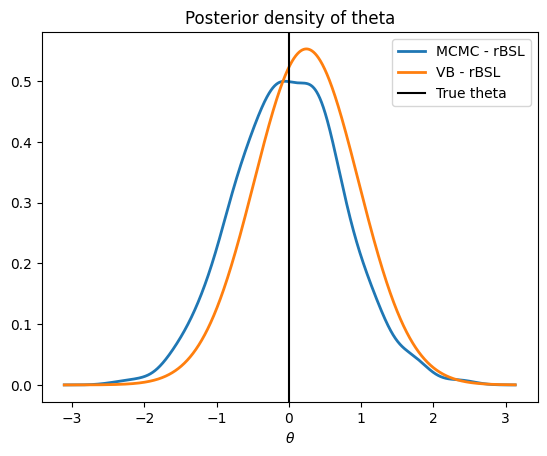

In [ ]:
plt.figure()
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(mcmc_nuissance_wasserstein_mean-4*mcmc_nuissance_wasserstein_std,np.mean(best_theta)-4*np.std(best_theta)), max(mcmc_nuissance_wasserstein_mean+4*mcmc_nuissance_wasserstein_std, np.mean(best_theta)+4*np.std(best_theta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.185, kernel='gaussian')
kde_mcmc.fit(best_theta_mcmc.reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.715, kernel='gaussian')
kde_vb.fit(best_theta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')

plt.axvline(x = 0, ymin = 0, color = 'black', label = 'True theta')

plt.legend()
plt.xlabel(r'$\theta$')
plt.title('Posterior density of theta')